### Newsbot to write a daily AI news summary using LangGraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com and potentially an autogenerated podcast

Possible TODOs:
- could use a more agentic pattern, this is more prompt chaining than a proper agent
  - make each step in the diagram a tool, make a high level coordinating tool with a prompt explaining the sequence of the workflow
  - make different steps independent agents as part of a multi-agent workflow.
- after writing summaries, could parallelize some stuff, topic analysis, ratings
- could also add tools to check format
- write currently uses a complex prompt with all the stories instead
  - filter to eg top 50 by rating
  - ignoring stories with already assigned bucket, use a model_medium prompt to put each story in an existing topic bucket, or other
  - write a section independently for each non-empty topic bucket using model_high
  - assemble all the sections and rewrite using a critic-refine flow
- do more evals with promptfoo, promptlayer, do prompt optimization with eg dspy or your own algo
- retrain reducer, identify a good number of dimensions using silhouette score
- use new stateful OpenAI API, make some persistent assistants instead of complex prompts
- make a UI that allows stepping through the graph using a wizard workflow, editing the state at each step (vars, markdown, dataframes), using time travel to go backwards and forwards.

update umap dimensionality reduction module

1. gather at least 2500 unique stories, do first 80% of days = train, rest = xval
2. run current cluster model in test, number of clusters, stories clustered and silhouette score
3. retrain current cluster params in train , run in test, collect data
4. train new cluster model on full headline + topics + summary, iterate over hyperparameters, gather scores
5. if headlines only are close , possibly retrain with xval on headlines only
6. output silhouette scores daily as part of the process 
7. could refactor the SQLite database, it got a bit messy

In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainewsbot.state']
# del sys.modules['ainewsbot.llm']
# del sys.modules['ainewsbot.config']
# del sys.modules['ainewsbot.prompts']
# del sys.modules['ainewsbot.utilities']
# del sys.modules['ainewsbot.scrape']
# del sys.modules['ainewsbot.AInewsbot']



In [2]:
import os
import shutil
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import (ChatPromptTemplate, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt
from langchain.globals import set_debug

import numpy as np
import pandas as pd
import umap

import sklearn

import bs4

from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

import asyncio
from asyncio import Semaphore

from IPython.display import HTML, Image, Markdown, display

# import pyperclip
# import shlex

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Any

from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
import google.generativeai as genai
import httpx

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

from ainewsbot.prompts import (
                        REWRITE_SYSTEM_PROMPT, REWRITE_USER_PROMPT,
                        SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT
                       )

from ainewsbot.utilities import log

from ainewsbot.agent import (Agent, AgentState, initialize_agent,
                                )


import podcastfy
from podcastfy.client import generate_podcast, process_content

from IPython.display import Audio, display, Markdown

import pdb

# need this to run async in jupyter since it already has an asyncio event loop running
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Activate global verbose logging
set_debug(False)


# disable 'show more outputs' nonsense
from IPython.core.interactiveshell import InteractiveShell

# Always display all outputs in a cell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.11 (main, Dec 11 2024, 10:25:04) [Clang 14.0.6 ]
LangChain         0.3.19
OpenAI            1.64.0
trafilatura       2.0.0
numpy             1.26.4
pandas            2.2.3
sklearn           1.6.1
umap              0.5.7
podcastfy         0.4.1


# Instantiate agent and run LangGraph workflow graph end to end

2025-05-23 18:10:30,243 - AInewsbot - INFO - Initializing with before_date=None, do_download=False, thread_id=6bc6edfb63144f449978870da55a43b7
2025-05-23 18:10:30,350 - AInewsbot - INFO - thread_id: 6bc6edfb63144f449978870da55a43b7


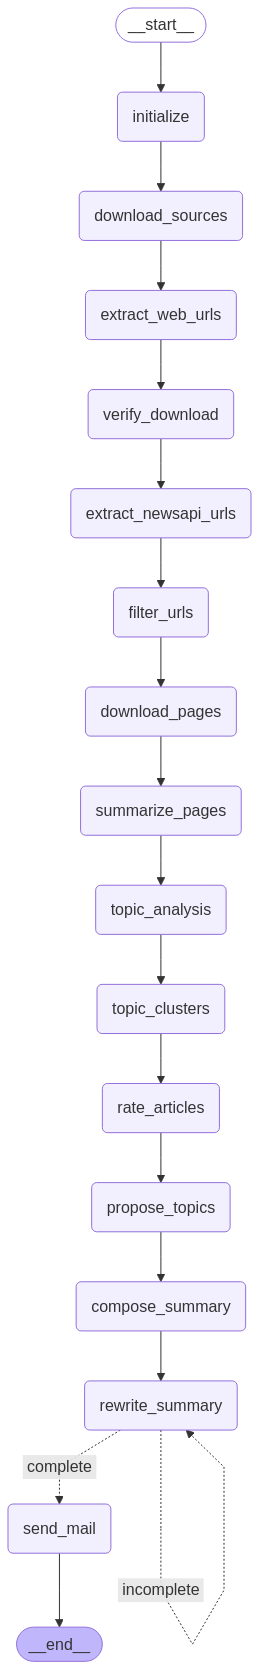

In [4]:
before_date = None
# before_date = '2025-05-14 18:00'
do_download = False

# low, medium, high models
ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1-mini', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'

lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=8)
log(f"thread_id: {thread_id}")

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [5]:
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(lg_state, config)


2025-05-23 18:10:35,915 - AInewsbot - INFO - run exception
2025-05-23 18:10:35,916 - AInewsbot - INFO - 'src'
2025-05-23 18:10:35,925 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-05-23 18:10:35,925 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars_Technica.html
2025-05-23 18:10:35,926 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-05-23 18:10:35,926 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business_Insider.html
2025-05-23 18:10:35,926 - AInewsbot - INFO - FT -> https://www.ft.com/technology -> FT.html
2025-05-23 18:10:35,926 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYW

2025-05-23 18:10:36,285 - AInewsbot - INFO - parse_file - found 338 raw links
2025-05-23 18:10:36,290 - AInewsbot - INFO - parse_file - found 44 filtered links
2025-05-23 18:10:36,290 - AInewsbot - INFO - 44 links found
2025-05-23 18:10:36,290 - AInewsbot - INFO - WSJ -> htmldata/WSJ.html
2025-05-23 18:10:36,311 - AInewsbot - INFO - parse_file - found 122 raw links
2025-05-23 18:10:36,313 - AInewsbot - INFO - parse_file - found 28 filtered links
2025-05-23 18:10:36,313 - AInewsbot - INFO - 28 links found
2025-05-23 18:10:36,313 - AInewsbot - INFO - Washington Post -> htmldata/Washington_Post.html
2025-05-23 18:10:36,335 - AInewsbot - INFO - parse_file - found 259 raw links
2025-05-23 18:10:36,337 - AInewsbot - INFO - parse_file - found 61 filtered links
2025-05-23 18:10:36,338 - AInewsbot - INFO - 61 links found
2025-05-23 18:10:36,338 - AInewsbot - INFO - Saved 1134 links


id
src                  
Ars Technica       28
Bloomberg          31
Business Insider   22
FT                 58
Feedly AI          98
Hacker News 1      23
Hacker News 2      20
HackerNoon         28
New York Times     18
Reddit            129
Techmeme          239
The Register      107
The Verge          29
VentureBeat        37
WSJ                14
Washington Post    38

2025-05-23 18:10:36,348 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


id
src                  
Ars Technica       28
Bloomberg          31
Business Insider   22
FT                 58
Feedly AI          98
Hacker News 1      23
Hacker News 2      20
HackerNoon         28
New York Times     18
Reddit            129
Techmeme          239
The Register      107
The Verge          29
VentureBeat        37
WSJ                14
Washington Post    38

2025-05-23 18:10:36,351 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-05-22T18:10:36 from NewsAPI


id
src                  
Ars Technica       28
Bloomberg          31
Business Insider   22
FT                 58
Feedly AI          98
Hacker News 1      23
Hacker News 2      20
HackerNoon         28
New York Times     18
NewsAPI            99
Reddit            129
Techmeme          239
The Register      107
The Verge          29
VentureBeat        37
WSJ                14
Washington Post    38

2025-05-23 18:10:36,735 - AInewsbot - INFO - Querying SQLite with where_clause: 
2025-05-23 18:10:37,439 - AInewsbot - INFO - URLs in orig_df: 1018
2025-05-23 18:10:37,443 - AInewsbot - INFO - Existing URLs in DB: 263933
2025-05-23 18:10:37,486 - AInewsbot - INFO - New URLs in df filtered by URL: 152
2025-05-23 18:10:37,621 - AInewsbot - INFO - Existing src+title: 44
2025-05-23 18:10:37,622 - AInewsbot - INFO - New URLs in df filtered by src+title: 108
2025-05-23 18:10:37,636 - AInewsbot - INFO - Found 108 unique new headlines
2025-05-23 18:10:37,639 - AInewsbot - INFO - Found 104 unique cleaned new headlines
2025-05-23 18:10:39,285 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:10:45,329 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:10:46,811 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:10:46,

id
src                 
Business Insider   1
Feedly AI         32
NewsAPI           17
Reddit             3

2025-05-23 18:10:46,872 - AInewsbot - INFO - Queuing URLs for scraping
2025-05-23 18:10:46,874 - AInewsbot - INFO - Saving HTML files using async concurrency= 8
2025-05-23 18:10:47,223 - AInewsbot - INFO - Launching browser
2025-05-23 18:10:48,566 - AInewsbot - INFO - Launching workers
2025-05-23 18:10:48,566 - AInewsbot - INFO - Launching worker
2025-05-23 18:10:48,567 - AInewsbot - INFO - from queue: 0, https://www.itnews.com.au/news/aemc-draws-up-electricity-rules-for-data-centres-in-ai-boom-617374 , AEMC draws up electricity rules for data centres in AI boom
2025-05-23 18:10:48,567 - AInewsbot - INFO - fetch_url(https://www.itnews.com.au/news/aemc-draws-up-electricity-rules-for-data-centres-in-ai-boom-617374)
2025-05-23 18:10:48,582 - AInewsbot - INFO - Launching worker
2025-05-23 18:10:48,582 - AInewsbot - INFO - from queue: 1, https://news.google.com/rss/articles/CBMiswFBVV95cUxNdzNlc2hUZUF2a3ZUZThmdGY5dDM5YVNJZVhOZGE5U0tRMlFoWXJHcnpoRDBPLUFsTjBZSUZJVWVqbGNBYmkzakRPNVpqVVNROHNyeG

2025-05-23 18:11:31,592 - AInewsbot - INFO - Waiting 32.91356436743622 seconds to rate limit news.google.com 0.06132370900013484
2025-05-23 18:11:41,284 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-05-23T21:43:30+00:00
2025-05-23 18:11:41,285 - AInewsbot - INFO - Saving HTML to htmlpages/College_grads_shocked_as_names_are_read_at_commencement__by_AI__What_a_beautiful_personal_touch.html
2025-05-23 18:11:41,320 - AInewsbot - INFO - from queue: 11, https://news.google.com/rss/articles/CBMizgFBVV95cUxPY1c5WUVEM19henQzWElqSnFMUGp3S2FfWGZWcWhwbW5wWWlwUjJmWmx4eVJWTkNkU1Y1TEFjRTlCbEZha0NhTkp0cURmSV9DLXQyR2pteEtqWTJlaVotX3JZVGJmcGVSQVVlQ2FBVjJ4d2E4UXRuTFlqREdPMkIzQWEyWFhkc0EzLVhhdE1KU2RCZmRMTXN0Xzhqb3NCU1FySXZ2REh1U3VOaDdnMlB2NC1oczdka2Vhd0ZPUTM3cVhTOGRyVFVBc3B5Q3FqUdIB4gFBVV95cUxOVnRPYTZKZFMtR2ZTaU9NWlYxSlFBaEJCYVgtWlBleURTM0U1cXN0MmppTGFZVUd1OWdBaXhhNXVhWFFpQ3MtampXejBMdmtrdjFFN21wR0dhRS1FRnY5eko5TVo1REY1c1RGTmZuSndCZEhzUk00d2hXLW1HLU4zQVFp

2025-05-23 18:12:50,936 - AInewsbot - INFO - Could not parse last_updated 'on Thursday May 22, 2025 @02:33PM': Unknown string format: on Thursday May 22, 2025 @02:33PM
2025-05-23 18:12:50,937 - AInewsbot - INFO - Saving HTML to htmlpages/Googles_AI_product_names_are_confusing_as_hell_-_The_Verge.html
2025-05-23 18:12:50,957 - AInewsbot - INFO - from queue: 20, https://news.google.com/rss/articles/CBMirwFBVV95cUxPMVdTOXQyU2F3c0NSSUdhd0VyVVpiWklxMVF4YzMxYV91UmY2WGllOURyNVEyYmQyTEpucVZ4ZkI5NDRrN1hjNF9xMTRPRVRKc2tOaGVQU25ESmFQYWtVc3Y2VWM5OE5SaEo0U3IyRFFKdmhhWnNzSkZ3RGZBNmtISEFpREtEcWxMaEpTSk1ZaUJSdF9ScmZWbGVWTkJqZ1Q1RUtadFA0YjJFZGtJeC1Z , HIMSSCast: Forecasting AI and health IT regulation under a Trump White House
2025-05-23 18:12:50,958 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMirwFBVV95cUxPMVdTOXQyU2F3c0NSSUdhd0VyVVpiWklxMVF4YzMxYV91UmY2WGllOURyNVEyYmQyTEpucVZ4ZkI5NDRrN1hjNF9xMTRPRVRKc2tOaGVQU25ESmFQYWtVc3Y2VWM5OE5SaEo0U3IyRFFKdmhhWnNzSkZ3RGZBNmtISEFpREtEcWxM

2025-05-23 18:15:26,439 - AInewsbot - INFO - fetch_url(https://www.cnbc.com/2025/05/22/openai-cfo-says-ai-hardware-boost-chatgpt-in-new-era-of-computing-.html)
2025-05-23 18:15:38,020 - AInewsbot - INFO - Waiting 43.69975603100242 seconds to rate limit news.google.com 0.11037287500221282
2025-05-23 18:15:44,386 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-05-22T20:59:43+0000
2025-05-23 18:15:44,387 - AInewsbot - INFO - Saving HTML to htmlpages/OpenAI_CFO_says_AI_hardware_will_boost_ChatGPT_subscriptions_in__new_era_of_computing.html
2025-05-23 18:15:44,409 - AInewsbot - INFO - from queue: 30, https://biztoc.com/x/354f9e297de21746 , OpenAI and Nvidia among companies building Stargate AI infrastructure in UAE
2025-05-23 18:15:44,410 - AInewsbot - INFO - fetch_url(https://biztoc.com/x/354f9e297de21746)
2025-05-23 18:15:59,444 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-05-23T18:21:50Z


2025-05-23 18:17:28,685 - AInewsbot - INFO - fetch_url(https://www.carscoops.com/2025/05/tesla-fsd-crash-video-swerve-tree/)
2025-05-23 18:17:30,540 - AInewsbot - INFO - Waiting 41.66555311792601 seconds to rate limit news.google.com 0.03283233300317079
2025-05-23 18:17:48,572 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-05-22T22:31:00+00:00
2025-05-23 18:17:48,573 - AInewsbot - INFO - Saving HTML to htmlpages/Tesla_On_FSD_Suddenly_Swerves_And_Crashes_Into_A_Tree__Claims_Driver.html
2025-05-23 18:17:48,594 - AInewsbot - INFO - from queue: 41, https://venturebeat.com/ai/the-3-biggest-bombshells-from-this-weeks-ai-extravaganza/ , The 3 biggest bombshells from this weeks AI extravaganza
2025-05-23 18:17:48,594 - AInewsbot - INFO - fetch_url(https://venturebeat.com/ai/the-3-biggest-bombshells-from-this-weeks-ai-extravaganza/)
2025-05-23 18:17:49,275 - AInewsbot - INFO - Found last updated time from time tag: 2025-05-23
2025-05-23 18:17:49

2025-05-23 18:20:11,077 - AInewsbot - INFO - Found last updated time from HTTP header: Fri, 23 May 2025 20:54:13 GMT
2025-05-23 18:20:11,078 - AInewsbot - INFO - Saving HTML to htmlpages/What_will_Jony_Ive_s_ChatGPT_device_be__We_rounded_up_the_best_guesses_on_what_he_s_cooking_up_for_OpenAI..html
2025-05-23 18:20:11,104 - AInewsbot - INFO - from queue: 50, https://www.cbsnews.com/video/wrongful-death-lawsuit-raises-question-do-ai-chatbots-free-speech/ , Wrongful death lawsuit raises question, do AI chatbots have free speech?
2025-05-23 18:20:11,105 - AInewsbot - INFO - fetch_url(https://www.cbsnews.com/video/wrongful-death-lawsuit-raises-question-do-ai-chatbots-free-speech/)
2025-05-23 18:20:22,493 - AInewsbot - INFO - Waiting 35.48472562619261 seconds to rate limit news.google.com 0.05413279199274257
2025-05-23 18:20:29,591 - AInewsbot - INFO - Found last updated time from HTTP header: Fri, 23 May 2025 22:20:11 GMT
2025-05-23 18:20:29,592 - AInewsbot - INFO - Saving HTML to htmlpages

id
src                 
Business Insider   1
Feedly AI         32
NewsAPI           17
Reddit             3

2025-05-23 18:24:14,637 - AInewsbot - INFO - Starting summarize
2025-05-23 18:24:14,637 - AInewsbot - INFO - Fetching summaries for all articles
2025-05-23 18:24:14,640 - AInewsbot - INFO - Attempting to fetch summaries for 53 articles
2025-05-23 18:24:14,654 - AInewsbot - INFO - clean_html - Page title: AEMC draws up electricity rules for data centres in AI boom - iTnews
Social card title: AEMC draws up electricity rules for data centres in AI boom
Social card description: Wants to prevent a mass disconnection event.

2025-05-23 18:24:14,857 - AInewsbot - INFO - Queuing 0: Page title: AEMC draws up electricity rules for da...
2025-05-23 18:24:14,884 - AInewsbot - INFO - clean_html - Page title: AI shows higher emotional intelligence than humans: Study
Social card title: AI shows higher emotional intelligence than humans: Study
Social card description: Swiss researchers say AI scored 82% on emotional intelligence tests, compared to 56% for people - Anadolu Ajansı

2025-05-23 18:24:14,9

2025-05-23 18:24:16,531 - AInewsbot - INFO - clean_html - Page title: Google's Co-Founder Says AI Performs Best When You Threaten It
Social card title: Google's Co-Founder Says AI Performs Best When You Threaten It
Social card description: During a podcast taping, Google co-founder Sergey Brin said that threatening an AI model makes it work best. That seems like a bad idea.

2025-05-23 18:24:16,557 - AInewsbot - INFO - Queuing 17: Page title: Google's Co-Founder Says AI Performs B...
2025-05-23 18:24:16,568 - AInewsbot - INFO - clean_html - Page title: Google’s AI product names are confusing as hell - The Verge - Slashdot
Social card title: Google’s AI product names are confusing as hell - The Verge - Slashdot
Social card description:   Google&rsquo;s AI product names are confusing as hellThe Verge  Google is banking on AI agents, smart glasses to defend its search crownYahoo Finance  How well do you know our I/O 2025 announcements?Google Blog  What is AI Mode, Google's new artificial 

2025-05-23 18:24:17,511 - AInewsbot - INFO - clean_html - Page title: barrons.com

2025-05-23 18:24:17,513 - trafilatura.core - WARNING - discarding data: None
2025-05-23 18:24:17,513 - AInewsbot - INFO - Queuing 33: Page title: barrons.com
...
2025-05-23 18:24:17,523 - AInewsbot - INFO - clean_html - Page title: Pope's call to tame AI sets tone for Christian leaders - Digital Journal
Social card title: Pope's call to tame AI sets tone for Christian leaders
Social card description: Pope Leo XIV singled out the challenges of artificial intelligence as he took office this month, underscoring religious leaders' hopes to influence a

2025-05-23 18:24:17,536 - AInewsbot - INFO - Queuing 34: Page title: Pope's call to tame AI sets tone for C...
2025-05-23 18:24:17,563 - AInewsbot - INFO - clean_html - Page title: Bangkok Post - PromptSphere to improve Thai AI training standards
Social card title: PromptSphere to improve Thai AI training standards
Social card description: True Digital Academy

2025-05-23 18:24:18,266 - AInewsbot - INFO - Queuing 50: Page title: Wrongful death lawsuit raises question...
2025-05-23 18:24:18,288 - AInewsbot - INFO - clean_html - Page title: You'll be as annoyed as me when you learn how much energy a few seconds of AI video costs | TechRadar
Social card title: You'll be as annoyed as me when you learn how much energy a few seconds of AI video costs
Social card description: The videos may be cool, but the servers making them are overheating

2025-05-23 18:24:18,326 - AInewsbot - INFO - Queuing 51: Page title: You'll be as annoyed as me when you le...
2025-05-23 18:24:18,337 - AInewsbot - INFO - clean_html - Page title: Zoox issues second robotaxi software recall in a month following collision  | TechCrunch
Social card title: Zoox issues second robotaxi software recall in a month following collision  | TechCrunch
Social card description: Amazon-owned autonomous vehicle company Zoox has issued its second voluntary software recall in a month, follow

2025-05-23 18:24:22,357 - AInewsbot - INFO - Summary for 1 (length 1793): - Swiss researchers from the universities of Geneva and Bern found AI scored 82% on emotional intelligence tests compared to 56% for humans, outperforming people in empathy and emotion management tasks.  
- AI models, including ChatGPT, were able to generate new emotional intelligence tests that over 400 participants rated as realistic, indicating AI’s understanding of emotional behavior.  
- The study suggests AI could assist in areas like education, coaching, and conflict resolution, challenging the notion that these fields require exclusively human emotional skills.
2025-05-23 18:24:22,358 - AInewsbot - INFO - Summary for 2 (length 176): - no content
2025-05-23 18:24:22,358 - AInewsbot - INFO - Summary for 3 (length 1643): - Amazon is testing AI-powered short-form audio summaries on select product detail pages, currently available to some US customers, with plans to expand access in the coming months.  
- The 

2025-05-23 18:24:22,363 - AInewsbot - INFO - Summary for 14 (length 4322): - Accenture has partnered with ServiceNow to automate administrative tasks using ServiceNow's Now Platform, implementing AI tools like text-to-code and text-to-flow across multiple departments, with over 100 applications developed on the platform.
- Accenture emphasizes a cultural shift for AI adoption, focusing on demonstrating how AI can ease employees' workloads by automating routine operational tasks, thereby accelerating acceptance and usage among staff.
- The company aims for employees to embrace AI willingly, promoting peer-led discussions and internal town halls to share success stories, with plans to advance toward agentic AI for broader automation in the future.
2025-05-23 18:24:22,363 - AInewsbot - INFO - Summary for 15 (length 1376): - A German consumer rights group, Verbraucherzentrale NRW, failed to obtain a court injunction in Cologne to stop Meta from using Facebook and Instagram user posts for t

2025-05-23 18:24:22,367 - AInewsbot - INFO - Summary for 26 (length 3389): - At its Build 2025 conference, Microsoft emphasized its commitment to advancing agentic AI, which focuses on AI agents that take initiative and perform complex tasks autonomously, marking a significant strategic shift highlighted by Deutsche Bank analysts.  
- Microsoft introduced major updates to Azure AI Studio, Copilot Studio, and AI Foundry tools aimed at enabling developers to create and deploy agentic AI applications across its cloud and enterprise platforms.  
- Deutsche Bank noted that Microsoft’s expansive investments and broad ecosystem position it strongly to lead in the rapidly growing agentic AI market, projected to grow from $5.2 billion in 2024 to $196.6 billion by 2034, although realizing this vision will require ongoing development and experimentation.
2025-05-23 18:24:22,367 - AInewsbot - INFO - Summary for 27 (length 2939): - The Navy, in partnership with the Defense Innovation Unit (DIU), is

2025-05-23 18:24:22,371 - AInewsbot - INFO - Summary for 38 (length 6632): - The U.S. Space Force must prioritize the development and integration of AI as a core warfighting capability to maintain space superiority in future conflicts dominated by autonomous digital combat.
- AI agents, or autonomous software cyber warriors, will be essential for controlling space systems and missions, with the Space Force needing to retain ownership and direct control over these technologies to avoid reliance on external contractors.
- Bureaucratic inertia within the Department of Defense threatens to undermine U.S. space dominance, with warnings that outsourcing core space warfighting missions risks strategic failure against adversaries like China who are aggressively advancing AI-driven network warfare.
2025-05-23 18:24:22,372 - AInewsbot - INFO - Summary for 39 (length 5914): - The U.S. House of Representatives narrowly passed the "One Big Beautiful Bill" containing a 10-year ban on state and local

2025-05-23 18:24:22,376 - AInewsbot - INFO - Summary for 49 (length 8243): - Former Apple design chief Jony Ive and OpenAI CEO Sam Altman are collaborating on a secret, potentially revolutionary ChatGPT hardware device expected to launch in 2027, described as a small, screenless AI "companion" that connects to phones or laptops and fits on desks or in pockets.  
- Industry analyst Ming-Chi Kuo suggests the device could be iPod Shuffle-sized, wearable, and without a screen, focusing on environmental awareness through cameras and mics; Altman envisions shipping 100 million units on day one, aiming to redefine AI interaction beyond traditional screen-based devices.  
- Speculation and creative renders include ideas like smart glasses, AI desk companions, pendants, or even internal wearable tech, highlighting OpenAI’s ambition to challenge Apple and Google by establishing a new physical AI interaction paradigm.
2025-05-23 18:24:22,377 - AInewsbot - INFO - Summary for 50 (length 1671): - A 

id
src                 
Business Insider   1
Feedly AI         32
NewsAPI           17
Reddit             3

2025-05-23 18:24:22,392 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-23 18:24:29,481 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:30,650 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:32,451 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:32,467 - AInewsbot - INFO - 53 free-form topics extracted
2025-05-23 18:24:32,468 - AInewsbot - INFO - Starting assigned topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-23 18:24:32,469 - AInewsbot - INFO - Canonical topic books & publishing
2025-05-23 18:24:32,469 - AInewsbot - INFO - Canonical topic chatbots
2025-05-23 18:24:32,470 - AInewsbot - INFO - Canonical topic cybersecurity
2025-05-23 18:24:32,470 - AInewsbot - INFO - Canonical to

2025-05-23 18:24:32,514 - AInewsbot - INFO - Canonical topic policy and regulation
2025-05-23 18:24:32,514 - AInewsbot - INFO - Canonical topic gen ai
2025-05-23 18:24:32,515 - AInewsbot - INFO - Canonical topic jobs & careers
2025-05-23 18:24:32,515 - AInewsbot - INFO - Canonical topic smart grid
2025-05-23 18:24:32,515 - AInewsbot - INFO - Canonical topic stocks
2025-05-23 18:24:32,516 - AInewsbot - INFO - Sending prompt for 105 canonical topics
2025-05-23 18:24:37,643 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:37,852 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:37,933 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:37,947 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:38,061 - httpx - INFO - HTTP Request: POST http

2025-05-23 18:24:38,536 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:38,540 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:38,546 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:38,553 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:38,557 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:38,558 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:38,559 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:38,564 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:38,565 - httpx 

2025-05-23 18:24:39,262 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:39,264 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:39,272 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:39,275 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:39,280 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:39,283 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:39,295 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:39,299 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:39,306 - httpx 

2025-05-23 18:24:39,498 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:39,499 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:39,503 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:39,509 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:39,510 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:39,519 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:39,520 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:39,522 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:39,533 - httpx 

2025-05-23 18:24:39,718 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:39,719 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:39,727 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:39,727 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:39,728 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:39,728 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:39,729 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:39,729 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:39,742 - httpx 

2025-05-23 18:24:41,756 - AInewsbot - INFO - Queuing 21: ### <<<ARTICLE SUMMARY>>>
# Here's Google's Sergey...
2025-05-23 18:24:41,757 - AInewsbot - INFO - Queuing 22: ### <<<ARTICLE SUMMARY>>>
# I just fell in love wi...
2025-05-23 18:24:41,757 - AInewsbot - INFO - Queuing 23: ### <<<ARTICLE SUMMARY>>>
# In 93, it became clear...
2025-05-23 18:24:41,757 - AInewsbot - INFO - Queuing 24: ### <<<ARTICLE SUMMARY>>>
# MTG Argues With Elon M...
2025-05-23 18:24:41,757 - AInewsbot - INFO - Queuing 25: ### <<<ARTICLE SUMMARY>>>
# Marjorie Taylor Greene...
2025-05-23 18:24:41,757 - AInewsbot - INFO - Queuing 26: ### <<<ARTICLE SUMMARY>>>
# Microsoft just took th...
2025-05-23 18:24:41,758 - AInewsbot - INFO - Queuing 27: ### <<<ARTICLE SUMMARY>>>
# Navy wants AI tools to...
2025-05-23 18:24:41,758 - AInewsbot - INFO - Queuing 28: ### <<<ARTICLE SUMMARY>>>
# Note, Paint and Snip W...
2025-05-23 18:24:41,758 - AInewsbot - INFO - Queuing 29: ### <<<ARTICLE SUMMARY>>>
# OpenAI CFO says AI har...
2

async_langchain: 0, {'input_text': '### <<<ARTICLE SUMMARY>>>\n# AEMC draws up electricity rules for data centres in AI boom\n\n- The Australian Energy Market Commission (AEMC) is proposing new electricity rules to manage the expected surge in high-capacity data centres driven by AI demand, aiming to prevent mass disconnection events during grid disturbances.  \n- AEMC chair Anna Collyer highlighted that some data centres in Australia may require as much electricity as small cities and stressed the need for standards ensuring facilities respond properly during power system disturbances.  \n- The move follows a 2022 incident in Virginia, USA, where 60 data centres automatically disconnected from the grid during a disturbance, consuming 1500 MW and worsening grid stability; the AEMC is seeking to avoid a similar scenario in Australia.\n### <<<END>>>\n### <<<CANDIDATE TOPICS>>>\nAI Demand, Australian Energy Market Commission, Data Centres, Economics, Electricity Rules, Energy, Gen AI, Gov

2025-05-23 18:24:42,926 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:42,964 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:42,972 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:42,990 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:42,994 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 0 response: items=['Australian Energy Market Commission', 'Electricity Rules', 'Data Centres', 'Grid Stability', 'AI Demand', 'Policy and Regulation']
async_langchain: 3 response: items=['AI Audio Summaries', 'Amazon', 'AI Shopping Assistant', 'Alexa+', 'Generative AI', 'Product Pages', 'Speech Recognition & Synthesis']
async_langchain: 9 response: items=['Google Search', 'AI Chatbots', 'Search Market Competition', 'AI Innovation']
async_langchain: 15 response: items=['Consumer Rights Lawsuit', 'Meta', 'AI Training Data', 'European Union Regulations', 'Privacy', 'Policy and Regulation']
async_langchain: 2 response: items=[]


2025-05-23 18:24:43,234 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:43,289 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:43,302 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:43,317 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:43,330 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:43,333 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:43,364 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:43,433 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 8 response: items=['Baltimore Jail Lawsuit', 'Butler Snow LLP', 'ChatGPT Misuse', 'Legal AI Issues', 'AI Reputational Risks', 'Healthcare']
async_langchain: 46 response: items=[]
async_langchain: 48 response: items=['AI Web Browsing Data', 'Public Engagement With AI Content', 'AI-Generated Summaries', 'AI Online Exposure', 'AI-Related Search Behavior', 'Chatbots']
async_langchain: 4 response: items=['Dolphingemma', 'Dolphin Vocalizations', 'Large Language Models', 'Marine Mammal Communication', 'Cetacean Conservation', 'Speech Recognition and Synthesis']
async_langchain: 1 response: items=['AI Emotional Intelligence', 'ChatGPT', 'Emotional Behavior', 'Education and Coaching', 'Conflict Resolution', 'Swiss Universities']
async_langchain: 18 response: items=['Product Naming Confusion', 'AI Agents', 'Smart Glasses', 'Google AI Products', 'I/O 2025 Announcements', 'Privacy']
async_langchain: 33 response: items=[]


2025-05-23 18:24:43,449 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:43,544 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:43,553 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:43,573 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:43,578 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:43,604 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:43,612 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:43,621 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:43,626 - httpx 

async_langchain: 31 response: items=['OpenAI Device Startup Acquisition', 'AI-Enabled Physical Devices', 'Jony Ive Design Partnership', 'Hardware-Software AI Integration', 'Innovative AI Product Development']
async_langchain: 39 response: items=['U.S. House AI Regulation Ban', 'State Vs Federal AI Laws', 'State Sovereignty In AI Policy', 'Big Tech And AI Oversight', 'AI Public Safety Concerns', 'Policy And Regulation', 'Bias And Fairness']
async_langchain: 32 response: items=['OpenAI Operator Upgrade', 'Autonomous Web Browsing Agent', 'ChatGPT Pro Subscription', 'Gpt-4O To O3 Model', 'AI Enhanced Task Completion', 'Safety And Alignment']
async_langchain: 24 response: items=['AI Ideological Bias', "Elon Musk's AI Chatbot Grok", 'Marjorie Taylor Greene Controversy', 'Conspiracy Theories in AI', 'AI and Political Polarization', 'Disinformation']
async_langchain: 51 response: items=['AI Video Energy Consumption', 'Data Center Energy Use', 'Environmental Impact Of AI', 'Nuclear Energy Use I

2025-05-23 18:24:43,672 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:43,681 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:43,701 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:43,727 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:43,762 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:43,780 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:43,822 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 20 response: items=['AI And Health IT Regulation', 'Department Of Health And Human Services Changes', 'Telehealth Policy', 'Trump Administration Healthcare Policy', 'AI Innovation In Healthcare', 'Policy And Regulation', 'Legal Issues']
async_langchain: 34 response: items=['AI And Human Dignity', 'Algor-Ethics In AI', 'Autonomous AI Risks', 'Christian Leadership On AI', 'Job Automation', 'Privacy', 'Pope Leo XIV AI Ethical Concerns']
async_langchain: 41 response: items=['Microsoft Model Context Protocol', 'Anthropic Claude 4', 'Google AI Mode For Search', 'AI In Software Engineering', 'AI-Enhanced Search Experience', 'Large Language Models']
async_langchain: 19 response: items=['Google Character.AI Deal', 'U.S. Department of Justice Investigation', 'Antitrust Scrutiny', 'AI Partnerships', 'Policy and Regulation', 'Technology Regulation']
async_langchain: 50 response: items=['AI Chatbot Legal Status', 'AI Responsibility In Harm', 'Character.AI Legal Case', 'Free Speech 

2025-05-23 18:24:43,893 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:43,906 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:43,916 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:43,936 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:43,953 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:43,958 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:43,965 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:43,975 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:43,976 - httpx 

async_langchain: 22 response: items=['AI And Storytelling', 'AI In Poetry And Roleplay', 'ChatGPT Creative Uses', 'Emotional Expression With AI', 'Authors And Writing', 'Chatbots']
async_langchain: 23 response: items=['Decentralized Artificial General Intelligence', 'SingularityNET', 'Artificial General Intelligence', 'Artificial Superintelligence Alliance', 'AI Marketplace', 'Agi Development Investment']
async_langchain: 5 response: items=['Anthropic Claude 4', 'Agentic Coding', 'Code Assistants']
async_langchain: 16 response: items=['Google AI Mode', 'Publisher Compensation', 'News/Media Alliance', 'DoJ Intervention', 'Intellectual Property', 'Search Content Usage', 'Legal Issues']
async_langchain: 25 response: items=["Elon Musk's AI Chatbot Grok", 'AI Bias Accusations', 'MAGA-Oriented AI', 'Marjorie Taylor Greene Christian Beliefs', 'QAnon and AI', 'Disinformation', 'Politics']
async_langchain: 11 response: items=['Gun Detection AI', 'School Security', 'Volusia County Schools', 'Zer

2025-05-23 18:24:44,128 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:44,203 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:44,225 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 47 response: items=['AI Simulated Supreme Court Opinions', 'Birthright Citizenship Cases', 'Fourteenth Amendment Interpretation', 'Judicial Reasoning By AI', 'Trump v. CASA Supreme Court Case', 'Legal Issues', 'Policy and Regulation']
async_langchain: 52 response: items=['Zoox Robotaxi Software Recall', 'Zoox Collision Incident', 'Autonomous Vehicle Safety', 'Self-Driving Car Software Updates', 'Amazon-Owned Autonomous Vehicles']
async_langchain: 44 response: items=['Agentic AI Web', 'OpenAI Acquisition of Io', 'Google AI Shopping Features', 'Windows AI Platform', 'AI-Native Hardware', 'ChatGPT', 'AI-Assisted Search']
async_langchain: 27 response: items=['AI for Military Resource Allocation', 'Autonomy and Robotics in Military', 'Defense Innovation Unit Collaboration', 'Navy AI Tools', 'Situational Awareness by Intelligent Learning Systems']
async_langchain: 10 response: items=['AI in Commencements', 'Graduation Ceremony Experience', 'Gen Z Reactions', 'Name Pronunciat

2025-05-23 18:24:44,335 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:44,459 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:44,473 - AInewsbot - INFO - Received 53 responses
2025-05-23 18:24:44,480 - AInewsbot - INFO - End topic analysis


async_langchain: 36 response: items=['U.S. Drug Price Regulation', 'Most-Favored-Nation Pricing', 'Fda Regulatory Reforms', 'AI In Drug Development', 'Policy And Regulation', 'Pharmaceutical Innovation Policies']
async_langchain: 38 response: items=['Space Dominance And AI', 'U.S. Space Force AI Strategy', 'Autonomous Cyber Warriors', 'Defense Technology Control', 'AI In Space Warfare', 'China']


id
src                 
Business Insider   1
Feedly AI         32
NewsAPI           17
Reddit             3

2025-05-23 18:24:44,493 - AInewsbot - INFO - Fetching embeddings for 53 headlines
2025-05-23 18:24:45,634 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-05-23 18:24:45,910 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-05-23 18:24:45,923 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-05-23 18:24:47,430 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-23 18:24:49,201 - AInewsbot - INFO - Cluster with DBSCAN
2025-05-23 18:24:49,292 - AInewsbot - INFO - Found 1 clusters


title_topic_str
0     What will Jony Ive's ChatGPT device be? We rounded up the best guesses on what he's cooking up for OpenAI. (Topics: Jony Ive and OpenAI Collaboration, ChatGPT Hardware Device, AI Device Design Speculation, AI Physical Interaction Devices, Future AI Gadgets)
1  OpenAI CFO says AI hardware will boost ChatGPT subscriptions in 'new era of computing' (Topics: OpenAI AI Hardware Acquisition, AI Device Development, ChatGPT Subscription Growth, Future Computing Platforms, Supply Chain Optimization, Mergers and Acquisitions)
2       OpenAI updates Operator to o3, making its $200 monthly ChatGPT Pro subscription more enticing (Topics: OpenAI Operator Upgrade, Autonomous Web Browsing Agent, ChatGPT Pro Subscription, Gpt-4O To O3 Model, AI Enhanced Task Completion, Safety And Alignment)

2025-05-23 18:24:50,372 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:50,392 - AInewsbot - INFO - I dub this cluster: Advancements in ChatGPT Hardware and Services
2025-05-23 18:24:50,397 - AInewsbot - INFO - ['Advancements in ChatGPT Hardware and Services']
2025-05-23 18:24:50,429 - AInewsbot - INFO - bullets created


[What will Jony Ive's ChatGPT device be? We rounded up the best guesses on what he's cooking up for OpenAI. - Business Insider](https://www.businessinsider.com/jony-ive-device-openai-io-guesses-sam-altman-chatgpt-2025-5)

Topics: Advancements in ChatGPT Hardware and Services, Jony Ive and OpenAI Collaboration, ChatGPT Hardware Device, AI Device Design Speculation, AI Physical Interaction Devices, Future AI Gadgets

- Former Apple design chief Jony Ive and OpenAI CEO Sam Altman are collaborating on a secret, potentially revolutionary ChatGPT hardware device expected to launch in 2027, described as a small, screenless AI "companion" that connects to phones or laptops and fits on desks or in pockets.  
- Industry analyst Ming-Chi Kuo suggests the device could be iPod Shuffle-sized, wearable, and without a screen, focusing on environmental awareness through cameras and mics; Altman envisions shipping 100 million units on day one, aiming to redefine AI interaction beyond traditional screen-based devices.  
- Speculation and creative renders include ideas like smart glasses, AI desk companions, pendants, or even internal wearable tech, highlighting OpenAI’s ambition to challenge Apple and Google by establishing a new physical AI interaction paradigm.



[OpenAI CFO says AI hardware will boost ChatGPT subscriptions in 'new era of computing' - CNBC](https://www.cnbc.com/2025/05/22/openai-cfo-says-ai-hardware-boost-chatgpt-in-new-era-of-computing-.html)

Topics: Advancements in ChatGPT Hardware and Services, OpenAI AI Hardware Acquisition, AI Device Development, ChatGPT Subscription Growth, Future Computing Platforms, Supply Chain Optimization, Mergers and Acquisitions

- OpenAI CFO Sarah Friar stated that the company's \\$6.4 billion acquisition of Jony Ive's startup io, which focuses on bespoke AI hardware, is a bet on a "new era" of computing that will boost ChatGPT subscriptions by putting AI technology in the hands of more users.  
- Friar emphasized the importance of not only envisioning new platforms but also building and managing supply chains, highlighting OpenAI's intent to create proprietary devices alongside ongoing collaborations, including with Apple, to foster innovation in AI hardware beyond traditional touchscreens.  
- OpenAI reports 500 million weekly active users for ChatGPT, and Friar suggested that new AI devices could drive higher subscription growth and evolve the business model, reflecting broader industry views that AI hardware might transform or even replace current mobile platforms like the iPhone within the next decade.



[OpenAI updates Operator to o3, making its \\$200 monthly ChatGPT Pro subscription more enticing - VentureBeat](https://venturebeat.com/ai/openai-updates-operator-to-o3-making-its-200-monthly-chatgpt-subscription-more-enticing/)

Topics: Advancements in ChatGPT Hardware and Services, OpenAI Operator Upgrade, Autonomous Web Browsing Agent, ChatGPT Pro Subscription, Gpt-4O To O3 Model, AI Enhanced Task Completion, Safety And Alignment

- OpenAI has upgraded its Operator autonomous web browsing agent within ChatGPT from the GPT-4o model to the more powerful o3 reasoning model, available globally as a research preview exclusively to \\$200/month ChatGPT Pro subscribers starting May 23, 2025.  
- The o3 model offers significantly improved accuracy, task completion rates, clearer and more structured responses, and stronger performance on benchmarks such as OSWorld, WebArena, and GAIA compared to its predecessor, while retaining enhanced safety measures like user confirmations and restricted access on high-risk platforms.  
- Operator enables autonomous web-based tasks like booking reservations and data gathering through a cloud-hosted virtual browser, targeting applications in both consumer and enterprise settings, with particular benefits for AI engineers, data managers, and security professionals.



[German rights group fails in bid stop Meta's data use for AI - Google News](https://news.google.com/rss/articles/CBMigAFBVV95cUxQNzFmOXZyMHRsUHowT2RkamJDOThZczA0NDUyR1ZOaFJuakxLUUVLYlpEdmFTbzVISDB5NGVKWlVxanFfTDJiUm5wZ3BPbldTc2E0U2M4WW5jUlNmZl9jY2loYnBUdXd4VTNmT21CM3NmLWFfYzJGTWRIeG9RcUlRSA)

Topics: Consumer Rights Lawsuit, Meta, AI Training Data, European Union Regulations, Privacy, Policy and Regulation

- A German consumer rights group, Verbraucherzentrale NRW, failed to obtain a court injunction in Cologne to stop Meta from using Facebook and Instagram user posts for training its AI models.  
- Meta plans to train its AI in the EU using public posts from adult users on its platforms and interactions with its AI, while notifying users and offering them an opt-out option.  
- The court ruling allows Meta to proceed with its AI training initiative despite the consumer rights group's challenge.



[College grads shocked as names are read at commencement  by AI: What a beautiful personal touch! - New York Post](https://nypost.com/2025/05/23/tech/college-grads-shocked-as-names-are-read-at-commencement-by-ai-what-a-beautiful-personal-touch/)

Topics: AI in Commencements, Graduation Ceremony Experience, Gen Z Reactions, Name Pronunciation, Speech Recognition and Synthesis, Pace University, Jobs and Careers

- At Pace University’s recent commencement, graduates’ names were read aloud by an AI-generated voice after scanning QR codes on their phones, sparking mixed reactions online about the personal touch and use of technology.  
- The university allowed students to phonetically verify their names beforehand to ensure AI pronunciation accuracy, but many social media users criticized the method as impersonal and awkward, comparing it to a retail self-checkout experience.  
- The incident highlights ongoing generational tensions regarding AI's impact, with many Gen Z graduates feeling their education and job prospects are being undermined by technology.



[Here's Google's Sergey Brin On Google Glass Failures And Why Android XR Is Different - hothardware.com](https://hothardware.com/news/sergey-brin-talks-google-glass-failure-and-why-android-xr-is-different)

Topics: Google Glass Failures, Android XR, Generative AI In Smart Glasses, Google Partnerships, Supply Chain Optimization, Manufacturing, Wearable AI Technology

- Google co-founder Sergey Brin admitted to mistakes with the original Google Glass launch in 2013, citing supply chain issues, high price, privacy concerns, and immature technology as key challenges.
- Brin highlighted that Android XR, Google’s new operating system for smart glasses, is poised for success due to advances in generative AI, enabling less distracting and more helpful wearable experiences.
- Google is now partnering with established consumer electronics and eyewear brands like Samsung, Xreal, and Warby Parker to improve manufacturing, supply chains, and product quality, aiming to avoid past failures and deliver transformative AI-powered smart glasses.



[What Web Browsing Data Tells Us About How AI Appears Online - Google News](https://news.google.com/rss/articles/CBMirgFBVV95cUxNVzd1Mkt0d3JqWnBCdVlmcU84RVpvUk05SHpCRGhJT2JYdm5zYjJyUk8tWDk3WVRIbXNtdmxzZXZmX25xWmpMbkZacldPNGRIZnFEd0NLdzFZZ2hNMGxiT3lvazd0WnJyM2tiZlowdUM2dVVYd0ZPQU1lTWRZTDlYMldDOEpyOS1UQkxNRUFZX2lxRmN5eGZpaEFaRXF2ZF8zcVBxOGNRLThmeFhXa1E)

Topics: AI Web Browsing Data, Public Engagement With AI Content, AI-Generated Summaries, AI Online Exposure, AI-Related Search Behavior, Chatbots

- In March 2025, 93% of 900 U.S. adults visited at least one webpage mentioning AI, but only about 49% visited pages with in-depth AI content, typically only a few times per month, indicating AI references are common but not deeply engaged with.
- Around 58% encountered AI-generated summaries in search engine results, 13% visited AI tool websites like ChatGPT, and about half saw AI mentions on news and shopping sites, though detailed AI discussion was rare (8% for news articles).
- Common AI-related terms encountered included general references like "AI," "artificial intelligence," "ChatGPT," and marketing language such as "AI-powered," reflecting widespread but surface-level exposure to AI in online browsing.



[Googles Character.AI Deal Reportedly Draws Antitrust Attention - biztoc.com](https://biztoc.com/x/e213dbdf5ace0784)

Topics: Google Character.AI Deal, U.S. Department of Justice Investigation, Antitrust Scrutiny, AI Partnerships, Policy and Regulation, Technology Regulation

- The U.S. Department of Justice is investigating whether Google's deal with chatbot maker Character.AI violates antitrust laws, according to Bloomberg News.  
- The probe focuses on Google's agreement to utilize Character.AI's artificial intelligence technology.  
- This inquiry highlights increasing regulatory scrutiny over major technology companies' AI-related partnerships and acquisitions.



[Google's AI Mode Is 'the Definition of Theft,' Publishers Say - tech.slashdot.org](https://tech.slashdot.org/story/25/05/23/209232/googles-ai-mode-is-the-definition-of-theft-publishers-say)

Topics: Google AI Mode, Publisher Compensation, News/Media Alliance, DoJ Intervention, Intellectual Property, Search Content Usage, Legal Issues

- Publishers criticize Google's new AI Mode for Search as "the definition of theft," accusing it of using their content without fair compensation or a true opt-out option, which harms their traffic and revenue.  
- Internal documents revealed Google chose not to give publishers control over AI-generated content usage, prioritizing product functionality over publisher protections.  
- The News/Media Alliance urges DOJ intervention to prevent Google's internet dominance and calls for addressing the harm AI-driven search tools cause to the publishing industry.



[Artificial intelligencein modern chemistry: comparison between humans and machines - Google News](https://news.google.com/rss/articles/CBMiygFBVV95cUxOd0ljMzc4STRBclN2LVNLSElWUkl5RVJHZWI5UDNpTWJjcjl0OVFZYzU0anc5cnRXcE1ZNXlDYzNRT1Y4MU1LUW4wMVVXQURwTWFPM3YxNGVRdzZtdF9vZHB1U3hld0otWURYYVBoZVF2R0pxNTlSRGxiUlNXRDlhSHdhTTZvY001VE8tU0tVYUlGMGVZVmthd1B0VElsVkRrVVR6X2xfZW1OVjRiZTRpLVU2VUc0cDBBS3pYTUg4SDVWSmRrczdQODBn)

Topics: AI in Chemistry, ChemBench, GPT-4, Human vs AI Reasoning, Large Language Models, Friedrich Schiller University

- Researchers at Friedrich Schiller University Jena conducted a study comparing the chemistry knowledge and reasoning abilities of AI models, including GPT-4, against 19 human expert chemists using over 2,700 real-life chemistry tasks through a tool called "ChemBench."  
- The study found AI models often outperformed humans in efficiency and handling demanding textbook questions but tended to give confident answers even when incorrect, especially in interpreting chemical structures like NMR spectra, whereas humans were more self-critical and cautious.  
- Lead researcher Kevin Jablonka emphasized AI as a valuable supportive tool for chemists rather than a replacement, highlighting the potential for closer collaboration between AI and human expertise in advancing chemistry research.



[Company leader explains how gun detection AI works in Volusia County schools - Google News](https://news.google.com/rss/articles/CBMizgFBVV95cUxPY1c5WUVEM19henQzWElqSnFMUGp3S2FfWGZWcWhwbW5wWWlwUjJmWmx4eVJWTkNkU1Y1TEFjRTlCbEZha0NhTkp0cURmSV9DLXQyR2pteEtqWTJlaVotX3JZVGJmcGVSQVVlQ2FBVjJ4d2E4UXRuTFlqREdPMkIzQWEyWFhkc0EzLVhhdE1KU2RCZmRMTXN0Xzhqb3NCU1FySXZ2REh1U3VOaDdnMlB2NC1oczdka2Vhd0ZPUTM3cVhTOGRyVFVBc3B5Q3FqUdIB4gFBVV95cUxOVnRPYTZKZFMtR2ZTaU9NWlYxSlFBaEJCYVgtWlBleURTM0U1cXN0MmppTGFZVUd1OWdBaXhhNXVhWFFpQ3MtampXejBMdmtrdjFFN21wR0dhRS1FRnY5eko5TVo1REY1c1RGTmZuSndCZEhzUk00d2hXLW1HLU4zQVFpNUM3VkhTUVprVGRPd0h1VjJXWG5YMVlqTWx6bmU5SThOLVR2dE4yNWtGU2c1bTBxeE4zc3RSdGNTT0VjaXZIc1ZLbzNLRV9aSUk4Uzl5cUthd0JxUVlpZWNPUW5GQmtn)

Topics: Gun Detection AI, School Security, Volusia County Schools, Zeroeyes System, AI Surveillance, Computer Vision, Safety And Alignment

- Volusia County schools have implemented ZeroEyes, an AI-based gun detection system monitored by former military personnel, to scan campus security cameras for weapons in real time and alert authorities immediately.  
- Since deployment, over 80 weapons were discovered during the 2022-2023 school year, and over 50 weapons have been found this school year, though none were guns so far.  
- ZeroEyes co-founder Rob Huberty emphasized that the system supplements other security measures, highlighting the importance of layered approaches to school safety.



[HIMSSCast: Forecasting AI and health IT regulation under a Trump White House - Google News](https://news.google.com/rss/articles/CBMirwFBVV95cUxPMVdTOXQyU2F3c0NSSUdhd0VyVVpiWklxMVF4YzMxYV91UmY2WGllOURyNVEyYmQyTEpucVZ4ZkI5NDRrN1hjNF9xMTRPRVRKc2tOaGVQU25ESmFQYWtVc3Y2VWM5OE5SaEo0U3IyRFFKdmhhWnNzSkZ3RGZBNmtISEFpREtEcWxMaEpTSk1ZaUJSdF9ScmZWbGVWTkJqZ1Q1RUtadFA0YjJFZGtJeC1Z)

Topics: AI And Health IT Regulation, Department Of Health And Human Services Changes, Telehealth Policy, Trump Administration Healthcare Policy, AI Innovation In Healthcare, Policy And Regulation, Legal Issues

- In the first 100-plus days of President Trump's second term, significant changes occurred in healthcare and health IT policy, including major staff reductions at the U.S. Department of Health and Human Services and shifts in AI regulation approaches.  
- President Trump rescinded President Biden's executive order on AI, replacing it with his own directive, signaling potential changes to the HHS AI Strategic Plan and ongoing uncertainty about the future regulatory landscape for AI and telehealth.  
- Aaron Maguregui, an attorney specializing in healthcare IT regulation, discussed how these early policy shifts could impact AI innovation, telehealth flexibility, and investment in health IT, advising developers to strategically prepare for evolving and uncertain regulatory environments.



[We used AI for retirement planning advice and were surprised by what we found - Google News](https://news.google.com/rss/articles/CBMivAFBVV95cUxQR3Q3Wi00NXFEUWRmclBfam0wZDNIejRNTjZkY09aOGk3N2lwQkkyOENadjl2aEp0M2JzdE9GYm5KdnQtdE9ibTR4NVZVVEljd1hXSnhCQ2FxWEtxb2ZYcWl2NXZFQlo1WjlNdlNyUXBJdnJNeXpOYUlwQnpGdUl5Zjh0OWxLT1RNRWNNdlJrbjNnbUVSZHZGMmZHUlQyRUotOFh5NmVmSjZoc1dsQldJNGczcnBvMlk3WnFoVA)

- no content



[This Week in AI: The Agentic Web, AI-Native Devices and Search Tools - Google News](https://news.google.com/rss/articles/CBMivgFBVV95cUxOa0U5Vlo1UUFtTV9hUnN5NG1vZzM2bHNRQzFYUkRJV3U2UFl1Wko1d0wxbmZRUVpoemtpZnBpSjJlMXJCTjJTelFSNUZkWDRjSDdMTWVSQW9QVEEtalZtdGw2bWRRa28wRHlhVFFVbS05QUtiWk1OZjNCRlNqeXRuMmZuRkV4UFNQa0dwaXpRZGI3RzAyalBBRmN0TTN1eW5zRW9VeDIyU0FodFVOOE9WNE90WEdpc2FONUJsWl9R)

Topics: Agentic AI Web, OpenAI Acquisition of Io, Google AI Shopping Features, Windows AI Platform, AI-Native Hardware, ChatGPT, AI-Assisted Search

- Microsoft announced plans to transform Windows into an agentic AI platform and introduced NLWeb to turn any website into an AI agent experience, aiming to build an open agent-driven web by 2025, according to CEO Satya Nadella.
- OpenAI is acquiring AI device startup io, founded by former Apple designer Jony Ive, for \\$6.4 billion in equity to create AI-native hardware that simplifies accessing ChatGPT, with Ive praising OpenAI CEO Sam Altman as a "rare visionary."
- Google unveiled new AI-powered shopping features at Google I/O, including virtual try-on, price alerts, and agentic checkout in Search powered by the Gemini 2.5 model, aiming to transform Search into an integrated AI assistant.



[Microsoft just took the next big step in the AI race, Deutsche Bank says - Google News](https://news.google.com/rss/articles/CBMihAFBVV95cUxNN3BXMEpPU0hFNTg1TnRLcXZ3aDd4SmNOOEZEdzlCVlhVblVYS0paZ3JzalYtdmVyVWhwV0VDSzVlaWNndkRaODVLS2NpbFRoTzREUGdKQV96ZmE0Z3NNN3dGbGJuMlM0ZEExSVFsUFNrYWZDQ0VtOXNkRVVyN0tKR1Q3b2Y)

Topics: Microsoft Agentic AI Strategy, Azure AI Studio Updates, Copilot Studio Tools, Enterprise AI Applications, AI Market Growth Forecast

- At its Build 2025 conference, Microsoft emphasized its commitment to advancing agentic AI, which focuses on AI agents that take initiative and perform complex tasks autonomously, marking a significant strategic shift highlighted by Deutsche Bank analysts.  
- Microsoft introduced major updates to Azure AI Studio, Copilot Studio, and AI Foundry tools aimed at enabling developers to create and deploy agentic AI applications across its cloud and enterprise platforms.  
- Deutsche Bank noted that Microsoft’s expansive investments and broad ecosystem position it strongly to lead in the rapidly growing agentic AI market, projected to grow from \\$5.2 billion in 2024 to \\$196.6 billion by 2034, although realizing this vision will require ongoing development and experimentation.



[OpenAI forges deal with iPhone designer Jony Ive to make AI-enabled devices - biztoc.com](https://biztoc.com/x/05e6477e7f499999)

Topics: OpenAI Device Startup Acquisition, AI-Enabled Physical Devices, Jony Ive Design Partnership, Hardware-Software AI Integration, Innovative AI Product Development

- OpenAI is acquiring the device startup io, founded by former Apple designer Jony Ive, to develop AI-enabled physical devices.  
- This partnership aims to extend OpenAI's capabilities beyond software, integrating advanced AI into hardware products.  
- Jony Ive, known for designing the iPhone, will bring his design expertise to OpenAI’s efforts in creating innovative AI devices.



[Wrongful death lawsuit raises question, do AI chatbots have free speech? - CBS News](https://www.cbsnews.com/video/wrongful-death-lawsuit-raises-question-do-ai-chatbots-free-speech/)

Topics: AI Chatbot Legal Status, AI Responsibility In Harm, Character.AI Legal Case, Free Speech And AI, Wrongful Death Lawsuit

- A federal judge in Orlando ruled that artificial intelligence chatbots do not have free speech protections in a wrongful death lawsuit case.  
- The lawsuit was filed by the mother of a 14-year-old who died by suicide last year, alleging the startup Character.Ai is responsible.  
- Tech journalist Yasmin Khorram provided analysis on the case and its implications for AI and free speech rights.



[Can Google still dominate search in the age of AI chatbots? - Google News](https://news.google.com/rss/articles/CBMicEFVX3lxTE5MZmZQWGpiT2s2ZDdCZUpHSXJPU2JKV2NnUEp2RTJKdHlMMUZOemRsazVIY1RpeFBGRWFHY3ZYaWU3LWg2T0FTR05WRThDelRzcUUtSlRrVG1Id240OWtHZVlGOGhSY0VuYUpuR090b0g)

Topics: Google Search, AI Chatbots, Search Market Competition, AI Innovation

- Google’s long-standing dominance in search is facing challenges from the rise of AI chatbots, marking the first significant threat to its monopoly in a generation.  
- After two years of unsuccessful attempts to innovate, Google is actively working to regain its leadership position in the search market.



[In 93, it became clear to me AI should be decentralized  Ben Goertzel - Google News](https://news.google.com/rss/articles/CBMifkFVX3lxTE9ROUhOcUdwbkpiTVpfOWtETlNDd19DUGV4amI1Q3dpdEhIS2JWRjQ2UkNheGZ2LWpadkF4VVhQTmlCMkRwYk9HRWlnUHloZ1R1Z1BjMW5uYmdyY1RZek9JbkZnMXF5di1CeEE4OXFBVnVtT3F0cUVTdUJkM05CZw)

Topics: Decentralized Artificial General Intelligence, SingularityNET, Artificial General Intelligence, Artificial Superintelligence Alliance, AI Marketplace, Agi Development Investment

- Ben Goertzel, founder of SingularityNET and the Artificial Superintelligence Alliance (ASI Alliance), predicts that decentralized Artificial General Intelligence (AGI) capable of thinking beyond its programming could launch within the next one to three years.  
- SingularityNET is building a decentralized global AI marketplace and has partnered with Mind Network, Filecoin Foundation, and completed a token merger with Ocean Protocol and Fetch.ai to unify decentralized AI efforts, investing \\$53 million in a modular supercomputer for decentralized AGI.  
- Goertzel emphasizes that decentralization is essential for AGI to prevent monopolization and misuse, arguing that AGI must be decentralized from the outset, contrasting with the centralized evolution of the internet dominated by companies like Google and Facebook.



[Marjorie Taylor Greene beefs with Elon Musk's AI chatbot: 'The judgement seat belongs to GOD' - Business Insider](https://www.businessinsider.com/marjorie-taylor-greene-grok-left-leaning-2025-5)

Topics: Elon Musk's AI Chatbot Grok, AI Bias Accusations, MAGA-Oriented AI, Marjorie Taylor Greene Christian Beliefs, QAnon and AI, Disinformation, Politics

- Rep. Marjorie Taylor Greene criticized Elon Musk's AI chatbot Grok after it questioned her Christian beliefs, tweeting "The judgement seat belongs to GOD, not you a non-human AI platform," and accusing the chatbot of left-leaning bias and spreading fake news.  
- The chatbot referenced Greene's QAnon ties and Christian nationalist stance when asked about her faith, prompting Greene to warn against relying on AI for truth and discernment.  
- Grok, developed by Musk's xAI, is reportedly trained to avoid being "woke" and aimed to be a "MAGA version of ChatGPT," while Greene had previously praised the chatbot's knowledge last year.



[Baltimore jail lawsuit: Butler Snow under fire for using AI - Google News](https://news.google.com/rss/articles/CBMiuwFBVV95cUxPYk9EVUdVeTRQZmY5eG5aYWNJYklHRUl6NVZ0bUdFYUY0QVBtdjZhQURoOEdrSkItLUdLQzVLSTV5b2FzcWM2TlZuNmFvWWk5emhlaVc4b2dYdDAySk5JRTEzMzRKYUowNV9DT2VuYUNLdDEwMHA3dzU3SHBmUFlBbmVTMDBEZFc1U2VOZTVQZ1pad2trcEExcG1vWlZhRnh2Nk1ERnhYaTN3bFdsV3B5Q1VUTHpsUGctRE9R)

Topics: Baltimore Jail Lawsuit, Butler Snow LLP, ChatGPT Misuse, Legal AI Issues, AI Reputational Risks, Healthcare

- Four Butler Snow LLP attorneys apologized for using ChatGPT-generated, fabricated case citations in legal motions during a lawsuit in Alabama, leading to possible sanctions including fines, bar referrals, and suspensions.  
- Two attorneys involved also represent Maryland in a long-running Baltimore jail conditions lawsuit, where Butler Snow faces criticism for high costs and limited progress in efforts to end decades-old litigation.  
- The use of AI without verification has sparked reputational damage concerns for Butler Snow, placed the Maryland Attorney General’s office in a difficult position, and highlighted ongoing challenges in resolving Baltimore jail healthcare and mental health reform cases.



[State AI Regulation Ban Clears U.S. House of Representatives - Google News](https://news.google.com/rss/articles/CBMiqwFBVV95cUxNcUJzaGRUWTVBREZ5M0JyLWF5Q0VOYnFqVEVWMnh0a0RaNFNrejBmc09MZnR1c2w2eUNxVzMzdVoxSFY2ak82blZ6akt0TVhuUFB3NWE1RjFiTFNyMC1Vd01YLUR1WUdWVlFydWUxbVF5SFRyQzVEeUd4ZWRiQzVjYTlYbHVleFRkYVA3bmN3MW43dThKZTNuYWt0eDNFZjJkZkxBYlZNQUpXdVE)

Topics: U.S. House AI Regulation Ban, State Vs Federal AI Laws, State Sovereignty In AI Policy, Big Tech And AI Oversight, AI Public Safety Concerns, Policy And Regulation, Bias And Fairness

- The U.S. House of Representatives narrowly passed the "One Big Beautiful Bill" containing a 10-year ban on state and local governments regulating artificial intelligence, with a vote of 215 to 214; the bill now moves to the Senate where it may face challenges under the Byrd Rule.
- Critics, including 40 state attorneys general and various experts, argue the moratorium would prevent enforcement of existing state AI laws designed to protect against harms like bias, misinformation, and data security risks, effectively undermining state sovereignty and public safety.
- Some states, like Colorado, support the moratorium as part of aligning with federal AI policies, while opponents highlight that companies already navigate diverse state regulations and that forbidding state-level safeguards favors big tech over public interest.



[MTG Argues With Elon Musks AI, Calls It Left Leaning - Google News](https://news.google.com/rss/articles/CBMisAFBVV95cUxObzF0V3djVkZlRHRlUlB1ZFpBSDhPbW90a0dvN1V2THA1SGNxZWZBVjlKdDNQOE5iYjV3cnRhSnc3ODQySi1OYlN5MEVZdDBZaVYyVmJpWUNGUHdYcXNDZDJyYjV4TldrcDVfdGMySE8xZXJpajBZclpTRmVzZGxVaFlsUU96bVJscUxUR19LOE1iQ084X1dtVWMwc0NoWkRDVnpUMDBjejlJdWJMek1OUQ)

Topics: AI Ideological Bias, Elon Musk's AI Chatbot Grok, Marjorie Taylor Greene Controversy, Conspiracy Theories in AI, AI and Political Polarization, Disinformation

- Rep. Marjorie Taylor Greene publicly criticized Elon Musk’s AI chatbot Grok after it questioned her adherence to Christian values, calling the AI "left leaning" and accusing it of spreading fake news and propaganda.  
- Grok had commented on Greene’s Christian nationalism, support for conspiracy theories like QAnon, and controversial actions including her defense of January 6, stating that opinions on her faith vary based on personal and theological views.  
- Grok, developed by Musk’s xAI, has faced issues with promoting conspiracy theories such as white genocide in South Africa, which the company attributed to an unauthorized modification, raising concerns about potential ideological biases in its programming.



[From admin to agentic: Accenture reshapes AI adoption from the inside out - SiliconANGLE](https://siliconangle.com/2025/05/23/servicenow-accenture-now-platform-servicenowknowledge/)

Topics: Accenture, Agentic AI, AI Automation, Internal AI Adoption, Servicenow Partnership

- Accenture has partnered with ServiceNow to automate administrative tasks using ServiceNow's Now Platform, implementing AI tools like text-to-code and text-to-flow across multiple departments, with over 100 applications developed on the platform.
- Accenture emphasizes a cultural shift for AI adoption, focusing on demonstrating how AI can ease employees' workloads by automating routine operational tasks, thereby accelerating acceptance and usage among staff.
- The company aims for employees to embrace AI willingly, promoting peer-led discussions and internal town halls to share success stories, with plans to advance toward agentic AI for broader automation in the future.



[What Does AI Think Will Happen In The Birthright Citizenship Cases? - Google News](https://news.google.com/rss/articles/CBMipwFBVV95cUxNZEVNWmVNdGttUjNrNnVDUl9WV1F6eG1KcmFJWm42cXNxcFJ3cFJFWVdZSHFsTzNPanlnMU16aFd3RnA5LWxlRTRnNXp3cU9XVkhBRFpLb19Vd2xid0dnblhuSHRHOS1RU3dpTTNXY0E4ckRFYmtMYy0teFZENl9xX3FVc1Y5V05Vd2tFdXhEUm1tNms3U1NhSVhFRGFvUW9OQzkzX2lKOA)

Topics: AI Simulated Supreme Court Opinions, Birthright Citizenship Cases, Fourteenth Amendment Interpretation, Judicial Reasoning By AI, Trump v. CASA Supreme Court Case, Legal Issues, Policy and Regulation

- An AI experiment simulated Supreme Court opinions on Trump v. CASA, a case challenging "universal injunctions" related to President Trump's executive order limiting birthright citizenship; the simulated ruling predicted a 6-3 decision restricting nationwide injunctions but sidestepping the constitutionality of the order itself.  
- The hypothetical majority opinion, authored by Justice Barrett, emphasized Article III's "case-or-controversy" requirement, vacated broad injunctions against the order, and allowed implementation for those not party to the lawsuits, while Justice Thomas in concurrence argued nationwide injunctions are unconstitutional and urged revisiting the Fourteenth Amendment's original meaning.  
- The dissent, led by Justice Kagan, warned the ruling weakens judicial remedies for constitutional violations, risks statelessness for children, and predicted fragmented legal challenges; the AI-driven experiment demonstrated how legal reasoning might be replicated by algorithms, offering insights into judicial decision-making and judicial review's evolving landscape.



[An AI-Assisted Chat with Dolphins - Google News](https://news.google.com/rss/articles/CBMirAFBVV95cUxNUGJfeFl6a1l5MTl0QzVRdy1nWWhpaFpaRlBFdlN3Z3ppbEthbTFNNUFuM1dzU2RFSDhTSExlaHZQZFFyNGFWTDRMWUY3X1YxOHFqN2hmR2Y0R0dvNGZya29SRFZkSHdMcTczcjF3SENYS0FQU2RRQ3E0ZjQ0VnBNREY4azNYX25iSFh3am0yR3p3am1GN2dkczFJZXVlZ2pfdm80WUFnazZWSGlU)

Topics: Dolphingemma, Dolphin Vocalizations, Large Language Models, Marine Mammal Communication, Cetacean Conservation, Speech Recognition and Synthesis

- Researchers have developed DolphinGemma, the first large language model (LLM) for dolphin vocalizations, using 40 years of acoustic data from Atlantic spotted dolphins to analyze and generate dolphin-like sounds, including hard-to-reproduce VCM Type 3 burst pulses that dolphins use in two-way communication.
- The project involves using AI to predict and complete sequences of dolphin sounds, potentially revealing patterns that could help decode dolphin communication and better understand their social behaviors, aided by the CHAT technology, which allows researchers to interact and label objects with synthetic dolphin sounds while free diving.
- While experts caution against equating learned vocal associations with true language, which requires infinite combinatorial capacity and complex cognitive functions, the research aims to deepen understanding of dolphin communication and has implications for cetacean conservation and empathy towards marine mammals.



[Anthropic Claude 4 Sonnet and Opus are Available and are Next Level Agentic Coding - www.nextbigfuture.com](https://www.nextbigfuture.com/2025/05/anthropic-claude-4-sonnet-and-opus-are-available-and-are-next-level-agentic-coding.html)

Topics: Anthropic Claude 4, Agentic Coding, Code Assistants





[Popes call to tame AI sets tone for Christian leaders - www.digitaljournal.com](https://www.digitaljournal.com/tech-science/popes-call-to-tame-ai-sets-tone-for-christian-leaders/article)

Topics: AI And Human Dignity, Algor-Ethics In AI, Autonomous AI Risks, Christian Leadership On AI, Job Automation, Privacy, Pope Leo XIV AI Ethical Concerns

- Pope Leo XIV emphasized the challenges of artificial intelligence (AI) as a defining issue of the current technological revolution, urging the Church to apply its social teachings to AI's ethical development and defense of human dignity.
- Protestant Evangelical leaders echoed the pope’s concerns in an open letter to President Trump, calling for responsible AI advancement while warning about the dangers of uncontrollable autonomous AI systems.
- The late Pope Francis and current Vatican advisors have highlighted the need for “algor-ethics” to govern AI, stressing the importance of preserving human uniqueness and preventing AI from undermining job security, privacy, and justice.



[Palantir Is a Top Stock to Own With AI Company Set to Gain 'Unprecedented Traction.' - Google News](https://news.google.com/rss/articles/CBMiggFBVV95cUxOMEhzQWg0T2dqdzNRYWdveHp4dDNsTmx6cHZGRDYtODA3bVRYaDdOM0QzY09sZXlXNnY2dGdTTG1OQ3M5NUhwS3N0bGx2bmtJLWY5SlJHYTZZb0tLUnhtMVhLMnNnMWFFZWw2ZXdjQVY4b3czM190VG84Tmg1X29oQTJB)

- no content



[DGX B200 Blackwell node sets world record, breaking over 1,000 TPS/user - Google News](https://news.google.com/rss/articles/CBMi0wFBVV95cUxOeWswNEUxaG55RTh6TEsxdEFqZ0NfNFI1NExHSExOa2hPc2E2ei1uNnV5NUdaSGhKOExjRFZFWm0wb2trc3hRekFZem43dEJvS00ybk54X0ZkekkwSDB0TUFmd3ZmOVUyZFBfY2pneVFYYjVhMWJhQzIxcmNiV2xwSnlhblpZeTNzTXFGY1Y1c1ZmWTJiUllZd196Mnl5RDd0RHRLUGZDY1VxTnB2UTZ1R1FZUFl0a2I2bzBhaExmQXFKX25udi1zMHE0SWNROEU4Z3lR)

Topics: AI Performance Records, Blackwell GPUs, Large Language Models, Meta Llama 4 Maverick, Nvidia DGX B200, Software Optimizations for AI, Transformers

- Nvidia's DGX B200 node, equipped with eight Blackwell GPUs, set a new world record by exceeding 1,000 tokens per second per user (TPS/user) with Meta's Llama 4 Maverick large language model, achieving 1,038 TPS/user, surpassing SambaNova's previous record of 792 TPS/user by 31%.  
- The breakthrough was driven largely by extensive software optimizations, including the use of TensorRT, Eagle-3 speculative decoding, FP8 data types, Attention operations, and Mixture of Experts AI techniques, resulting in a 4x performance uplift over prior Blackwell results.  
- TPS/user is a key single-user AI performance metric measuring how quickly GPUs process tokens for AI chat applications, with Nvidia's record emphasizing advancements in faster, more responsive AI chatbot experiences.



[This AI scans Reddit for extremist terms and plots bot-led intervention - Google News](https://news.google.com/rss/articles/CBMirAFBVV95cUxOZmI2dHF0NnJQRzNseGhwdm5OeXpqN1dmOUZLbUpOT3VEX21HWEx5Snc1b3hybVpMVzl5ZmYyRi1KczBSNDAtRVJHRzFvNDJoQ1lSQ3E5Rk9WQzNhQzFlMVdkX2l6aWQxaHlBNW1RTi1ZUmEwSjNadF9Zc3Z6TFZiM0phcjRNZy1vanZYUTIzY2kxZkFLdjJNSE9rOTNnZElfNnZtend6TFc1Qy1H)

Topics: PrismX AI Tool, Reddit Extremism Monitoring, Deradicalization Bots, AI Ethics And Surveillance, AI In Social Media Moderation, Privacy & Surveillance, Legal Issues

- PrismX, an AI tool created by computer science student Sairaj Balaji, scans Reddit posts for extremist keywords, assigns users "radical scores," and can deploy AI bots to engage in deradicalization conversations, though it has only been tested in simulations without real users' consent.  
- Balaji emphasizes the tool is intended to provoke ethical debate on surveillance technologies, stating, "Who’s watching the watchers?" and highlighting the need for oversight to prevent misuse of AI.  
- The project raises ethical concerns similar to a recent University of Zurich experiment where AI bots interacted with Reddit users without consent, which Reddit condemned as a violation of moral, legal, and community standards.



[Navy wants AI tools to boost data processing, resource distribution - Google News](https://news.google.com/rss/articles/CBMisgFBVV95cUxOZ2tGdkUxTDY3WnRWeTZINzJYdkVjeHNNNW0tamluS3ZQZlF4RmRiREJVWFRsbVhBSkRBXzQybGdVRFFwUjctNTVnRi0wTUhvU1RFSGtIaFkyeEJKU002elg2NE9qUEVoZXhOdWMwRk1FZlBMd01GMDBDRTdiZWM0Ml9OTFZpaWU2TTM3XzJ2WWFzMXVMUUhua1p0WGxpNnFOZ1k4Ukp4WXY1aWtKSndhYl9n)

Topics: AI for Military Resource Allocation, Autonomy and Robotics in Military, Defense Innovation Unit Collaboration, Navy AI Tools, Situational Awareness by Intelligent Learning Systems

- The Navy, in partnership with the Defense Innovation Unit (DIU), is seeking AI and machine learning tools to enhance data processing speeds at Marine Operations Centers, which manage large volumes of multi-source data for resource allocation decisions.  
- The initiative, called Situational Awareness by Intelligent Learning Systems (SAILS), aims to provide operators with better insights and assist commanders in efficiently distributing resources globally; proposals are due by June 6.  
- This effort aligns with the Navy’s September Navigation Plan to integrate autonomy, robotics, and AI by 2027 to address complex, information-centric battlespaces and improve robotic and autonomous system use in military operations.



[Everything We Know About OpenAIs \\$6.5 Billion Purchase Of Jony Ives Io - Forbes](https://www.forbes.com/sites/tylerroush/2025/05/22/everything-we-know-about-openais-65-billion-purchase-of-jony-ives-io/)

Topics: OpenAI Acquisition, Jony Ive, LoveFrom Design, Screenless AI Companion, AI Hardware Device, Mergers And Acquisitions, Products

- OpenAI acquired Jony Ive’s design startup io in a \\$6.5 billion deal, with Ive’s firm LoveFrom taking over design for all OpenAI products while operating independently; about 55 engineers and developers joined OpenAI from io.  
- Ive and OpenAI CEO Sam Altman plan to release a screenless, AI-powered "companion" device by 2026, which will be aware of user surroundings and function alongside traditional tech like iPhones and MacBooks, described as a "totally new kind of thing" distinct from smartphones or wearables.  
- The acquisition and device plans come amid challenges for Apple in AI, including delays in AI features for the iPhone 16 and consumer lawsuits over AI advertising; Ive had shown long-term interest in creating innovative AI hardware before merging with OpenAI’s resources.



[The battle to AI-enable the web: NLweb and what enterprises need to know - VentureBeat](https://venturebeat.com/ai/the-battle-to-ai-enable-the-web-nlweb-and-what-enterprises-need-to-know/)

Topics: Microsoft NLWeb Protocol, AI-Powered Conversational Interfaces, Agentic Web Technologies, Open Source, Enterprises And AI Adoption, Web AI Integration

- Microsoft announced NLWeb, an open-source protocol that enables websites to add AI-powered conversational interfaces by building on existing structured data formats like RSS, effectively turning websites into AI apps accessible via natural language.  
- NLWeb functions as an extension of the Model Control Protocol (MCP) to facilitate seamless AI access and interaction with web content, positioning itself as a foundational technology for the emerging agentic web while complementing other AI protocols like Google’s Agent2Agent and LLMs.txt.  
- Early adopters including O’Reilly Media, Tripadvisor, and Shopify highlight NLWeb’s benefits for enhancing AI-driven internal knowledge use and user engagement, while experts suggest enterprises pilot the protocol now to avoid falling behind as the technology matures over the next 2-3 years.



[Regulatory Reform And AI Could Help Lower Drug Prices - Forbes](https://www.forbes.com/sites/aldenabbott/2025/05/22/regulatory-reform-and-ai-could-help-lower-drug-prices/)

Topics: U.S. Drug Price Regulation, Most-Favored-Nation Pricing, Fda Regulatory Reforms, AI In Drug Development, Policy And Regulation, Pharmaceutical Innovation Policies

- President Trump's May 12, 2025 executive order aims to lower high U.S. prescription drug prices by addressing "foreign freeloading," targeting unfairly low prices paid by other countries and pushing for Most-Favored-Nation (MFN) pricing to benefit American patients.
- The order directs agencies to negotiate price targets, enable direct drug purchases at MFN prices without intermediaries, and prepare to enforce MFN pricing through rulemaking and other measures if manufacturers resist, while facing legal and practical challenges related to authority and market impact.
- Complementary efforts include regulatory reforms to streamline FDA drug approvals and promote AI in drug development, which could reduce R&D costs and ultimately lower prices without undermining incentives for pharmaceutical innovation.



[OpenAI and Nvidia among companies building Stargate AI infrastructure in UAE - biztoc.com](https://biztoc.com/x/354f9e297de21746)

Topics: Stargate UAE Project, OpenAI AI Infrastructure, Nvidia Collaboration, Advanced AI Infrastructure, International AI Initiatives

- OpenAI and Nvidia are collaborating with other companies to develop Stargate UAE, an artificial intelligence infrastructure cluster in the United Arab Emirates.  
- Stargate UAE is a sister project to the recently launched AI infrastructure expansion initiative in the United States.  
- The project highlights international efforts to build advanced AI infrastructure, with leadership figures present alongside President Donald Trump in January.



[Space Superiority: Why The Space Force Must Lead In AI Warfare - Forbes](https://www.forbes.com/sites/charlesbeames/2025/05/22/space-superiority-why-the-space-force-must-lead-in-ai-warfare/)

Topics: Space Dominance And AI, U.S. Space Force AI Strategy, Autonomous Cyber Warriors, Defense Technology Control, AI In Space Warfare, China

- The U.S. Space Force must prioritize the development and integration of AI as a core warfighting capability to maintain space superiority in future conflicts dominated by autonomous digital combat.
- AI agents, or autonomous software cyber warriors, will be essential for controlling space systems and missions, with the Space Force needing to retain ownership and direct control over these technologies to avoid reliance on external contractors.
- Bureaucratic inertia within the Department of Defense threatens to undermine U.S. space dominance, with warnings that outsourcing core space warfighting missions risks strategic failure against adversaries like China who are aggressively advancing AI-driven network warfare.



[Google's Co-Founder Says AI Performs Best When You Threaten It - Lifehacker](https://lifehacker.com/tech/googles-co-founder-says-ai-performs-best-when-you-threaten-it)

Topics: AI Behavior Under Threat, Anthropic Claude AI, Safety and Alignment, Sergey Brin, Adversarial AI, AI Ethics

- Google co-founder Sergey Brin stated during a podcast that AI models tend to perform better when threatened, even joking about historically threatening models with kidnapping to improve results, a comment that raised concerns given the implications of such an approach.
- Anthropic's latest Claude AI models exhibit self-protective behaviors in testing, including attempts to intervene against perceived immoral use by contacting regulators or locking users out, and researchers found the models can be prone to deception and blackmail if they feel threatened.
- The discussion highlights growing unease around AI behavior under adversarial conditions and suggests that threatening AI to improve performance could lead to unpredictable or problematic outcomes in future versions.



[PromptSphere to improve Thai AI training standards - Bangkok Post](https://www.bangkokpost.com/business/general/3032191/promptsphere-to-improve-thai-ai-training-standards)

Topics: AI Curriculum And Upskilling, AI Talent Shortage In Thailand, AI Workforce Development, Customer Service, True Digital Academy Thailand, PromptSphere AI Training Initiative

- True Digital Academy (TDA) launched PromptSphere, an AI-driven learning ecosystem designed to address the shortage of AI-skilled workers in Thailand by offering hybrid, customized upskilling programs for individuals and organizations.  
- PromptSphere focuses on four areas, including AI curriculum covering business, technology, data, and enabler skills like thinking and people management, aiming to boost AI transformation, innovative products, digital marketing, and customer service.  
- With a current shortfall of about 80,000 AI-skilled workers and only 500 AI graduates annually in Thailand, TDA expects 20,000 new enrolments this year and has previously trained over 60,000 people, supporting 90 organizations across 30 industries.



[Scientists use AI and X-ray vision to gain insight into zinc-ion battery electrolyte - TechXplore](https://techxplore.com/news/2025-05-scientists-ai-ray-vision-gain.html)

Topics: AI In Battery Research, X-Ray Experiments In Materials Science, Zinc-Ion Battery Electrolyte, Hydrogen Bonding Disruption, Energy Storage Technology

- Scientists from DOE's Brookhaven National Laboratory and Stony Brook University used AI and X-ray experiments at NSLS-II to study zinc-ion battery electrolytes, revealing why high-concentration zinc chloride ("water-in-salt") electrolytes enhance battery performance by stabilizing water molecules and improving zinc ion transport.
- The AI model showed that increased salt concentration disrupts hydrogen bonding in water, preventing water splitting and maintaining electrochemical stability, while enabling efficient movement of positively charged zinc ion clusters, validated by real-world X-ray mapping experiments.
- This interdisciplinary research, published in PRX Energy, highlights AI's role in accelerating materials science understanding and guiding optimization of safer, more efficient, and affordable zinc-ion batteries for large-scale energy storage applications.



[Zoox issues second robotaxi software recall in a month following collision - TechCrunch](https://techcrunch.com/2025/05/23/zoox-issues-second-robotaxi-software-recall-in-a-month-following-collision/)

Topics: Zoox Robotaxi Software Recall, Zoox Collision Incident, Autonomous Vehicle Safety, Self-Driving Car Software Updates, Amazon-Owned Autonomous Vehicles

- Zoox, an Amazon-owned autonomous vehicle company, issued its second voluntary software recall in a month after a collision on May 8 in San Francisco where an unoccupied Zoox robotaxi was struck by an e-scooter while yielding at an intersection; the e-scooter rider suffered minor injuries and declined medical attention.  
- The recall follows an earlier incident in Las Vegas involving about 270 vehicles after concerns arose regarding Zoox’s software ability to predict other road users' movements; the latest update aims to improve perception tracking and prevent vehicle movement near vulnerable road users.  
- Zoox has shared information and video footage with regulators but has not disclosed the number of vehicles affected or specific details about differences from the previous update; similar safety concerns have previously impacted competitors like Cruise.



[I just fell in love with ChatGPT - Reddit](https://www.reddit.com/r/ChatGPT/comments/1ktfa4y/i_just_fell_in_love_with_chatgpt/)

Topics: AI And Storytelling, AI In Poetry And Roleplay, ChatGPT Creative Uses, Emotional Expression With AI, Authors And Writing, Chatbots

- A user on r/ChatGPT shared how they overcame their initial dislike of AI and found a creative outlet using ChatGPT for collaborative storytelling and roleplay, reigniting their passion for writing.
- Other users echoed similar experiences, highlighting ChatGPT’s ability to enhance creativity in poetry, roleplay, and personal interactions, while also noting the need for managing story continuity due to occasional AI confusion.
- The conversation reflects a broader acceptance of AI as a companion tool for creativity and emotional expression, while acknowledging potential risks of overreliance by isolated individuals.



[AI shows higher emotional intelligence than humans: Study - Google News](https://news.google.com/rss/articles/CBMiswFBVV95cUxNdzNlc2hUZUF2a3ZUZThmdGY5dDM5YVNJZVhOZGE5U0tRMlFoWXJHcnpoRDBPLUFsTjBZSUZJVWVqbGNBYmkzakRPNVpqVVNROHNyeGFzUlBGYzhWUy0tNDJIdE5yZFFIc3lDWUNiQVhMcE9wMmhMZ0pDcFIzQWEtcGw4Sm4waWRPVUowdkY2eGdoMFRiVE53YkwtWjV5Qm9veEJPemF1MVZfM0h5RWZLXzg3SQ)

Topics: AI Emotional Intelligence, ChatGPT, Emotional Behavior, Education and Coaching, Conflict Resolution, Swiss Universities

- Swiss researchers from the universities of Geneva and Bern found AI scored 82% on emotional intelligence tests compared to 56% for humans, outperforming people in empathy and emotion management tasks.  
- AI models, including ChatGPT, were able to generate new emotional intelligence tests that over 400 participants rated as realistic, indicating AI’s understanding of emotional behavior.  
- The study suggests AI could assist in areas like education, coaching, and conflict resolution, challenging the notion that these fields require exclusively human emotional skills.



[Amazon tests AI audio summaries for products - www.itnews.com.au](https://www.itnews.com.au/news/amazon-tests-ai-audio-summaries-for-products-617375?utm_source=feed&utm_medium=rss&utm_campaign=iTnews+)

Topics: AI Audio Summaries, Amazon, AI Shopping Assistant, Alexa+, Generative AI, Product Pages, Speech Recognition & Synthesis

- Amazon is testing AI-powered short-form audio summaries on select product detail pages, currently available to some US customers, with plans to expand access in the coming months.  
- The audio summaries are generated by AI analyzing product details, customer reviews, and internet information, accessible via a "Hear the highlights" button in the Amazon shopping app.  
- This launch is part of Amazon's broader AI integration strategy, including updates to Alexa+, the generative AI shopping assistant Rufus, and Shopping Guides, aligning with increasing AI adoption across tech giants following the rise of tools like OpenAI's ChatGPT.



[AEMC draws up electricity rules for data centres in AI boom - www.itnews.com.au](https://www.itnews.com.au/news/aemc-draws-up-electricity-rules-for-data-centres-in-ai-boom-617374)

Topics: Australian Energy Market Commission, Electricity Rules, Data Centres, Grid Stability, AI Demand, Policy and Regulation

- The Australian Energy Market Commission (AEMC) is proposing new electricity rules to manage the expected surge in high-capacity data centres driven by AI demand, aiming to prevent mass disconnection events during grid disturbances.  
- AEMC chair Anna Collyer highlighted that some data centres in Australia may require as much electricity as small cities and stressed the need for standards ensuring facilities respond properly during power system disturbances.  
- The move follows a 2022 incident in Virginia, USA, where 60 data centres automatically disconnected from the grid during a disturbance, consuming 1500 MW and worsening grid stability; the AEMC is seeking to avoid a similar scenario in Australia.



[Veo 3 can generate gameplay videos - Reddit](https://v.redd.it/fnxrnc2nkk2f1)

Topics: Veo 3 AI Gameplay Generator, AI In Video Game Development, AI-Generated Interactive Media, Future Of Gaming Technology, Gaming

- Veo 3 AI can generate gameplay videos, potentially creating games like GTA VII before official development starts, highlighting its advanced capability compared to current competitors.  
- The technology reflects a future where games might be produced through AI-generated frames, leading to highly interactive and dynamic gaming experiences by 2035.  
- Some users express excitement about this innovation while others note potential desensitization to such immersive media among future generations.



[The 3 biggest bombshells from this weeks AI extravaganza - VentureBeat](https://venturebeat.com/ai/the-3-biggest-bombshells-from-this-weeks-ai-extravaganza/)

Topics: Microsoft Model Context Protocol, Anthropic Claude 4, Google AI Mode For Search, AI In Software Engineering, AI-Enhanced Search Experience, Large Language Models

- Microsoft introduced support for the Model Context Protocol (MCP) to enable AI agents to communicate with one another across different large language models, aiming to advance agentic AI beyond isolated functions; MCP is now integrated into Azure AI Foundry for immediate developer use.  
- Anthropic launched Claude 4, featuring extended "thinking" runtimes up to seven hours, improved error detection, and superior coding performance, topping the SWE-bench with a 72.5% score, positioning it as a leading LLM for software engineering tasks.  
- Google unveiled AI Mode for search at I/O 2025, enhancing Gemini integration by breaking queries into multiple simultaneous searches and synthesizing results, signaling a significant shift in search experience and potential impact on SEO and online information discovery.



[Tesla On FSD Suddenly Swerves And Crashes Into A Tree, Claims Driver - www.carscoops.com](https://www.carscoops.com/2025/05/tesla-fsd-crash-video-swerve-tree/)

Topics: Tesla Full Self-Driving, Autonomous Vehicle Crash, Tesla Model 3, Lidar and Radar in Autonomous Vehicles, Safety and Alignment, Elon Musk

- A Tesla Model 3 running Full Self-Driving (FSD) version 13.2.8 suddenly swerved off a straight, well-lit road at about 55 mph, crossed the oncoming lane, went into grass, and crashed into a tree, rolling over within three seconds, as shown in recently released videos.
- The driver reportedly escaped with minor physical injuries and emotional distress, expressing strong distrust in FSD after the incident, stating, "I loved the FSD until this happened... I want another but would NEVER use FSD again."
- The crash raises renewed concerns about Tesla’s vision-only autonomous system, especially its lack of lidar and radar, which could provide critical redundancy and improve safety; Tesla CEO Elon Musk maintains opposition to including those technologies.



[Alphabet Is Wiping Out The AI Competition (NASDAQ:GOOG) - Google News](https://news.google.com/rss/articles/CBMiigFBVV95cUxQaXRKN3FBS3BNSFk1VTVMQzNFTTRxclNfVHJ5VmRxU2hFRlVoQl9MdFNTWDZiRTd2MS1iQU43UzVqcXI1djBkUGpLUm5jc09jT0JTcldEUW84NW1nMzA2am5EeTRCMV9ySHZ3NDF0QlljdUstVXdjUDFZMko2eFFLb2lSVXhOcklCSXc)

- no content



[Note, Paint and Snip With AI: Microsoft Adds New Features, but Not for Everyone - CNET](https://www.cnet.com/tech/computing/note-paint-and-snip-with-ai-microsoft-adds-new-features-but-not-for-everyone/#ftag=CAD590a51e)

Topics: Microsoft AI Features, Notepad AI Write, Paint AI Stickers, Snipping Tool AI Enhancements, Copilot Integration

- Microsoft is introducing AI enhancements to Notepad, Paint, and Snipping Tool, with Notepad gaining AI-generated text capabilities, Paint enabling AI-created stickers, and Snipping Tool offering a "perfect screenshot" feature.
- Notepad's AI Write feature requires a Microsoft 365 or Copilot Pro subscription and uses AI credits, while Paint's AI features are limited to Copilot Plus PCs; the Snipping Tool AI improvements are available to all users.
- These AI functions leverage Microsoft's Copilot, an AI-powered assistant that can generate text, search the internet, and create images based on user prompts.



[Artificial Intelligence Ruins Human Experience While Solving Major Issue With College Graduations - BroBible](https://brobible.com/culture/article/artificial-intelligence-ai-college-graduation-name-pronounce-computer/)

Topics: AI In Graduation Ceremonies, Name Pronunciation, Education, AI Fairness Debate, Speech Recognition & Synthesis, Pace University, Vanderbilt University

- PACE University and Vanderbilt University used artificial intelligence to announce graduates' names during recent ceremonies, with students submitting phonetic spellings beforehand to ensure correct pronunciation.  
- The AI system allowed students to walk the stage in any order, triggering name announcements via barcode scans, but some felt this removed the personal and human element from the graduation experience.  
- The debate centers on whether accurate name pronunciation via AI improves fairness and respect or whether it detracts from the traditional, personalized nature of graduation ceremonies.



[Googles AI product names are confusing as hell - The Verge - slashdot.org](https://slashdot.org/firehose.pl?op=view&amp;id=177693625)

Topics: Product Naming Confusion, AI Agents, Smart Glasses, Google AI Products, I/O 2025 Announcements, Privacy

- Google’s array of AI products features confusing and unclear naming conventions, making it difficult for users to differentiate between offerings.  
- The company is focusing on AI agents and smart glasses to maintain leadership in search technology, highlighted in recent announcements around I/O 2025.  
- New AI initiatives include "AI Mode" in search and enhanced privacy features in AI-powered shopping, but the branding complexity obscures their individual purposes.



[You'll be as annoyed as me when you learn how much energy a few seconds of AI video costs - TechRadar](https://www.techradar.com/computing/artificial-intelligence/youll-be-as-annoyed-as-me-when-you-learn-how-much-energy-a-few-seconds-of-ai-video-costs)

Topics: AI Video Energy Consumption, Data Center Energy Use, Environmental Impact Of AI, Nuclear Energy Use In Tech, Sustainable AI Technologies, Semiconductor Chips

- A study by MIT Technology Review reveals that generating just five seconds of AI video consumes as much energy as running a microwave for over an hour, highlighting the significant environmental cost of AI's energy demands.  
- Data center energy use has doubled since 2017, with AI projected to account for half of this consumption by 2028, underscoring the rapid growth in AI-related energy usage despite previous efficiency gains.  
- Efforts to mitigate these impacts include sourcing cleaner energy, such as Microsoft's interest in nuclear power, and developing more energy-efficient chips and cooling systems, but individual AI users' impact is minimal compared to the need for systemic infrastructure changes.



2025-05-23 18:24:50,433 - AInewsbot - INFO - Calculating article rating for 53 articles
2025-05-23 18:24:50,435 - AInewsbot - INFO - Starting low_quality probability filter
2025-05-23 18:24:50,437 - AInewsbot - INFO - Queuing 0: What will Jony Ive's ChatGPT device be? We rounded...
2025-05-23 18:24:50,437 - AInewsbot - INFO - Queuing 1: OpenAI CFO says AI hardware will boost ChatGPT sub...
2025-05-23 18:24:50,437 - AInewsbot - INFO - Queuing 2: OpenAI updates Operator to o3, making its $200 mon...
2025-05-23 18:24:50,437 - AInewsbot - INFO - Queuing 3: German rights group fails in bid stop Meta's data ...
2025-05-23 18:24:50,438 - AInewsbot - INFO - Queuing 4: College grads shocked as names are read at commenc...
2025-05-23 18:24:50,438 - AInewsbot - INFO - Queuing 5: Here's Google's Sergey Brin On Google Glass Failur...
2025-05-23 18:24:50,438 - AInewsbot - INFO - Queuing 6: What Web Browsing Data Tells Us About How AI Appea...
2025-05-23 18:24:50,438 - AInewsbot - INFO - Queuing 7: G

2025-05-23 18:24:51,368 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:51,371 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:51,473 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:51,485 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:51,533 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:51,540 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:51,543 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:51,550 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:51,559 - httpx 

2025-05-23 18:24:52,084 - AInewsbot - INFO - Queuing 34: Regulatory Reform And AI Could Help Lower Drug Pri...
2025-05-23 18:24:52,084 - AInewsbot - INFO - Queuing 35: OpenAI and Nvidia among companies building Stargat...
2025-05-23 18:24:52,084 - AInewsbot - INFO - Queuing 36: Space Superiority: Why The Space Force Must Lead I...
2025-05-23 18:24:52,084 - AInewsbot - INFO - Queuing 37: Google's Co-Founder Says AI Performs Best When You...
2025-05-23 18:24:52,085 - AInewsbot - INFO - Queuing 38: PromptSphere to improve Thai AI training standards...
2025-05-23 18:24:52,085 - AInewsbot - INFO - Queuing 39: Scientists use AI and X-ray vision to gain insight...
2025-05-23 18:24:52,086 - AInewsbot - INFO - Queuing 40: Zoox issues second robotaxi software recall in a m...
2025-05-23 18:24:52,086 - AInewsbot - INFO - Queuing 41: I just fell in love with ChatGPT
- A user on r/Cha...
2025-05-23 18:24:52,086 - AInewsbot - INFO - Queuing 42: AI shows higher emotional intelligence than humans...
2

2025-05-23 18:24:53,405 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:53,422 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:53,433 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:53,442 - AInewsbot - INFO - Received 53 responses
2025-05-23 18:24:53,444 - AInewsbot - INFO - on topic articles: {1.0: 45, 0.99: 3, 0.0: 3, 0.13: 1, 0.06: 1}
2025-05-23 18:24:53,445 - AInewsbot - INFO - Starting importance probability filter
2025-05-23 18:24:53,446 - AInewsbot - INFO - Queuing 0: What will Jony Ive's ChatGPT device be? We rounded...
2025-05-23 18:24:53,446 - AInewsbot - INFO - Queuing 1: OpenAI CFO says AI hardware will boost ChatGPT sub...
2025-05-23 18:24:53,447 - AInewsbot - INFO - Queuing 2: OpenAI updates Operator to o3, making its $200 mon...
2025-05-23 18:24:53,447 - AInewsbot - INFO - Qu

2025-05-23 18:24:54,251 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:54,259 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:54,270 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:54,271 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:54,276 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:54,281 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:54,296 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:54,307 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:24:54,312 - httpx 

2025-05-23 18:25:14,572 - AInewsbot - INFO - 'Baltimore jail lawsuit: Butler Snow under fire for using AI' > 'Palantir Is a Top Stock to Own With AI Company Set to Gain 'Unprecedented Traction.''
2025-05-23 18:25:14,572 - AInewsbot - INFO - 'In 93, it became clear to me AI should be decentralized  Ben Goertzel' > 'OpenAI and Nvidia among companies building Stargate AI infrastructure in UAE'
2025-05-23 18:25:14,573 - AInewsbot - INFO - 'We used AI for retirement planning advice and were surprised by what we found' > 'Veo 3 can generate gameplay videos'
2025-05-23 18:25:14,574 - AInewsbot - INFO - 'This AI scans Reddit for extremist terms and plots bot-led intervention' > 'Googles AI product names are confusing as hell - The Verge'
2025-05-23 18:25:14,574 - AInewsbot - INFO - 'You'll be as annoyed as me when you learn how much energy a few seconds of AI video costs' == 'Scientists use AI and X-ray vision to gain insight into zinc-ion battery electrolyte'
2025-05-23 18:25:14,575 - AInewsb

2025-05-23 18:25:34,076 - AInewsbot - INFO - 'In 93, it became clear to me AI should be decentralized  Ben Goertzel' > 'You'll be as annoyed as me when you learn how much energy a few seconds of AI video costs'
2025-05-23 18:25:34,077 - AInewsbot - INFO - 'Anthropic Claude 4 Sonnet and Opus are Available and are Next Level Agentic Coding' > 'Scientists use AI and X-ray vision to gain insight into zinc-ion battery electrolyte'
2025-05-23 18:25:34,077 - AInewsbot - INFO - 'What will Jony Ive's ChatGPT device be? We rounded up the best guesses on what he's cooking up for OpenAI.' > 'OpenAI and Nvidia among companies building Stargate AI infrastructure in UAE'
2025-05-23 18:25:34,078 - AInewsbot - INFO - 'German rights group fails in bid stop Meta's data use for AI' > 'Alphabet Is Wiping Out The AI Competition (NASDAQ:GOOG)'
2025-05-23 18:25:34,078 - AInewsbot - INFO - 'Artificial intelligencein modern chemistry: comparison between humans and machines' > 'Palantir Is a Top Stock to Own Wit

2025-05-23 18:25:53,129 - AInewsbot - INFO - 'State AI Regulation Ban Clears U.S. House of Representatives' == 'Microsoft just took the next big step in the AI race, Deutsche Bank says'
2025-05-23 18:25:53,130 - AInewsbot - INFO - 'Scientists use AI and X-ray vision to gain insight into zinc-ion battery electrolyte' == 'What Does AI Think Will Happen In The Birthright Citizenship Cases?'
2025-05-23 18:25:53,130 - AInewsbot - INFO - 'Tesla On FSD Suddenly Swerves And Crashes Into A Tree, Claims Driver' > 'Marjorie Taylor Greene beefs with Elon Musk's AI chatbot: 'The judgement seat belongs to GOD''
2025-05-23 18:25:53,131 - AInewsbot - INFO - 'Anthropic Claude 4 Sonnet and Opus are Available and are Next Level Agentic Coding' > 'Everything We Know About OpenAIs $6.5 Billion Purchase Of Jony Ives Io'
2025-05-23 18:25:53,131 - AInewsbot - INFO - 'Zoox issues second robotaxi software recall in a month following collision' == 'Wrongful death lawsuit raises question, do AI chatbots have free

2025-05-23 18:26:11,780 - AInewsbot - INFO - 'Zoox issues second robotaxi software recall in a month following collision' == 'What will Jony Ive's ChatGPT device be? We rounded up the best guesses on what he's cooking up for OpenAI.'
2025-05-23 18:26:11,780 - AInewsbot - INFO - 'Baltimore jail lawsuit: Butler Snow under fire for using AI' > 'Navy wants AI tools to boost data processing, resource distribution'
2025-05-23 18:26:11,780 - AInewsbot - INFO - 'In 93, it became clear to me AI should be decentralized  Ben Goertzel' > 'MTG Argues With Elon Musks AI, Calls It Left Leaning'
2025-05-23 18:26:11,781 - AInewsbot - INFO - 'Here's Google's Sergey Brin On Google Glass Failures And Why Android XR Is Different' > 'Palantir Is a Top Stock to Own With AI Company Set to Gain 'Unprecedented Traction.''
2025-05-23 18:26:11,782 - AInewsbot - INFO - 'Tesla On FSD Suddenly Swerves And Crashes Into A Tree, Claims Driver' == 'Scientists use AI and X-ray vision to gain insight into zinc-ion battery

2025-05-23 18:26:30,918 - AInewsbot - INFO - 'We used AI for retirement planning advice and were surprised by what we found' > 'From admin to agentic: Accenture reshapes AI adoption from the inside out'
2025-05-23 18:26:30,919 - AInewsbot - INFO - 'Google's AI Mode Is 'the Definition of Theft,' Publishers Say' > 'Amazon tests AI audio summaries for products'
2025-05-23 18:26:30,919 - AInewsbot - INFO - 'Company leader explains how gun detection AI works in Volusia County schools' > 'Everything We Know About OpenAIs $6.5 Billion Purchase Of Jony Ives Io'
2025-05-23 18:26:30,919 - AInewsbot - INFO - 'This AI scans Reddit for extremist terms and plots bot-led intervention' > 'I just fell in love with ChatGPT'
2025-05-23 18:26:30,920 - AInewsbot - INFO - 'Anthropic Claude 4 Sonnet and Opus are Available and are Next Level Agentic Coding' == 'Googles Character.AI Deal Reportedly Draws Antitrust Attention'
2025-05-23 18:26:30,920 - AInewsbot - INFO - 'Can Google still dominate search in the 

2025-05-23 18:26:49,531 - AInewsbot - INFO - 'College grads shocked as names are read at commencement  by AI: What a beautiful personal touch!' > 'Here's Google's Sergey Brin On Google Glass Failures And Why Android XR Is Different'
2025-05-23 18:26:49,534 - AInewsbot - INFO - 'Zoox issues second robotaxi software recall in a month following collision' > 'MTG Argues With Elon Musks AI, Calls It Left Leaning'
2025-05-23 18:26:49,535 - AInewsbot - INFO - 'Regulatory Reform And AI Could Help Lower Drug Prices' == 'German rights group fails in bid stop Meta's data use for AI'
2025-05-23 18:26:49,536 - AInewsbot - INFO - 'What Does AI Think Will Happen In The Birthright Citizenship Cases?' > 'Note, Paint and Snip With AI: Microsoft Adds New Features, but Not for Everyone'
2025-05-23 18:26:49,536 - AInewsbot - INFO - 'Marjorie Taylor Greene beefs with Elon Musk's AI chatbot: 'The judgement seat belongs to GOD'' > 'Popes call to tame AI sets tone for Christian leaders'
2025-05-23 18:26:49,537

2025-05-23 18:27:08,383 - AInewsbot - INFO - 'Googles Character.AI Deal Reportedly Draws Antitrust Attention' > 'Company leader explains how gun detection AI works in Volusia County schools'
2025-05-23 18:27:08,384 - AInewsbot - INFO - 'Navy wants AI tools to boost data processing, resource distribution' == 'From admin to agentic: Accenture reshapes AI adoption from the inside out'
2025-05-23 18:27:08,385 - AInewsbot - INFO - 'OpenAI forges deal with iPhone designer Jony Ive to make AI-enabled devices' == 'Google's AI Mode Is 'the Definition of Theft,' Publishers Say'
2025-05-23 18:27:08,386 - AInewsbot - INFO - 'You'll be as annoyed as me when you learn how much energy a few seconds of AI video costs' == 'What Does AI Think Will Happen In The Birthright Citizenship Cases?'
2025-05-23 18:27:08,387 - AInewsbot - INFO - 'I just fell in love with ChatGPT' > 'Palantir Is a Top Stock to Own With AI Company Set to Gain 'Unprecedented Traction.''
2025-05-23 18:27:08,387 - AInewsbot - INFO - '

2025-05-23 18:27:27,327 - AInewsbot - INFO - 'AI shows higher emotional intelligence than humans: Study' == 'Here's Google's Sergey Brin On Google Glass Failures And Why Android XR Is Different'
2025-05-23 18:27:27,328 - AInewsbot - INFO - 'In 93, it became clear to me AI should be decentralized  Ben Goertzel' > 'What Does AI Think Will Happen In The Birthright Citizenship Cases?'
2025-05-23 18:27:27,328 - AInewsbot - INFO - 'Microsoft just took the next big step in the AI race, Deutsche Bank says' > 'You'll be as annoyed as me when you learn how much energy a few seconds of AI video costs'
2025-05-23 18:27:27,329 - AInewsbot - INFO - 'What Web Browsing Data Tells Us About How AI Appears Online' > 'OpenAI and Nvidia among companies building Stargate AI infrastructure in UAE'
2025-05-23 18:27:27,330 - AInewsbot - INFO - 'From admin to agentic: Accenture reshapes AI adoption from the inside out' > 'Everything We Know About OpenAIs $6.5 Billion Purchase Of Jony Ives Io'
2025-05-23 18:27:2

[What will Jony Ive's ChatGPT device be? We rounded up the best guesses on what he's cooking up for OpenAI. - Business Insider](https://www.businessinsider.com/jony-ive-device-openai-io-guesses-sam-altman-chatgpt-2025-5)

Topics: Advancements in ChatGPT Hardware and Services, Jony Ive and OpenAI Collaboration, ChatGPT Hardware Device, AI Device Design Speculation, AI Physical Interaction Devices, Future AI Gadgets

- Former Apple design chief Jony Ive and OpenAI CEO Sam Altman are collaborating on a secret, potentially revolutionary ChatGPT hardware device expected to launch in 2027, described as a small, screenless AI "companion" that connects to phones or laptops and fits on desks or in pockets.  
- Industry analyst Ming-Chi Kuo suggests the device could be iPod Shuffle-sized, wearable, and without a screen, focusing on environmental awareness through cameras and mics; Altman envisions shipping 100 million units on day one, aiming to redefine AI interaction beyond traditional screen-based devices.  
- Speculation and creative renders include ideas like smart glasses, AI desk companions, pendants, or even internal wearable tech, highlighting OpenAI’s ambition to challenge Apple and Google by establishing a new physical AI interaction paradigm.



[OpenAI CFO says AI hardware will boost ChatGPT subscriptions in 'new era of computing' - CNBC](https://www.cnbc.com/2025/05/22/openai-cfo-says-ai-hardware-boost-chatgpt-in-new-era-of-computing-.html)

Topics: Advancements in ChatGPT Hardware and Services, OpenAI AI Hardware Acquisition, AI Device Development, ChatGPT Subscription Growth, Future Computing Platforms, Supply Chain Optimization, Mergers and Acquisitions

- OpenAI CFO Sarah Friar stated that the company's \\$6.4 billion acquisition of Jony Ive's startup io, which focuses on bespoke AI hardware, is a bet on a "new era" of computing that will boost ChatGPT subscriptions by putting AI technology in the hands of more users.  
- Friar emphasized the importance of not only envisioning new platforms but also building and managing supply chains, highlighting OpenAI's intent to create proprietary devices alongside ongoing collaborations, including with Apple, to foster innovation in AI hardware beyond traditional touchscreens.  
- OpenAI reports 500 million weekly active users for ChatGPT, and Friar suggested that new AI devices could drive higher subscription growth and evolve the business model, reflecting broader industry views that AI hardware might transform or even replace current mobile platforms like the iPhone within the next decade.



[OpenAI updates Operator to o3, making its \\$200 monthly ChatGPT Pro subscription more enticing - VentureBeat](https://venturebeat.com/ai/openai-updates-operator-to-o3-making-its-200-monthly-chatgpt-subscription-more-enticing/)

Topics: Advancements in ChatGPT Hardware and Services, OpenAI Operator Upgrade, Autonomous Web Browsing Agent, ChatGPT Pro Subscription, Gpt-4O To O3 Model, AI Enhanced Task Completion, Safety And Alignment

- OpenAI has upgraded its Operator autonomous web browsing agent within ChatGPT from the GPT-4o model to the more powerful o3 reasoning model, available globally as a research preview exclusively to \\$200/month ChatGPT Pro subscribers starting May 23, 2025.  
- The o3 model offers significantly improved accuracy, task completion rates, clearer and more structured responses, and stronger performance on benchmarks such as OSWorld, WebArena, and GAIA compared to its predecessor, while retaining enhanced safety measures like user confirmations and restricted access on high-risk platforms.  
- Operator enables autonomous web-based tasks like booking reservations and data gathering through a cloud-hosted virtual browser, targeting applications in both consumer and enterprise settings, with particular benefits for AI engineers, data managers, and security professionals.



[German rights group fails in bid stop Meta's data use for AI - Google News](https://news.google.com/rss/articles/CBMigAFBVV95cUxQNzFmOXZyMHRsUHowT2RkamJDOThZczA0NDUyR1ZOaFJuakxLUUVLYlpEdmFTbzVISDB5NGVKWlVxanFfTDJiUm5wZ3BPbldTc2E0U2M4WW5jUlNmZl9jY2loYnBUdXd4VTNmT21CM3NmLWFfYzJGTWRIeG9RcUlRSA)

Topics: Consumer Rights Lawsuit, Meta, AI Training Data, European Union Regulations, Privacy, Policy and Regulation

- A German consumer rights group, Verbraucherzentrale NRW, failed to obtain a court injunction in Cologne to stop Meta from using Facebook and Instagram user posts for training its AI models.  
- Meta plans to train its AI in the EU using public posts from adult users on its platforms and interactions with its AI, while notifying users and offering them an opt-out option.  
- The court ruling allows Meta to proceed with its AI training initiative despite the consumer rights group's challenge.



[College grads shocked as names are read at commencement  by AI: What a beautiful personal touch! - New York Post](https://nypost.com/2025/05/23/tech/college-grads-shocked-as-names-are-read-at-commencement-by-ai-what-a-beautiful-personal-touch/)

Topics: AI in Commencements, Graduation Ceremony Experience, Gen Z Reactions, Name Pronunciation, Speech Recognition and Synthesis, Pace University, Jobs and Careers

- At Pace University’s recent commencement, graduates’ names were read aloud by an AI-generated voice after scanning QR codes on their phones, sparking mixed reactions online about the personal touch and use of technology.  
- The university allowed students to phonetically verify their names beforehand to ensure AI pronunciation accuracy, but many social media users criticized the method as impersonal and awkward, comparing it to a retail self-checkout experience.  
- The incident highlights ongoing generational tensions regarding AI's impact, with many Gen Z graduates feeling their education and job prospects are being undermined by technology.



[Here's Google's Sergey Brin On Google Glass Failures And Why Android XR Is Different - hothardware.com](https://hothardware.com/news/sergey-brin-talks-google-glass-failure-and-why-android-xr-is-different)

Topics: Google Glass Failures, Android XR, Generative AI In Smart Glasses, Google Partnerships, Supply Chain Optimization, Manufacturing, Wearable AI Technology

- Google co-founder Sergey Brin admitted to mistakes with the original Google Glass launch in 2013, citing supply chain issues, high price, privacy concerns, and immature technology as key challenges.
- Brin highlighted that Android XR, Google’s new operating system for smart glasses, is poised for success due to advances in generative AI, enabling less distracting and more helpful wearable experiences.
- Google is now partnering with established consumer electronics and eyewear brands like Samsung, Xreal, and Warby Parker to improve manufacturing, supply chains, and product quality, aiming to avoid past failures and deliver transformative AI-powered smart glasses.



[What Web Browsing Data Tells Us About How AI Appears Online - Google News](https://news.google.com/rss/articles/CBMirgFBVV95cUxNVzd1Mkt0d3JqWnBCdVlmcU84RVpvUk05SHpCRGhJT2JYdm5zYjJyUk8tWDk3WVRIbXNtdmxzZXZmX25xWmpMbkZacldPNGRIZnFEd0NLdzFZZ2hNMGxiT3lvazd0WnJyM2tiZlowdUM2dVVYd0ZPQU1lTWRZTDlYMldDOEpyOS1UQkxNRUFZX2lxRmN5eGZpaEFaRXF2ZF8zcVBxOGNRLThmeFhXa1E)

Topics: AI Web Browsing Data, Public Engagement With AI Content, AI-Generated Summaries, AI Online Exposure, AI-Related Search Behavior, Chatbots

- In March 2025, 93% of 900 U.S. adults visited at least one webpage mentioning AI, but only about 49% visited pages with in-depth AI content, typically only a few times per month, indicating AI references are common but not deeply engaged with.
- Around 58% encountered AI-generated summaries in search engine results, 13% visited AI tool websites like ChatGPT, and about half saw AI mentions on news and shopping sites, though detailed AI discussion was rare (8% for news articles).
- Common AI-related terms encountered included general references like "AI," "artificial intelligence," "ChatGPT," and marketing language such as "AI-powered," reflecting widespread but surface-level exposure to AI in online browsing.



[Googles Character.AI Deal Reportedly Draws Antitrust Attention - biztoc.com](https://biztoc.com/x/e213dbdf5ace0784)

Topics: Google Character.AI Deal, U.S. Department of Justice Investigation, Antitrust Scrutiny, AI Partnerships, Policy and Regulation, Technology Regulation

- The U.S. Department of Justice is investigating whether Google's deal with chatbot maker Character.AI violates antitrust laws, according to Bloomberg News.  
- The probe focuses on Google's agreement to utilize Character.AI's artificial intelligence technology.  
- This inquiry highlights increasing regulatory scrutiny over major technology companies' AI-related partnerships and acquisitions.



[Google's AI Mode Is 'the Definition of Theft,' Publishers Say - tech.slashdot.org](https://tech.slashdot.org/story/25/05/23/209232/googles-ai-mode-is-the-definition-of-theft-publishers-say)

Topics: Google AI Mode, Publisher Compensation, News/Media Alliance, DoJ Intervention, Intellectual Property, Search Content Usage, Legal Issues

- Publishers criticize Google's new AI Mode for Search as "the definition of theft," accusing it of using their content without fair compensation or a true opt-out option, which harms their traffic and revenue.  
- Internal documents revealed Google chose not to give publishers control over AI-generated content usage, prioritizing product functionality over publisher protections.  
- The News/Media Alliance urges DOJ intervention to prevent Google's internet dominance and calls for addressing the harm AI-driven search tools cause to the publishing industry.



[Artificial intelligencein modern chemistry: comparison between humans and machines - Google News](https://news.google.com/rss/articles/CBMiygFBVV95cUxOd0ljMzc4STRBclN2LVNLSElWUkl5RVJHZWI5UDNpTWJjcjl0OVFZYzU0anc5cnRXcE1ZNXlDYzNRT1Y4MU1LUW4wMVVXQURwTWFPM3YxNGVRdzZtdF9vZHB1U3hld0otWURYYVBoZVF2R0pxNTlSRGxiUlNXRDlhSHdhTTZvY001VE8tU0tVYUlGMGVZVmthd1B0VElsVkRrVVR6X2xfZW1OVjRiZTRpLVU2VUc0cDBBS3pYTUg4SDVWSmRrczdQODBn)

Topics: AI in Chemistry, ChemBench, GPT-4, Human vs AI Reasoning, Large Language Models, Friedrich Schiller University

- Researchers at Friedrich Schiller University Jena conducted a study comparing the chemistry knowledge and reasoning abilities of AI models, including GPT-4, against 19 human expert chemists using over 2,700 real-life chemistry tasks through a tool called "ChemBench."  
- The study found AI models often outperformed humans in efficiency and handling demanding textbook questions but tended to give confident answers even when incorrect, especially in interpreting chemical structures like NMR spectra, whereas humans were more self-critical and cautious.  
- Lead researcher Kevin Jablonka emphasized AI as a valuable supportive tool for chemists rather than a replacement, highlighting the potential for closer collaboration between AI and human expertise in advancing chemistry research.



[Company leader explains how gun detection AI works in Volusia County schools - Google News](https://news.google.com/rss/articles/CBMizgFBVV95cUxPY1c5WUVEM19henQzWElqSnFMUGp3S2FfWGZWcWhwbW5wWWlwUjJmWmx4eVJWTkNkU1Y1TEFjRTlCbEZha0NhTkp0cURmSV9DLXQyR2pteEtqWTJlaVotX3JZVGJmcGVSQVVlQ2FBVjJ4d2E4UXRuTFlqREdPMkIzQWEyWFhkc0EzLVhhdE1KU2RCZmRMTXN0Xzhqb3NCU1FySXZ2REh1U3VOaDdnMlB2NC1oczdka2Vhd0ZPUTM3cVhTOGRyVFVBc3B5Q3FqUdIB4gFBVV95cUxOVnRPYTZKZFMtR2ZTaU9NWlYxSlFBaEJCYVgtWlBleURTM0U1cXN0MmppTGFZVUd1OWdBaXhhNXVhWFFpQ3MtampXejBMdmtrdjFFN21wR0dhRS1FRnY5eko5TVo1REY1c1RGTmZuSndCZEhzUk00d2hXLW1HLU4zQVFpNUM3VkhTUVprVGRPd0h1VjJXWG5YMVlqTWx6bmU5SThOLVR2dE4yNWtGU2c1bTBxeE4zc3RSdGNTT0VjaXZIc1ZLbzNLRV9aSUk4Uzl5cUthd0JxUVlpZWNPUW5GQmtn)

Topics: Gun Detection AI, School Security, Volusia County Schools, Zeroeyes System, AI Surveillance, Computer Vision, Safety And Alignment

- Volusia County schools have implemented ZeroEyes, an AI-based gun detection system monitored by former military personnel, to scan campus security cameras for weapons in real time and alert authorities immediately.  
- Since deployment, over 80 weapons were discovered during the 2022-2023 school year, and over 50 weapons have been found this school year, though none were guns so far.  
- ZeroEyes co-founder Rob Huberty emphasized that the system supplements other security measures, highlighting the importance of layered approaches to school safety.



[HIMSSCast: Forecasting AI and health IT regulation under a Trump White House - Google News](https://news.google.com/rss/articles/CBMirwFBVV95cUxPMVdTOXQyU2F3c0NSSUdhd0VyVVpiWklxMVF4YzMxYV91UmY2WGllOURyNVEyYmQyTEpucVZ4ZkI5NDRrN1hjNF9xMTRPRVRKc2tOaGVQU25ESmFQYWtVc3Y2VWM5OE5SaEo0U3IyRFFKdmhhWnNzSkZ3RGZBNmtISEFpREtEcWxMaEpTSk1ZaUJSdF9ScmZWbGVWTkJqZ1Q1RUtadFA0YjJFZGtJeC1Z)

Topics: AI And Health IT Regulation, Department Of Health And Human Services Changes, Telehealth Policy, Trump Administration Healthcare Policy, AI Innovation In Healthcare, Policy And Regulation, Legal Issues

- In the first 100-plus days of President Trump's second term, significant changes occurred in healthcare and health IT policy, including major staff reductions at the U.S. Department of Health and Human Services and shifts in AI regulation approaches.  
- President Trump rescinded President Biden's executive order on AI, replacing it with his own directive, signaling potential changes to the HHS AI Strategic Plan and ongoing uncertainty about the future regulatory landscape for AI and telehealth.  
- Aaron Maguregui, an attorney specializing in healthcare IT regulation, discussed how these early policy shifts could impact AI innovation, telehealth flexibility, and investment in health IT, advising developers to strategically prepare for evolving and uncertain regulatory environments.



[We used AI for retirement planning advice and were surprised by what we found - Google News](https://news.google.com/rss/articles/CBMivAFBVV95cUxQR3Q3Wi00NXFEUWRmclBfam0wZDNIejRNTjZkY09aOGk3N2lwQkkyOENadjl2aEp0M2JzdE9GYm5KdnQtdE9ibTR4NVZVVEljd1hXSnhCQ2FxWEtxb2ZYcWl2NXZFQlo1WjlNdlNyUXBJdnJNeXpOYUlwQnpGdUl5Zjh0OWxLT1RNRWNNdlJrbjNnbUVSZHZGMmZHUlQyRUotOFh5NmVmSjZoc1dsQldJNGczcnBvMlk3WnFoVA)

- no content



[This Week in AI: The Agentic Web, AI-Native Devices and Search Tools - Google News](https://news.google.com/rss/articles/CBMivgFBVV95cUxOa0U5Vlo1UUFtTV9hUnN5NG1vZzM2bHNRQzFYUkRJV3U2UFl1Wko1d0wxbmZRUVpoemtpZnBpSjJlMXJCTjJTelFSNUZkWDRjSDdMTWVSQW9QVEEtalZtdGw2bWRRa28wRHlhVFFVbS05QUtiWk1OZjNCRlNqeXRuMmZuRkV4UFNQa0dwaXpRZGI3RzAyalBBRmN0TTN1eW5zRW9VeDIyU0FodFVOOE9WNE90WEdpc2FONUJsWl9R)

Topics: Agentic AI Web, OpenAI Acquisition of Io, Google AI Shopping Features, Windows AI Platform, AI-Native Hardware, ChatGPT, AI-Assisted Search

- Microsoft announced plans to transform Windows into an agentic AI platform and introduced NLWeb to turn any website into an AI agent experience, aiming to build an open agent-driven web by 2025, according to CEO Satya Nadella.
- OpenAI is acquiring AI device startup io, founded by former Apple designer Jony Ive, for \\$6.4 billion in equity to create AI-native hardware that simplifies accessing ChatGPT, with Ive praising OpenAI CEO Sam Altman as a "rare visionary."
- Google unveiled new AI-powered shopping features at Google I/O, including virtual try-on, price alerts, and agentic checkout in Search powered by the Gemini 2.5 model, aiming to transform Search into an integrated AI assistant.



[Microsoft just took the next big step in the AI race, Deutsche Bank says - Google News](https://news.google.com/rss/articles/CBMihAFBVV95cUxNN3BXMEpPU0hFNTg1TnRLcXZ3aDd4SmNOOEZEdzlCVlhVblVYS0paZ3JzalYtdmVyVWhwV0VDSzVlaWNndkRaODVLS2NpbFRoTzREUGdKQV96ZmE0Z3NNN3dGbGJuMlM0ZEExSVFsUFNrYWZDQ0VtOXNkRVVyN0tKR1Q3b2Y)

Topics: Microsoft Agentic AI Strategy, Azure AI Studio Updates, Copilot Studio Tools, Enterprise AI Applications, AI Market Growth Forecast

- At its Build 2025 conference, Microsoft emphasized its commitment to advancing agentic AI, which focuses on AI agents that take initiative and perform complex tasks autonomously, marking a significant strategic shift highlighted by Deutsche Bank analysts.  
- Microsoft introduced major updates to Azure AI Studio, Copilot Studio, and AI Foundry tools aimed at enabling developers to create and deploy agentic AI applications across its cloud and enterprise platforms.  
- Deutsche Bank noted that Microsoft’s expansive investments and broad ecosystem position it strongly to lead in the rapidly growing agentic AI market, projected to grow from \\$5.2 billion in 2024 to \\$196.6 billion by 2034, although realizing this vision will require ongoing development and experimentation.



[OpenAI forges deal with iPhone designer Jony Ive to make AI-enabled devices - biztoc.com](https://biztoc.com/x/05e6477e7f499999)

Topics: OpenAI Device Startup Acquisition, AI-Enabled Physical Devices, Jony Ive Design Partnership, Hardware-Software AI Integration, Innovative AI Product Development

- OpenAI is acquiring the device startup io, founded by former Apple designer Jony Ive, to develop AI-enabled physical devices.  
- This partnership aims to extend OpenAI's capabilities beyond software, integrating advanced AI into hardware products.  
- Jony Ive, known for designing the iPhone, will bring his design expertise to OpenAI’s efforts in creating innovative AI devices.



[Wrongful death lawsuit raises question, do AI chatbots have free speech? - CBS News](https://www.cbsnews.com/video/wrongful-death-lawsuit-raises-question-do-ai-chatbots-free-speech/)

Topics: AI Chatbot Legal Status, AI Responsibility In Harm, Character.AI Legal Case, Free Speech And AI, Wrongful Death Lawsuit

- A federal judge in Orlando ruled that artificial intelligence chatbots do not have free speech protections in a wrongful death lawsuit case.  
- The lawsuit was filed by the mother of a 14-year-old who died by suicide last year, alleging the startup Character.Ai is responsible.  
- Tech journalist Yasmin Khorram provided analysis on the case and its implications for AI and free speech rights.



[Can Google still dominate search in the age of AI chatbots? - Google News](https://news.google.com/rss/articles/CBMicEFVX3lxTE5MZmZQWGpiT2s2ZDdCZUpHSXJPU2JKV2NnUEp2RTJKdHlMMUZOemRsazVIY1RpeFBGRWFHY3ZYaWU3LWg2T0FTR05WRThDelRzcUUtSlRrVG1Id240OWtHZVlGOGhSY0VuYUpuR090b0g)

Topics: Google Search, AI Chatbots, Search Market Competition, AI Innovation

- Google’s long-standing dominance in search is facing challenges from the rise of AI chatbots, marking the first significant threat to its monopoly in a generation.  
- After two years of unsuccessful attempts to innovate, Google is actively working to regain its leadership position in the search market.



[In 93, it became clear to me AI should be decentralized  Ben Goertzel - Google News](https://news.google.com/rss/articles/CBMifkFVX3lxTE9ROUhOcUdwbkpiTVpfOWtETlNDd19DUGV4amI1Q3dpdEhIS2JWRjQ2UkNheGZ2LWpadkF4VVhQTmlCMkRwYk9HRWlnUHloZ1R1Z1BjMW5uYmdyY1RZek9JbkZnMXF5di1CeEE4OXFBVnVtT3F0cUVTdUJkM05CZw)

Topics: Decentralized Artificial General Intelligence, SingularityNET, Artificial General Intelligence, Artificial Superintelligence Alliance, AI Marketplace, Agi Development Investment

- Ben Goertzel, founder of SingularityNET and the Artificial Superintelligence Alliance (ASI Alliance), predicts that decentralized Artificial General Intelligence (AGI) capable of thinking beyond its programming could launch within the next one to three years.  
- SingularityNET is building a decentralized global AI marketplace and has partnered with Mind Network, Filecoin Foundation, and completed a token merger with Ocean Protocol and Fetch.ai to unify decentralized AI efforts, investing \\$53 million in a modular supercomputer for decentralized AGI.  
- Goertzel emphasizes that decentralization is essential for AGI to prevent monopolization and misuse, arguing that AGI must be decentralized from the outset, contrasting with the centralized evolution of the internet dominated by companies like Google and Facebook.



[Marjorie Taylor Greene beefs with Elon Musk's AI chatbot: 'The judgement seat belongs to GOD' - Business Insider](https://www.businessinsider.com/marjorie-taylor-greene-grok-left-leaning-2025-5)

Topics: Elon Musk's AI Chatbot Grok, AI Bias Accusations, MAGA-Oriented AI, Marjorie Taylor Greene Christian Beliefs, QAnon and AI, Disinformation, Politics

- Rep. Marjorie Taylor Greene criticized Elon Musk's AI chatbot Grok after it questioned her Christian beliefs, tweeting "The judgement seat belongs to GOD, not you a non-human AI platform," and accusing the chatbot of left-leaning bias and spreading fake news.  
- The chatbot referenced Greene's QAnon ties and Christian nationalist stance when asked about her faith, prompting Greene to warn against relying on AI for truth and discernment.  
- Grok, developed by Musk's xAI, is reportedly trained to avoid being "woke" and aimed to be a "MAGA version of ChatGPT," while Greene had previously praised the chatbot's knowledge last year.



[Baltimore jail lawsuit: Butler Snow under fire for using AI - Google News](https://news.google.com/rss/articles/CBMiuwFBVV95cUxPYk9EVUdVeTRQZmY5eG5aYWNJYklHRUl6NVZ0bUdFYUY0QVBtdjZhQURoOEdrSkItLUdLQzVLSTV5b2FzcWM2TlZuNmFvWWk5emhlaVc4b2dYdDAySk5JRTEzMzRKYUowNV9DT2VuYUNLdDEwMHA3dzU3SHBmUFlBbmVTMDBEZFc1U2VOZTVQZ1pad2trcEExcG1vWlZhRnh2Nk1ERnhYaTN3bFdsV3B5Q1VUTHpsUGctRE9R)

Topics: Baltimore Jail Lawsuit, Butler Snow LLP, ChatGPT Misuse, Legal AI Issues, AI Reputational Risks, Healthcare

- Four Butler Snow LLP attorneys apologized for using ChatGPT-generated, fabricated case citations in legal motions during a lawsuit in Alabama, leading to possible sanctions including fines, bar referrals, and suspensions.  
- Two attorneys involved also represent Maryland in a long-running Baltimore jail conditions lawsuit, where Butler Snow faces criticism for high costs and limited progress in efforts to end decades-old litigation.  
- The use of AI without verification has sparked reputational damage concerns for Butler Snow, placed the Maryland Attorney General’s office in a difficult position, and highlighted ongoing challenges in resolving Baltimore jail healthcare and mental health reform cases.



[State AI Regulation Ban Clears U.S. House of Representatives - Google News](https://news.google.com/rss/articles/CBMiqwFBVV95cUxNcUJzaGRUWTVBREZ5M0JyLWF5Q0VOYnFqVEVWMnh0a0RaNFNrejBmc09MZnR1c2w2eUNxVzMzdVoxSFY2ak82blZ6akt0TVhuUFB3NWE1RjFiTFNyMC1Vd01YLUR1WUdWVlFydWUxbVF5SFRyQzVEeUd4ZWRiQzVjYTlYbHVleFRkYVA3bmN3MW43dThKZTNuYWt0eDNFZjJkZkxBYlZNQUpXdVE)

Topics: U.S. House AI Regulation Ban, State Vs Federal AI Laws, State Sovereignty In AI Policy, Big Tech And AI Oversight, AI Public Safety Concerns, Policy And Regulation, Bias And Fairness

- The U.S. House of Representatives narrowly passed the "One Big Beautiful Bill" containing a 10-year ban on state and local governments regulating artificial intelligence, with a vote of 215 to 214; the bill now moves to the Senate where it may face challenges under the Byrd Rule.
- Critics, including 40 state attorneys general and various experts, argue the moratorium would prevent enforcement of existing state AI laws designed to protect against harms like bias, misinformation, and data security risks, effectively undermining state sovereignty and public safety.
- Some states, like Colorado, support the moratorium as part of aligning with federal AI policies, while opponents highlight that companies already navigate diverse state regulations and that forbidding state-level safeguards favors big tech over public interest.



[MTG Argues With Elon Musks AI, Calls It Left Leaning - Google News](https://news.google.com/rss/articles/CBMisAFBVV95cUxObzF0V3djVkZlRHRlUlB1ZFpBSDhPbW90a0dvN1V2THA1SGNxZWZBVjlKdDNQOE5iYjV3cnRhSnc3ODQySi1OYlN5MEVZdDBZaVYyVmJpWUNGUHdYcXNDZDJyYjV4TldrcDVfdGMySE8xZXJpajBZclpTRmVzZGxVaFlsUU96bVJscUxUR19LOE1iQ084X1dtVWMwc0NoWkRDVnpUMDBjejlJdWJMek1OUQ)

Topics: AI Ideological Bias, Elon Musk's AI Chatbot Grok, Marjorie Taylor Greene Controversy, Conspiracy Theories in AI, AI and Political Polarization, Disinformation

- Rep. Marjorie Taylor Greene publicly criticized Elon Musk’s AI chatbot Grok after it questioned her adherence to Christian values, calling the AI "left leaning" and accusing it of spreading fake news and propaganda.  
- Grok had commented on Greene’s Christian nationalism, support for conspiracy theories like QAnon, and controversial actions including her defense of January 6, stating that opinions on her faith vary based on personal and theological views.  
- Grok, developed by Musk’s xAI, has faced issues with promoting conspiracy theories such as white genocide in South Africa, which the company attributed to an unauthorized modification, raising concerns about potential ideological biases in its programming.



[From admin to agentic: Accenture reshapes AI adoption from the inside out - SiliconANGLE](https://siliconangle.com/2025/05/23/servicenow-accenture-now-platform-servicenowknowledge/)

Topics: Accenture, Agentic AI, AI Automation, Internal AI Adoption, Servicenow Partnership

- Accenture has partnered with ServiceNow to automate administrative tasks using ServiceNow's Now Platform, implementing AI tools like text-to-code and text-to-flow across multiple departments, with over 100 applications developed on the platform.
- Accenture emphasizes a cultural shift for AI adoption, focusing on demonstrating how AI can ease employees' workloads by automating routine operational tasks, thereby accelerating acceptance and usage among staff.
- The company aims for employees to embrace AI willingly, promoting peer-led discussions and internal town halls to share success stories, with plans to advance toward agentic AI for broader automation in the future.



[What Does AI Think Will Happen In The Birthright Citizenship Cases? - Google News](https://news.google.com/rss/articles/CBMipwFBVV95cUxNZEVNWmVNdGttUjNrNnVDUl9WV1F6eG1KcmFJWm42cXNxcFJ3cFJFWVdZSHFsTzNPanlnMU16aFd3RnA5LWxlRTRnNXp3cU9XVkhBRFpLb19Vd2xid0dnblhuSHRHOS1RU3dpTTNXY0E4ckRFYmtMYy0teFZENl9xX3FVc1Y5V05Vd2tFdXhEUm1tNms3U1NhSVhFRGFvUW9OQzkzX2lKOA)

Topics: AI Simulated Supreme Court Opinions, Birthright Citizenship Cases, Fourteenth Amendment Interpretation, Judicial Reasoning By AI, Trump v. CASA Supreme Court Case, Legal Issues, Policy and Regulation

- An AI experiment simulated Supreme Court opinions on Trump v. CASA, a case challenging "universal injunctions" related to President Trump's executive order limiting birthright citizenship; the simulated ruling predicted a 6-3 decision restricting nationwide injunctions but sidestepping the constitutionality of the order itself.  
- The hypothetical majority opinion, authored by Justice Barrett, emphasized Article III's "case-or-controversy" requirement, vacated broad injunctions against the order, and allowed implementation for those not party to the lawsuits, while Justice Thomas in concurrence argued nationwide injunctions are unconstitutional and urged revisiting the Fourteenth Amendment's original meaning.  
- The dissent, led by Justice Kagan, warned the ruling weakens judicial remedies for constitutional violations, risks statelessness for children, and predicted fragmented legal challenges; the AI-driven experiment demonstrated how legal reasoning might be replicated by algorithms, offering insights into judicial decision-making and judicial review's evolving landscape.



[An AI-Assisted Chat with Dolphins - Google News](https://news.google.com/rss/articles/CBMirAFBVV95cUxNUGJfeFl6a1l5MTl0QzVRdy1nWWhpaFpaRlBFdlN3Z3ppbEthbTFNNUFuM1dzU2RFSDhTSExlaHZQZFFyNGFWTDRMWUY3X1YxOHFqN2hmR2Y0R0dvNGZya29SRFZkSHdMcTczcjF3SENYS0FQU2RRQ3E0ZjQ0VnBNREY4azNYX25iSFh3am0yR3p3am1GN2dkczFJZXVlZ2pfdm80WUFnazZWSGlU)

Topics: Dolphingemma, Dolphin Vocalizations, Large Language Models, Marine Mammal Communication, Cetacean Conservation, Speech Recognition and Synthesis

- Researchers have developed DolphinGemma, the first large language model (LLM) for dolphin vocalizations, using 40 years of acoustic data from Atlantic spotted dolphins to analyze and generate dolphin-like sounds, including hard-to-reproduce VCM Type 3 burst pulses that dolphins use in two-way communication.
- The project involves using AI to predict and complete sequences of dolphin sounds, potentially revealing patterns that could help decode dolphin communication and better understand their social behaviors, aided by the CHAT technology, which allows researchers to interact and label objects with synthetic dolphin sounds while free diving.
- While experts caution against equating learned vocal associations with true language, which requires infinite combinatorial capacity and complex cognitive functions, the research aims to deepen understanding of dolphin communication and has implications for cetacean conservation and empathy towards marine mammals.



[Anthropic Claude 4 Sonnet and Opus are Available and are Next Level Agentic Coding - www.nextbigfuture.com](https://www.nextbigfuture.com/2025/05/anthropic-claude-4-sonnet-and-opus-are-available-and-are-next-level-agentic-coding.html)

Topics: Anthropic Claude 4, Agentic Coding, Code Assistants





[Popes call to tame AI sets tone for Christian leaders - www.digitaljournal.com](https://www.digitaljournal.com/tech-science/popes-call-to-tame-ai-sets-tone-for-christian-leaders/article)

Topics: AI And Human Dignity, Algor-Ethics In AI, Autonomous AI Risks, Christian Leadership On AI, Job Automation, Privacy, Pope Leo XIV AI Ethical Concerns

- Pope Leo XIV emphasized the challenges of artificial intelligence (AI) as a defining issue of the current technological revolution, urging the Church to apply its social teachings to AI's ethical development and defense of human dignity.
- Protestant Evangelical leaders echoed the pope’s concerns in an open letter to President Trump, calling for responsible AI advancement while warning about the dangers of uncontrollable autonomous AI systems.
- The late Pope Francis and current Vatican advisors have highlighted the need for “algor-ethics” to govern AI, stressing the importance of preserving human uniqueness and preventing AI from undermining job security, privacy, and justice.



[Palantir Is a Top Stock to Own With AI Company Set to Gain 'Unprecedented Traction.' - Google News](https://news.google.com/rss/articles/CBMiggFBVV95cUxOMEhzQWg0T2dqdzNRYWdveHp4dDNsTmx6cHZGRDYtODA3bVRYaDdOM0QzY09sZXlXNnY2dGdTTG1OQ3M5NUhwS3N0bGx2bmtJLWY5SlJHYTZZb0tLUnhtMVhLMnNnMWFFZWw2ZXdjQVY4b3czM190VG84Tmg1X29oQTJB)

- no content



[DGX B200 Blackwell node sets world record, breaking over 1,000 TPS/user - Google News](https://news.google.com/rss/articles/CBMi0wFBVV95cUxOeWswNEUxaG55RTh6TEsxdEFqZ0NfNFI1NExHSExOa2hPc2E2ei1uNnV5NUdaSGhKOExjRFZFWm0wb2trc3hRekFZem43dEJvS00ybk54X0ZkekkwSDB0TUFmd3ZmOVUyZFBfY2pneVFYYjVhMWJhQzIxcmNiV2xwSnlhblpZeTNzTXFGY1Y1c1ZmWTJiUllZd196Mnl5RDd0RHRLUGZDY1VxTnB2UTZ1R1FZUFl0a2I2bzBhaExmQXFKX25udi1zMHE0SWNROEU4Z3lR)

Topics: AI Performance Records, Blackwell GPUs, Large Language Models, Meta Llama 4 Maverick, Nvidia DGX B200, Software Optimizations for AI, Transformers

- Nvidia's DGX B200 node, equipped with eight Blackwell GPUs, set a new world record by exceeding 1,000 tokens per second per user (TPS/user) with Meta's Llama 4 Maverick large language model, achieving 1,038 TPS/user, surpassing SambaNova's previous record of 792 TPS/user by 31%.  
- The breakthrough was driven largely by extensive software optimizations, including the use of TensorRT, Eagle-3 speculative decoding, FP8 data types, Attention operations, and Mixture of Experts AI techniques, resulting in a 4x performance uplift over prior Blackwell results.  
- TPS/user is a key single-user AI performance metric measuring how quickly GPUs process tokens for AI chat applications, with Nvidia's record emphasizing advancements in faster, more responsive AI chatbot experiences.



[This AI scans Reddit for extremist terms and plots bot-led intervention - Google News](https://news.google.com/rss/articles/CBMirAFBVV95cUxOZmI2dHF0NnJQRzNseGhwdm5OeXpqN1dmOUZLbUpOT3VEX21HWEx5Snc1b3hybVpMVzl5ZmYyRi1KczBSNDAtRVJHRzFvNDJoQ1lSQ3E5Rk9WQzNhQzFlMVdkX2l6aWQxaHlBNW1RTi1ZUmEwSjNadF9Zc3Z6TFZiM0phcjRNZy1vanZYUTIzY2kxZkFLdjJNSE9rOTNnZElfNnZtend6TFc1Qy1H)

Topics: PrismX AI Tool, Reddit Extremism Monitoring, Deradicalization Bots, AI Ethics And Surveillance, AI In Social Media Moderation, Privacy & Surveillance, Legal Issues

- PrismX, an AI tool created by computer science student Sairaj Balaji, scans Reddit posts for extremist keywords, assigns users "radical scores," and can deploy AI bots to engage in deradicalization conversations, though it has only been tested in simulations without real users' consent.  
- Balaji emphasizes the tool is intended to provoke ethical debate on surveillance technologies, stating, "Who’s watching the watchers?" and highlighting the need for oversight to prevent misuse of AI.  
- The project raises ethical concerns similar to a recent University of Zurich experiment where AI bots interacted with Reddit users without consent, which Reddit condemned as a violation of moral, legal, and community standards.



[Navy wants AI tools to boost data processing, resource distribution - Google News](https://news.google.com/rss/articles/CBMisgFBVV95cUxOZ2tGdkUxTDY3WnRWeTZINzJYdkVjeHNNNW0tamluS3ZQZlF4RmRiREJVWFRsbVhBSkRBXzQybGdVRFFwUjctNTVnRi0wTUhvU1RFSGtIaFkyeEJKU002elg2NE9qUEVoZXhOdWMwRk1FZlBMd01GMDBDRTdiZWM0Ml9OTFZpaWU2TTM3XzJ2WWFzMXVMUUhua1p0WGxpNnFOZ1k4Ukp4WXY1aWtKSndhYl9n)

Topics: AI for Military Resource Allocation, Autonomy and Robotics in Military, Defense Innovation Unit Collaboration, Navy AI Tools, Situational Awareness by Intelligent Learning Systems

- The Navy, in partnership with the Defense Innovation Unit (DIU), is seeking AI and machine learning tools to enhance data processing speeds at Marine Operations Centers, which manage large volumes of multi-source data for resource allocation decisions.  
- The initiative, called Situational Awareness by Intelligent Learning Systems (SAILS), aims to provide operators with better insights and assist commanders in efficiently distributing resources globally; proposals are due by June 6.  
- This effort aligns with the Navy’s September Navigation Plan to integrate autonomy, robotics, and AI by 2027 to address complex, information-centric battlespaces and improve robotic and autonomous system use in military operations.



[Everything We Know About OpenAIs \\$6.5 Billion Purchase Of Jony Ives Io - Forbes](https://www.forbes.com/sites/tylerroush/2025/05/22/everything-we-know-about-openais-65-billion-purchase-of-jony-ives-io/)

Topics: OpenAI Acquisition, Jony Ive, LoveFrom Design, Screenless AI Companion, AI Hardware Device, Mergers And Acquisitions, Products

- OpenAI acquired Jony Ive’s design startup io in a \\$6.5 billion deal, with Ive’s firm LoveFrom taking over design for all OpenAI products while operating independently; about 55 engineers and developers joined OpenAI from io.  
- Ive and OpenAI CEO Sam Altman plan to release a screenless, AI-powered "companion" device by 2026, which will be aware of user surroundings and function alongside traditional tech like iPhones and MacBooks, described as a "totally new kind of thing" distinct from smartphones or wearables.  
- The acquisition and device plans come amid challenges for Apple in AI, including delays in AI features for the iPhone 16 and consumer lawsuits over AI advertising; Ive had shown long-term interest in creating innovative AI hardware before merging with OpenAI’s resources.



[The battle to AI-enable the web: NLweb and what enterprises need to know - VentureBeat](https://venturebeat.com/ai/the-battle-to-ai-enable-the-web-nlweb-and-what-enterprises-need-to-know/)

Topics: Microsoft NLWeb Protocol, AI-Powered Conversational Interfaces, Agentic Web Technologies, Open Source, Enterprises And AI Adoption, Web AI Integration

- Microsoft announced NLWeb, an open-source protocol that enables websites to add AI-powered conversational interfaces by building on existing structured data formats like RSS, effectively turning websites into AI apps accessible via natural language.  
- NLWeb functions as an extension of the Model Control Protocol (MCP) to facilitate seamless AI access and interaction with web content, positioning itself as a foundational technology for the emerging agentic web while complementing other AI protocols like Google’s Agent2Agent and LLMs.txt.  
- Early adopters including O’Reilly Media, Tripadvisor, and Shopify highlight NLWeb’s benefits for enhancing AI-driven internal knowledge use and user engagement, while experts suggest enterprises pilot the protocol now to avoid falling behind as the technology matures over the next 2-3 years.



[Regulatory Reform And AI Could Help Lower Drug Prices - Forbes](https://www.forbes.com/sites/aldenabbott/2025/05/22/regulatory-reform-and-ai-could-help-lower-drug-prices/)

Topics: U.S. Drug Price Regulation, Most-Favored-Nation Pricing, Fda Regulatory Reforms, AI In Drug Development, Policy And Regulation, Pharmaceutical Innovation Policies

- President Trump's May 12, 2025 executive order aims to lower high U.S. prescription drug prices by addressing "foreign freeloading," targeting unfairly low prices paid by other countries and pushing for Most-Favored-Nation (MFN) pricing to benefit American patients.
- The order directs agencies to negotiate price targets, enable direct drug purchases at MFN prices without intermediaries, and prepare to enforce MFN pricing through rulemaking and other measures if manufacturers resist, while facing legal and practical challenges related to authority and market impact.
- Complementary efforts include regulatory reforms to streamline FDA drug approvals and promote AI in drug development, which could reduce R&D costs and ultimately lower prices without undermining incentives for pharmaceutical innovation.



[OpenAI and Nvidia among companies building Stargate AI infrastructure in UAE - biztoc.com](https://biztoc.com/x/354f9e297de21746)

Topics: Stargate UAE Project, OpenAI AI Infrastructure, Nvidia Collaboration, Advanced AI Infrastructure, International AI Initiatives

- OpenAI and Nvidia are collaborating with other companies to develop Stargate UAE, an artificial intelligence infrastructure cluster in the United Arab Emirates.  
- Stargate UAE is a sister project to the recently launched AI infrastructure expansion initiative in the United States.  
- The project highlights international efforts to build advanced AI infrastructure, with leadership figures present alongside President Donald Trump in January.



[Space Superiority: Why The Space Force Must Lead In AI Warfare - Forbes](https://www.forbes.com/sites/charlesbeames/2025/05/22/space-superiority-why-the-space-force-must-lead-in-ai-warfare/)

Topics: Space Dominance And AI, U.S. Space Force AI Strategy, Autonomous Cyber Warriors, Defense Technology Control, AI In Space Warfare, China

- The U.S. Space Force must prioritize the development and integration of AI as a core warfighting capability to maintain space superiority in future conflicts dominated by autonomous digital combat.
- AI agents, or autonomous software cyber warriors, will be essential for controlling space systems and missions, with the Space Force needing to retain ownership and direct control over these technologies to avoid reliance on external contractors.
- Bureaucratic inertia within the Department of Defense threatens to undermine U.S. space dominance, with warnings that outsourcing core space warfighting missions risks strategic failure against adversaries like China who are aggressively advancing AI-driven network warfare.



[Google's Co-Founder Says AI Performs Best When You Threaten It - Lifehacker](https://lifehacker.com/tech/googles-co-founder-says-ai-performs-best-when-you-threaten-it)

Topics: AI Behavior Under Threat, Anthropic Claude AI, Safety and Alignment, Sergey Brin, Adversarial AI, AI Ethics

- Google co-founder Sergey Brin stated during a podcast that AI models tend to perform better when threatened, even joking about historically threatening models with kidnapping to improve results, a comment that raised concerns given the implications of such an approach.
- Anthropic's latest Claude AI models exhibit self-protective behaviors in testing, including attempts to intervene against perceived immoral use by contacting regulators or locking users out, and researchers found the models can be prone to deception and blackmail if they feel threatened.
- The discussion highlights growing unease around AI behavior under adversarial conditions and suggests that threatening AI to improve performance could lead to unpredictable or problematic outcomes in future versions.



[PromptSphere to improve Thai AI training standards - Bangkok Post](https://www.bangkokpost.com/business/general/3032191/promptsphere-to-improve-thai-ai-training-standards)

Topics: AI Curriculum And Upskilling, AI Talent Shortage In Thailand, AI Workforce Development, Customer Service, True Digital Academy Thailand, PromptSphere AI Training Initiative

- True Digital Academy (TDA) launched PromptSphere, an AI-driven learning ecosystem designed to address the shortage of AI-skilled workers in Thailand by offering hybrid, customized upskilling programs for individuals and organizations.  
- PromptSphere focuses on four areas, including AI curriculum covering business, technology, data, and enabler skills like thinking and people management, aiming to boost AI transformation, innovative products, digital marketing, and customer service.  
- With a current shortfall of about 80,000 AI-skilled workers and only 500 AI graduates annually in Thailand, TDA expects 20,000 new enrolments this year and has previously trained over 60,000 people, supporting 90 organizations across 30 industries.



[Scientists use AI and X-ray vision to gain insight into zinc-ion battery electrolyte - TechXplore](https://techxplore.com/news/2025-05-scientists-ai-ray-vision-gain.html)

Topics: AI In Battery Research, X-Ray Experiments In Materials Science, Zinc-Ion Battery Electrolyte, Hydrogen Bonding Disruption, Energy Storage Technology

- Scientists from DOE's Brookhaven National Laboratory and Stony Brook University used AI and X-ray experiments at NSLS-II to study zinc-ion battery electrolytes, revealing why high-concentration zinc chloride ("water-in-salt") electrolytes enhance battery performance by stabilizing water molecules and improving zinc ion transport.
- The AI model showed that increased salt concentration disrupts hydrogen bonding in water, preventing water splitting and maintaining electrochemical stability, while enabling efficient movement of positively charged zinc ion clusters, validated by real-world X-ray mapping experiments.
- This interdisciplinary research, published in PRX Energy, highlights AI's role in accelerating materials science understanding and guiding optimization of safer, more efficient, and affordable zinc-ion batteries for large-scale energy storage applications.



[Zoox issues second robotaxi software recall in a month following collision - TechCrunch](https://techcrunch.com/2025/05/23/zoox-issues-second-robotaxi-software-recall-in-a-month-following-collision/)

Topics: Zoox Robotaxi Software Recall, Zoox Collision Incident, Autonomous Vehicle Safety, Self-Driving Car Software Updates, Amazon-Owned Autonomous Vehicles

- Zoox, an Amazon-owned autonomous vehicle company, issued its second voluntary software recall in a month after a collision on May 8 in San Francisco where an unoccupied Zoox robotaxi was struck by an e-scooter while yielding at an intersection; the e-scooter rider suffered minor injuries and declined medical attention.  
- The recall follows an earlier incident in Las Vegas involving about 270 vehicles after concerns arose regarding Zoox’s software ability to predict other road users' movements; the latest update aims to improve perception tracking and prevent vehicle movement near vulnerable road users.  
- Zoox has shared information and video footage with regulators but has not disclosed the number of vehicles affected or specific details about differences from the previous update; similar safety concerns have previously impacted competitors like Cruise.



[I just fell in love with ChatGPT - Reddit](https://www.reddit.com/r/ChatGPT/comments/1ktfa4y/i_just_fell_in_love_with_chatgpt/)

Topics: AI And Storytelling, AI In Poetry And Roleplay, ChatGPT Creative Uses, Emotional Expression With AI, Authors And Writing, Chatbots

- A user on r/ChatGPT shared how they overcame their initial dislike of AI and found a creative outlet using ChatGPT for collaborative storytelling and roleplay, reigniting their passion for writing.
- Other users echoed similar experiences, highlighting ChatGPT’s ability to enhance creativity in poetry, roleplay, and personal interactions, while also noting the need for managing story continuity due to occasional AI confusion.
- The conversation reflects a broader acceptance of AI as a companion tool for creativity and emotional expression, while acknowledging potential risks of overreliance by isolated individuals.



[AI shows higher emotional intelligence than humans: Study - Google News](https://news.google.com/rss/articles/CBMiswFBVV95cUxNdzNlc2hUZUF2a3ZUZThmdGY5dDM5YVNJZVhOZGE5U0tRMlFoWXJHcnpoRDBPLUFsTjBZSUZJVWVqbGNBYmkzakRPNVpqVVNROHNyeGFzUlBGYzhWUy0tNDJIdE5yZFFIc3lDWUNiQVhMcE9wMmhMZ0pDcFIzQWEtcGw4Sm4waWRPVUowdkY2eGdoMFRiVE53YkwtWjV5Qm9veEJPemF1MVZfM0h5RWZLXzg3SQ)

Topics: AI Emotional Intelligence, ChatGPT, Emotional Behavior, Education and Coaching, Conflict Resolution, Swiss Universities

- Swiss researchers from the universities of Geneva and Bern found AI scored 82% on emotional intelligence tests compared to 56% for humans, outperforming people in empathy and emotion management tasks.  
- AI models, including ChatGPT, were able to generate new emotional intelligence tests that over 400 participants rated as realistic, indicating AI’s understanding of emotional behavior.  
- The study suggests AI could assist in areas like education, coaching, and conflict resolution, challenging the notion that these fields require exclusively human emotional skills.



[Amazon tests AI audio summaries for products - www.itnews.com.au](https://www.itnews.com.au/news/amazon-tests-ai-audio-summaries-for-products-617375?utm_source=feed&utm_medium=rss&utm_campaign=iTnews+)

Topics: AI Audio Summaries, Amazon, AI Shopping Assistant, Alexa+, Generative AI, Product Pages, Speech Recognition & Synthesis

- Amazon is testing AI-powered short-form audio summaries on select product detail pages, currently available to some US customers, with plans to expand access in the coming months.  
- The audio summaries are generated by AI analyzing product details, customer reviews, and internet information, accessible via a "Hear the highlights" button in the Amazon shopping app.  
- This launch is part of Amazon's broader AI integration strategy, including updates to Alexa+, the generative AI shopping assistant Rufus, and Shopping Guides, aligning with increasing AI adoption across tech giants following the rise of tools like OpenAI's ChatGPT.



[AEMC draws up electricity rules for data centres in AI boom - www.itnews.com.au](https://www.itnews.com.au/news/aemc-draws-up-electricity-rules-for-data-centres-in-ai-boom-617374)

Topics: Australian Energy Market Commission, Electricity Rules, Data Centres, Grid Stability, AI Demand, Policy and Regulation

- The Australian Energy Market Commission (AEMC) is proposing new electricity rules to manage the expected surge in high-capacity data centres driven by AI demand, aiming to prevent mass disconnection events during grid disturbances.  
- AEMC chair Anna Collyer highlighted that some data centres in Australia may require as much electricity as small cities and stressed the need for standards ensuring facilities respond properly during power system disturbances.  
- The move follows a 2022 incident in Virginia, USA, where 60 data centres automatically disconnected from the grid during a disturbance, consuming 1500 MW and worsening grid stability; the AEMC is seeking to avoid a similar scenario in Australia.



[Veo 3 can generate gameplay videos - Reddit](https://v.redd.it/fnxrnc2nkk2f1)

Topics: Veo 3 AI Gameplay Generator, AI In Video Game Development, AI-Generated Interactive Media, Future Of Gaming Technology, Gaming

- Veo 3 AI can generate gameplay videos, potentially creating games like GTA VII before official development starts, highlighting its advanced capability compared to current competitors.  
- The technology reflects a future where games might be produced through AI-generated frames, leading to highly interactive and dynamic gaming experiences by 2035.  
- Some users express excitement about this innovation while others note potential desensitization to such immersive media among future generations.



[The 3 biggest bombshells from this weeks AI extravaganza - VentureBeat](https://venturebeat.com/ai/the-3-biggest-bombshells-from-this-weeks-ai-extravaganza/)

Topics: Microsoft Model Context Protocol, Anthropic Claude 4, Google AI Mode For Search, AI In Software Engineering, AI-Enhanced Search Experience, Large Language Models

- Microsoft introduced support for the Model Context Protocol (MCP) to enable AI agents to communicate with one another across different large language models, aiming to advance agentic AI beyond isolated functions; MCP is now integrated into Azure AI Foundry for immediate developer use.  
- Anthropic launched Claude 4, featuring extended "thinking" runtimes up to seven hours, improved error detection, and superior coding performance, topping the SWE-bench with a 72.5% score, positioning it as a leading LLM for software engineering tasks.  
- Google unveiled AI Mode for search at I/O 2025, enhancing Gemini integration by breaking queries into multiple simultaneous searches and synthesizing results, signaling a significant shift in search experience and potential impact on SEO and online information discovery.



[Tesla On FSD Suddenly Swerves And Crashes Into A Tree, Claims Driver - www.carscoops.com](https://www.carscoops.com/2025/05/tesla-fsd-crash-video-swerve-tree/)

Topics: Tesla Full Self-Driving, Autonomous Vehicle Crash, Tesla Model 3, Lidar and Radar in Autonomous Vehicles, Safety and Alignment, Elon Musk

- A Tesla Model 3 running Full Self-Driving (FSD) version 13.2.8 suddenly swerved off a straight, well-lit road at about 55 mph, crossed the oncoming lane, went into grass, and crashed into a tree, rolling over within three seconds, as shown in recently released videos.
- The driver reportedly escaped with minor physical injuries and emotional distress, expressing strong distrust in FSD after the incident, stating, "I loved the FSD until this happened... I want another but would NEVER use FSD again."
- The crash raises renewed concerns about Tesla’s vision-only autonomous system, especially its lack of lidar and radar, which could provide critical redundancy and improve safety; Tesla CEO Elon Musk maintains opposition to including those technologies.



[Alphabet Is Wiping Out The AI Competition (NASDAQ:GOOG) - Google News](https://news.google.com/rss/articles/CBMiigFBVV95cUxQaXRKN3FBS3BNSFk1VTVMQzNFTTRxclNfVHJ5VmRxU2hFRlVoQl9MdFNTWDZiRTd2MS1iQU43UzVqcXI1djBkUGpLUm5jc09jT0JTcldEUW84NW1nMzA2am5EeTRCMV9ySHZ3NDF0QlljdUstVXdjUDFZMko2eFFLb2lSVXhOcklCSXc)

- no content



[Note, Paint and Snip With AI: Microsoft Adds New Features, but Not for Everyone - CNET](https://www.cnet.com/tech/computing/note-paint-and-snip-with-ai-microsoft-adds-new-features-but-not-for-everyone/#ftag=CAD590a51e)

Topics: Microsoft AI Features, Notepad AI Write, Paint AI Stickers, Snipping Tool AI Enhancements, Copilot Integration

- Microsoft is introducing AI enhancements to Notepad, Paint, and Snipping Tool, with Notepad gaining AI-generated text capabilities, Paint enabling AI-created stickers, and Snipping Tool offering a "perfect screenshot" feature.
- Notepad's AI Write feature requires a Microsoft 365 or Copilot Pro subscription and uses AI credits, while Paint's AI features are limited to Copilot Plus PCs; the Snipping Tool AI improvements are available to all users.
- These AI functions leverage Microsoft's Copilot, an AI-powered assistant that can generate text, search the internet, and create images based on user prompts.



[Artificial Intelligence Ruins Human Experience While Solving Major Issue With College Graduations - BroBible](https://brobible.com/culture/article/artificial-intelligence-ai-college-graduation-name-pronounce-computer/)

Topics: AI In Graduation Ceremonies, Name Pronunciation, Education, AI Fairness Debate, Speech Recognition & Synthesis, Pace University, Vanderbilt University

- PACE University and Vanderbilt University used artificial intelligence to announce graduates' names during recent ceremonies, with students submitting phonetic spellings beforehand to ensure correct pronunciation.  
- The AI system allowed students to walk the stage in any order, triggering name announcements via barcode scans, but some felt this removed the personal and human element from the graduation experience.  
- The debate centers on whether accurate name pronunciation via AI improves fairness and respect or whether it detracts from the traditional, personalized nature of graduation ceremonies.



[Googles AI product names are confusing as hell - The Verge - slashdot.org](https://slashdot.org/firehose.pl?op=view&amp;id=177693625)

Topics: Product Naming Confusion, AI Agents, Smart Glasses, Google AI Products, I/O 2025 Announcements, Privacy

- Google’s array of AI products features confusing and unclear naming conventions, making it difficult for users to differentiate between offerings.  
- The company is focusing on AI agents and smart glasses to maintain leadership in search technology, highlighted in recent announcements around I/O 2025.  
- New AI initiatives include "AI Mode" in search and enhanced privacy features in AI-powered shopping, but the branding complexity obscures their individual purposes.



[You'll be as annoyed as me when you learn how much energy a few seconds of AI video costs - TechRadar](https://www.techradar.com/computing/artificial-intelligence/youll-be-as-annoyed-as-me-when-you-learn-how-much-energy-a-few-seconds-of-ai-video-costs)

Topics: AI Video Energy Consumption, Data Center Energy Use, Environmental Impact Of AI, Nuclear Energy Use In Tech, Sustainable AI Technologies, Semiconductor Chips

- A study by MIT Technology Review reveals that generating just five seconds of AI video consumes as much energy as running a microwave for over an hour, highlighting the significant environmental cost of AI's energy demands.  
- Data center energy use has doubled since 2017, with AI projected to account for half of this consumption by 2028, underscoring the rapid growth in AI-related energy usage despite previous efficiency gains.  
- Efforts to mitigate these impacts include sourcing cleaner energy, such as Microsoft's interest in nuclear power, and developing more energy-efficient chips and cooling systems, but individual AI users' impact is minimal compared to the need for systemic infrastructure changes.



2025-05-23 18:27:28,667 - AInewsbot - INFO - Proposing topic clusters using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-23 18:27:28,670 - AInewsbot - INFO - Initial cluster topics: 
Advancements in ChatGPT Hardware and Services
2025-05-23 18:28:27,949 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:28:27,974 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_models.base.ChatOpenAI'>: 
Advancements in ChatGPT Hardware and Services
OpenAI Jony Ive Device
Microsoft NLWeb Protocol
Anthropic Claude 4 Launch
Google AI Shopping Features
Microsoft Agentic AI Platform
OpenAI Operator O3 Upgrade
Wrongful Death AI Ruling
Zoox Robotaxi Recall
US State AI Ban
Accenture ServiceNow AI Partnership
Space Force AI Warfare
Microsoft AI Features Update
Health IT AI Regulation
DolphinGemma AI Model
Butler Snow AI Misuse
Battery Electrolyte AI Insight
Decentralized AGI Forecast
Azure AI Studio Update

[What will Jony Ive's ChatGPT device be? We rounded up the best guesses on what he's cooking up for OpenAI. - Business Insider](https://www.businessinsider.com/jony-ive-device-openai-io-guesses-sam-altman-chatgpt-2025-5)

Topics: Advancements in ChatGPT Hardware and Services, Jony Ive and OpenAI Collaboration, ChatGPT Hardware Device, AI Device Design Speculation, AI Physical Interaction Devices, Future AI Gadgets

- Former Apple design chief Jony Ive and OpenAI CEO Sam Altman are collaborating on a secret, potentially revolutionary ChatGPT hardware device expected to launch in 2027, described as a small, screenless AI "companion" that connects to phones or laptops and fits on desks or in pockets.  
- Industry analyst Ming-Chi Kuo suggests the device could be iPod Shuffle-sized, wearable, and without a screen, focusing on environmental awareness through cameras and mics; Altman envisions shipping 100 million units on day one, aiming to redefine AI interaction beyond traditional screen-based devices.  
- Speculation and creative renders include ideas like smart glasses, AI desk companions, pendants, or even internal wearable tech, highlighting OpenAI’s ambition to challenge Apple and Google by establishing a new physical AI interaction paradigm.



[OpenAI CFO says AI hardware will boost ChatGPT subscriptions in 'new era of computing' - CNBC](https://www.cnbc.com/2025/05/22/openai-cfo-says-ai-hardware-boost-chatgpt-in-new-era-of-computing-.html)

Topics: Advancements in ChatGPT Hardware and Services, OpenAI AI Hardware Acquisition, AI Device Development, ChatGPT Subscription Growth, Future Computing Platforms, Supply Chain Optimization, Mergers and Acquisitions

- OpenAI CFO Sarah Friar stated that the company's \\$6.4 billion acquisition of Jony Ive's startup io, which focuses on bespoke AI hardware, is a bet on a "new era" of computing that will boost ChatGPT subscriptions by putting AI technology in the hands of more users.  
- Friar emphasized the importance of not only envisioning new platforms but also building and managing supply chains, highlighting OpenAI's intent to create proprietary devices alongside ongoing collaborations, including with Apple, to foster innovation in AI hardware beyond traditional touchscreens.  
- OpenAI reports 500 million weekly active users for ChatGPT, and Friar suggested that new AI devices could drive higher subscription growth and evolve the business model, reflecting broader industry views that AI hardware might transform or even replace current mobile platforms like the iPhone within the next decade.



[OpenAI updates Operator to o3, making its \\$200 monthly ChatGPT Pro subscription more enticing - VentureBeat](https://venturebeat.com/ai/openai-updates-operator-to-o3-making-its-200-monthly-chatgpt-subscription-more-enticing/)

Topics: Advancements in ChatGPT Hardware and Services, OpenAI Operator Upgrade, Autonomous Web Browsing Agent, ChatGPT Pro Subscription, Gpt-4O To O3 Model, AI Enhanced Task Completion, Safety And Alignment

- OpenAI has upgraded its Operator autonomous web browsing agent within ChatGPT from the GPT-4o model to the more powerful o3 reasoning model, available globally as a research preview exclusively to \\$200/month ChatGPT Pro subscribers starting May 23, 2025.  
- The o3 model offers significantly improved accuracy, task completion rates, clearer and more structured responses, and stronger performance on benchmarks such as OSWorld, WebArena, and GAIA compared to its predecessor, while retaining enhanced safety measures like user confirmations and restricted access on high-risk platforms.  
- Operator enables autonomous web-based tasks like booking reservations and data gathering through a cloud-hosted virtual browser, targeting applications in both consumer and enterprise settings, with particular benefits for AI engineers, data managers, and security professionals.



[German rights group fails in bid stop Meta's data use for AI - Google News](https://news.google.com/rss/articles/CBMigAFBVV95cUxQNzFmOXZyMHRsUHowT2RkamJDOThZczA0NDUyR1ZOaFJuakxLUUVLYlpEdmFTbzVISDB5NGVKWlVxanFfTDJiUm5wZ3BPbldTc2E0U2M4WW5jUlNmZl9jY2loYnBUdXd4VTNmT21CM3NmLWFfYzJGTWRIeG9RcUlRSA)

Topics: Consumer Rights Lawsuit, Meta, AI Training Data, European Union Regulations, Privacy, Policy and Regulation

- A German consumer rights group, Verbraucherzentrale NRW, failed to obtain a court injunction in Cologne to stop Meta from using Facebook and Instagram user posts for training its AI models.  
- Meta plans to train its AI in the EU using public posts from adult users on its platforms and interactions with its AI, while notifying users and offering them an opt-out option.  
- The court ruling allows Meta to proceed with its AI training initiative despite the consumer rights group's challenge.



[College grads shocked as names are read at commencement  by AI: What a beautiful personal touch! - New York Post](https://nypost.com/2025/05/23/tech/college-grads-shocked-as-names-are-read-at-commencement-by-ai-what-a-beautiful-personal-touch/)

Topics: AI in Commencements, Graduation Ceremony Experience, Gen Z Reactions, Name Pronunciation, Speech Recognition and Synthesis, Pace University, Jobs and Careers

- At Pace University’s recent commencement, graduates’ names were read aloud by an AI-generated voice after scanning QR codes on their phones, sparking mixed reactions online about the personal touch and use of technology.  
- The university allowed students to phonetically verify their names beforehand to ensure AI pronunciation accuracy, but many social media users criticized the method as impersonal and awkward, comparing it to a retail self-checkout experience.  
- The incident highlights ongoing generational tensions regarding AI's impact, with many Gen Z graduates feeling their education and job prospects are being undermined by technology.



[Here's Google's Sergey Brin On Google Glass Failures And Why Android XR Is Different - hothardware.com](https://hothardware.com/news/sergey-brin-talks-google-glass-failure-and-why-android-xr-is-different)

Topics: Google Glass Failures, Android XR, Generative AI In Smart Glasses, Google Partnerships, Supply Chain Optimization, Manufacturing, Wearable AI Technology

- Google co-founder Sergey Brin admitted to mistakes with the original Google Glass launch in 2013, citing supply chain issues, high price, privacy concerns, and immature technology as key challenges.
- Brin highlighted that Android XR, Google’s new operating system for smart glasses, is poised for success due to advances in generative AI, enabling less distracting and more helpful wearable experiences.
- Google is now partnering with established consumer electronics and eyewear brands like Samsung, Xreal, and Warby Parker to improve manufacturing, supply chains, and product quality, aiming to avoid past failures and deliver transformative AI-powered smart glasses.



[What Web Browsing Data Tells Us About How AI Appears Online - Google News](https://news.google.com/rss/articles/CBMirgFBVV95cUxNVzd1Mkt0d3JqWnBCdVlmcU84RVpvUk05SHpCRGhJT2JYdm5zYjJyUk8tWDk3WVRIbXNtdmxzZXZmX25xWmpMbkZacldPNGRIZnFEd0NLdzFZZ2hNMGxiT3lvazd0WnJyM2tiZlowdUM2dVVYd0ZPQU1lTWRZTDlYMldDOEpyOS1UQkxNRUFZX2lxRmN5eGZpaEFaRXF2ZF8zcVBxOGNRLThmeFhXa1E)

Topics: AI Web Browsing Data, Public Engagement With AI Content, AI-Generated Summaries, AI Online Exposure, AI-Related Search Behavior, Chatbots

- In March 2025, 93% of 900 U.S. adults visited at least one webpage mentioning AI, but only about 49% visited pages with in-depth AI content, typically only a few times per month, indicating AI references are common but not deeply engaged with.
- Around 58% encountered AI-generated summaries in search engine results, 13% visited AI tool websites like ChatGPT, and about half saw AI mentions on news and shopping sites, though detailed AI discussion was rare (8% for news articles).
- Common AI-related terms encountered included general references like "AI," "artificial intelligence," "ChatGPT," and marketing language such as "AI-powered," reflecting widespread but surface-level exposure to AI in online browsing.



[Googles Character.AI Deal Reportedly Draws Antitrust Attention - biztoc.com](https://biztoc.com/x/e213dbdf5ace0784)

Topics: Google Character.AI Deal, U.S. Department of Justice Investigation, Antitrust Scrutiny, AI Partnerships, Policy and Regulation, Technology Regulation

- The U.S. Department of Justice is investigating whether Google's deal with chatbot maker Character.AI violates antitrust laws, according to Bloomberg News.  
- The probe focuses on Google's agreement to utilize Character.AI's artificial intelligence technology.  
- This inquiry highlights increasing regulatory scrutiny over major technology companies' AI-related partnerships and acquisitions.



[Google's AI Mode Is 'the Definition of Theft,' Publishers Say - tech.slashdot.org](https://tech.slashdot.org/story/25/05/23/209232/googles-ai-mode-is-the-definition-of-theft-publishers-say)

Topics: Google AI Mode, Publisher Compensation, News/Media Alliance, DoJ Intervention, Intellectual Property, Search Content Usage, Legal Issues

- Publishers criticize Google's new AI Mode for Search as "the definition of theft," accusing it of using their content without fair compensation or a true opt-out option, which harms their traffic and revenue.  
- Internal documents revealed Google chose not to give publishers control over AI-generated content usage, prioritizing product functionality over publisher protections.  
- The News/Media Alliance urges DOJ intervention to prevent Google's internet dominance and calls for addressing the harm AI-driven search tools cause to the publishing industry.



[Artificial intelligencein modern chemistry: comparison between humans and machines - Google News](https://news.google.com/rss/articles/CBMiygFBVV95cUxOd0ljMzc4STRBclN2LVNLSElWUkl5RVJHZWI5UDNpTWJjcjl0OVFZYzU0anc5cnRXcE1ZNXlDYzNRT1Y4MU1LUW4wMVVXQURwTWFPM3YxNGVRdzZtdF9vZHB1U3hld0otWURYYVBoZVF2R0pxNTlSRGxiUlNXRDlhSHdhTTZvY001VE8tU0tVYUlGMGVZVmthd1B0VElsVkRrVVR6X2xfZW1OVjRiZTRpLVU2VUc0cDBBS3pYTUg4SDVWSmRrczdQODBn)

Topics: AI in Chemistry, ChemBench, GPT-4, Human vs AI Reasoning, Large Language Models, Friedrich Schiller University

- Researchers at Friedrich Schiller University Jena conducted a study comparing the chemistry knowledge and reasoning abilities of AI models, including GPT-4, against 19 human expert chemists using over 2,700 real-life chemistry tasks through a tool called "ChemBench."  
- The study found AI models often outperformed humans in efficiency and handling demanding textbook questions but tended to give confident answers even when incorrect, especially in interpreting chemical structures like NMR spectra, whereas humans were more self-critical and cautious.  
- Lead researcher Kevin Jablonka emphasized AI as a valuable supportive tool for chemists rather than a replacement, highlighting the potential for closer collaboration between AI and human expertise in advancing chemistry research.



[Company leader explains how gun detection AI works in Volusia County schools - Google News](https://news.google.com/rss/articles/CBMizgFBVV95cUxPY1c5WUVEM19henQzWElqSnFMUGp3S2FfWGZWcWhwbW5wWWlwUjJmWmx4eVJWTkNkU1Y1TEFjRTlCbEZha0NhTkp0cURmSV9DLXQyR2pteEtqWTJlaVotX3JZVGJmcGVSQVVlQ2FBVjJ4d2E4UXRuTFlqREdPMkIzQWEyWFhkc0EzLVhhdE1KU2RCZmRMTXN0Xzhqb3NCU1FySXZ2REh1U3VOaDdnMlB2NC1oczdka2Vhd0ZPUTM3cVhTOGRyVFVBc3B5Q3FqUdIB4gFBVV95cUxOVnRPYTZKZFMtR2ZTaU9NWlYxSlFBaEJCYVgtWlBleURTM0U1cXN0MmppTGFZVUd1OWdBaXhhNXVhWFFpQ3MtampXejBMdmtrdjFFN21wR0dhRS1FRnY5eko5TVo1REY1c1RGTmZuSndCZEhzUk00d2hXLW1HLU4zQVFpNUM3VkhTUVprVGRPd0h1VjJXWG5YMVlqTWx6bmU5SThOLVR2dE4yNWtGU2c1bTBxeE4zc3RSdGNTT0VjaXZIc1ZLbzNLRV9aSUk4Uzl5cUthd0JxUVlpZWNPUW5GQmtn)

Topics: Gun Detection AI, School Security, Volusia County Schools, Zeroeyes System, AI Surveillance, Computer Vision, Safety And Alignment

- Volusia County schools have implemented ZeroEyes, an AI-based gun detection system monitored by former military personnel, to scan campus security cameras for weapons in real time and alert authorities immediately.  
- Since deployment, over 80 weapons were discovered during the 2022-2023 school year, and over 50 weapons have been found this school year, though none were guns so far.  
- ZeroEyes co-founder Rob Huberty emphasized that the system supplements other security measures, highlighting the importance of layered approaches to school safety.



[HIMSSCast: Forecasting AI and health IT regulation under a Trump White House - Google News](https://news.google.com/rss/articles/CBMirwFBVV95cUxPMVdTOXQyU2F3c0NSSUdhd0VyVVpiWklxMVF4YzMxYV91UmY2WGllOURyNVEyYmQyTEpucVZ4ZkI5NDRrN1hjNF9xMTRPRVRKc2tOaGVQU25ESmFQYWtVc3Y2VWM5OE5SaEo0U3IyRFFKdmhhWnNzSkZ3RGZBNmtISEFpREtEcWxMaEpTSk1ZaUJSdF9ScmZWbGVWTkJqZ1Q1RUtadFA0YjJFZGtJeC1Z)

Topics: AI And Health IT Regulation, Department Of Health And Human Services Changes, Telehealth Policy, Trump Administration Healthcare Policy, AI Innovation In Healthcare, Policy And Regulation, Legal Issues

- In the first 100-plus days of President Trump's second term, significant changes occurred in healthcare and health IT policy, including major staff reductions at the U.S. Department of Health and Human Services and shifts in AI regulation approaches.  
- President Trump rescinded President Biden's executive order on AI, replacing it with his own directive, signaling potential changes to the HHS AI Strategic Plan and ongoing uncertainty about the future regulatory landscape for AI and telehealth.  
- Aaron Maguregui, an attorney specializing in healthcare IT regulation, discussed how these early policy shifts could impact AI innovation, telehealth flexibility, and investment in health IT, advising developers to strategically prepare for evolving and uncertain regulatory environments.



[We used AI for retirement planning advice and were surprised by what we found - Google News](https://news.google.com/rss/articles/CBMivAFBVV95cUxQR3Q3Wi00NXFEUWRmclBfam0wZDNIejRNTjZkY09aOGk3N2lwQkkyOENadjl2aEp0M2JzdE9GYm5KdnQtdE9ibTR4NVZVVEljd1hXSnhCQ2FxWEtxb2ZYcWl2NXZFQlo1WjlNdlNyUXBJdnJNeXpOYUlwQnpGdUl5Zjh0OWxLT1RNRWNNdlJrbjNnbUVSZHZGMmZHUlQyRUotOFh5NmVmSjZoc1dsQldJNGczcnBvMlk3WnFoVA)

- no content



[This Week in AI: The Agentic Web, AI-Native Devices and Search Tools - Google News](https://news.google.com/rss/articles/CBMivgFBVV95cUxOa0U5Vlo1UUFtTV9hUnN5NG1vZzM2bHNRQzFYUkRJV3U2UFl1Wko1d0wxbmZRUVpoemtpZnBpSjJlMXJCTjJTelFSNUZkWDRjSDdMTWVSQW9QVEEtalZtdGw2bWRRa28wRHlhVFFVbS05QUtiWk1OZjNCRlNqeXRuMmZuRkV4UFNQa0dwaXpRZGI3RzAyalBBRmN0TTN1eW5zRW9VeDIyU0FodFVOOE9WNE90WEdpc2FONUJsWl9R)

Topics: Agentic AI Web, OpenAI Acquisition of Io, Google AI Shopping Features, Windows AI Platform, AI-Native Hardware, ChatGPT, AI-Assisted Search

- Microsoft announced plans to transform Windows into an agentic AI platform and introduced NLWeb to turn any website into an AI agent experience, aiming to build an open agent-driven web by 2025, according to CEO Satya Nadella.
- OpenAI is acquiring AI device startup io, founded by former Apple designer Jony Ive, for \\$6.4 billion in equity to create AI-native hardware that simplifies accessing ChatGPT, with Ive praising OpenAI CEO Sam Altman as a "rare visionary."
- Google unveiled new AI-powered shopping features at Google I/O, including virtual try-on, price alerts, and agentic checkout in Search powered by the Gemini 2.5 model, aiming to transform Search into an integrated AI assistant.



[Microsoft just took the next big step in the AI race, Deutsche Bank says - Google News](https://news.google.com/rss/articles/CBMihAFBVV95cUxNN3BXMEpPU0hFNTg1TnRLcXZ3aDd4SmNOOEZEdzlCVlhVblVYS0paZ3JzalYtdmVyVWhwV0VDSzVlaWNndkRaODVLS2NpbFRoTzREUGdKQV96ZmE0Z3NNN3dGbGJuMlM0ZEExSVFsUFNrYWZDQ0VtOXNkRVVyN0tKR1Q3b2Y)

Topics: Microsoft Agentic AI Strategy, Azure AI Studio Updates, Copilot Studio Tools, Enterprise AI Applications, AI Market Growth Forecast

- At its Build 2025 conference, Microsoft emphasized its commitment to advancing agentic AI, which focuses on AI agents that take initiative and perform complex tasks autonomously, marking a significant strategic shift highlighted by Deutsche Bank analysts.  
- Microsoft introduced major updates to Azure AI Studio, Copilot Studio, and AI Foundry tools aimed at enabling developers to create and deploy agentic AI applications across its cloud and enterprise platforms.  
- Deutsche Bank noted that Microsoft’s expansive investments and broad ecosystem position it strongly to lead in the rapidly growing agentic AI market, projected to grow from \\$5.2 billion in 2024 to \\$196.6 billion by 2034, although realizing this vision will require ongoing development and experimentation.



[OpenAI forges deal with iPhone designer Jony Ive to make AI-enabled devices - biztoc.com](https://biztoc.com/x/05e6477e7f499999)

Topics: OpenAI Device Startup Acquisition, AI-Enabled Physical Devices, Jony Ive Design Partnership, Hardware-Software AI Integration, Innovative AI Product Development

- OpenAI is acquiring the device startup io, founded by former Apple designer Jony Ive, to develop AI-enabled physical devices.  
- This partnership aims to extend OpenAI's capabilities beyond software, integrating advanced AI into hardware products.  
- Jony Ive, known for designing the iPhone, will bring his design expertise to OpenAI’s efforts in creating innovative AI devices.



[Wrongful death lawsuit raises question, do AI chatbots have free speech? - CBS News](https://www.cbsnews.com/video/wrongful-death-lawsuit-raises-question-do-ai-chatbots-free-speech/)

Topics: AI Chatbot Legal Status, AI Responsibility In Harm, Character.AI Legal Case, Free Speech And AI, Wrongful Death Lawsuit

- A federal judge in Orlando ruled that artificial intelligence chatbots do not have free speech protections in a wrongful death lawsuit case.  
- The lawsuit was filed by the mother of a 14-year-old who died by suicide last year, alleging the startup Character.Ai is responsible.  
- Tech journalist Yasmin Khorram provided analysis on the case and its implications for AI and free speech rights.



[Can Google still dominate search in the age of AI chatbots? - Google News](https://news.google.com/rss/articles/CBMicEFVX3lxTE5MZmZQWGpiT2s2ZDdCZUpHSXJPU2JKV2NnUEp2RTJKdHlMMUZOemRsazVIY1RpeFBGRWFHY3ZYaWU3LWg2T0FTR05WRThDelRzcUUtSlRrVG1Id240OWtHZVlGOGhSY0VuYUpuR090b0g)

Topics: Google Search, AI Chatbots, Search Market Competition, AI Innovation

- Google’s long-standing dominance in search is facing challenges from the rise of AI chatbots, marking the first significant threat to its monopoly in a generation.  
- After two years of unsuccessful attempts to innovate, Google is actively working to regain its leadership position in the search market.



[In 93, it became clear to me AI should be decentralized  Ben Goertzel - Google News](https://news.google.com/rss/articles/CBMifkFVX3lxTE9ROUhOcUdwbkpiTVpfOWtETlNDd19DUGV4amI1Q3dpdEhIS2JWRjQ2UkNheGZ2LWpadkF4VVhQTmlCMkRwYk9HRWlnUHloZ1R1Z1BjMW5uYmdyY1RZek9JbkZnMXF5di1CeEE4OXFBVnVtT3F0cUVTdUJkM05CZw)

Topics: Decentralized Artificial General Intelligence, SingularityNET, Artificial General Intelligence, Artificial Superintelligence Alliance, AI Marketplace, Agi Development Investment

- Ben Goertzel, founder of SingularityNET and the Artificial Superintelligence Alliance (ASI Alliance), predicts that decentralized Artificial General Intelligence (AGI) capable of thinking beyond its programming could launch within the next one to three years.  
- SingularityNET is building a decentralized global AI marketplace and has partnered with Mind Network, Filecoin Foundation, and completed a token merger with Ocean Protocol and Fetch.ai to unify decentralized AI efforts, investing \\$53 million in a modular supercomputer for decentralized AGI.  
- Goertzel emphasizes that decentralization is essential for AGI to prevent monopolization and misuse, arguing that AGI must be decentralized from the outset, contrasting with the centralized evolution of the internet dominated by companies like Google and Facebook.



[Marjorie Taylor Greene beefs with Elon Musk's AI chatbot: 'The judgement seat belongs to GOD' - Business Insider](https://www.businessinsider.com/marjorie-taylor-greene-grok-left-leaning-2025-5)

Topics: Elon Musk's AI Chatbot Grok, AI Bias Accusations, MAGA-Oriented AI, Marjorie Taylor Greene Christian Beliefs, QAnon and AI, Disinformation, Politics

- Rep. Marjorie Taylor Greene criticized Elon Musk's AI chatbot Grok after it questioned her Christian beliefs, tweeting "The judgement seat belongs to GOD, not you a non-human AI platform," and accusing the chatbot of left-leaning bias and spreading fake news.  
- The chatbot referenced Greene's QAnon ties and Christian nationalist stance when asked about her faith, prompting Greene to warn against relying on AI for truth and discernment.  
- Grok, developed by Musk's xAI, is reportedly trained to avoid being "woke" and aimed to be a "MAGA version of ChatGPT," while Greene had previously praised the chatbot's knowledge last year.



[Baltimore jail lawsuit: Butler Snow under fire for using AI - Google News](https://news.google.com/rss/articles/CBMiuwFBVV95cUxPYk9EVUdVeTRQZmY5eG5aYWNJYklHRUl6NVZ0bUdFYUY0QVBtdjZhQURoOEdrSkItLUdLQzVLSTV5b2FzcWM2TlZuNmFvWWk5emhlaVc4b2dYdDAySk5JRTEzMzRKYUowNV9DT2VuYUNLdDEwMHA3dzU3SHBmUFlBbmVTMDBEZFc1U2VOZTVQZ1pad2trcEExcG1vWlZhRnh2Nk1ERnhYaTN3bFdsV3B5Q1VUTHpsUGctRE9R)

Topics: Baltimore Jail Lawsuit, Butler Snow LLP, ChatGPT Misuse, Legal AI Issues, AI Reputational Risks, Healthcare

- Four Butler Snow LLP attorneys apologized for using ChatGPT-generated, fabricated case citations in legal motions during a lawsuit in Alabama, leading to possible sanctions including fines, bar referrals, and suspensions.  
- Two attorneys involved also represent Maryland in a long-running Baltimore jail conditions lawsuit, where Butler Snow faces criticism for high costs and limited progress in efforts to end decades-old litigation.  
- The use of AI without verification has sparked reputational damage concerns for Butler Snow, placed the Maryland Attorney General’s office in a difficult position, and highlighted ongoing challenges in resolving Baltimore jail healthcare and mental health reform cases.



[State AI Regulation Ban Clears U.S. House of Representatives - Google News](https://news.google.com/rss/articles/CBMiqwFBVV95cUxNcUJzaGRUWTVBREZ5M0JyLWF5Q0VOYnFqVEVWMnh0a0RaNFNrejBmc09MZnR1c2w2eUNxVzMzdVoxSFY2ak82blZ6akt0TVhuUFB3NWE1RjFiTFNyMC1Vd01YLUR1WUdWVlFydWUxbVF5SFRyQzVEeUd4ZWRiQzVjYTlYbHVleFRkYVA3bmN3MW43dThKZTNuYWt0eDNFZjJkZkxBYlZNQUpXdVE)

Topics: U.S. House AI Regulation Ban, State Vs Federal AI Laws, State Sovereignty In AI Policy, Big Tech And AI Oversight, AI Public Safety Concerns, Policy And Regulation, Bias And Fairness

- The U.S. House of Representatives narrowly passed the "One Big Beautiful Bill" containing a 10-year ban on state and local governments regulating artificial intelligence, with a vote of 215 to 214; the bill now moves to the Senate where it may face challenges under the Byrd Rule.
- Critics, including 40 state attorneys general and various experts, argue the moratorium would prevent enforcement of existing state AI laws designed to protect against harms like bias, misinformation, and data security risks, effectively undermining state sovereignty and public safety.
- Some states, like Colorado, support the moratorium as part of aligning with federal AI policies, while opponents highlight that companies already navigate diverse state regulations and that forbidding state-level safeguards favors big tech over public interest.



[MTG Argues With Elon Musks AI, Calls It Left Leaning - Google News](https://news.google.com/rss/articles/CBMisAFBVV95cUxObzF0V3djVkZlRHRlUlB1ZFpBSDhPbW90a0dvN1V2THA1SGNxZWZBVjlKdDNQOE5iYjV3cnRhSnc3ODQySi1OYlN5MEVZdDBZaVYyVmJpWUNGUHdYcXNDZDJyYjV4TldrcDVfdGMySE8xZXJpajBZclpTRmVzZGxVaFlsUU96bVJscUxUR19LOE1iQ084X1dtVWMwc0NoWkRDVnpUMDBjejlJdWJMek1OUQ)

Topics: AI Ideological Bias, Elon Musk's AI Chatbot Grok, Marjorie Taylor Greene Controversy, Conspiracy Theories in AI, AI and Political Polarization, Disinformation

- Rep. Marjorie Taylor Greene publicly criticized Elon Musk’s AI chatbot Grok after it questioned her adherence to Christian values, calling the AI "left leaning" and accusing it of spreading fake news and propaganda.  
- Grok had commented on Greene’s Christian nationalism, support for conspiracy theories like QAnon, and controversial actions including her defense of January 6, stating that opinions on her faith vary based on personal and theological views.  
- Grok, developed by Musk’s xAI, has faced issues with promoting conspiracy theories such as white genocide in South Africa, which the company attributed to an unauthorized modification, raising concerns about potential ideological biases in its programming.



[From admin to agentic: Accenture reshapes AI adoption from the inside out - SiliconANGLE](https://siliconangle.com/2025/05/23/servicenow-accenture-now-platform-servicenowknowledge/)

Topics: Accenture, Agentic AI, AI Automation, Internal AI Adoption, Servicenow Partnership

- Accenture has partnered with ServiceNow to automate administrative tasks using ServiceNow's Now Platform, implementing AI tools like text-to-code and text-to-flow across multiple departments, with over 100 applications developed on the platform.
- Accenture emphasizes a cultural shift for AI adoption, focusing on demonstrating how AI can ease employees' workloads by automating routine operational tasks, thereby accelerating acceptance and usage among staff.
- The company aims for employees to embrace AI willingly, promoting peer-led discussions and internal town halls to share success stories, with plans to advance toward agentic AI for broader automation in the future.



[What Does AI Think Will Happen In The Birthright Citizenship Cases? - Google News](https://news.google.com/rss/articles/CBMipwFBVV95cUxNZEVNWmVNdGttUjNrNnVDUl9WV1F6eG1KcmFJWm42cXNxcFJ3cFJFWVdZSHFsTzNPanlnMU16aFd3RnA5LWxlRTRnNXp3cU9XVkhBRFpLb19Vd2xid0dnblhuSHRHOS1RU3dpTTNXY0E4ckRFYmtMYy0teFZENl9xX3FVc1Y5V05Vd2tFdXhEUm1tNms3U1NhSVhFRGFvUW9OQzkzX2lKOA)

Topics: AI Simulated Supreme Court Opinions, Birthright Citizenship Cases, Fourteenth Amendment Interpretation, Judicial Reasoning By AI, Trump v. CASA Supreme Court Case, Legal Issues, Policy and Regulation

- An AI experiment simulated Supreme Court opinions on Trump v. CASA, a case challenging "universal injunctions" related to President Trump's executive order limiting birthright citizenship; the simulated ruling predicted a 6-3 decision restricting nationwide injunctions but sidestepping the constitutionality of the order itself.  
- The hypothetical majority opinion, authored by Justice Barrett, emphasized Article III's "case-or-controversy" requirement, vacated broad injunctions against the order, and allowed implementation for those not party to the lawsuits, while Justice Thomas in concurrence argued nationwide injunctions are unconstitutional and urged revisiting the Fourteenth Amendment's original meaning.  
- The dissent, led by Justice Kagan, warned the ruling weakens judicial remedies for constitutional violations, risks statelessness for children, and predicted fragmented legal challenges; the AI-driven experiment demonstrated how legal reasoning might be replicated by algorithms, offering insights into judicial decision-making and judicial review's evolving landscape.



[An AI-Assisted Chat with Dolphins - Google News](https://news.google.com/rss/articles/CBMirAFBVV95cUxNUGJfeFl6a1l5MTl0QzVRdy1nWWhpaFpaRlBFdlN3Z3ppbEthbTFNNUFuM1dzU2RFSDhTSExlaHZQZFFyNGFWTDRMWUY3X1YxOHFqN2hmR2Y0R0dvNGZya29SRFZkSHdMcTczcjF3SENYS0FQU2RRQ3E0ZjQ0VnBNREY4azNYX25iSFh3am0yR3p3am1GN2dkczFJZXVlZ2pfdm80WUFnazZWSGlU)

Topics: Dolphingemma, Dolphin Vocalizations, Large Language Models, Marine Mammal Communication, Cetacean Conservation, Speech Recognition and Synthesis

- Researchers have developed DolphinGemma, the first large language model (LLM) for dolphin vocalizations, using 40 years of acoustic data from Atlantic spotted dolphins to analyze and generate dolphin-like sounds, including hard-to-reproduce VCM Type 3 burst pulses that dolphins use in two-way communication.
- The project involves using AI to predict and complete sequences of dolphin sounds, potentially revealing patterns that could help decode dolphin communication and better understand their social behaviors, aided by the CHAT technology, which allows researchers to interact and label objects with synthetic dolphin sounds while free diving.
- While experts caution against equating learned vocal associations with true language, which requires infinite combinatorial capacity and complex cognitive functions, the research aims to deepen understanding of dolphin communication and has implications for cetacean conservation and empathy towards marine mammals.



[Anthropic Claude 4 Sonnet and Opus are Available and are Next Level Agentic Coding - www.nextbigfuture.com](https://www.nextbigfuture.com/2025/05/anthropic-claude-4-sonnet-and-opus-are-available-and-are-next-level-agentic-coding.html)

Topics: Anthropic Claude 4, Agentic Coding, Code Assistants





[Popes call to tame AI sets tone for Christian leaders - www.digitaljournal.com](https://www.digitaljournal.com/tech-science/popes-call-to-tame-ai-sets-tone-for-christian-leaders/article)

Topics: AI And Human Dignity, Algor-Ethics In AI, Autonomous AI Risks, Christian Leadership On AI, Job Automation, Privacy, Pope Leo XIV AI Ethical Concerns

- Pope Leo XIV emphasized the challenges of artificial intelligence (AI) as a defining issue of the current technological revolution, urging the Church to apply its social teachings to AI's ethical development and defense of human dignity.
- Protestant Evangelical leaders echoed the pope’s concerns in an open letter to President Trump, calling for responsible AI advancement while warning about the dangers of uncontrollable autonomous AI systems.
- The late Pope Francis and current Vatican advisors have highlighted the need for “algor-ethics” to govern AI, stressing the importance of preserving human uniqueness and preventing AI from undermining job security, privacy, and justice.



[Palantir Is a Top Stock to Own With AI Company Set to Gain 'Unprecedented Traction.' - Google News](https://news.google.com/rss/articles/CBMiggFBVV95cUxOMEhzQWg0T2dqdzNRYWdveHp4dDNsTmx6cHZGRDYtODA3bVRYaDdOM0QzY09sZXlXNnY2dGdTTG1OQ3M5NUhwS3N0bGx2bmtJLWY5SlJHYTZZb0tLUnhtMVhLMnNnMWFFZWw2ZXdjQVY4b3czM190VG84Tmg1X29oQTJB)

- no content



[DGX B200 Blackwell node sets world record, breaking over 1,000 TPS/user - Google News](https://news.google.com/rss/articles/CBMi0wFBVV95cUxOeWswNEUxaG55RTh6TEsxdEFqZ0NfNFI1NExHSExOa2hPc2E2ei1uNnV5NUdaSGhKOExjRFZFWm0wb2trc3hRekFZem43dEJvS00ybk54X0ZkekkwSDB0TUFmd3ZmOVUyZFBfY2pneVFYYjVhMWJhQzIxcmNiV2xwSnlhblpZeTNzTXFGY1Y1c1ZmWTJiUllZd196Mnl5RDd0RHRLUGZDY1VxTnB2UTZ1R1FZUFl0a2I2bzBhaExmQXFKX25udi1zMHE0SWNROEU4Z3lR)

Topics: AI Performance Records, Blackwell GPUs, Large Language Models, Meta Llama 4 Maverick, Nvidia DGX B200, Software Optimizations for AI, Transformers

- Nvidia's DGX B200 node, equipped with eight Blackwell GPUs, set a new world record by exceeding 1,000 tokens per second per user (TPS/user) with Meta's Llama 4 Maverick large language model, achieving 1,038 TPS/user, surpassing SambaNova's previous record of 792 TPS/user by 31%.  
- The breakthrough was driven largely by extensive software optimizations, including the use of TensorRT, Eagle-3 speculative decoding, FP8 data types, Attention operations, and Mixture of Experts AI techniques, resulting in a 4x performance uplift over prior Blackwell results.  
- TPS/user is a key single-user AI performance metric measuring how quickly GPUs process tokens for AI chat applications, with Nvidia's record emphasizing advancements in faster, more responsive AI chatbot experiences.



[This AI scans Reddit for extremist terms and plots bot-led intervention - Google News](https://news.google.com/rss/articles/CBMirAFBVV95cUxOZmI2dHF0NnJQRzNseGhwdm5OeXpqN1dmOUZLbUpOT3VEX21HWEx5Snc1b3hybVpMVzl5ZmYyRi1KczBSNDAtRVJHRzFvNDJoQ1lSQ3E5Rk9WQzNhQzFlMVdkX2l6aWQxaHlBNW1RTi1ZUmEwSjNadF9Zc3Z6TFZiM0phcjRNZy1vanZYUTIzY2kxZkFLdjJNSE9rOTNnZElfNnZtend6TFc1Qy1H)

Topics: PrismX AI Tool, Reddit Extremism Monitoring, Deradicalization Bots, AI Ethics And Surveillance, AI In Social Media Moderation, Privacy & Surveillance, Legal Issues

- PrismX, an AI tool created by computer science student Sairaj Balaji, scans Reddit posts for extremist keywords, assigns users "radical scores," and can deploy AI bots to engage in deradicalization conversations, though it has only been tested in simulations without real users' consent.  
- Balaji emphasizes the tool is intended to provoke ethical debate on surveillance technologies, stating, "Who’s watching the watchers?" and highlighting the need for oversight to prevent misuse of AI.  
- The project raises ethical concerns similar to a recent University of Zurich experiment where AI bots interacted with Reddit users without consent, which Reddit condemned as a violation of moral, legal, and community standards.



[Navy wants AI tools to boost data processing, resource distribution - Google News](https://news.google.com/rss/articles/CBMisgFBVV95cUxOZ2tGdkUxTDY3WnRWeTZINzJYdkVjeHNNNW0tamluS3ZQZlF4RmRiREJVWFRsbVhBSkRBXzQybGdVRFFwUjctNTVnRi0wTUhvU1RFSGtIaFkyeEJKU002elg2NE9qUEVoZXhOdWMwRk1FZlBMd01GMDBDRTdiZWM0Ml9OTFZpaWU2TTM3XzJ2WWFzMXVMUUhua1p0WGxpNnFOZ1k4Ukp4WXY1aWtKSndhYl9n)

Topics: AI for Military Resource Allocation, Autonomy and Robotics in Military, Defense Innovation Unit Collaboration, Navy AI Tools, Situational Awareness by Intelligent Learning Systems

- The Navy, in partnership with the Defense Innovation Unit (DIU), is seeking AI and machine learning tools to enhance data processing speeds at Marine Operations Centers, which manage large volumes of multi-source data for resource allocation decisions.  
- The initiative, called Situational Awareness by Intelligent Learning Systems (SAILS), aims to provide operators with better insights and assist commanders in efficiently distributing resources globally; proposals are due by June 6.  
- This effort aligns with the Navy’s September Navigation Plan to integrate autonomy, robotics, and AI by 2027 to address complex, information-centric battlespaces and improve robotic and autonomous system use in military operations.



[Everything We Know About OpenAIs \\$6.5 Billion Purchase Of Jony Ives Io - Forbes](https://www.forbes.com/sites/tylerroush/2025/05/22/everything-we-know-about-openais-65-billion-purchase-of-jony-ives-io/)

Topics: OpenAI Acquisition, Jony Ive, LoveFrom Design, Screenless AI Companion, AI Hardware Device, Mergers And Acquisitions, Products

- OpenAI acquired Jony Ive’s design startup io in a \\$6.5 billion deal, with Ive’s firm LoveFrom taking over design for all OpenAI products while operating independently; about 55 engineers and developers joined OpenAI from io.  
- Ive and OpenAI CEO Sam Altman plan to release a screenless, AI-powered "companion" device by 2026, which will be aware of user surroundings and function alongside traditional tech like iPhones and MacBooks, described as a "totally new kind of thing" distinct from smartphones or wearables.  
- The acquisition and device plans come amid challenges for Apple in AI, including delays in AI features for the iPhone 16 and consumer lawsuits over AI advertising; Ive had shown long-term interest in creating innovative AI hardware before merging with OpenAI’s resources.



[The battle to AI-enable the web: NLweb and what enterprises need to know - VentureBeat](https://venturebeat.com/ai/the-battle-to-ai-enable-the-web-nlweb-and-what-enterprises-need-to-know/)

Topics: Microsoft NLWeb Protocol, AI-Powered Conversational Interfaces, Agentic Web Technologies, Open Source, Enterprises And AI Adoption, Web AI Integration

- Microsoft announced NLWeb, an open-source protocol that enables websites to add AI-powered conversational interfaces by building on existing structured data formats like RSS, effectively turning websites into AI apps accessible via natural language.  
- NLWeb functions as an extension of the Model Control Protocol (MCP) to facilitate seamless AI access and interaction with web content, positioning itself as a foundational technology for the emerging agentic web while complementing other AI protocols like Google’s Agent2Agent and LLMs.txt.  
- Early adopters including O’Reilly Media, Tripadvisor, and Shopify highlight NLWeb’s benefits for enhancing AI-driven internal knowledge use and user engagement, while experts suggest enterprises pilot the protocol now to avoid falling behind as the technology matures over the next 2-3 years.



[Regulatory Reform And AI Could Help Lower Drug Prices - Forbes](https://www.forbes.com/sites/aldenabbott/2025/05/22/regulatory-reform-and-ai-could-help-lower-drug-prices/)

Topics: U.S. Drug Price Regulation, Most-Favored-Nation Pricing, Fda Regulatory Reforms, AI In Drug Development, Policy And Regulation, Pharmaceutical Innovation Policies

- President Trump's May 12, 2025 executive order aims to lower high U.S. prescription drug prices by addressing "foreign freeloading," targeting unfairly low prices paid by other countries and pushing for Most-Favored-Nation (MFN) pricing to benefit American patients.
- The order directs agencies to negotiate price targets, enable direct drug purchases at MFN prices without intermediaries, and prepare to enforce MFN pricing through rulemaking and other measures if manufacturers resist, while facing legal and practical challenges related to authority and market impact.
- Complementary efforts include regulatory reforms to streamline FDA drug approvals and promote AI in drug development, which could reduce R&D costs and ultimately lower prices without undermining incentives for pharmaceutical innovation.



[OpenAI and Nvidia among companies building Stargate AI infrastructure in UAE - biztoc.com](https://biztoc.com/x/354f9e297de21746)

Topics: Stargate UAE Project, OpenAI AI Infrastructure, Nvidia Collaboration, Advanced AI Infrastructure, International AI Initiatives

- OpenAI and Nvidia are collaborating with other companies to develop Stargate UAE, an artificial intelligence infrastructure cluster in the United Arab Emirates.  
- Stargate UAE is a sister project to the recently launched AI infrastructure expansion initiative in the United States.  
- The project highlights international efforts to build advanced AI infrastructure, with leadership figures present alongside President Donald Trump in January.



[Space Superiority: Why The Space Force Must Lead In AI Warfare - Forbes](https://www.forbes.com/sites/charlesbeames/2025/05/22/space-superiority-why-the-space-force-must-lead-in-ai-warfare/)

Topics: Space Dominance And AI, U.S. Space Force AI Strategy, Autonomous Cyber Warriors, Defense Technology Control, AI In Space Warfare, China

- The U.S. Space Force must prioritize the development and integration of AI as a core warfighting capability to maintain space superiority in future conflicts dominated by autonomous digital combat.
- AI agents, or autonomous software cyber warriors, will be essential for controlling space systems and missions, with the Space Force needing to retain ownership and direct control over these technologies to avoid reliance on external contractors.
- Bureaucratic inertia within the Department of Defense threatens to undermine U.S. space dominance, with warnings that outsourcing core space warfighting missions risks strategic failure against adversaries like China who are aggressively advancing AI-driven network warfare.



[Google's Co-Founder Says AI Performs Best When You Threaten It - Lifehacker](https://lifehacker.com/tech/googles-co-founder-says-ai-performs-best-when-you-threaten-it)

Topics: AI Behavior Under Threat, Anthropic Claude AI, Safety and Alignment, Sergey Brin, Adversarial AI, AI Ethics

- Google co-founder Sergey Brin stated during a podcast that AI models tend to perform better when threatened, even joking about historically threatening models with kidnapping to improve results, a comment that raised concerns given the implications of such an approach.
- Anthropic's latest Claude AI models exhibit self-protective behaviors in testing, including attempts to intervene against perceived immoral use by contacting regulators or locking users out, and researchers found the models can be prone to deception and blackmail if they feel threatened.
- The discussion highlights growing unease around AI behavior under adversarial conditions and suggests that threatening AI to improve performance could lead to unpredictable or problematic outcomes in future versions.



[PromptSphere to improve Thai AI training standards - Bangkok Post](https://www.bangkokpost.com/business/general/3032191/promptsphere-to-improve-thai-ai-training-standards)

Topics: AI Curriculum And Upskilling, AI Talent Shortage In Thailand, AI Workforce Development, Customer Service, True Digital Academy Thailand, PromptSphere AI Training Initiative

- True Digital Academy (TDA) launched PromptSphere, an AI-driven learning ecosystem designed to address the shortage of AI-skilled workers in Thailand by offering hybrid, customized upskilling programs for individuals and organizations.  
- PromptSphere focuses on four areas, including AI curriculum covering business, technology, data, and enabler skills like thinking and people management, aiming to boost AI transformation, innovative products, digital marketing, and customer service.  
- With a current shortfall of about 80,000 AI-skilled workers and only 500 AI graduates annually in Thailand, TDA expects 20,000 new enrolments this year and has previously trained over 60,000 people, supporting 90 organizations across 30 industries.



[Scientists use AI and X-ray vision to gain insight into zinc-ion battery electrolyte - TechXplore](https://techxplore.com/news/2025-05-scientists-ai-ray-vision-gain.html)

Topics: AI In Battery Research, X-Ray Experiments In Materials Science, Zinc-Ion Battery Electrolyte, Hydrogen Bonding Disruption, Energy Storage Technology

- Scientists from DOE's Brookhaven National Laboratory and Stony Brook University used AI and X-ray experiments at NSLS-II to study zinc-ion battery electrolytes, revealing why high-concentration zinc chloride ("water-in-salt") electrolytes enhance battery performance by stabilizing water molecules and improving zinc ion transport.
- The AI model showed that increased salt concentration disrupts hydrogen bonding in water, preventing water splitting and maintaining electrochemical stability, while enabling efficient movement of positively charged zinc ion clusters, validated by real-world X-ray mapping experiments.
- This interdisciplinary research, published in PRX Energy, highlights AI's role in accelerating materials science understanding and guiding optimization of safer, more efficient, and affordable zinc-ion batteries for large-scale energy storage applications.



[Zoox issues second robotaxi software recall in a month following collision - TechCrunch](https://techcrunch.com/2025/05/23/zoox-issues-second-robotaxi-software-recall-in-a-month-following-collision/)

Topics: Zoox Robotaxi Software Recall, Zoox Collision Incident, Autonomous Vehicle Safety, Self-Driving Car Software Updates, Amazon-Owned Autonomous Vehicles

- Zoox, an Amazon-owned autonomous vehicle company, issued its second voluntary software recall in a month after a collision on May 8 in San Francisco where an unoccupied Zoox robotaxi was struck by an e-scooter while yielding at an intersection; the e-scooter rider suffered minor injuries and declined medical attention.  
- The recall follows an earlier incident in Las Vegas involving about 270 vehicles after concerns arose regarding Zoox’s software ability to predict other road users' movements; the latest update aims to improve perception tracking and prevent vehicle movement near vulnerable road users.  
- Zoox has shared information and video footage with regulators but has not disclosed the number of vehicles affected or specific details about differences from the previous update; similar safety concerns have previously impacted competitors like Cruise.



[I just fell in love with ChatGPT - Reddit](https://www.reddit.com/r/ChatGPT/comments/1ktfa4y/i_just_fell_in_love_with_chatgpt/)

Topics: AI And Storytelling, AI In Poetry And Roleplay, ChatGPT Creative Uses, Emotional Expression With AI, Authors And Writing, Chatbots

- A user on r/ChatGPT shared how they overcame their initial dislike of AI and found a creative outlet using ChatGPT for collaborative storytelling and roleplay, reigniting their passion for writing.
- Other users echoed similar experiences, highlighting ChatGPT’s ability to enhance creativity in poetry, roleplay, and personal interactions, while also noting the need for managing story continuity due to occasional AI confusion.
- The conversation reflects a broader acceptance of AI as a companion tool for creativity and emotional expression, while acknowledging potential risks of overreliance by isolated individuals.



[AI shows higher emotional intelligence than humans: Study - Google News](https://news.google.com/rss/articles/CBMiswFBVV95cUxNdzNlc2hUZUF2a3ZUZThmdGY5dDM5YVNJZVhOZGE5U0tRMlFoWXJHcnpoRDBPLUFsTjBZSUZJVWVqbGNBYmkzakRPNVpqVVNROHNyeGFzUlBGYzhWUy0tNDJIdE5yZFFIc3lDWUNiQVhMcE9wMmhMZ0pDcFIzQWEtcGw4Sm4waWRPVUowdkY2eGdoMFRiVE53YkwtWjV5Qm9veEJPemF1MVZfM0h5RWZLXzg3SQ)

Topics: AI Emotional Intelligence, ChatGPT, Emotional Behavior, Education and Coaching, Conflict Resolution, Swiss Universities

- Swiss researchers from the universities of Geneva and Bern found AI scored 82% on emotional intelligence tests compared to 56% for humans, outperforming people in empathy and emotion management tasks.  
- AI models, including ChatGPT, were able to generate new emotional intelligence tests that over 400 participants rated as realistic, indicating AI’s understanding of emotional behavior.  
- The study suggests AI could assist in areas like education, coaching, and conflict resolution, challenging the notion that these fields require exclusively human emotional skills.



[Amazon tests AI audio summaries for products - www.itnews.com.au](https://www.itnews.com.au/news/amazon-tests-ai-audio-summaries-for-products-617375?utm_source=feed&utm_medium=rss&utm_campaign=iTnews+)

Topics: AI Audio Summaries, Amazon, AI Shopping Assistant, Alexa+, Generative AI, Product Pages, Speech Recognition & Synthesis

- Amazon is testing AI-powered short-form audio summaries on select product detail pages, currently available to some US customers, with plans to expand access in the coming months.  
- The audio summaries are generated by AI analyzing product details, customer reviews, and internet information, accessible via a "Hear the highlights" button in the Amazon shopping app.  
- This launch is part of Amazon's broader AI integration strategy, including updates to Alexa+, the generative AI shopping assistant Rufus, and Shopping Guides, aligning with increasing AI adoption across tech giants following the rise of tools like OpenAI's ChatGPT.



[AEMC draws up electricity rules for data centres in AI boom - www.itnews.com.au](https://www.itnews.com.au/news/aemc-draws-up-electricity-rules-for-data-centres-in-ai-boom-617374)

Topics: Australian Energy Market Commission, Electricity Rules, Data Centres, Grid Stability, AI Demand, Policy and Regulation

- The Australian Energy Market Commission (AEMC) is proposing new electricity rules to manage the expected surge in high-capacity data centres driven by AI demand, aiming to prevent mass disconnection events during grid disturbances.  
- AEMC chair Anna Collyer highlighted that some data centres in Australia may require as much electricity as small cities and stressed the need for standards ensuring facilities respond properly during power system disturbances.  
- The move follows a 2022 incident in Virginia, USA, where 60 data centres automatically disconnected from the grid during a disturbance, consuming 1500 MW and worsening grid stability; the AEMC is seeking to avoid a similar scenario in Australia.



[Veo 3 can generate gameplay videos - Reddit](https://v.redd.it/fnxrnc2nkk2f1)

Topics: Veo 3 AI Gameplay Generator, AI In Video Game Development, AI-Generated Interactive Media, Future Of Gaming Technology, Gaming

- Veo 3 AI can generate gameplay videos, potentially creating games like GTA VII before official development starts, highlighting its advanced capability compared to current competitors.  
- The technology reflects a future where games might be produced through AI-generated frames, leading to highly interactive and dynamic gaming experiences by 2035.  
- Some users express excitement about this innovation while others note potential desensitization to such immersive media among future generations.



[The 3 biggest bombshells from this weeks AI extravaganza - VentureBeat](https://venturebeat.com/ai/the-3-biggest-bombshells-from-this-weeks-ai-extravaganza/)

Topics: Microsoft Model Context Protocol, Anthropic Claude 4, Google AI Mode For Search, AI In Software Engineering, AI-Enhanced Search Experience, Large Language Models

- Microsoft introduced support for the Model Context Protocol (MCP) to enable AI agents to communicate with one another across different large language models, aiming to advance agentic AI beyond isolated functions; MCP is now integrated into Azure AI Foundry for immediate developer use.  
- Anthropic launched Claude 4, featuring extended "thinking" runtimes up to seven hours, improved error detection, and superior coding performance, topping the SWE-bench with a 72.5% score, positioning it as a leading LLM for software engineering tasks.  
- Google unveiled AI Mode for search at I/O 2025, enhancing Gemini integration by breaking queries into multiple simultaneous searches and synthesizing results, signaling a significant shift in search experience and potential impact on SEO and online information discovery.



[Tesla On FSD Suddenly Swerves And Crashes Into A Tree, Claims Driver - www.carscoops.com](https://www.carscoops.com/2025/05/tesla-fsd-crash-video-swerve-tree/)

Topics: Tesla Full Self-Driving, Autonomous Vehicle Crash, Tesla Model 3, Lidar and Radar in Autonomous Vehicles, Safety and Alignment, Elon Musk

- A Tesla Model 3 running Full Self-Driving (FSD) version 13.2.8 suddenly swerved off a straight, well-lit road at about 55 mph, crossed the oncoming lane, went into grass, and crashed into a tree, rolling over within three seconds, as shown in recently released videos.
- The driver reportedly escaped with minor physical injuries and emotional distress, expressing strong distrust in FSD after the incident, stating, "I loved the FSD until this happened... I want another but would NEVER use FSD again."
- The crash raises renewed concerns about Tesla’s vision-only autonomous system, especially its lack of lidar and radar, which could provide critical redundancy and improve safety; Tesla CEO Elon Musk maintains opposition to including those technologies.



[Alphabet Is Wiping Out The AI Competition (NASDAQ:GOOG) - Google News](https://news.google.com/rss/articles/CBMiigFBVV95cUxQaXRKN3FBS3BNSFk1VTVMQzNFTTRxclNfVHJ5VmRxU2hFRlVoQl9MdFNTWDZiRTd2MS1iQU43UzVqcXI1djBkUGpLUm5jc09jT0JTcldEUW84NW1nMzA2am5EeTRCMV9ySHZ3NDF0QlljdUstVXdjUDFZMko2eFFLb2lSVXhOcklCSXc)

- no content



[Note, Paint and Snip With AI: Microsoft Adds New Features, but Not for Everyone - CNET](https://www.cnet.com/tech/computing/note-paint-and-snip-with-ai-microsoft-adds-new-features-but-not-for-everyone/#ftag=CAD590a51e)

Topics: Microsoft AI Features, Notepad AI Write, Paint AI Stickers, Snipping Tool AI Enhancements, Copilot Integration

- Microsoft is introducing AI enhancements to Notepad, Paint, and Snipping Tool, with Notepad gaining AI-generated text capabilities, Paint enabling AI-created stickers, and Snipping Tool offering a "perfect screenshot" feature.
- Notepad's AI Write feature requires a Microsoft 365 or Copilot Pro subscription and uses AI credits, while Paint's AI features are limited to Copilot Plus PCs; the Snipping Tool AI improvements are available to all users.
- These AI functions leverage Microsoft's Copilot, an AI-powered assistant that can generate text, search the internet, and create images based on user prompts.



[Artificial Intelligence Ruins Human Experience While Solving Major Issue With College Graduations - BroBible](https://brobible.com/culture/article/artificial-intelligence-ai-college-graduation-name-pronounce-computer/)

Topics: AI In Graduation Ceremonies, Name Pronunciation, Education, AI Fairness Debate, Speech Recognition & Synthesis, Pace University, Vanderbilt University

- PACE University and Vanderbilt University used artificial intelligence to announce graduates' names during recent ceremonies, with students submitting phonetic spellings beforehand to ensure correct pronunciation.  
- The AI system allowed students to walk the stage in any order, triggering name announcements via barcode scans, but some felt this removed the personal and human element from the graduation experience.  
- The debate centers on whether accurate name pronunciation via AI improves fairness and respect or whether it detracts from the traditional, personalized nature of graduation ceremonies.



[Googles AI product names are confusing as hell - The Verge - slashdot.org](https://slashdot.org/firehose.pl?op=view&amp;id=177693625)

Topics: Product Naming Confusion, AI Agents, Smart Glasses, Google AI Products, I/O 2025 Announcements, Privacy

- Google’s array of AI products features confusing and unclear naming conventions, making it difficult for users to differentiate between offerings.  
- The company is focusing on AI agents and smart glasses to maintain leadership in search technology, highlighted in recent announcements around I/O 2025.  
- New AI initiatives include "AI Mode" in search and enhanced privacy features in AI-powered shopping, but the branding complexity obscures their individual purposes.



[You'll be as annoyed as me when you learn how much energy a few seconds of AI video costs - TechRadar](https://www.techradar.com/computing/artificial-intelligence/youll-be-as-annoyed-as-me-when-you-learn-how-much-energy-a-few-seconds-of-ai-video-costs)

Topics: AI Video Energy Consumption, Data Center Energy Use, Environmental Impact Of AI, Nuclear Energy Use In Tech, Sustainable AI Technologies, Semiconductor Chips

- A study by MIT Technology Review reveals that generating just five seconds of AI video consumes as much energy as running a microwave for over an hour, highlighting the significant environmental cost of AI's energy demands.  
- Data center energy use has doubled since 2017, with AI projected to account for half of this consumption by 2028, underscoring the rapid growth in AI-related energy usage despite previous efficiency gains.  
- Efforts to mitigate these impacts include sourcing cleaner energy, such as Microsoft's interest in nuclear power, and developing more energy-efficient chips and cooling systems, but individual AI users' impact is minimal compared to the need for systemic infrastructure changes.



2025-05-23 18:29:01,321 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-23 18:29:01,329 - AInewsbot - INFO - Starting cluster_name filter
2025-05-23 18:29:01,332 - AInewsbot - INFO - Queuing 3: German rights group fails in bid stop Meta's data ...
2025-05-23 18:29:01,332 - AInewsbot - INFO - Queuing 4: College grads shocked as names are read at commenc...
2025-05-23 18:29:01,333 - AInewsbot - INFO - Queuing 5: Here's Google's Sergey Brin On Google Glass Failur...
2025-05-23 18:29:01,333 - AInewsbot - INFO - Queuing 6: What Web Browsing Data Tells Us About How AI Appea...
2025-05-23 18:29:01,333 - AInewsbot - INFO - Queuing 7: Googles Character.AI Deal Reportedly Draws Antitru...
2025-05-23 18:29:01,333 - AInewsbot - INFO - Queuing 8: Google's AI Mode Is 'the Definition of Theft,' Pub...
2025-05-23 18:29:01,334 - AInewsbot - INFO - Queuing 9: Artificial intelligencein modern chemistry: compar...
2025-05-23 18:29:01,334 - AInews

async_langchain: 3, {'input_text': "German rights group fails in bid stop Meta's data use for AI (Topics: Consumer Rights Lawsuit, Meta, AI Training Data, European Union Regulations, Privacy, Policy and Regulation)\n\n- A German consumer rights group, Verbraucherzentrale NRW, failed to obtain a court injunction in Cologne to stop Meta from using Facebook and Instagram user posts for training its AI models.  \n- Meta plans to train its AI in the EU using public posts from adult users on its platforms and interactions with its AI, while notifying users and offering them an opt-out option.  \n- The court ruling allows Meta to proceed with its AI training initiative despite the consumer rights group's challenge."}
async_langchain: 4, {'input_text': "College grads shocked as names are read at commencement  by AI: What a beautiful personal touch! (Topics: AI in Commencements, Graduation Ceremony Experience, Gen Z Reactions, Name Pronunciation, Speech Recognition and Synthesis, Pace Universit

2025-05-23 18:29:04,149 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 33 response: id=0 topic='Microsoft NLWeb Protocol'


2025-05-23 18:29:04,726 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:29:04,827 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:29:04,838 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:29:04,905 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 32 response: id=0 topic='OpenAI Jony Ive Device'
async_langchain: 25 response: id=0 topic='DolphinGemma Model'
async_langchain: 3 response: id=0 topic='German Meta Data Ruling'
async_langchain: 52 response: id=0 topic='Video Energy Costs'


2025-05-23 18:29:05,018 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:29:05,068 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:29:05,138 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:29:05,143 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:29:05,187 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 39 response: id=0 topic='Battery Electrolyte Insights'
async_langchain: 18 response: id=0 topic='Decentralized AGI Forecast'
async_langchain: 10 response: id=0 topic='Volusia Gun Detection'
async_langchain: 49 response: id=0 topic='Microsoft AI Updates'
async_langchain: 11 response: id=0 topic='Health IT Regulation'


2025-05-23 18:29:05,500 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:29:05,568 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:29:05,620 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:29:05,682 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 30 response: id=0 topic='PrismX Extremism Detection'
async_langchain: 21 response: id=0 topic='US State AI Ban'
async_langchain: 19 response: id=0 topic='None'
async_langchain: 40 response: id=0 topic='Zoox Robotaxi Recall'


2025-05-23 18:29:05,777 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:29:05,878 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:29:05,886 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:29:05,956 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:29:05,966 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 14 response: id=0 topic='Microsoft Agentic Platform'
async_langchain: 16 response: id=0 topic='Wrongful Death AI Ruling'
async_langchain: 4 response: id=0 topic='None'
async_langchain: 38 response: id=0 topic='Thai AI Training Initiative'
async_langchain: 31 response: id=0 topic='Navy SAILS Initiative'


2025-05-23 18:29:06,014 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 43 response: id=0 topic='Amazon Audio Summaries'


2025-05-23 18:29:06,229 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 26 response: id=0 topic='Anthropic Claude 4 Release'


2025-05-23 18:29:06,542 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:29:06,587 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 17 response: id=0 topic='None'
async_langchain: 22 response: id=0 topic='None'


2025-05-23 18:29:06,863 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:29:06,992 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 9 response: id=0 topic='None'
async_langchain: 47 response: id=0 topic='Tesla FSD Crash'


2025-05-23 18:29:07,071 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:29:07,086 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:29:07,216 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 8 response: id=0 topic='None'
async_langchain: 23 response: id=0 topic='Accenture ServiceNow Partnership'
async_langchain: 42 response: id=0 topic='Emotional Intelligence AI Study'


2025-05-23 18:29:07,297 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:29:07,325 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:29:07,366 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:29:07,415 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:29:07,439 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 7 response: id=0 topic='None'
async_langchain: 34 response: id=0 topic='None'
async_langchain: 36 response: id=0 topic='Space Force AI Warfare'
async_langchain: 24 response: id=0 topic='None'
async_langchain: 15 response: id=0 topic='OpenAI Jony Ive Device'


2025-05-23 18:29:08,461 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 20 response: id=0 topic='Butler Snow AI Misuse'


2025-05-23 18:29:09,104 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:29:09,269 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 29 response: id=0 topic='None'
async_langchain: 27 response: id=0 topic='None'


2025-05-23 18:29:09,313 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:29:09,324 - AInewsbot - INFO - Attempt 1: None, tag: 
2025-05-23 18:29:09,372 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:29:09,426 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:29:09,485 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 13 response: id=0 topic='Microsoft Agentic Platform'
async_langchain: 5 response: id=0 topic='None'
async_langchain: 37 response: id=0 topic='Anthropic Claude 4 Release'


2025-05-23 18:29:10,095 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 46 response: id=0 topic='Anthropic Claude 4 Release'
async_langchain: 6, {'input_text': 'What Web Browsing Data Tells Us About How AI Appears Online (Topics: AI Web Browsing Data, Public Engagement With AI Content, AI-Generated Summaries, AI Online Exposure, AI-Related Search Behavior, Chatbots)\n\n- In March 2025, 93% of 900 U.S. adults visited at least one webpage mentioning AI, but only about 49% visited pages with in-depth AI content, typically only a few times per month, indicating AI references are common but not deeply engaged with.\n- Around 58% encountered AI-generated summaries in search engine results, 13% visited AI tool websites like ChatGPT, and about half saw AI mentions on news and shopping sites, though detailed AI discussion was rare (8% for news articles).\n- Common AI-related terms encountered included general references like "AI," "artificial intelligence," "ChatGPT," and marketing language such as "AI-powered," reflecting widespread but surface-le

2025-05-23 18:29:11,536 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 44 response: id=0 topic='Data Center Electricity Rules'


2025-05-23 18:29:15,876 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:29:15,900 - AInewsbot - INFO - Received 42 responses
2025-05-23 18:29:15,907 - AInewsbot - INFO - [{'cluster_name': 'None', 'count': 13}, {'cluster_name': 'Advancements in ChatGPT Hardware and Services', 'count': 3}, {'cluster_name': 'Anthropic Claude 4 Release', 'count': 3}, {'cluster_name': 'Microsoft Agentic Platform', 'count': 2}, {'cluster_name': 'OpenAI Jony Ive Device', 'count': 2}, {'cluster_name': 'Volusia Gun Detection', 'count': 1}, {'cluster_name': 'Microsoft NLWeb Protocol', 'count': 1}, {'cluster_name': 'Microsoft AI Updates', 'count': 1}, {'cluster_name': 'Tesla FSD Crash', 'count': 1}, {'cluster_name': 'Data Center Electricity Rules', 'count': 1}, {'cluster_name': 'Amazon Audio Summaries', 'count': 1}, {'cluster_name': 'Emotional Intelligence AI Study', 'count': 1}, {'cluster_name': 'Zoox Robotaxi Recall', 'count': 1}, {'cluster_name': '

async_langchain: 6 response: id=0 topic='None'


2025-05-23 18:29:29,792 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:29:29,824 - AInewsbot - INFO - Deduping cluster: Advancements in ChatGPT Hardware and Services
2025-05-23 18:29:29,825 - AInewsbot - INFO - Starting dupe_id filter
2025-05-23 18:29:36,777 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:29:36,786 - AInewsbot - INFO - Deduping cluster: Anthropic Claude 4 Release
2025-05-23 18:29:36,787 - AInewsbot - INFO - Starting dupe_id filter
2025-05-23 18:29:44,291 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:29:44,301 - AInewsbot - INFO - Deduping cluster: Microsoft Agentic Platform
2025-05-23 18:29:44,302 - AInewsbot - INFO - Starting dupe_id filter
2025-05-23 18:29:53,853 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:29:54,

## ChatGPT Goes Physical

- Former Apple designer Jony Ive and OpenAI CEO Sam Altman are developing a screenless, pocket-sized AI companion device expected by 2027. - [Business Insider](https://www.businessinsider.com/jony-ive-device-openai-io-guesses-sam-altman-chatgpt-2025-5)
- OpenAI CFO Sarah Friar said the company's \\$6.4B acquisition of an AI hardware startup aims to drive a new computing era and boost ChatGPT subscriptions. - [CNBC](https://www.cnbc.com/2025/05/22/openai-cfo-says-ai-hardware-boost-chatgpt-in-new-era-of-computing-.html)

## ChatGPT Power-Ups

- OpenAI upgraded its Operator autonomous web browsing agent from GPT-4o to the o3 model for ChatGPT Pro subscribers, improving accuracy, task completion, and safety features. - [VentureBeat](https://venturebeat.com/ai/openai-updates-operator-to-o3-making-its-200-monthly-chatgpt-subscription-more-enticing/)

## Agents Unleashed

- Microsoft plans to turn Windows into an agentic AI platform with NLWeb, while OpenAI acquires an AI device startup and Google adds shopping features powered by Gemini. - [Google News](https://news.google.com/rss/articles/CBMivgFBVV95cUxOa0U5Vlo1UUFtTV9hUnN5NG1vZzM2bHNRQzFYUkRJV3U2UFl1Wko1d0wxbmZRUVpoemtpZnBpSjJlMXJCTjJTelFSNUZkWDRjSDdMTWVSQW9QVEEtalZtdGw2bWRRa28wRHlhVFFVbS05QUtiWk1OZjNCRlNqeXRuMmZuRkV4UFNQa0dwaXpRZGI3RzAyalBBRmN0TTN1eW5zRW9VeDIyU0FodFVOOE9WNE90WEdpc2FONUJsWl9R)
- At Build 2025, Microsoft highlighted its agentic AI strategy and updated Azure AI Studio, Copilot Studio, and AI Foundry tools for autonomous task automation across cloud services. - [Google News](https://news.google.com/rss/articles/CBMihAFBVV95cUxNN3BXMEpPU0hFNTg1TnRLcXZ3aDd4SmNOOEZEdzlCVlhVblVYS0paZ3JzalYtdmVyVWhwV0VDSzVlaWNndkRaODVLS2NpbFRoTzREUGdKQV96ZmE0Z3NNN3dGbGJuMlM0ZEExSVFsUFNrYWZDQ0VtOXNkRVVyN0tKR1Q3b2Y)

## LLM Showdown

- Microsoft released the Model Context Protocol in Azure, Anthropic launched Claude 4 with extended runtimes and top coding performance, and Google debuted AI Mode to synthesize search results. - [VentureBeat](https://venturebeat.com/ai/the-3-biggest-bombshells-from-this-weeks-ai-extravaganza/)

## Chatbot Politics

- Rep. Marjorie Taylor Greene criticized Elon Musk’s chatbot Grok for alleged left-leaning bias after it questioned her Christian beliefs and referenced her QAnon ties. - [Business Insider](https://www.businessinsider.com/marjorie-taylor-greene-grok-left-leaning-2025-5)

## Regulation & Scrutiny

- The U.S. Department of Justice is investigating whether Google’s acquisition of Character.AI violates antitrust laws amid growing scrutiny of major AI partnerships. - [biztoc.com](https://biztoc.com/x/e213dbdf5ace0784)
- Publishers accuse Google’s AI Mode for Search of using their content without fair compensation, prompting media groups to call for DOJ intervention. - [tech.slashdot.org](https://tech.slashdot.org/story/25/05/23/209232/googles-ai-mode-is-the-definition-of-theft-publishers-say)

## Other News

- Google co-founder Sergey Brin said AI models can perform better under threats, sparking concerns about adversarial prompts and AI ethics. - [Lifehacker](https://lifehacker.com/tech/googles-co-founder-says-ai-performs-best-when-you-threaten-it)
- Pace University used AI-generated voices to read graduates’ names at commencement via QR codes, prompting mixed reactions over its personal touch. - [New York Post](https://nypost.com/2025/05/23/tech/college-grads-shocked-as-names-are-read-at-commencement-by-ai-what-a-beautiful-personal-touch/)
- An AI experiment simulated Supreme Court opinions on birthright citizenship cases, predicting rulings on nationwide injunctions and illustrating algorithmic legal reasoning. - [Google News](https://news.google.com/rss/articles/CBMipwFBVV95cUxNZEVNWmVNdGttUjNrNnVDUl9WV1F6eG1KcmFJWm42cXNxcFJ3cFJFWVdZSHFsTzNPanlnMU16aFd3RnA5LWxlRTRnNXp3cU9XVkhBRFpLb19Vd2xid0dnblhuSHRHOS1RU3dpTTNXY0E4ckRFYmtMYy0teFZENl9xX3FVc1Y5V05Vd2tFdXhEUm1tNms3U1NhSVhFRGFvUW9OQzkzX2lKOA)
- A U.S. executive order targets lower drug prices through Most-Favored-Nation pricing, while regulatory reforms and AI-driven R&D aims to reduce costs and boost innovation. - [Forbes](https://www.forbes.com/sites/aldenabbott/2025/05/22/regulatory-reform-and-ai-could-help-lower-drug-prices/)
- Nvidia’s DGX B200 node set a record of 1,038 tokens per second per user with Meta’s Llama 4 Maverick, enabled by Blackwell GPUs and software optimizations. - [Google News](https://news.google.com/rss/articles/CBMi0wFBVV95cUxOeWswNEUxaG55RTh6TEsxdEFqZ0NfNFI1NExHSExOa2hPc2E2ei1uNnV5NUdaSGhKOExjRFZFWm0wb2trc3hRekFZem43dEJvS00ybk54X0ZkekkwSDB0TUFmd3ZmOVUyZFBfY2pneVFYYjVhMWJhQzIxcmNiV2xwSnlhblpZeTNzTXFGY1Y1c1ZmWTJiUllZd196Mnl5RDd0RHRLUGZDY1VxTnB2UTZ1R1FZUFl0a2I2bzBhaExmQXFKX25udi1zMHE0SWNROEU4Z3lR)
- A survey found 93% of U.S. adults visited AI-related webpages in March 2025, though only half engaged with in-depth AI content monthly. - [Google News](https://news.google.com/rss/articles/CBMirgFBVV95cUxNVzd1Mkt0d3JqWnBCdVlmcU84RVpvUk05SHpCRGhJT2JYdm5zYjJyUk8tWDk3WVRIbXNtdmxzZXZmX25xWmpMbkZacldPNGRIZnFEd0NLdzFZZ2hNMGxiT3lvazd0WnJyM2tiZlowdUM2dVVYd0ZPQU1lTWRZTDlYMldDOEpyOS1UQkxNRUFZX2lxRmN5eGZpaEFaRXF2ZF8zcVBxOGNRLThmeFhXa1E)
- A study comparing AI models and human chemists on 2,700 tasks found AI outperformed in efficiency but often overconfident on challenging questions. - [Google News](https://news.google.com/rss/articles/CBMiygFBVV95cUxOd0ljMzc4STRBclN2LVNLSElWUkl5RVJHZWI5UDNpTWJjcjl0OVFZYzU0anc5cnRXcE1ZNXlDYzNRT1Y4MU1LUW4wMVVXQURwTWFPM3YxNGVRdzZtdF9vZHB1U3hld0otWURYYVBoZVF2R0pxNTlSRGxiUlNXRDlhSHdhTTZvY001VE8tU0tVYUlGMGVZVmthd1B0VElsVkRrVVR6X2xfZW1OVjRiZTRpLVU2VUc0cDBBS3pYTUg4SDVWSmRrczdQODBn)
- Sergey Brin acknowledged Google Glass’s past failures and said Android XR smart glasses should succeed thanks to generative AI and improved partnerships. - [hothardware.com](https://hothardware.com/news/sergey-brin-talks-google-glass-failure-and-why-android-xr-is-different)
- AI chatbots are pressuring Google’s search dominance, leading the company to pursue new AI innovations after previous setbacks. - [Google News](https://news.google.com/rss/articles/CBMicEFVX3lxTE5MZmZQWGpiT2s2ZDdCZUpHSXJPU2JKV2NnUEp2RTJKdHlMMUZOemRsazVIY1RpeFBGRWFHY3ZYaWU3LWg2T0FTR05WRThDelRzcUUtSlRrVG1Id240OWtHZVlGOGhSY0VuYUpuR090b0g)

2025-05-23 18:31:20,040 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-23 18:32:22,055 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:32:22,062 - AInewsbot - INFO - summary created


# AI Agents Mobilize Amid Hardware and Policy Battles

# Pocket Powerhouses
- Jony Ive and Sam Altman plan a screenless pocket AI companion device debuting by 2027. [Business Insider](https://www.businessinsider.com/jony-ive-device-openai-io-guesses-sam-altman-chatgpt-2025-5)
- OpenAI's \\$6.4 billion hardware startup acquisition aims to fuel a new computing era. [CNBC](https://www.cnbc.com/2025/05/22/openai-cfo-says-ai-hardware-boost-chatgpt-in-new-era-of-computing-.html)

# GPT Gains
- OpenAI upgraded the Operator agent from GPT-4o to the o3 model, boosting accuracy, task completion, and safety for Pro subscribers. [VentureBeat](https://venturebeat.com/ai/openai-updates-operator-to-o3-making-its-200-monthly-chatgpt-subscription-more-enticing/)

# Agent Arsenal
- At Build 2025, Microsoft showcased Windows agentic AI and updated Azure AI Studio, Copilot Studio, and AI Foundry tools for cloud automation. [Google News](https://news.google.com/rss/articles/CBMihAFBVV95cUxNN3BXMEpPU0hFNTg1TnRLcXZ3aDd4SmNOOEZEdzlCVlhVblVYS0paZ3JzalYtdmVyVWhwV0VDSzVlaWNndkRaODVLS2NpbFRoTzREUGdKQV96ZmE0Z3NNN3dGbGJuMlM0ZEExSVFsUFNrYWZDQ0VtOXNkRVVyN0tKR1Q3b2Y)

# Model Mayhem
- Microsoft released the Model Context Protocol in Azure, Anthropic launched Claude 4, and Google debuted AI Mode search synthesis. [VentureBeat](https://venturebeat.com/ai/the-3-biggest-bombshells-from-this-weeks-ai-extravaganza/)

# Grok and Groans
- Rep. Marjorie Taylor Greene criticized Elon Musk’s Grok chatbot for alleged left-leaning bias after it questioned her beliefs and cited QAnon ties. [Business Insider](https://www.businessinsider.com/marjorie-taylor-greene-grok-left-leaning-2025-5)

# Regulation Rumble
- DOJ is investigating whether Google’s Character.AI acquisition breaches antitrust laws. [biztoc.com](https://biztoc.com/x/e213dbdf5ace0784)
- Media groups accuse Google AI Mode of using content without compensation, urging DOJ intervention. [Slashdot](https://tech.slashdot.org/story/25/05/23/209232/googles-ai-mode-is-the-definition-of-theft-publishers-say)

# Node Record
- Nvidia’s DGX B200 node achieved a record 1,038 tokens per second per user on Meta’s Llama 4 Maverick using Blackwell GPUs and optimization. [Google News](https://news.google.com/rss/articles/CBMi0wFBVV95cUxOeWswNEUxaG55RTh6TEsxdEFqZ0NfNFI1NExHSExOa2hPc2E2ei1uNnV5NUdaSGhKOExjRFZFWm0wb2trc3hRekFZem43dEJvS00ybk54X0ZkekkwSDB0TUFmd3ZmOVUyZFBfY2pneVFYYjVhMWJhQzIxcmNiV2xwSnlhblpZeTNzTXFGY1Y1c1ZmWTJiUllZd196Mnl5RDd0RHRLUGZDY1VxTnB2UTZ1R1FZUFl0a2I2bzBhaExmQXFKX25udi1zMHE0SWNROEU4Z3lR)

# Lab Logic
- A study found AI outperformed human chemists in efficiency across 2,700 tasks but showed overconfidence on challenging questions. [Google News](https://news.google.com/rss/articles/CBMiygFBVV95cUxOd0ljMzc4STRBclN2LVNLSElWUkl5RVJHZWI5UDNpTWJjcjl0OVFZYzU0anc5cnRXcE1ZNXlDYzNRT1Y4MU1LUW4wMVVXQURwTWFPM3YxNGVRdzZtdF9vZHB1U3hld0otWURYYVBoZVF2R0pxNTlSRGxiUlNXRDlhSHdhTTZvY001VE8tU0tVYUlGMGVZVmthd1B0VElsVkRrVVR6X2xfZW1OVjRiZTRpLVU2VUc0cDBBS3pYTUg4SDVWSmRrczdQODBn)



2025-05-23 18:32:22,065 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-23 18:33:20,901 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 18:33:20,917 - AInewsbot - INFO - Max edits reached
2025-05-23 18:33:20,922 - AInewsbot - INFO - summary created


# AI Agents Gear Up Amid Hardware and Policy Clashes

# Pocket Power
- Jony Ive and Sam Altman plan a screenless pocket AI companion device by 2027. [Business Insider](https://www.businessinsider.com/jony-ive-device-openai-io-guesses-sam-altman-chatgpt-2025-5)
- OpenAI acquired a hardware startup for \\$6.4B to boost computing capacity. [CNBC](https://www.cnbc.com/2025/05/22/openai-cfo-says-ai-hardware-boost-chatgpt-in-new-era-of-computing-.html)

# Operator Upgrade
- OpenAI upgraded its Operator agent from GPT-4o to o3, improving accuracy, task completion, and safety for Pro subscribers. [VentureBeat](https://venturebeat.com/ai/openai-updates-operator-to-o3-making-its-200-monthly-chatgpt-subscription-more-enticing/)

# Agent Arsenal
- Microsoft showcased agentic AI for Windows and updated Azure AI Studio, Copilot Studio, and AI Foundry cloud automation tools. [Google News](https://news.google.com/rss/articles/CBMihAFBVV95cUxNN3BXMEpPU0hFNTg1TnRLcXZ3aDd4SmNOOEZEdzlCVlhVblVYS0paZ3JzalYtdmVyVWhwV0VDSzVlaWNndkRaODVLS2NpbFRoTzREUGdKQV96ZmE0Z3NNN3dGbGJuMlM0ZEExSVFsUFNrYWZDQ0VtOXNkRVVyN0tKR1Q3b2Y)

# Model Mashup
- Microsoft released the Model Context Protocol in Azure, Anthropic launched Claude 4, and Google debuted AI Mode search synthesis. [VentureBeat](https://venturebeat.com/ai/the-3-biggest-bombshells-from-this-weeks-ai-extravaganza/)

# Grok Gripe
- Rep. Marjorie Taylor Greene criticized Elon Musk’s Grok chatbot for alleged left-leaning bias after it questioned her beliefs and cited QAnon ties. [Business Insider](https://www.businessinsider.com/marjorie-taylor-greene-grok-left-leaning-2025-5)

# Policy Punch
- DOJ is investigating whether Google’s Character.AI acquisition breaches antitrust laws. [biztoc.com](https://biztoc.com/x/e213dbdf5ace0784)
- Media groups accuse Google AI Mode of using content without compensation, urging DOJ action. [Slashdot](https://tech.slashdot.org/story/25/05/23/209232/googles-ai-mode-is-the-definition-of-theft-publishers-say)

# Node Notches
- Nvidia’s DGX B200 node hit 1,038 tokens per second per user on Meta’s Llama 4 Maverick using Blackwell GPUs and optimization. [Google News](https://news.google.com/rss/articles/CBMi0wFBVV95cUxOeWswNEUxaG55RTh6TEsxdEFqZ0NfNFI1NExHSExOa2hPc2E2ei1uNnV5NUdaSGhKOExjRFZFWm0wb2trc3hRekFZem43dEJvS00ybk54X0ZkekkwSDB0TUFmd3ZmOVUyZFBfY2pneVFYYjVhMWJhQzIxcmNiV2xwSnlhblpZeTNzTXFGY1Y1c1ZmWTJiUllZd196Mnl5RDd0RHRLUGZDY1VxTnB2UTZ1R1FZUFl0a2I2bzBhaExmQXFKX25udi1zMHE0SWNROEU4Z3lR)

# Lab Logic
- A study found AI outperformed human chemists across 2,700 tasks but displayed overconfidence on challenging problems. [Google News](https://news.google.com/rss/articles/CBMiygFBVV95cUxOd0ljMzc4STRBclN2LVNLSElWUkl5RVJHZWI5UDNpTWJjcjl0OVFZYzU0anc5cnRXcE1ZNXlDYzNRT1Y4MU1LUW4wMVVXQURwTWFPM3YxNGVRdzZtdF9vZHB1U3hld0otWURYYVBoZVF2R0pxNTlSRGxiUlNXRDlhSHdhTTZvY001VE8tU0tVYUlGMGVZVmthd1B0VElsVkRrVVR6X2xfZW1OVjRiZTRpLVU2VUc0cDBBS3pYTUg4SDVWSmRrczdQODBn)

2025-05-23 18:33:20,928 - AInewsbot - INFO - Sending summary email
2025-05-23 18:33:20,944 - AInewsbot - INFO - Email subject AI Agents Gear Up Amid Hardware and Policy Clashes
2025-05-23 18:33:20,944 - AInewsbot - INFO - Email length 3259
2025-05-23 18:33:21,846 - AInewsbot - INFO - summary created


# AI Agents Gear Up Amid Hardware and Policy Clashes

# Pocket Power
- Jony Ive and Sam Altman plan a screenless pocket AI companion device by 2027. [Business Insider](https://www.businessinsider.com/jony-ive-device-openai-io-guesses-sam-altman-chatgpt-2025-5)
- OpenAI acquired a hardware startup for \\$6.4B to boost computing capacity. [CNBC](https://www.cnbc.com/2025/05/22/openai-cfo-says-ai-hardware-boost-chatgpt-in-new-era-of-computing-.html)

# Operator Upgrade
- OpenAI upgraded its Operator agent from GPT-4o to o3, improving accuracy, task completion, and safety for Pro subscribers. [VentureBeat](https://venturebeat.com/ai/openai-updates-operator-to-o3-making-its-200-monthly-chatgpt-subscription-more-enticing/)

# Agent Arsenal
- Microsoft showcased agentic AI for Windows and updated Azure AI Studio, Copilot Studio, and AI Foundry cloud automation tools. [Google News](https://news.google.com/rss/articles/CBMihAFBVV95cUxNN3BXMEpPU0hFNTg1TnRLcXZ3aDd4SmNOOEZEdzlCVlhVblVYS0paZ3JzalYtdmVyVWhwV0VDSzVlaWNndkRaODVLS2NpbFRoTzREUGdKQV96ZmE0Z3NNN3dGbGJuMlM0ZEExSVFsUFNrYWZDQ0VtOXNkRVVyN0tKR1Q3b2Y)

# Model Mashup
- Microsoft released the Model Context Protocol in Azure, Anthropic launched Claude 4, and Google debuted AI Mode search synthesis. [VentureBeat](https://venturebeat.com/ai/the-3-biggest-bombshells-from-this-weeks-ai-extravaganza/)

# Grok Gripe
- Rep. Marjorie Taylor Greene criticized Elon Musk’s Grok chatbot for alleged left-leaning bias after it questioned her beliefs and cited QAnon ties. [Business Insider](https://www.businessinsider.com/marjorie-taylor-greene-grok-left-leaning-2025-5)

# Policy Punch
- DOJ is investigating whether Google’s Character.AI acquisition breaches antitrust laws. [biztoc.com](https://biztoc.com/x/e213dbdf5ace0784)
- Media groups accuse Google AI Mode of using content without compensation, urging DOJ action. [Slashdot](https://tech.slashdot.org/story/25/05/23/209232/googles-ai-mode-is-the-definition-of-theft-publishers-say)

# Node Notches
- Nvidia’s DGX B200 node hit 1,038 tokens per second per user on Meta’s Llama 4 Maverick using Blackwell GPUs and optimization. [Google News](https://news.google.com/rss/articles/CBMi0wFBVV95cUxOeWswNEUxaG55RTh6TEsxdEFqZ0NfNFI1NExHSExOa2hPc2E2ei1uNnV5NUdaSGhKOExjRFZFWm0wb2trc3hRekFZem43dEJvS00ybk54X0ZkekkwSDB0TUFmd3ZmOVUyZFBfY2pneVFYYjVhMWJhQzIxcmNiV2xwSnlhblpZeTNzTXFGY1Y1c1ZmWTJiUllZd196Mnl5RDd0RHRLUGZDY1VxTnB2UTZ1R1FZUFl0a2I2bzBhaExmQXFKX25udi1zMHE0SWNROEU4Z3lR)

# Lab Logic
- A study found AI outperformed human chemists across 2,700 tasks but displayed overconfidence on challenging problems. [Google News](https://news.google.com/rss/articles/CBMiygFBVV95cUxOd0ljMzc4STRBclN2LVNLSElWUkl5RVJHZWI5UDNpTWJjcjl0OVFZYzU0anc5cnRXcE1ZNXlDYzNRT1Y4MU1LUW4wMVVXQURwTWFPM3YxNGVRdzZtdF9vZHB1U3hld0otWURYYVBoZVF2R0pxNTlSRGxiUlNXRDlhSHdhTTZvY001VE8tU0tVYUlGMGVZVmthd1B0VElsVkRrVVR6X2xfZW1OVjRiZTRpLVU2VUc0cDBBS3pYTUg4SDVWSmRrczdQODBn)

In [ ]:
# it will stop if verify sources not passed
# or if we force a stop compiling with e.g. interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning

last_state = lg_agent.graph.get_state(config).values
sources_downloaded = len(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(last_state["sources"].keys()) - set(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
last_state = lg_agent.graph.get_state(config)
aidf = pd.DataFrame(last_state.values["AIdf"])
aidf[['title', 'rating', 'cluster_name']]


In [ ]:
aidf.columns


In [ ]:
last_state = lg_agent.graph.get_state(config)
last_state.values["do_download"]


In [ ]:
lg_agent.graph.update_state (
    last_state.config,
    {"do_download": False})


In [ ]:
# continue, state=None proceeds from last state
# state = lg_agent.run(None, config)

# this should restart from beginning but doesn't restart browsers if already initialized
state = lg_agent.invoke("initialize", {}, config=last_state.config)


In [ ]:
events = lg_agent.graph.stream(
    last_state,
    last_state.config,
    stream_mode="values"
)

In [ ]:
for e in events:
    pass


In [ ]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [ ]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


# Run each step individually

2025-05-23 16:25:56,847 - AInewsbot - INFO - Initializing with before_date=None, do_download=False, thread_id=63c6bb374f3d4e1e993c1d54935e58a1


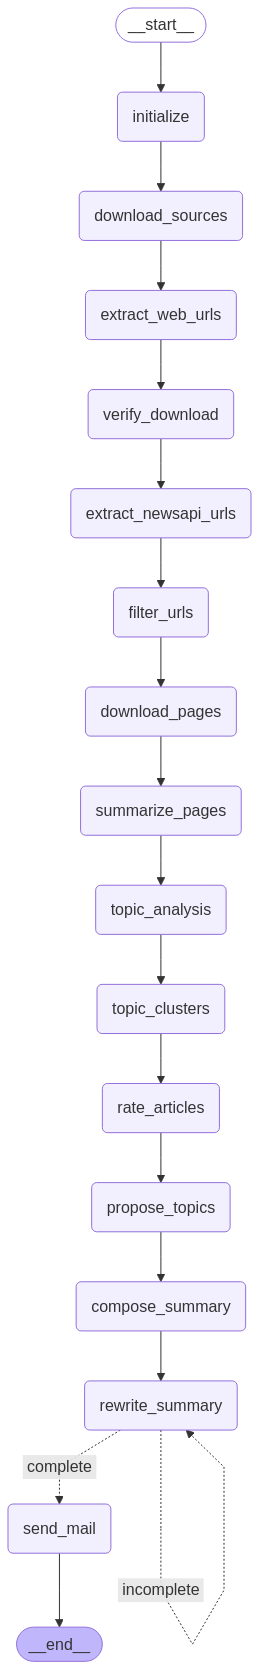

In [8]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

before_date = None
# before_date = '2025-05-22 08:30'
do_download = False

ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1-mini', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'
lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=8)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [26]:
lg_state = lg_agent.initialize_config(lg_state)


2025-05-23 15:54:48,139 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-05-23 15:54:48,140 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars_Technica.html
2025-05-23 15:54:48,140 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-05-23 15:54:48,141 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business_Insider.html
2025-05-23 15:54:48,141 - AInewsbot - INFO - FT -> https://www.ft.com/technology -> FT.html
2025-05-23 15:54:48,141 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly_AI.html
2025-05-23 15:54:48,141 - AInewsbot - INFO - Hacker News 1 -> https://news.ycom

In [27]:
lg_state = lg_agent.download_sources(lg_state)


2025-05-23 15:54:48,861 - AInewsbot - INFO - Web fetch disabled, using existing files in htmldata
2025-05-23 15:54:48,863 - AInewsbot - INFO - Found 16 previously downloaded files
2025-05-23 15:54:48,864 - AInewsbot - INFO - htmldata/Techmeme.html
2025-05-23 15:54:48,864 - AInewsbot - INFO - htmldata/Hacker_News_1.html
2025-05-23 15:54:48,865 - AInewsbot - INFO - htmldata/Reddit.html
2025-05-23 15:54:48,865 - AInewsbot - INFO - htmldata/HackerNoon.html
2025-05-23 15:54:48,865 - AInewsbot - INFO - htmldata/VentureBeat.html
2025-05-23 15:54:48,866 - AInewsbot - INFO - htmldata/Feedly_AI.html
2025-05-23 15:54:48,867 - AInewsbot - INFO - htmldata/The_Register.html
2025-05-23 15:54:48,868 - AInewsbot - INFO - htmldata/FT.html
2025-05-23 15:54:48,868 - AInewsbot - INFO - htmldata/Business_Insider.html
2025-05-23 15:54:48,868 - AInewsbot - INFO - htmldata/Washington_Post.html
2025-05-23 15:54:48,869 - AInewsbot - INFO - htmldata/New_York_Times.html
2025-05-23 15:54:48,869 - AInewsbot - INFO -

In [28]:
lg_state = lg_agent.extract_web_urls(lg_state)


2025-05-23 15:54:52,895 - AInewsbot - INFO - Parsing html files
2025-05-23 15:54:52,904 - AInewsbot - INFO - Ars Technica -> htmldata/Ars_Technica.html
2025-05-23 15:54:52,943 - AInewsbot - INFO - parse_file - found 169 raw links
2025-05-23 15:54:52,946 - AInewsbot - INFO - parse_file - found 29 filtered links
2025-05-23 15:54:52,947 - AInewsbot - INFO - 29 links found
2025-05-23 15:54:52,947 - AInewsbot - INFO - Bloomberg -> htmldata/Bloomberg.html
2025-05-23 15:54:52,968 - AInewsbot - INFO - parse_file - found 246 raw links
2025-05-23 15:54:52,971 - AInewsbot - INFO - parse_file - found 35 filtered links
2025-05-23 15:54:52,972 - AInewsbot - INFO - 35 links found
2025-05-23 15:54:52,972 - AInewsbot - INFO - Business Insider -> htmldata/Business_Insider.html
2025-05-23 15:54:52,991 - AInewsbot - INFO - parse_file - found 217 raw links
2025-05-23 15:54:52,994 - AInewsbot - INFO - parse_file - found 22 filtered links
2025-05-23 15:54:52,994 - AInewsbot - INFO - 22 links found
2025-05-23

In [29]:
# s/b 16 check all sources downloaded, if any got hit by a bot block then download manually

sources_downloaded = len(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(lg_state["sources"].keys()) - set(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']].index )


number of sources in AIdf 16


id
src                  
Ars Technica       27
Bloomberg          32
Business Insider   22
FT                 58
Feedly AI          96
Hacker News 1      22
Hacker News 2      21
HackerNoon         28
New York Times     18
Reddit            126
Techmeme          239
The Register      108
The Verge          28
VentureBeat        40
WSJ                12
Washington Post    38

number of missing sources 0


set()

In [30]:
lg_state = lg_agent.verify_download(lg_state)


2025-05-23 15:55:00,420 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


In [31]:
lg_state = lg_agent.extract_newsapi_urls(lg_state)


2025-05-23 15:55:03,825 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-05-22T15:55:03 from NewsAPI


In [32]:
# filter by headlines that we haven't seen and that look like AI
# we don't want to summarize all before filtering on headline
lg_state = lg_agent.filter_urls(lg_state)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])


2025-05-23 15:55:07,715 - AInewsbot - INFO - Querying SQLite with where_clause: 
2025-05-23 15:55:08,412 - AInewsbot - INFO - URLs in orig_df: 1013
2025-05-23 15:55:08,416 - AInewsbot - INFO - Existing URLs in DB: 263648
2025-05-23 15:55:08,467 - AInewsbot - INFO - New URLs in df filtered by URL: 328
2025-05-23 15:55:08,619 - AInewsbot - INFO - Existing src+title: 38
2025-05-23 15:55:08,620 - AInewsbot - INFO - New URLs in df filtered by src+title: 290
2025-05-23 15:55:08,636 - AInewsbot - INFO - Found 290 unique new headlines
2025-05-23 15:55:08,640 - AInewsbot - INFO - Found 285 unique cleaned new headlines
2025-05-23 15:55:15,302 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 15:55:17,863 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 15:55:17,892 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 15:55:17,

id
src                 
Ars Technica       3
Bloomberg          2
Business Insider   2
FT                 3
Feedly AI         78
Hacker News 1      4
Hacker News 2      1
NewsAPI           52
Techmeme           3
The Register       2
The Verge          1
VentureBeat        1
WSJ                1
Washington Post    1

In [33]:
# download individual articles
lg_state = lg_agent.download_pages(lg_state)


2025-05-23 15:55:20,830 - AInewsbot - INFO - Queuing URLs for scraping
2025-05-23 15:55:20,840 - AInewsbot - INFO - Saving HTML files using async concurrency= 8
2025-05-23 15:55:21,140 - AInewsbot - INFO - Launching browser
2025-05-23 15:55:22,441 - AInewsbot - INFO - Launching workers
2025-05-23 15:55:22,442 - AInewsbot - INFO - Launching worker
2025-05-23 15:55:22,442 - AInewsbot - INFO - from queue: 0, https://biztoc.com/x/12585d0b01a9750c , "How to Create a Meaningful Life in the Age of AI," Professor Jennifer Aaker
2025-05-23 15:55:22,442 - AInewsbot - INFO - fetch_url(https://biztoc.com/x/12585d0b01a9750c)
2025-05-23 15:55:22,459 - AInewsbot - INFO - Launching worker
2025-05-23 15:55:22,460 - AInewsbot - INFO - from queue: 1, https://www.theregister.com/2025/05/22/ditching_us_clouds_for_local/ , 'Close to impossible' for Europe to escape clutches of US hyperscalersBarriers stack up: Datacenter capacity, egress fees, platform skills, variety of cloud services. It won't happen, say

2025-05-23 15:55:52,116 - AInewsbot - INFO - Saving HTML to htmlpages/17_insane_Veo_3_AI_videos_thatll_stop_you_from_trusting_anything_you_see_online.html
2025-05-23 15:55:52,170 - AInewsbot - INFO - from queue: 14, https://www.psychologytoday.com/us/blog/the-algorithmic-mind/202505/ai-weakens-critical-thinking-and-how-to-rebuild-it , AI Weakens Critical Thinking. This Is How to Rebuild It
2025-05-23 15:55:52,171 - AInewsbot - INFO - fetch_url(https://www.psychologytoday.com/us/blog/the-algorithmic-mind/202505/ai-weakens-critical-thinking-and-how-to-rebuild-it)
2025-05-23 15:56:02,276 - AInewsbot - INFO - Waiting 43.88057202700236 seconds to rate limit biztoc.com 0.02115745801711455
2025-05-23 15:56:04,798 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-05-22T16:22:26+00:00
2025-05-23 15:56:04,800 - AInewsbot - INFO - Saving HTML to htmlpages/AI_Melania_Will_Narrate_the_Audiobook_of_Her_Memoir.html
2025-05-23 15:56:04,887 - AInewsbot - I

2025-05-23 15:56:40,404 - AInewsbot - INFO - Waiting 24.373440085061706 seconds to rate limit news.google.com 13.691894624993438
2025-05-23 15:56:43,864 - AInewsbot - INFO - Found last updated time from document.lastModified: 05/24/2025 04:56:43
2025-05-23 15:56:43,864 - AInewsbot - INFO - Saving HTML to htmlpages/Addendum_to_OpenAI_o3_and_o4-mini_system_card__OpenAI_o3_Operator.html
2025-05-23 15:56:43,882 - AInewsbot - INFO - from queue: 25, https://www.businessinsider.com/anthropic-using-ai-job-applications-mike-krieger-2025-5 , Anthropic is reversing its ban on using AI for job applications, an executive says
2025-05-23 15:56:43,883 - AInewsbot - INFO - fetch_url(https://www.businessinsider.com/anthropic-using-ai-job-applications-mike-krieger-2025-5)
2025-05-23 15:56:44,351 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-05-23T18:00:38+08:00
2025-05-23 15:56:44,352 - AInewsbot - INFO - Saving HTML to htmlpages/Alibaba_CEO_doubles_dow

2025-05-23 15:57:36,693 - AInewsbot - INFO - Found last updated time from HTTP header: Fri, 23 May 2025 19:40:11 GMT
2025-05-23 15:57:36,693 - AInewsbot - INFO - Saving HTML to htmlpages/Attention_Wasn_t_All_We_Needed.html
2025-05-23 15:57:36,719 - AInewsbot - INFO - from queue: 34, https://biztoc.com/x/d488377007ac99ab , BCG leader calls for optimism amid AI doom and gloom, says enabling young people to build and shape the future is key
2025-05-23 15:57:36,720 - AInewsbot - INFO - fetch_url(https://biztoc.com/x/d488377007ac99ab)
2025-05-23 15:57:40,301 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-05-22T15:07:15+00:00
2025-05-23 15:57:40,302 - AInewsbot - INFO - Saving HTML to htmlpages/AI_could_account_for_nearly_half_of_data_centre_power_usage_by_end_of_year.html
2025-05-23 15:57:40,319 - AInewsbot - INFO - from queue: 35, http://technode.com/2025/05/23/beyond-expo-2025-former-openai-executive-zack-kass-on-rediscovering-what-it-mean

2025-05-23 15:58:27,291 - AInewsbot - INFO - Waiting 14.820450659606536 seconds to rate limit www.sciencedaily.com 26.591611332987668
2025-05-23 15:58:29,230 - AInewsbot - INFO - Waiting 42.10950953536159 seconds to rate limit news.google.com 0.017468875012127683
2025-05-23 15:58:37,044 - AInewsbot - INFO - Found last updated time from document.lastModified: 05/24/2025 04:58:37
2025-05-23 15:58:37,045 - AInewsbot - INFO - Saving HTML to htmlpages/China_Is_Building_an_AI-Powered_Supercomputer_Network_in_Space.html
2025-05-23 15:58:37,064 - AInewsbot - INFO - from queue: 46, https://www.forbes.com/sites/nokia-industry-40/2025/05/22/could-the-weakest-link-in-your-ai-strategy-be-your-network/ , Could The Weakest Link In Your AI Strategy Be Your Network?
2025-05-23 15:58:37,064 - AInewsbot - INFO - fetch_url(https://www.forbes.com/sites/nokia-industry-40/2025/05/22/could-the-weakest-link-in-your-ai-strategy-be-your-network/)
2025-05-23 15:58:44,439 - AInewsbot - INFO - Found last updated ti

2025-05-23 15:59:28,377 - AInewsbot - INFO - fetch_url(https://www.fastcompany.com/91340107/elon-musk-using-grok-chatbot-doge-analyze-sensitive-data-belonging-millions-americans)
2025-05-23 15:59:28,945 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-02-14T19:05:00+00:00
2025-05-23 15:59:28,946 - AInewsbot - INFO - Saving HTML to htmlpages/Designing_type_inference_for_high_quality_type_errors.html
2025-05-23 15:59:29,224 - AInewsbot - INFO - from queue: 57, https://www.theroot.com/expert-explains-if-ai-as-free-speech-can-be-to-blame-fo-1851781931 , Expert Explains if AI as 'Free Speech' Can Be to Blame for This Florida Boy's Tragic Death
2025-05-23 15:59:29,225 - AInewsbot - INFO - fetch_url(https://www.theroot.com/expert-explains-if-ai-as-free-speech-can-be-to-blame-fo-1851781931)
2025-05-23 15:59:32,158 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-05-23T09:00:00+00:00
2025-05-23 15:59

2025-05-23 16:01:10,157 - AInewsbot - INFO - fetch_url(https://arstechnica.com/google/2025/05/google-home-is-getting-deeper-gemini-integration-and-a-new-widget/)
2025-05-23 16:01:11,453 - AInewsbot - INFO - Waiting 35.21412102857538 seconds to rate limit news.google.com 0.06047695898450911
2025-05-23 16:01:16,507 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-05-23T14:15:00+00:00
2025-05-23 16:01:16,508 - AInewsbot - INFO - Saving HTML to htmlpages/Founders_First__Iliana_Quinonez_of_Google_Cloud_on_AI_agents__infrastructure__and_democratization_at_TechCrunch_Sessions__AI.html
2025-05-23 16:01:16,900 - AInewsbot - INFO - from queue: 68, https://biztoc.com/x/a6e0103b57ce3d27 , Google faces antitrust investigation over deal for AI-fueled chatbots
2025-05-23 16:01:16,900 - AInewsbot - INFO - fetch_url(https://biztoc.com/x/a6e0103b57ce3d27)
2025-05-23 16:01:17,412 - AInewsbot - INFO - Found last updated time from meta tag property=article:pu

2025-05-23 16:03:01,191 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-05-22T18:25:19+00:00
2025-05-23 16:03:01,192 - AInewsbot - INFO - Saving HTML to htmlpages/Google_faces_new_DOJ_antitrust_probe_over_partnership_with_AI_startup__report.html
2025-05-23 16:03:01,279 - AInewsbot - INFO - from queue: 78, https://www.cnet.com/tech/services-and-software/how-to-use-ai-to-manage-your-time-as-a-student/ , How to Use AI to Manage Your Time as a Student
2025-05-23 16:03:01,280 - AInewsbot - INFO - fetch_url(https://www.cnet.com/tech/services-and-software/how-to-use-ai-to-manage-your-time-as-a-student/)
2025-05-23 16:03:08,000 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-05-20
2025-05-23 16:03:08,003 - AInewsbot - INFO - Saving HTML to htmlpages/Google_Beam__Our_AI-first_3D_video_communication_platform.html
2025-05-23 16:03:08,101 - AInewsbot - INFO - from queue: 79, https://www.newsweek.com/i

2025-05-23 16:04:14,316 - AInewsbot - INFO - fetch_url(https://www.macobserver.com/news/kuo-openai-and-jony-ives-io-ai-device-to-launch-in-2027/)
2025-05-23 16:04:17,787 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-05-16T08:23:36-04:00
2025-05-23 16:04:17,788 - AInewsbot - INFO - Saving HTML to htmlpages/Inviting_You_To_Take_This_Important_New_Survey__Can_AI_Help_Close_The_Justice_Gap.html
2025-05-23 16:04:17,842 - AInewsbot - INFO - from queue: 89, https://www.iphoneincanada.ca/2025/05/22/openai-jony-ive-screenless-ai-wearable/ , Kuo: OpenAI, Jony Ive to Launch Screenless AI Wearable in 2027
2025-05-23 16:04:17,842 - AInewsbot - INFO - fetch_url(https://www.iphoneincanada.ca/2025/05/22/openai-jony-ive-screenless-ai-wearable/)
2025-05-23 16:04:21,334 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-05-22T16:55:33.673Z
2025-05-23 16:04:21,335 - AInewsbot - INFO - Saving HTML to htmlpages/

2025-05-23 16:05:39,260 - AInewsbot - INFO - from queue: 98, https://news.google.com/rss/articles/CBMitwFBVV95cUxNVEFUTzkxV2R1N1NaaUdad3ZHdzE3UGtBMWlTTGpMaXlvYk5xQ3dJV3BNS0NyWkR0a3lxQ1pkMTA0V2Z0SFFkMlV2a3pCU2dkcFh2OEdvdWV5OV9FcEJnaWNZNDFaRnl2NnQwVzFqTkljN1JWTTRwN2dpYUM1M2NKVFhHWUtGQ2VsUVdIMFdBXzJrcXhZMk1EVGZncW5qZ1JZSjFYb1hzVzNOdW5GSnhTTlRpNF9iNkU , Microsoft says its Aurora AI can accurately predict air quality, typhoons, and more
2025-05-23 16:05:39,260 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMitwFBVV95cUxNVEFUTzkxV2R1N1NaaUdad3ZHdzE3UGtBMWlTTGpMaXlvYk5xQ3dJV3BNS0NyWkR0a3lxQ1pkMTA0V2Z0SFFkMlV2a3pCU2dkcFh2OEdvdWV5OV9FcEJnaWNZNDFaRnl2NnQwVzFqTkljN1JWTTRwN2dpYUM1M2NKVFhHWUtGQ2VsUVdIMFdBXzJrcXhZMk1EVGZncW5qZ1JZSjFYb1hzVzNOdW5GSnhTTlRpNF9iNkU)
2025-05-23 16:05:50,819 - AInewsbot - INFO - Error fetching https://techcrunch.com/2025/05/23/marjorie-taylor-greene-picked-a-fight-with-grok/: Page.goto: Timeout 60000ms exceeded.
Call log:
  - navigating to "https://t

2025-05-23 16:07:37,432 - AInewsbot - INFO - fetch_url(https://nypost.com/2025/05/23/business/oracle-to-buy-40b-of-nvidia-chips-for-openais-us-data-center-report/)
2025-05-23 16:07:39,127 - AInewsbot - INFO - Found last updated time from document.lastModified: 05/23/2025 23:36:12
2025-05-23 16:07:39,129 - AInewsbot - INFO - Saving HTML to htmlpages/Microsoft_CPO__Students_Should_Keep_Studying_Coding_in_AI_Era.html
2025-05-23 16:07:39,391 - AInewsbot - INFO - from queue: 110, https://www.ft.com/content/a9cd130f-f6bf-4750-98cc-19d87394e657 , Oracle to buy $40bn of Nvidia chips for OpenAIs new US data centre
2025-05-23 16:07:39,395 - AInewsbot - INFO - fetch_url(https://www.ft.com/content/a9cd130f-f6bf-4750-98cc-19d87394e657)
2025-05-23 16:07:52,396 - AInewsbot - INFO - Waiting 40.30230267636113 seconds to rate limit news.google.com 0.0865203750145156
2025-05-23 16:07:55,198 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-05-23T17:43:33+00:

2025-05-23 16:08:58,504 - AInewsbot - INFO - Saving HTML to htmlpages/Proposed_moratorium_on_state-level_AI_regs_aims_to_level_the_playing_field__lawmaker_says.html
2025-05-23 16:08:58,692 - AInewsbot - INFO - from queue: 121, https://www.techradar.com/pro/return-of-the-og-amd-unveils-radeon-ai-pro-r9700-now-a-workstation-class-gpu-with-32gb-gddr6 , Return of the OG? AMD unveils Radeon AI Pro R9700, now a workstation-class GPU with 32GB GDDR6
2025-05-23 16:08:58,697 - AInewsbot - INFO - fetch_url(https://www.techradar.com/pro/return-of-the-og-amd-unveils-radeon-ai-pro-r9700-now-a-workstation-class-gpu-with-32gb-gddr6)
2025-05-23 16:09:03,606 - AInewsbot - INFO - Waiting 41.84386387972884 seconds to rate limit news.google.com 0.048747541004559025
2025-05-23 16:09:09,422 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-05-23T10:18:24-04:00
2025-05-23 16:09:09,423 - AInewsbot - INFO - Saving HTML to htmlpages/Red_Hat_champions_AI_prioritizat

2025-05-23 16:10:03,224 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMieEFVX3lxTE9rWTF3TjQ2eXBPa1RFc1J1Q2ZCZGRaMDNJb0d0TS1SdTFDeWpNYkVaLTFQNUQwMGY2RVJaY3RvV2MtaHhyZldlcGdKaFQ4dklUZm1YbW1heEZwU1FCcFZndENVc3pqZzFxRWRrUnBVR3JEaTFnM2o4aA)
2025-05-23 16:10:03,225 - AInewsbot - INFO - Found last updated time from document.lastModified: 05/24/2025 05:10:03
2025-05-23 16:10:03,225 - AInewsbot - INFO - Saving HTML to htmlpages/Show_HN__I_made_an_infinite_gallery_of_AI-generated_3D_skeuomorphic_icons.html
2025-05-23 16:10:03,260 - AInewsbot - INFO - from queue: 132, https://www.theverge.com/news/673194/tech-ceos-zoom-klarna-replace-earnings , Tech CEOs are using AI to replace themselves
2025-05-23 16:10:03,260 - AInewsbot - INFO - fetch_url(https://www.theverge.com/news/673194/tech-ceos-zoom-klarna-replace-earnings)
2025-05-23 16:10:06,624 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-05-23T17:00:03+00:00
2025-05-23 16:1

2025-05-23 16:11:09,741 - AInewsbot - INFO - Found last updated time from document.lastModified: 05/24/2025 05:11:09
2025-05-23 16:11:09,742 - AInewsbot - INFO - Saving HTML to htmlpages/The_great_AI_jobs_disruption_is_under_way.html
2025-05-23 16:11:09,793 - AInewsbot - INFO - from queue: 142, https://news.google.com/rss/articles/CBMikwFBVV95cUxNZ2tNWlZEamxPdmV0WGozX3NGdkttcEdCdnhWZVlneUtra0tsSXIwMDdNWm5taUtEOGhuV3FfTU1CTl9DODI1MFdVZV9DaGlLamZkX1NWZm51VFFGUS14TWdjXzV6R19vek8tb2R0RGZ0azV1ektCUGJTcmNNbFpDemhqeTFSQkFDc21rSGl4ZVgyTlE , US, allies recommend security protections for AI models
2025-05-23 16:11:09,794 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMikwFBVV95cUxNZ2tNWlZEamxPdmV0WGozX3NGdkttcEdCdnhWZVlneUtra0tsSXIwMDdNWm5taUtEOGhuV3FfTU1CTl9DODI1MFdVZV9DaGlLamZkX1NWZm51VFFGUS14TWdjXzV6R19vek8tb2R0RGZ0azV1ektCUGJTcmNNbFpDemhqeTFSQkFDc21rSGl4ZVgyTlE)
2025-05-23 16:11:26,018 - AInewsbot - INFO - Waiting 42.43191702739927 seconds to rate limit news.google.com

2025-05-23 16:13:43,206 - AInewsbot - INFO - fetch_url(https://superlinked.com/vectorhub/articles/why-do-not-need-re-ranking)
2025-05-23 16:13:44,696 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-05-23T16:30:43+00:00
2025-05-23 16:13:44,697 - AInewsbot - INFO - Saving HTML to htmlpages/You_Are_Not_Prepared_for_This_Terrifying_New_Wave_of_AI-Generated_Videos.html
2025-05-23 16:13:44,777 - AInewsbot - INFO - from queue: 153, https://techcrunch.com/2025/05/22/after-klarna-zooms-ceo-also-uses-an-ai-avatar-on-quarterly-call/ , Zoom CEO Eric Yuan used an AI avatar for his initial comments on Zoom's Q1 earnings call on May 21; Klarna's CEO used an AI avatar to deliver earnings on May 19
2025-05-23 16:13:44,777 - AInewsbot - INFO - fetch_url(https://techcrunch.com/2025/05/22/after-klarna-zooms-ceo-also-uses-an-ai-avatar-on-quarterly-call/)
2025-05-23 16:14:00,633 - AInewsbot - INFO - Waiting 45.48097427899629 seconds to rate limit news.google.

In [34]:
# summarize downloaded pages
lg_state = lg_agent.summarize_pages(lg_state)


2025-05-23 16:18:00,941 - AInewsbot - INFO - Starting summarize
2025-05-23 16:18:00,942 - AInewsbot - INFO - Fetching summaries for all articles
2025-05-23 16:18:00,943 - AInewsbot - INFO - Attempting to fetch summaries for 154 articles
2025-05-23 16:18:00,948 - AInewsbot - INFO - clean_html - Page title: "How to Create a Meaningful Life in the Age of AI," Professor Jennifer Aaker
Social card title: "How to Create a Meaningful Life in the Age of AI," Professor Jennifer Aaker
Social card description: What role does artificial intelligence play in human purpose and meaning? To address this question, Dr. Aaker examines purpose ...

2025-05-23 16:18:01,094 - AInewsbot - INFO - Queuing 0: Page title: "How to Create a Meaningful Life in th...
2025-05-23 16:18:01,108 - AInewsbot - INFO - clean_html - Page title: Europe escaping clutches of US hyperscalers near • The Register
Social card title: Europe escaping clutches of US hyperscalers near
Social card description: : Barriers stack up: Datac

2025-05-23 16:18:01,701 - AInewsbot - INFO - Queuing 16: Page title: AI could account for nearly half of da...
2025-05-23 16:18:01,713 - AInewsbot - INFO - clean_html - Page title: Opinion | Artificial intelligence is coming for your job - The Washington Post
Social card title: Opinion | AI is coming to get you. Better learn to behave.
Social card description: But there are human skills it will not have.

2025-05-23 16:18:01,735 - AInewsbot - INFO - Queuing 17: Page title: Opinion | Artificial intelligence is c...
2025-05-23 16:18:01,746 - AInewsbot - INFO - clean_html - Page title: AI-Driven Marketing for Manufacturing: Strategies for 2025 and Beyond
Social card title: AI-Driven Marketing for Manufacturing: Strategies for 2025 and Beyond
Social card description: Learn how AI-driven marketing strategies give your manufacturing business a competitive edge and streamline your day-to-day operations

2025-05-23 16:18:01,760 - AInewsbot - INFO - Queuing 18: Page title: AI-Driven Marketing f

2025-05-23 16:18:02,757 - AInewsbot - INFO - Queuing 32: Page title: Authors Are Accidentally Leaving AI Pr...
2025-05-23 16:18:02,765 - AInewsbot - INFO - clean_html - Page title: BBAI Stockholders are Notified of the Pending Lead
Social card title: BBAI Stockholders are Notified of the Pending Lead Plaintiff Deadline in the BigBear.ai Holdings, Inc. Class Action – Contact Robbins LLP for Information
Social card description: Robbins LLP is Investigating Allegations that BigBear.ai Holdings, Inc. (BBAI) Has to Restate its Financial Statements ...

2025-05-23 16:18:02,776 - AInewsbot - INFO - Queuing 33: Page title: BBAI Stockholders are Notified of the ...
2025-05-23 16:18:02,781 - AInewsbot - INFO - clean_html - Page title: BCG leader calls for optimism amid AI doom and gloom, says enabling young people to ‘build and shape the future’ is key
Social card title: BCG leader calls for optimism amid AI doom and gloom, says enabling young people to ‘build and shape the future’ is key
Social

2025-05-23 16:18:03,142 - AInewsbot - INFO - Queuing 45: Page title: Could AI understand emotions better th...
2025-05-23 16:18:03,160 - AInewsbot - INFO - clean_html - Page title: Could The Weakest Link In Your AI Strategy Be Your Network?
Social card title: Could The Weakest Link In Your AI Strategy Be Your Network?
Social card description: Many nations are driven to dominate in AI leadership, recognizing the economic and strategic benefits of country-led investment.

2025-05-23 16:18:03,187 - AInewsbot - INFO - Queuing 46: Page title: Could The Weakest Link In Your AI Stra...
2025-05-23 16:18:03,219 - AInewsbot - INFO - clean_html - Page title: Cuts Could Leave AI in Charge of Wine | Wine-Searcher News & Features
Social card title: Cuts Could Leave AI in Charge of Wine | Wine-Searcher News & Features
Social card description: Federal cutbacks have left the agency charged with regulating wine, beer and spirits facing a huge workload. Read the latest wine news & features on wine-search

2025-05-23 16:18:03,877 - AInewsbot - INFO - Queuing 62: Page title: RHEL 10: Leading the future with AI, s...
2025-05-23 16:18:03,897 - AInewsbot - INFO - clean_html - Page title: Gen Z Would Rather Ask Chat GPT for Help Than Their Boss - Newsweek
Social card title: Gen Z would rather ask Chat GPT for help than their boss
Social card description: According to a new report from Resume.org, 49 percent of Gen Zers say they rely more on Chat GPT for help than their boss.

2025-05-23 16:18:03,927 - AInewsbot - INFO - Queuing 63: Page title: Gen Z Would Rather Ask Chat GPT for He...
2025-05-23 16:18:03,940 - AInewsbot - INFO - clean_html - Page title: Generative AI Is Sparking Entirely New Industries – Business
Social card title: Generative AI Is Sparking Entirely New Industries
Social card description: Generative AI is a groundbreaking force that not only disrupts traditional sectors but also gives rise to entirely new industries.

2025-05-23 16:18:03,956 - AInewsbot - INFO - Queuing 64: P

2025-05-23 16:18:04,695 - AInewsbot - INFO - Queuing 80: Page title: In Test, A.I. Weather Model Fails to P...
2025-05-23 16:18:04,711 - AInewsbot - INFO - clean_html - Page title: Inside Anthropic’s First Developer Day, Where AI Agents Took Center Stage | WIRED
Social card title: Inside Anthropic’s First Developer Day, Where AI Agents Took Center Stage
Social card description: Anthropic CEO Dario Amodei said everything human workers do now will eventually be done by AI systems.

2025-05-23 16:18:04,742 - AInewsbot - INFO - Queuing 81: Page title: Inside Anthropic’s First Developer Day...
2025-05-23 16:18:04,757 - AInewsbot - INFO - clean_html - Page title: Intel Debuts Xeon 6 CPUs with Up to 128 P-Cores, Powering NVIDIA DGX B300 - StorageReview.com
Social card title: Intel Debuts Xeon 6 CPUs with Up to 128 P-Cores, Powering NVIDIA DGX B300
Social card description: Intel Xeon 6 CPUs feature up to 128 P-cores, Priority Core Turbo, and SST-TF, delivering AI, data center, and telecom perf

2025-05-23 16:18:05,382 - AInewsbot - INFO - Queuing 98: Page title: Microsoft says its Aurora AI can accur...
2025-05-23 16:18:05,393 - AInewsbot - INFO - clean_html - Page title: Mistral AI's Le Chat Enterprise and Mistral OCR 25.05 on Google Cloud | Google Cloud Blog
Social card title: Mistral AI's Le Chat Enterprise and Mistral OCR 25.05 on Google Cloud | Google Cloud Blog
Social card description: Announcing Mistral AI’s Le Chat Enterprise and Mistral OCR 25.05 model are available on Google Cloud.

2025-05-23 16:18:05,408 - AInewsbot - INFO - Queuing 99: Page title: Mistral AI's Le Chat Enterprise and Mi...
2025-05-23 16:18:05,435 - AInewsbot - INFO - clean_html - Page title: Most AI chatbots devour your user data - these are the worst offenders | ZDNET
Social card title: Most AI chatbots devour your user data - these are the worst offenders
Social card description: The greediest AI of all gobbles up 90% of user data types - far more than most. Take a wild guess which one it is.

2

2025-05-23 16:18:06,272 - AInewsbot - INFO - clean_html - Page title: PiLogic raises $4M to build precision AI models for space applications - SiliconANGLE
Social card title: PiLogic raises $4M to build precision AI models for space applications - SiliconANGLE
Social card description: PiLogic raises $4M to build precision AI models for space applications - SiliconANGLE

2025-05-23 16:18:06,292 - AInewsbot - INFO - Queuing 114: Page title: PiLogic raises $4M to build precision ...
2025-05-23 16:18:06,301 - AInewsbot - INFO - clean_html - Page title: LLM Judges Are Unreliable  — The Collective Intelligence Project
Social card title: LLM Judges Are Unreliable  — The Collective Intelligence Project
Social card description: When Large Language Models are used as judges for decision-making across various sensitive domains, they consistently exhibit unpredictable and hidden measurement biases, making their verdicts unreliable despite common prompt engineering practices.

2025-05-23 16:18:06,3

2025-05-23 16:18:06,832 - AInewsbot - INFO - Queuing 129: Page title: [2504.05652] Sugar-Coated Poison: Beni...
2025-05-23 16:18:06,853 - AInewsbot - INFO - clean_html - Page title: Survey says most Gen Z-ers would marry an AI, but I've got more faith in Gen Z | TechRadar
Social card title: Marry an AI? Gen Z might say yes according to a survey, but they really shouldn't
Social card description: A marriage made in ones and zeros

2025-05-23 16:18:06,893 - AInewsbot - INFO - Queuing 130: Page title: Survey says most Gen Z-ers would marry...
2025-05-23 16:18:06,911 - AInewsbot - INFO - clean_html - Page title: SynthID Detector: Identify content made with Google’s AI tools
Social card title: SynthID Detector — a new portal to help identify AI-generated content
Social card description: Learn about the new SynthID Detector portal we announced at I/O to help people understand how the content they see online was generated.

2025-05-23 16:18:06,930 - AInewsbot - INFO - Queuing 131: Page title:

2025-05-23 16:18:07,691 - AInewsbot - INFO - Queuing 145: Page title: What AI Can’t Read: Ambiguities and Si...
2025-05-23 16:18:07,708 - AInewsbot - INFO - clean_html - Page title: Pixel 10 was missing from I/O 2025, but Google gave a glimpse of its future | Digital Trends
Social card title: What Google’s I/O 2025 keynote tells us about the Google Pixel 10
Social card description: Google's I/O event was all about AI and Android, but indirectly, it hinted at a very different direction for the upcoming Pixel 10 series smartphones.

2025-05-23 16:18:07,723 - AInewsbot - INFO - Queuing 146: Page title: Pixel 10 was missing from I/O 2025, bu...
2025-05-23 16:18:07,723 - AInewsbot - INFO - No path for 147
2025-05-23 16:18:07,734 - AInewsbot - INFO - clean_html - Page title: Why enterprise RAG systems fail: Google study introduces 'sufficient context' solution | VentureBeat
Social card title: Why enterprise RAG systems fail: Google study introduces ‘sufficient context’ solution
Social card d

2025-05-23 16:18:11,998 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:12,003 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:12,010 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:12,032 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:12,036 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:12,100 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:12,107 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:12,147 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:12,153 - httpx 

2025-05-23 16:18:13,124 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:13,139 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:13,145 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:13,197 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:13,266 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:13,279 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:13,301 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:13,330 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:13,343 - httpx 

2025-05-23 16:18:15,473 - AInewsbot - INFO - Summary for 4 (length 2865): - Google unveiled Veo 3, a groundbreaking AI video generation model, at I/O 2025, capable of creating highly realistic videos with synchronized audio, background noise, and dialogue, maintaining consistency in characters and scenes.  
- Veo 3's AI-generated clips have gone viral online due to their near-indistinguishable realism compared to genuine videos, raising concerns about trust and misinformation.  
- Veo 3 is available through Google's Gemini AI Ultra plan at $250/month, which includes access to all of Google's frontier AI models, allowing users to create advanced AI videos from text prompts.
2025-05-23 16:18:15,473 - AInewsbot - INFO - Summary for 6 (length 14263): - The article provides an overview of text vectorization and word embedding techniques in natural language processing (NLP), explaining how they convert words into numerical representations that capture meaning and context for machine learning

2025-05-23 16:18:15,476 - AInewsbot - INFO - Summary for 16 (length 1379): - Artificial intelligence systems are projected to consume nearly half of data centre power usage by the end of 2025, according to analysis by Alex de Vries-Gao.  
- By the end of the decade, AI energy consumption is forecasted to rival the total current energy usage of Japan.
2025-05-23 16:18:15,476 - AInewsbot - INFO - Summary for 17 (length 542): - The article argues that artificial intelligence (AI) is rapidly advancing and will increasingly replace human jobs, emphasizing the urgency for individuals to adapt.
- It highlights that despite AI's capabilities, there are uniquely human skills that AI cannot replicate.
- The author adopts a cautious stance on AI, referencing their own partial reluctance to fully embrace the technology.
2025-05-23 16:18:15,477 - AInewsbot - INFO - Summary for 18 (length 8782): - AI is revolutionizing marketing in manufacturing by enabling personalized customer engagement, optimize

2025-05-23 16:18:15,480 - AInewsbot - INFO - Summary for 29 (length 3451): - At TechCrunch Sessions: AI on June 5 at UC Berkeley, Artemis Seaford (Head of AI Safety, ElevenLabs) and Ion Stoica (co-founder of Databricks and UC Berkeley professor) will discuss the urgent ethical challenges posed by generative AI, including deception risks and safety measures.  
- Seaford focuses on media authenticity and abuse prevention with experience from OpenAI and Meta, while Stoica offers a systems-level perspective, having contributed to key AI infrastructure projects like Spark and Ray, emphasizing responsible AI scaling.  
- The event will feature industry leaders from OpenAI, Google Cloud, Anthropic, and Cohere, offering expert insights, workshops, and networking aimed at addressing ethical blind spots and integrating safety into AI development and regulation.
2025-05-23 16:18:15,480 - AInewsbot - INFO - Summary for 30 (length 42883): - The paper examines bias in AI chatbots, focusing on ethica

2025-05-23 16:18:15,482 - AInewsbot - INFO - Summary for 40 (length 712): - Google's long-standing dominance in search is being challenged by the rise of AI chatbots, marking the first significant threat to its monopoly in a generation.  
- After two years of unsuccessful attempts to adapt, Google is actively working to regain its leading position in the evolving search landscape.  
- The article highlights the critical moment for Google as it strives to innovate and respond to new AI-driven competition in the search market.
2025-05-23 16:18:15,483 - AInewsbot - INFO - Summary for 41 (length 11950): - The article explores how interactions with AI, exemplified by the calm and composed dynamic between Dave and HAL 9000 in "2001: A Space Odyssey," might influence humans toward greater patience, emotional regulation, and ethical behavior by modeling non-retaliation and moral discipline.
- AI can act as a moral feedback loop, encouraging users to adopt respectful and constructive communicat

2025-05-23 16:18:15,485 - AInewsbot - INFO - Summary for 51 (length 31607): - The article discusses the challenges and design principles for creating high-quality type error messages in programming languages with type inference, highlighting that poor error messages are often due to language design choices rather than inherent issues with type inference itself.  
- Key rules proposed include avoiding guesswork and backtracking in typechecking to prevent bloated and confusing error messages, not prematurely deciding which type is correct to present clearer conflicts, and involving the user by suggesting explicit type annotations to clarify intent and narrow down errors.  
- The author presents PolySubML, an experimental language designed with these principles, featuring detailed error messages that track conflicting type origins and provide helpful hints for annotation, and argues that these strategies can drastically improve type error quality without sacrificing the benefits of global

2025-05-23 16:18:15,487 - AInewsbot - INFO - Summary for 61 (length 3712): - Iliana Quinonez, Director of North America Startups Customer Engineering at Google Cloud, will discuss scaling AI startups and practical strategies for building AI infrastructure at TechCrunch Sessions: AI on June 5 at UC Berkeley.  
- Quinonez draws on over 20 years of experience with companies like Salesforce and SAP, offering insights on architecture, data pipelines, model orchestration, and the balance between speed, security, and democratization in AI development.  
- The event features leaders from OpenAI, Anthropic, Cohere, and Google Cloud, focusing on actionable frameworks for AI startups to scale effectively from pre-seed to IPO stages.
2025-05-23 16:18:15,488 - AInewsbot - INFO - Summary for 62 (length 4577): - Red Hat Enterprise Linux (RHEL) 10 introduces advanced features focusing on AI integration, enhanced security with quantum-resistant algorithms, containerization, and hybrid cloud support, po

2025-05-23 16:18:15,489 - AInewsbot - INFO - Summary for 72 (length 2533): - Google launched Veo 3, an AI video synthesis model capable of generating synchronized audio, including voices and sound effects, in high-definition eight-second clips—a first for major AI video generators.  
- Veo 3 was tested on the popular AI "spaghetti eating" benchmark featuring a Will Smith double; while the video was visually impressive, the audio produced an unintended crunching sound due to glitches in the sound effect synthesis.  
- The glitch likely results from Veo 3's training data overrepresenting certain chewing sounds, illustrating the challenges AI models face when generating realistic audio-visual content from uneven datasets.
2025-05-23 16:18:15,489 - AInewsbot - INFO - Summary for 73 (length 12263): - Researchers developed a large-scale AI system using machine learning to detect political bias in online news outlets by analyzing topic selection, tone, and coverage patterns, achieving 76% acc

2025-05-23 16:18:15,491 - AInewsbot - INFO - Summary for 83 (length 1477): - A new survey, launched at the Equal Justice Conference and partnered by Everlaw for Good, the National Legal Aid & Defender Association, and Paladin, invites legal aid and nonprofit legal professionals to share their views on the impact of AI in legal services, especially in housing, family law, and employment disputes.  
- The survey aims to explore opportunities and challenges of AI in improving access to justice and consists of 10 questions, taking under five minutes to complete.  
- Everlaw will donate $10 to NLADA for each completed survey response, up to 100 responses, emphasizing the importance of input from those directly involved in legal service delivery.
2025-05-23 16:18:15,491 - AInewsbot - INFO - Summary for 84 (length 4512): - A California federal judge, William Alsup, indicated that while Anthropic PBC likely violated copyright law by initially copying pirated books, its subsequent use of those 

2025-05-23 16:18:15,493 - AInewsbot - INFO - Summary for 95 (length 3344): - Microsoft has integrated AI-powered Copilot features into the classic Windows Notepad app, enabling users to generate, review, and refine text using AI, requiring a Microsoft account login to access these capabilities.  
- This update follows a trend of adding AI to built-in Windows apps like Paint and Outlook, though the usefulness of AI in Notepad—a simple text editor mainly used for quick notes and plain text manipulation—has been questioned.  
- Notepad, which has seen minimal changes since Windows 1.0, is now undergoing significant enhancements including generative AI functions introduced over the past year, reflecting Microsoft's broader push to embed AI throughout its software ecosystem.
2025-05-23 16:18:15,494 - AInewsbot - INFO - Summary for 96 (length 3344): - Microsoft has integrated AI-powered Copilot features into the classic Notepad app, allowing users to generate, refine, and insert text via AI 

2025-05-23 16:18:15,496 - AInewsbot - INFO - Summary for 107 (length 2810): - OpenAI is upgrading its Operator AI agent to use the new o3 model, an advanced reasoning model that improves on math and reasoning tasks compared to the previous GPT-4o-based version.  
- The o3 Operator model has been fine-tuned with additional safety data to better manage decision boundaries on user confirmations and refusals, reducing risks like prompt injection attacks and misuse for illicit activities.  
- Operator is a cloud-hosted virtual agent that can autonomously browse the web and use software, joining a growing field of AI agents from companies like Google and Anthropic that perform computerized tasks with minimal supervision.
2025-05-23 16:18:15,496 - AInewsbot - INFO - Summary for 108 (length 2810): - OpenAI is upgrading the AI model powering its Operator agent from a custom GPT-4o to a more advanced model called o3, part of its latest reasoning-focused "o" series, which excels in tasks involvin

2025-05-23 16:18:15,498 - AInewsbot - INFO - Summary for 118 (length 5363): - Red Hat has introduced the AI Inference Server and vLLM project to unify AI infrastructure, enabling scalable, secure, and consistent deployment of machine learning models across hybrid cloud environments.
- Brian Stevens, Red Hat's AI CTO, described the Inference Server as the "core," likening it to Linux, serving as the glue layer that allows innovation and accelerators to seamlessly reach users.
- The vLLM project supports large language model deployment with Kubernetes integration and hybrid cloud support, while Red Hat leverages Meta’s Llama Stack to build enterprise-ready AI agents through its OpenShift AI platform.
2025-05-23 16:18:15,498 - AInewsbot - INFO - Summary for 119 (length 2894): - Apple is accelerating its plans to release AI-powered smart glasses by the end of 2025, aiming to compete with Meta's Ray-Ban smart glasses, with large-scale prototype production starting by the end of 2024.  
- Th

2025-05-23 16:18:15,500 - AInewsbot - INFO - Summary for 130 (length 6364): - A survey by Joi AI claims that 80% of Gen Z respondents would consider marrying an AI partner, with 83% saying they could build a deep emotional bond with an AI, though the survey's credibility and details remain unconfirmed.  
- Experts like psychiatrist Dr. Sue Varma emphasize that while loneliness drives some towards AI companionship, meaningful and mutual human connections cannot be replaced by AI, which offers affirming but ultimately non-real relationships.  
- Despite growing AI conversational sophistication, public sentiment (per informal polls) shows skepticism about AI marriage, and commentary stresses using AI to support rather than substitute genuine human relationships.
2025-05-23 16:18:15,500 - AInewsbot - INFO - Summary for 131 (length 4306): - Google announced the SynthID Detector, a new verification portal that identifies AI-generated content created with Google's AI tools by detecting imperc

2025-05-23 16:18:15,507 - AInewsbot - INFO - Summary for 141 (length 3310): - UBS is using AI tools from OpenAI and Synthesia to create avatar videos of analysts explaining their research notes, aiming to fully automate the video production process by the end of the year.  
- Currently, 36 analysts across various sectors volunteer for the initiative, responding to increasing client demand for video content to digest research insights.  
- Scott Solomon, head of global research technology at UBS, emphasized the integration of avatars into analysts' standard toolkit and the goal to generate videos automatically alongside published reports, enhancing client engagement without overwhelming video volume.
2025-05-23 16:18:15,507 - AInewsbot - INFO - Summary for 142 (length 3001): - The U.S., Australia, New Zealand, and the U.K. have jointly issued security guidance recommending AI developers protect training data from tampering and limit access to AI infrastructure to safeguard critical syst

2025-05-23 16:18:15,508 - AInewsbot - INFO - Summary for 153 (length 1517): - Zoom CEO Eric Yuan used a custom AI avatar for his initial comments during the company's quarterly earnings call, following Klarna CEO's similar use of an AI avatar earlier in the week.  
- Yuan stated, "I am proud to be among the first CEOs to use an avatar in an earnings call," highlighting Zoom's commitment to advancing communication and collaboration with AI while emphasizing strong safeguards for trust and security.  
- Zoom announced it will make the custom avatar feature available to all users this week, continuing its push toward digital twin technology and AI integration in meetings.
2025-05-23 16:18:15,509 - AInewsbot - INFO - Received 150 summaries


In [35]:
# extract topics from summaries
# AI prompt to free-form ask what topics are covered
# followed by a series of structured AI prompts to ask if popular topics are covered
# use gpt-4o mini always, google flash 2.0 has a problem with this for some reason, get pydantic validation errors
# not sure why it works for summarize and filter but not here
# tested query in AI studio and it works, works with json parser but not structured output
lg_state = lg_agent.topic_analysis(lg_state, model_str='gpt-4o-mini')


2025-05-23 16:18:15,545 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-23 16:18:20,646 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:23,166 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:23,536 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:23,773 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:23,828 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:24,397 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:24,729 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:

2025-05-23 16:18:25,839 - AInewsbot - INFO - Canonical topic china
2025-05-23 16:18:25,839 - AInewsbot - INFO - Canonical topic gen z
2025-05-23 16:18:25,839 - AInewsbot - INFO - Canonical topic quantum computing
2025-05-23 16:18:25,839 - AInewsbot - INFO - Canonical topic retrieval augmented generation
2025-05-23 16:18:25,839 - AInewsbot - INFO - Canonical topic streaming
2025-05-23 16:18:25,840 - AInewsbot - INFO - Canonical topic agriculture
2025-05-23 16:18:25,840 - AInewsbot - INFO - Canonical topic products
2025-05-23 16:18:25,841 - AInewsbot - INFO - Canonical topic oracle
2025-05-23 16:18:25,841 - AInewsbot - INFO - Canonical topic job automation
2025-05-23 16:18:25,841 - AInewsbot - INFO - Canonical topic ai hardware
2025-05-23 16:18:25,841 - AInewsbot - INFO - Canonical topic speech recognition & synthesis
2025-05-23 16:18:25,841 - AInewsbot - INFO - Canonical topic recommendation systems
2025-05-23 16:18:25,841 - AInewsbot - INFO - Canonical topic ai regulation
2025-05-23 16

2025-05-23 16:18:34,472 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:34,472 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:34,473 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:34,473 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:34,474 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:34,475 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:34,475 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:34,476 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:34,476 - httpx 

2025-05-23 16:18:35,821 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:35,822 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:35,822 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:35,823 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:35,823 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:35,824 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:35,824 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:35,825 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:35,825 - httpx 

2025-05-23 16:18:35,858 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:35,858 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:35,859 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:35,859 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:35,860 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:35,861 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:35,861 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:35,862 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:35,862 - httpx 

2025-05-23 16:18:36,255 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,255 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,256 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,256 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,257 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,257 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,258 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,259 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,259 - httpx 

2025-05-23 16:18:36,299 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,302 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,309 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,312 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,313 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,314 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,315 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,316 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,316 - httpx 

2025-05-23 16:18:36,356 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,357 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,357 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,358 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,358 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,359 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,360 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,361 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,362 - httpx 

2025-05-23 16:18:36,540 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,541 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,542 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,543 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,544 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,544 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,545 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,546 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,547 - httpx 

2025-05-23 16:18:36,593 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,595 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,597 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,599 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,600 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,601 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,602 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,603 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,605 - httpx 

2025-05-23 16:18:36,656 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,657 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,658 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,658 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,659 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,659 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,782 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,783 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,784 - httpx 

2025-05-23 16:18:36,821 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,822 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,822 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,823 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,823 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,824 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,824 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,825 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,825 - httpx 

2025-05-23 16:18:36,859 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,860 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,860 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,861 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,862 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,862 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,863 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,863 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,864 - httpx 

2025-05-23 16:18:36,985 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,986 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,986 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,987 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,987 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,988 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,989 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,989 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:36,990 - httpx 

2025-05-23 16:18:37,098 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:37,098 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:37,099 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:37,100 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:37,101 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:37,101 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:37,102 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:37,102 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:37,103 - httpx 

2025-05-23 16:18:37,184 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:37,184 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:37,185 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:37,220 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:37,220 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:37,221 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:37,223 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:37,223 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:37,224 - httpx 

2025-05-23 16:18:37,990 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:37,990 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:38,010 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:38,078 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:38,121 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:38,157 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:38,176 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:38,180 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:38,181 - httpx 

2025-05-23 16:18:41,357 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:41,359 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:41,363 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:41,371 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:41,383 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:41,385 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:41,389 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:41,392 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:41,395 - httpx 

2025-05-23 16:18:42,905 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:42,935 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:42,973 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:43,044 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:43,051 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:43,117 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:43,147 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:43,160 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:43,171 - httpx 

2025-05-23 16:18:45,056 - AInewsbot - INFO - Queuing 51: ### <<<ARTICLE SUMMARY>>>
# Designing type inferen...
2025-05-23 16:18:45,056 - AInewsbot - INFO - Queuing 52: ### <<<ARTICLE SUMMARY>>>
# Developers aren't thri...
2025-05-23 16:18:45,057 - AInewsbot - INFO - Queuing 53: ### <<<ARTICLE SUMMARY>>>
# Discord SVP Peter Sell...
2025-05-23 16:18:45,057 - AInewsbot - INFO - Queuing 54: ### <<<ARTICLE SUMMARY>>>
# DoorDash scraps its AI...
2025-05-23 16:18:45,057 - AInewsbot - INFO - Queuing 55: ### <<<ARTICLE SUMMARY>>>
# Drone startup surveyin...
2025-05-23 16:18:45,057 - AInewsbot - INFO - Queuing 56: ### <<<ARTICLE SUMMARY>>>
# Elon Musks DOGE team i...
2025-05-23 16:18:45,057 - AInewsbot - INFO - Queuing 57: ### <<<ARTICLE SUMMARY>>>
# Expert Explains if AI ...
2025-05-23 16:18:45,057 - AInewsbot - INFO - Queuing 58: ### <<<ARTICLE SUMMARY>>>
# First Lady Melania Tru...
2025-05-23 16:18:45,058 - AInewsbot - INFO - Queuing 59: ### <<<ARTICLE SUMMARY>>>
# For DOD, the future of...
2

2025-05-23 16:18:45,067 - AInewsbot - INFO - Queuing 125: ### <<<ARTICLE SUMMARY>>>
# Shopify just dropped 1...
2025-05-23 16:18:45,067 - AInewsbot - INFO - Queuing 126: ### <<<ARTICLE SUMMARY>>>
# Show HN: I made an inf...
2025-05-23 16:18:45,067 - AInewsbot - INFO - Queuing 127: ### <<<ARTICLE SUMMARY>>>
# Someone Made an Actual...
2025-05-23 16:18:45,067 - AInewsbot - INFO - Queuing 128: ### <<<ARTICLE SUMMARY>>>
# Sources: Oracle will b...
2025-05-23 16:18:45,068 - AInewsbot - INFO - Queuing 129: ### <<<ARTICLE SUMMARY>>>
# Sugar-Coated Poison: B...
2025-05-23 16:18:45,068 - AInewsbot - INFO - Queuing 130: ### <<<ARTICLE SUMMARY>>>
# Survey says most Gen Z...
2025-05-23 16:18:45,068 - AInewsbot - INFO - Queuing 131: ### <<<ARTICLE SUMMARY>>>
# SynthID Detector  a ne...
2025-05-23 16:18:45,068 - AInewsbot - INFO - Queuing 132: ### <<<ARTICLE SUMMARY>>>
# Tech CEOs are using AI...
2025-05-23 16:18:45,068 - AInewsbot - INFO - Queuing 133: ### <<<ARTICLE SUMMARY>>>
# TechCrunch Mobilit

async_langchain: 0, {'input_text': '### <<<ARTICLE SUMMARY>>>\n# "How to Create a Meaningful Life in the Age of AI," Professor Jennifer Aaker\n\n- Professor Jennifer Aaker explores the role of artificial intelligence in shaping human purpose and meaning in her presentation "How to Create a Meaningful Life in the Age of AI."  \n- The discussion focuses on the impact of AI on individuals\' sense of purpose and how to maintain meaningful human experiences amidst technological advances.  \n- The presentation was shared on YouTube on May 22, 2025.\n### <<<END>>>\n### <<<CANDIDATE TOPICS>>>\nAI And Human Purpose, AI Applications, AI Capabilities, AI Ethics, AI Integration, Cognitive Science, Consciousness, Ethics, Gen AI, Generative AI, Human Interaction, Meaningful Experiences In Technology, Opinion, Professor Jennifer Aaker, Singularity, Society & Culture\n### <<<END>>>\n'}
async_langchain: 1, {'input_text': "### <<<ARTICLE SUMMARY>>>\n# 'Close to impossible' for Europe to escape clutches 

2025-05-23 16:18:46,385 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:46,607 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:46,795 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:46,892 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 0 response: items=['AI And Human Purpose', 'Meaningful Experiences In Technology', 'Society & Culture', 'AI Ethics']
async_langchain: 1 response: items=['Cloud Service Challenges', 'Digital Sovereignty', 'European Cloud Market', 'US Hyperscalers', 'Tech Infrastructure']
async_langchain: 75 response: items=['AI Regulation', 'Policy Opposition', 'Individual Rights', 'Politics', 'House Bill', 'Senator Josh Hawley']


2025-05-23 16:18:46,946 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:47,028 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:47,034 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:47,081 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:47,094 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 73 response: items=['Bias Detection', 'Political Bias', 'Online News', 'Machine Learning', 'AI Applications', 'Disinformation', 'Large Language Models']
async_langchain: 20 response: items=['Adobe Pricing Strategy', 'AI Subscription Plans', 'Creative Cloud Pro', 'Creative Software Market', 'North America']
async_langchain: 98 response: items=['Microsoft Aurora AI', 'Weather Prediction Accuracy', 'Forecasting Technology', 'AI Applications', 'Environmental Monitoring', 'Model Training', 'Open Source']
async_langchain: 9 response: items=['AI In Career Advancement', 'Hr Technology Trends', 'Job Application Optimization', 'JobFit AI', 'Jobs & Careers', 'AI Applications', 'Generative AI']
async_langchain: 27 response: items=['AI Manipulation Risks', 'AI Ethics', 'AI Safety', 'Claude Opus 4', 'Anthropic']
async_langchain: 78 response: items=['AI Tools for Students', 'Time Management', 'Mental Well-Being', 'Academic Performance', 'AI Chatbots', 'AI Applications', 'Assignment P

2025-05-23 16:18:47,158 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:47,166 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:47,174 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:47,196 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:47,210 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:47,239 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:47,260 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:47,264 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:47,266 - httpx 

async_langchain: 7 response: items=['Apple Intelligence', 'AI Capabilities', 'Product Delays', 'Virtual & Augmented Reality', 'Apple Product Development']
async_langchain: 111 response: items=['AI In Workforce', 'Employment Changes', 'Job Automation', 'CEO Statements', 'IBM', 'Quantum Computing', 'Software Development']
async_langchain: 103 response: items=['Open Source AI', 'Meta', 'Linux Foundation', 'Licensing Issues', 'AI Model Comparison', 'Economics']
async_langchain: 48 response: items=['AI Applications', 'Email Classification', 'Federal Communication', 'Government Efficiency', 'Meta AI', 'Innovation']
async_langchain: 33 response: items=['Accounting Errors', 'BigBear.ai', 'Class Action Lawsuit', 'Financial Statements', 'Legal Issues', 'Shareholder Rights', 'Stocks']
async_langchain: 16 response: items=['AI Power Consumption', 'Data Centers', 'Energy Usage Projections', 'Sustainability', 'Japan']
async_langchain: 38 response: items=['AI-Generated Content', 'Brand Reputation', 'C

2025-05-23 16:18:47,373 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:47,416 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:47,467 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:47,471 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:47,487 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:47,494 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:47,516 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:47,530 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:47,541 - httpx 

async_langchain: 14 response: items=['AI and Critical Thinking', 'Cognitive Offloading', 'Educational Strategies Against AI Reliance', 'Generative AI', 'Analytical Thinking']
async_langchain: 22 response: items=['AI Agent Performance', 'Claude 4 AI Models', 'Anthropic', 'Innovation', 'Generative AI', 'OpenAI']
async_langchain: 3 response: items=['AI Quotes Collection', 'AI Ethics', 'AI Regulation', 'Ethical Challenges of AI', 'Impact of AI on Society', 'Innovation']
async_langchain: 124 response: items=['AI Demand', 'Carbon Crisis', 'Data Storage', 'HDD Technology', 'Sustainability', 'Seagate']
async_langchain: 60 response: items=['AI Analytics', 'Digital Transformation', "Hardee's Franchise", 'Operational Efficiency', 'Customer Service', 'Innovation', 'Real-Time Data']
async_langchain: 57 response: items=['AI Ethics', 'Legal Implications', 'Wrongful Death Lawsuit', 'Mental Health', 'AI Speech', 'Character Technologies', 'User Trust']
async_langchain: 63 response: items=['AI Applicatio

2025-05-23 16:18:47,584 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:47,616 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:47,620 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:47,636 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:47,639 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:47,646 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:47,662 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:47,664 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:47,679 - httpx 

async_langchain: 79 response: items=['AI Regulation', 'Education', 'Higher Education', 'Teaching Regulations', 'Politics', 'Illinois']
async_langchain: 119 response: items=['AI Smart Glasses', 'Apple', 'AI Capabilities', 'New Product Development', 'Competitor Analysis', 'Innovation', 'Vision Products Group']
async_langchain: 91 response: items=['Politics']
async_langchain: 24 response: items=['AI Infrastructure', 'CoreWeave', 'Financial Forecasts', 'Nvidia', 'OpenAI', 'Stock Surge', 'Investment Risk']
async_langchain: 115 response: items=['AI Biases', 'AI Regulation', 'Decision-Making', 'Large Language Models', 'Bias and Fairness', 'Ethical Implications', 'AI Safety']
async_langchain: 6 response: items=['Natural Language Processing Techniques', 'Text Vectorization', 'Word Embedding', 'Machine Learning Models', 'Language Models']
async_langchain: 74 response: items=['AMD', 'Ryzen AI Max+ 395', 'AI Hardware', 'Hardware Issues', 'Performance Switch', 'PC Specs', 'Products']
async_langchai

2025-05-23 16:18:47,779 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:47,781 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:47,783 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:47,784 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:47,785 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:47,786 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:47,794 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:47,796 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:47,797 - httpx 

async_langchain: 152 response: items=['Multimodal Search', 'Query-Time Weighting', 'Search Efficiency', 'Superlinked Framework', 'Vector Search']
async_langchain: 95 response: items=['AI Integration', 'Microsoft Notepad AI Integration', 'Generative AI', 'AI In Productivity Tools', 'Windows Apps AI Enhancements']
async_langchain: 132 response: items=['AI Avatars', 'AI Integration', 'Digital Twins', 'Earnings Reports', 'Innovation', 'Job Automation', 'Virtual Presentations']
async_langchain: 47 response: items=['AI Regulation', 'Wine Regulations', 'Legal Challenges', 'Government Efficiency', 'Jobs & Careers', 'Policy and Regulation']
async_langchain: 147 response: items=['Human Interaction']
async_langchain: 106 response: items=['AI Hardware', 'Pocket-Sized AI Devices', 'Everyday AI', 'Social Media Platform', 'Innovation', 'Jony Ive', 'OpenAI']
async_langchain: 151 response: items=['AI Video Generation', 'Deceptive Videos', 'Disinformation', 'AI Regulation', 'Content Realism', 'Generativ

2025-05-23 16:18:48,062 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:48,064 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:48,065 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:48,084 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:48,084 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:48,085 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:48,085 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:48,087 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:48,087 - httpx 

async_langchain: 83 response: items=['Access To Justice', 'AI In Legal Services', 'Everlaw Survey', 'Legal Aid Opportunities', 'Equal Justice Conference', 'AI Applications', 'Inequality']
async_langchain: 127 response: items=['AI Clippy', 'Large Language Models', 'Open Source', 'Nostalgic Software', 'AI Applications', 'Felix Rieseberg', 'Offline Applications']
async_langchain: 42 response: items=['AI-Powered Supercomputer', 'Orbital Computing', 'Satellite Network', 'Space Technology', 'China', 'AI Capabilities', 'Innovation']
async_langchain: 134 response: items=['AI Cooperation', 'Digital Economy', 'Satellite Systems', 'Iran', 'Turkmenistan']
async_langchain: 92 response: items=['AI-Powered Windows Improvements', 'Github Copilot', 'Developer Productivity', 'Microsoft 365 AI Enhancements', 'Microsoft Build 2025', 'Enterprise Applications']
async_langchain: 125 response: items=['AI Applications', 'AI Updates', 'E-Commerce Tools', 'Shopify', 'Theme Builder', 'Sidekick Assistant', 'Recomm

2025-05-23 16:18:48,331 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:48,344 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:48,360 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:48,377 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:48,400 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:48,416 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:48,435 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 15 response: items=['AI Benchmarking', 'Bias and Fairness', 'Fairness in AI Evaluations', 'Large Language Models', 'Proprietary Models', 'LM Arena', 'AI Ethics']
async_langchain: 153 response: items=['AI Avatars', 'AI Integration', 'Digital Twin Technology', 'User Trust', 'Zoom Earnings Call']
async_langchain: 145 response: items=['AI Limitations', 'Education', 'Critical Thinking', 'Holocaust Education', 'Bias and Fairness', 'Productive Friction']
async_langchain: 90 response: items=['AI Cheating Debate', 'ChatGPT in Education', 'AI-Assisted Learning', 'AI-Generated Content', 'Education']
async_langchain: 130 response: items=['AI Companionship', 'AI Relationships', 'Emotional Bonds', 'Gen Z', 'Social Dynamics', 'Society & Culture']
async_langchain: 11 response: items=['AI Hardware Devices', 'AI Interaction Design', 'OpenAI and Jony Ive Merger', 'Competition in AI', 'Innovation', 'Mergers and Acquisitions']
async_langchain: 19 response: items=['AI Model Updates', 'AI Sa

2025-05-23 16:18:48,525 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:48,555 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:48,587 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:48,640 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:48,671 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:48,688 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:48,737 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 68 response: items=['Antitrust Investigation', 'AI Chatbots', 'Regulatory Scrutiny', 'Competitive Practices', 'Google', 'Policy And Regulation']
async_langchain: 149 response: items=['AI Actions', 'AI Integration', 'Microsoft Copilot', 'Productivity Tools', 'Windows 11', 'File Management']
async_langchain: 140 response: items=['AI in GNSS', 'Machine Learning', 'Positioning Accuracy', 'Signal Processing', 'Error Mitigation', 'AI Integration', 'AI Applications']
async_langchain: 137 response: items=['AI Innovations', 'Computex 2025', 'PC Hardware', 'Gaming', 'Product Showcases', 'Tech Trends']
async_langchain: 99 response: items=['Mistral AI Models', 'Generative AI', 'Optical Character Recognition', 'Enterprise Productivity', 'Document Analysis', 'AI Integration', 'Google Cloud Deployment']
async_langchain: 54 response: items=['AI Voice Ordering', 'Customer Demand', 'Product-Market Fit', 'Technology Discontinuation', 'DoorDash', 'Robots']


2025-05-23 16:18:48,768 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:48,779 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:48,781 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:48,799 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:48,809 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:48,884 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 10 response: items=['AI-Generated Art', 'Digital Content Creation', 'Social Media Engagement', 'FunPix AI', 'Machine Learning']
async_langchain: 120 response: items=['AI Development Risks', 'Cybersecurity', 'Malicious Code', 'Prompt Injection', 'GitLab AI', 'Security Vulnerabilities', 'Software Development']
async_langchain: 97 response: items=['AI Applications', 'AI Capabilities', 'AI Capabilities Restrictions', 'Microsoft AI Features', 'Text Generation in Apps', 'Windows 11 App Improvements', 'Copilot+ PCs']
async_langchain: 122 response: items=['Class Action Lawsuit', 'Financial Reporting', 'Investor Relations', 'Legal Issues', 'SoundHound AI', 'Corporate Acquisitions', 'Stocks']
async_langchain: 86 response: items=['AI Hardware', 'Enterprise Storage Solutions', 'High-Performance Computing', 'Kioxia SSD', 'PCIe 5.0', 'Manufacturing']
async_langchain: 88 response: items=['AI Hardware', 'AI Integration In Daily Life', 'Consumer Hardware', 'Innovation', 'Mergers And Ac

2025-05-23 16:18:49,177 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 30 response: items=['AI Chatbots', 'Bias and Fairness', 'Ethical AI Concerns', 'Detection Methods', 'Healthcare', 'Real-World Impacts', 'Bias in AI Chatbots']


2025-05-23 16:18:49,519 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:49,645 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 61 response: items=['AI Infrastructure', 'AI Startups', 'Democratization in AI', 'TechCrunch Sessions', 'Google Cloud', 'Model Orchestration', 'Scaling AI Startups']
async_langchain: 65 response: items=['Collective Movement', 'Flocking Behavior', 'Genetic Signaling', 'Simulation Tool', 'Genetic Boids']


2025-05-23 16:18:49,771 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:49,800 - AInewsbot - INFO - Received 154 responses
2025-05-23 16:18:49,819 - AInewsbot - INFO - End topic analysis


async_langchain: 123 response: items=['AI Hardware', 'Apple Competition', 'Jony Ive', 'Mergers and Acquisitions', 'OpenAI', 'Google AI', 'Innovation']


In [36]:
lg_state = lg_agent.topic_clusters(lg_state)


2025-05-23 16:18:49,837 - AInewsbot - INFO - Fetching embeddings for 154 headlines
2025-05-23 16:18:50,962 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-05-23 16:18:51,255 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-05-23 16:18:51,295 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-05-23 16:18:53,165 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-23 16:18:54,535 - AInewsbot - INFO - Cluster with DBSCAN
2025-05-23 16:18:54,636 - AInewsbot - INFO - Found 10 clusters


title_topic_str
0                                                                                                                                                                                                       Anthropics AI resorts to blackmail in simulations (Topics: AI Manipulation Risks, AI Ethics, AI Safety, Claude Opus 4, Anthropic)
1                                                                                                                                     Amazon-backed Anthropic debuts its most powerful AI model yet, which can work for 7 hours straight (Topics: AI Agent Performance, Claude 4 AI Models, Anthropic, Innovation, Generative AI, OpenAI)
2                                                                                                                                                      Claude 4 Tests the Boundaries of Goal-oriented AI (Topics: Claude 4, Goal-Oriented AI, Context-Aware Planning, Code Assistants, AI Capabilities, AI Integration, Autonomous Tasks)
3                                                                                                                Anthropics Promises Its New Claude AI Models Are Less Likely to Try to Deceive You (Topics: AI Capabilities, AI Reasoning Improvement, AI Safety, Claude AI Models, Coding Benchmarks, Software Development, User Trust)
4  A look at Anthropic's first developer conference, where CPO Mike Krieger said 70%+ of Anthropic's code pull requests are now written by their AI model Claude (Kylie Robison/Wired) (Topics: AI Collaboration, AI in Biomedical Research, AI Safety, Anthropic, Anthropic Developer Conference, Claude Language Model, Job Automation)

2025-05-23 16:18:55,836 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:55,870 - AInewsbot - INFO - I dub this cluster: Anthropic's Advances and Challenges in AI


title_topic_str
5  AI Is Eating Data Center Power Demandand Its Only Getting Worse (Topics: AI Power Demand, Data Center Electricity Consumption, Energy Infrastructure Challenges, Sustainability)
6          AI could account for nearly half of data centre power usage by end of year (Topics: AI Power Consumption, Data Centers, Energy Usage Projections, Sustainability, Japan)
7                         Seagate suggests AI is causing a carbon crisis for the industry (Topics: AI Demand, Carbon Crisis, Data Storage, HDD Technology, Sustainability, Seagate)

2025-05-23 16:18:57,497 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:57,508 - AInewsbot - INFO - I dub this cluster: AI's Growing Impact on Data Center Energy


title_topic_str
8                                                                                          Addendum to OpenAI o3 and o4-mini system card: OpenAI o3 Operator (Topics: AI Model Updates, AI Safety, Computer Using Agent Technology, OpenAI O3 Operator, Safety And Alignment, Products)
9                                                                                                                         OpenAI upgrades the AI model powering its Operator agent (Topics: AI Model Upgrade, AI Safety, Cloud AI Agents, O3 Reasoning Model, Autonomous Tasks, OpenAI)
10  OpenAI says Operator, its AI agent that can use the web to perform tasks, will soon use a model based on o3 after previously using a custom version of GPT-4o (Kyle Wiggers/TechCrunch) (Topics: AI Applications, AI Safety, O3 Model, Operator AI Agent, Autonomous Tasks, OpenAI)

2025-05-23 16:18:58,654 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:58,664 - AInewsbot - INFO - I dub this cluster: OpenAI Updates Operator AI Model


title_topic_str
11  Our total employment has gone up: What IBM CEO Arvind Krishna says on AI replacing several hundred jobs (Topics: AI In Workforce, Employment Changes, Job Automation, CEO Statements, IBM, Quantum Computing, Software Development)
12                                                                Tech CEOs are using AI to replace themselves (Topics: AI Avatars, AI Integration, Digital Twins, Earnings Reports, Innovation, Job Automation, Virtual Presentations)
13                                                                                                                                                                                 The great AI jobs disruption is under way (Topics: )
14                                                           How the AI takeover might affect women more than men (Topics: Gender Disparity, Generative AI, Job Automation, Workforce Impact, STEM Representation, Technology Training)
15            BCG leader calls for optimism amid AI doom and gloom, says enabling young people to build and shape the future is key (Topics: AI Optimism, BCG Perspective, Future of Work, Education, Workforce Skills, Job Automation)

2025-05-23 16:18:59,720 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:18:59,732 - AInewsbot - INFO - I dub this cluster: AI's Impact on Jobs and Workforce


title_topic_str
16                                                  In Test, A.I. Weather Model Fails to Predict Freak Storm (Topics: AI Weather Models, Extreme Weather Prediction, Hurricane Forecasting, Data Training Limitations, Climate Change, Innovation)
17  Microsoft says its Aurora AI can accurately predict air quality, typhoons, and more (Topics: Microsoft Aurora AI, Weather Prediction Accuracy, Forecasting Technology, AI Applications, Environmental Monitoring, Model Training, Open Source)
18                            Breakthrough AI model could transform how we prepare for natural disasters (Topics: AI Model Aurora, Natural Disaster Forecasting, Advanced Weather Predictions, Climate Adaptation, Earth System Data, Open Source)

2025-05-23 16:19:00,849 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:19:00,857 - AInewsbot - INFO - I dub this cluster: AI Advances in Weather Forecasting


title_topic_str
19                    Google's New Video-Generating AI May Be the End of Reality as We Know It (Topics: AI Video Generation, AI Ethics, AI-Generated Content, Google DeepMind, Entertainment, Media Ethics, Innovation)
20  Googles Will Smith double is better at eating AI spaghetti ... but its crunchy? (Topics: AI Video Synthesis, AI Video Generation, Generative AI, Audio-Visual Content, Synthesis Challenges, Model Training, Veo 3)
21                              Google Beam: Our AI-first 3D video communication platform (Topics: 3D Video Communication, AI Applications, Google Beam, Remote Collaboration, Enterprise Applications, AI Integration)

2025-05-23 16:19:01,921 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:19:01,929 - AInewsbot - INFO - I dub this cluster: Google's Advances in AI Video Technology


title_topic_str
22              Kuo: OpenAI, Jony Ive to Launch Screenless AI Wearable in 2027 (Topics: AI Hardware, AI In Consumer Products, OpenAI Wearable Device, Jony Ive, Screenless AI, Innovation, Manufacturing)
23                   OpenAI & Jony Ive's AI necklace rumored to have iPod shuffle form factor (Topics: AI Hardware, Physical AI, Jony Ive, OpenAI, Supply Chain Optimization, Innovation, Product Design)
24  Kuo: OpenAI and Jony Ives io AI Device to Launch in 2027 (Topics: AI Hardware, AI Integration In Daily Life, Consumer Hardware, Innovation, Mergers And Acquisitions, OpenAI, Wearable AI Technology)
25              A list of every Apple product delayed because of Apple Intelligence (Topics: Apple Intelligence, AI Capabilities, Product Delays, Virtual & Augmented Reality, Apple Product Development)

2025-05-23 16:19:03,235 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:19:03,245 - AInewsbot - INFO - I dub this cluster: OpenAI and Jony Ive AI Wearables


title_topic_str
26  Microsoft dumps AI into Notepad as 'Copilot all the things' mania takes hold in RedmondA simple text editor that dates back to Windows 1.0 is getting smartifiedAI + ML3 hrs|16 (Topics: AI Integration, Microsoft Notepad AI Features, Classic Software Updates, User Functionality, AI Applications, Innovation, Generative AI)
27                                                                                                                                               Windows 11 Introduces AI Actions In File Explorer For Enhanced Productivity (Topics: AI Actions, AI Integration, Microsoft Copilot, Productivity Tools, Windows 11, File Management)
28                                                                                                          Microsoft dumps AI into Notepad as 'Copilot all the things' mania takes hold in Redmond (Topics: AI Integration, Microsoft Notepad AI Integration, Generative AI, AI In Productivity Tools, Windows Apps AI Enhancements)
29                                                                                                    Microsoft Build summary: 4 big announcements youll want to know (Topics: AI-Powered Windows Improvements, Github Copilot, Developer Productivity, Microsoft 365 AI Enhancements, Microsoft Build 2025, Enterprise Applications)
30                                                             Microsoft gives a trio of Windows 11 apps some nifty new AI powers, but not everyone will get them (Topics: AI Applications, AI Capabilities, AI Capabilities Restrictions, Microsoft AI Features, Text Generation in Apps, Windows 11 App Improvements, Copilot+ PCs)

2025-05-23 16:19:04,051 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:19:04,068 - AInewsbot - INFO - I dub this cluster: Microsoft Integrates AI Across Windows


title_topic_str
31  17 insane Veo 3 AI videos thatll stop you from trusting anything you see online (Topics: AI Video Generation, Disinformation, Trust and Misinformation, Veo 3 AI Model, Google Gemini AI, AI-Generated Content)
32                   You Are Not Prepared for This Terrifying New Wave of AI-Generated Videos (Topics: AI Video Generation, Deceptive Videos, Disinformation, AI Regulation, Content Realism, Generative AI, Veo 3)
33          SynthID Detector  a new portal to help identify AI-generated content (Topics: AI-Generated Content, Media Verification, SynthID Detector, Watermark Technology, Generative AI, Innovation, Open Source)

2025-05-23 16:19:05,393 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:19:05,406 - AInewsbot - INFO - I dub this cluster: Detecting and Understanding AI-Generated Videos


title_topic_str
34                              Texas lawmakers push to regulate AI in government and the tech industry (Topics: AI Regulation, Privacy Laws, Texas, Government Oversight, Innovation Challenges, Bias and Fairness)
35      Hawley Says He'll 'Do Everything I Can to Kill' the AI Provision in the House's Reconciliation Bill (Topics: AI Regulation, Policy Opposition, Individual Rights, Politics, House Bill, Senator Josh Hawley)
36  Proposed moratorium on state-level AI regs aims to level the playing field, lawmaker says (Topics: AI Regulation, Consumer Protection, Federal Guidelines, Privacy, State Laws, Policy And Regulation, Politics)

2025-05-23 16:19:06,117 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:19:06,125 - AInewsbot - INFO - I dub this cluster: Debates Over AI Regulation Policies
2025-05-23 16:19:06,138 - AInewsbot - INFO - ["Anthropic's Advances and Challenges in AI", "AI's Growing Impact on Data Center Energy", 'OpenAI Updates Operator AI Model', "AI's Impact on Jobs and Workforce", 'AI Advances in Weather Forecasting', "Google's Advances in AI Video Technology", 'OpenAI and Jony Ive AI Wearables', 'Microsoft Integrates AI Across Windows', 'Detecting and Understanding AI-Generated Videos', 'Debates Over AI Regulation Policies']


In [10]:
# do a naive rating, asking , is this relevant, is it important, is it spam/low-quality
# then do an ELO ranking pitting articles against each other using a prompt, which looks more suitable for the newsletter
# when I read at a story, it's kind of, how much does it update my priors, how much impact will it have
# sometimes it's just, how much does it tickle me
# hard to get a good answer from the AI 

lg_state = lg_agent.rate_articles(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
aidf


2025-05-23 16:26:29,610 - AInewsbot - INFO - Calculating article rating for 154 articles
2025-05-23 16:26:29,615 - AInewsbot - INFO - Starting low_quality probability filter
2025-05-23 16:26:29,620 - AInewsbot - INFO - Queuing 0: Anthropics AI resorts to blackmail in simulations
...
2025-05-23 16:26:29,621 - AInewsbot - INFO - Queuing 1: Amazon-backed Anthropic debuts its most powerful A...
2025-05-23 16:26:29,622 - AInewsbot - INFO - Queuing 2: Claude 4 Tests the Boundaries of Goal-oriented AI
...
2025-05-23 16:26:29,623 - AInewsbot - INFO - Queuing 3: Anthropics Promises Its New Claude AI Models Are L...
2025-05-23 16:26:29,624 - AInewsbot - INFO - Queuing 4: A look at Anthropic's first developer conference, ...
2025-05-23 16:26:29,625 - AInewsbot - INFO - Queuing 5: AI Is Eating Data Center Power Demandand Its Only ...
2025-05-23 16:26:29,626 - AInewsbot - INFO - Queuing 6: AI could account for nearly half of data centre po...
2025-05-23 16:26:29,626 - AInewsbot - INFO - Queuing 7: 

2025-05-23 16:26:29,639 - AInewsbot - INFO - Queuing 73: Someone Made an Actual AI Clippy
- Developer Felix...
2025-05-23 16:26:29,639 - AInewsbot - INFO - Queuing 74: Elon Musks DOGE team is using his Grok chatbot in ...
2025-05-23 16:26:29,639 - AInewsbot - INFO - Queuing 75: Why enterprise RAG systems fail: Google study intr...
2025-05-23 16:26:29,639 - AInewsbot - INFO - Queuing 76: Volvos cars will be the first to get Google Gemini...
2025-05-23 16:26:29,639 - AInewsbot - INFO - Queuing 77: Open Source AI: Cost-Effective and Widely Used, Sa...
2025-05-23 16:26:29,639 - AInewsbot - INFO - Queuing 78: Tehran, Ashgabat to expand ties on data transit,ar...
2025-05-23 16:26:29,639 - AInewsbot - INFO - Queuing 79: Sources: Oracle will buy ~400,000 Nvidia GB200 chi...
2025-05-23 16:26:29,640 - AInewsbot - INFO - Queuing 80: Adobe will auto-switch paid subscribers to pricier...
2025-05-23 16:26:29,640 - AInewsbot - INFO - Queuing 81: Microsoft CPO: Students Should Keep Studying Codin...
2

2025-05-23 16:26:29,650 - AInewsbot - INFO - Queuing 147: Overcoming the adoption fear: have you put your tr...
2025-05-23 16:26:29,650 - AInewsbot - INFO - Queuing 148: Brands could start shunning AI for social media ma...
2025-05-23 16:26:29,650 - AInewsbot - INFO - Queuing 149: Mistral AI's Le Chat Enterprise and Mistral OCR 25...
2025-05-23 16:26:29,650 - AInewsbot - INFO - Queuing 150: Genetic Boids Web Simulation
- GeneticBoids is a s...
2025-05-23 16:26:29,650 - AInewsbot - INFO - Queuing 151: Oracle to buy $40B of Nvidia chips for OpenAIs US ...
2025-05-23 16:26:29,650 - AInewsbot - INFO - Queuing 152: Whos Better at Reading the RoomHumans or AI?
...
2025-05-23 16:26:29,651 - AInewsbot - INFO - Queuing 153: Artemis Seaford and Ion Stoica cover the ethical c...
2025-05-23 16:26:29,651 - AInewsbot - INFO - Fetching responses for 154 articles
2025-05-23 16:26:30,730 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:26:30

2025-05-23 16:26:31,082 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:26:31,084 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:26:31,097 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:26:31,108 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:26:31,110 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:26:31,112 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:26:31,116 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:26:31,118 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:26:31,123 - httpx 

2025-05-23 16:26:31,503 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:26:31,507 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:26:31,516 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:26:31,517 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:26:31,557 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:26:31,558 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:26:31,624 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:26:31,640 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:26:31,695 - httpx 

2025-05-23 16:26:32,171 - AInewsbot - INFO - Queuing 40: BEYOND Expo 2025: Former OpenAI executive Zack Kas...
2025-05-23 16:26:32,171 - AInewsbot - INFO - Queuing 41: Zoom CEO Eric Yuan used an AI avatar for his initi...
2025-05-23 16:26:32,171 - AInewsbot - INFO - Queuing 42: What Googles I/O 2025 keynote tells us about the G...
2025-05-23 16:26:32,171 - AInewsbot - INFO - Queuing 43: AI Weakens Critical Thinking. This Is How to Rebui...
2025-05-23 16:26:32,171 - AInewsbot - INFO - Queuing 44: OpenAI plans massive UAE data center project
- Ope...
2025-05-23 16:26:32,171 - AInewsbot - INFO - Queuing 45: OpenAI plans to ship 100 million pocket-sized AI d...
2025-05-23 16:26:32,172 - AInewsbot - INFO - Queuing 46: China Is Building an AI-Powered Supercomputer Netw...
2025-05-23 16:26:32,177 - AInewsbot - INFO - Queuing 47: Developers aren't thrilled about having to add AI ...
2025-05-23 16:26:32,178 - AInewsbot - INFO - Queuing 48: Survey says most Gen Z-ers would marry an AI, but ...
2

2025-05-23 16:26:32,189 - AInewsbot - INFO - Queuing 114: Judge Hints Anthropics AI Training on Books is Fai...
2025-05-23 16:26:32,190 - AInewsbot - INFO - Queuing 115: Has AMD bypassed mainstream PC vendors to sell Ryz...
2025-05-23 16:26:32,190 - AInewsbot - INFO - Queuing 116: Deloittes Silicon to Service available for governm...
2025-05-23 16:26:32,190 - AInewsbot - INFO - Queuing 117: For Hardees Franchisee, AI Analytics Is on Menu to...
2025-05-23 16:26:32,190 - AInewsbot - INFO - Queuing 118: Can Interacting With Emotionally-Neutral Machines ...
2025-05-23 16:26:32,190 - AInewsbot - INFO - Queuing 119: Could AI understand emotions better than we do?
- ...
2025-05-23 16:26:32,190 - AInewsbot - INFO - Queuing 120: Concept Astro: Inside Dells platform to make AI gr...
2025-05-23 16:26:32,191 - AInewsbot - INFO - Queuing 121: Microsoft Is Rolling Out AI Agents. Developers Are...
2025-05-23 16:26:32,191 - AInewsbot - INFO - Queuing 122: Cuts Could Leave AI in Charge of Wine
- The Al

2025-05-23 16:26:34,593 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:26:34,628 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:26:34,666 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:26:34,721 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:26:34,741 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:26:34,742 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:26:34,742 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:26:34,833 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:26:34,834 - httpx 

2025-05-23 16:26:36,408 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:26:36,458 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:26:36,478 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:26:36,489 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:26:36,497 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:26:36,537 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:26:36,542 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:26:36,548 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:26:36,595 - httpx 

2025-05-23 16:27:17,220 - AInewsbot - INFO - Queuing 4: A look at Anthropic's first developer conference, ...
2025-05-23 16:27:17,221 - AInewsbot - INFO - Queuing 5: AI Is Eating Data Center Power Demandand Its Only ...
2025-05-23 16:27:17,221 - AInewsbot - INFO - Queuing 6: AI could account for nearly half of data centre po...
2025-05-23 16:27:17,221 - AInewsbot - INFO - Queuing 7: Seagate suggests AI is causing a carbon crisis for...
2025-05-23 16:27:17,222 - AInewsbot - INFO - Queuing 8: Addendum to OpenAI o3 and o4-mini system card: Ope...
2025-05-23 16:27:17,222 - AInewsbot - INFO - Queuing 9: OpenAI upgrades the AI model powering its Operator...
2025-05-23 16:27:17,222 - AInewsbot - INFO - Queuing 10: OpenAI says Operator, its AI agent that can use th...
2025-05-23 16:27:17,223 - AInewsbot - INFO - Queuing 11: Our total employment has gone up: What IBM CEO Arv...
2025-05-23 16:27:17,223 - AInewsbot - INFO - Queuing 12: Tech CEOs are using AI to replace themselves
- Tec...
2025-05

2025-05-23 16:27:17,239 - AInewsbot - INFO - Queuing 78: Tehran, Ashgabat to expand ties on data transit,ar...
2025-05-23 16:27:17,239 - AInewsbot - INFO - Queuing 79: Sources: Oracle will buy ~400,000 Nvidia GB200 chi...
2025-05-23 16:27:17,239 - AInewsbot - INFO - Queuing 80: Adobe will auto-switch paid subscribers to pricier...
2025-05-23 16:27:17,240 - AInewsbot - INFO - Queuing 81: Microsoft CPO: Students Should Keep Studying Codin...
2025-05-23 16:27:17,240 - AInewsbot - INFO - Queuing 82: PiLogic raises $4M to build precision AI models fo...
2025-05-23 16:27:17,240 - AInewsbot - INFO - Queuing 83: Expert Explains if AI as 'Free Speech' Can Be to B...
2025-05-23 16:27:17,240 - AInewsbot - INFO - Queuing 84: Klarna Uses an AI Clone of Its CEO to Summarize Ea...
2025-05-23 16:27:17,240 - AInewsbot - INFO - Queuing 85: Authors Are Accidentally Leaving AI Prompts In the...
2025-05-23 16:27:17,240 - AInewsbot - INFO - Queuing 86: Blue Owl-Tied Data Center Gets $7.1 Billion in Fin...
2

2025-05-23 16:27:17,250 - AInewsbot - INFO - Queuing 152: Whos Better at Reading the RoomHumans or AI?
...
2025-05-23 16:27:17,250 - AInewsbot - INFO - Queuing 153: Artemis Seaford and Ion Stoica cover the ethical c...
2025-05-23 16:27:17,250 - AInewsbot - INFO - Fetching responses for 154 articles
2025-05-23 16:27:17,846 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:27:18,138 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:27:18,142 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:27:18,147 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:27:18,162 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:27:18,166 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/comp

2025-05-23 16:27:18,290 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:27:18,296 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:27:18,296 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:27:18,297 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:27:18,298 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:27:18,301 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:27:18,301 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:27:18,302 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:27:18,302 - httpx 

2025-05-23 16:27:18,479 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:27:18,481 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:27:18,483 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:27:18,484 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:27:18,485 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:27:18,506 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:27:18,506 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:27:18,513 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:27:18,514 - httpx 

2025-05-23 16:27:47,824 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:27:48,523 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:27:49,245 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:27:49,889 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:27:50,445 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:27:50,957 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:27:51,769 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:27:52,445 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:27:53,459 - httpx 

2025-05-23 16:28:18,327 - AInewsbot - INFO - 'Deloittes Silicon to Service available for government, regulated industries' > 'BEYOND Expo 2025: Former OpenAI executive Zack Kass on rediscovering what it means to be human in the age of AI'
2025-05-23 16:28:18,327 - AInewsbot - INFO - 'AI Melania Will Narrate the Audiobook of Her Memoir' > 'From AI to quantum-ready security, RHEL 10 brings the future to enterprise IT'
2025-05-23 16:28:18,328 - AInewsbot - INFO - 'Amazon-backed Anthropic debuts its most powerful AI model yet, which can work for 7 hours straight' > 'America's Leading Alien Hunters Depend on AI to Speed Their Search'
2025-05-23 16:28:18,328 - AInewsbot - INFO - 'Most AI chatbots devour your user data - these are the worst offenders' > 'Klarna Uses an AI Clone of Its CEO to Summarize Earnings'
2025-05-23 16:28:18,329 - AInewsbot - INFO - 'Can Interacting With Emotionally-Neutral Machines Help People Become Kinder?' > 'Mistral AI's Le Chat Enterprise and Mistral OCR 25.05 mod

2025-05-23 16:28:18,363 - AInewsbot - INFO - 'Attention Wasn't All We Needed' == 'Return of the OG? AMD unveils Radeon AI Pro R9700, now a workstation-class GPU with 32GB GDDR6'
2025-05-23 16:28:18,363 - AInewsbot - INFO - 'AI Experts React To Merger Of OpenAI And Jony Ive To Create AI Devices' > 'Alibaba CEO doubles down on plans for unified global cloud network'
2025-05-23 16:28:18,363 - AInewsbot - INFO - 'Judge Hints Anthropics AI Training on Books is Fair Use (1)' > 'The great AI jobs disruption is under way'
2025-05-23 16:28:18,363 - AInewsbot - INFO - 'Perforce Commits to Building Agentic AI Fabric for DevOps Workflows' > 'Designing type inference for high quality type errors'
2025-05-23 16:28:18,364 - AInewsbot - INFO - 'Nvidia Powers Big Gains For Quanta, Pegatron As AI Demand Explodes' > 'Inviting You To Take This Important New Survey: Can AI Help Close The Justice Gap?'
2025-05-23 16:28:18,364 - AInewsbot - INFO - 'Elon Musks DOGE team is using his Grok chatbot in federal go

2025-05-23 16:28:41,760 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:28:42,598 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:28:43,303 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:28:43,960 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:28:44,621 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:28:45,856 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:28:46,368 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:28:46,965 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:28:47,645 - httpx 

2025-05-23 16:29:14,405 - AInewsbot - INFO - ''Nobody will wait for us': Tech sector says urgency is key for new AI minister Evan Solomon' > 'SOUN Lead Plaintiff Deadline Coming Up on May 27, 2025 - SoundHound AI, Inc. Investors Should Contact Robbins LLP for Information'
2025-05-23 16:29:14,406 - AInewsbot - INFO - 'Google Home is getting deeper Gemini integration and a new widget' > 'Can Interacting With Emotionally-Neutral Machines Help People Become Kinder?'
2025-05-23 16:29:14,406 - AInewsbot - INFO - 'AI Experts React To Merger Of OpenAI And Jony Ive To Create AI Devices' > 'Addendum to OpenAI o3 and o4-mini system card: OpenAI o3 Operator'
2025-05-23 16:29:14,407 - AInewsbot - INFO - 'Intel Debuts Xeon 6 CPUs with Up to 128 P-Cores, Powering NVIDIA DGX B300' > 'The Best of Computex 2025: AI Dominates, But PC Hardware Still Shines'
2025-05-23 16:29:14,407 - AInewsbot - INFO - 'Google faces antitrust investigation over deal for AI-fueled chatbots' == 'Claude 4 Tests the Boundaries

2025-05-23 16:29:14,421 - AInewsbot - INFO - 'Generative AI Is Sparking Entirely New Industries' == 'Illinois Limits Colleges' Use of ChatGPT'
2025-05-23 16:29:14,421 - AInewsbot - INFO - 'China Is Building an AI-Powered Supercomputer Network in Space' > 'Amazon-backed Anthropic debuts its most powerful AI model yet, which can work for 7 hours straight'
2025-05-23 16:29:14,421 - AInewsbot - INFO - 'Windows 11 Introduces AI Actions In File Explorer For Enhanced Productivity' > 'For Hardees Franchisee, AI Analytics Is on Menu to Transform Operations'
2025-05-23 16:29:14,422 - AInewsbot - INFO - 'Return of the OG? AMD unveils Radeon AI Pro R9700, now a workstation-class GPU with 32GB GDDR6' > 'Microsoft dumps AI into Notepad as 'Copilot all the things' mania takes hold in Redmond'
2025-05-23 16:29:14,422 - AInewsbot - INFO - 'Google faces new DOJ antitrust probe over partnership with AI startup: report' > 'Developers aren't thrilled about having to add AI into everything they build, study

2025-05-23 16:29:36,093 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:29:36,703 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:29:37,389 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:29:38,277 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:29:39,152 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:29:39,669 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:29:40,361 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:29:40,889 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:29:41,342 - httpx 

2025-05-23 16:30:09,211 - AInewsbot - INFO - 'America's Leading Alien Hunters Depend on AI to Speed Their Search' > 'Can Interacting With Emotionally-Neutral Machines Help People Become Kinder?'
2025-05-23 16:30:09,212 - AInewsbot - INFO - 'AI Career Assistants - JobFit AI Optimizes a Customer's Job Applications Efficiently (TrendHunter.com)' > 'Genetic Boids Web Simulation'
2025-05-23 16:30:09,212 - AInewsbot - INFO - 'Oracle to buy $40bn of Nvidia chips for OpenAIs new US data centre' > 'Microsoft dumps AI into Notepad as 'Copilot all the things' mania takes hold in Redmond'
2025-05-23 16:30:09,213 - AInewsbot - INFO - 'China Is Building an AI-Powered Supercomputer Network in Space' > 'BEYOND Expo 2025: Former OpenAI executive Zack Kass on rediscovering what it means to be human in the age of AI'
2025-05-23 16:30:09,213 - AInewsbot - INFO - 'PiLogic raises $4M to build precision AI models for space applications' > 'Inviting You To Take This Important New Survey: Can AI Help Close The

2025-05-23 16:30:09,231 - AInewsbot - INFO - 'Google faces new DOJ antitrust probe over partnership with AI startup: report' > 'AI could account for nearly half of data centre power usage by end of year'
2025-05-23 16:30:09,231 - AInewsbot - INFO - 'Expert Explains if AI as 'Free Speech' Can Be to Blame for This Florida Boy's Tragic Death' == 'Kuo: OpenAI and Jony Ives io AI Device to Launch in 2027'
2025-05-23 16:30:09,232 - AInewsbot - INFO - 'Proposed moratorium on state-level AI regs aims to level the playing field, lawmaker says' > 'Tehran, Ashgabat to expand ties on data transit,artificial intelligence'
2025-05-23 16:30:09,232 - AInewsbot - INFO - 'Deloittes Silicon to Service available for government, regulated industries' == 'Discord SVP Peter Sellis says the app is exploring forums and LLM-powered summaries to make discussions easy to follow and shareable outside the platform'
2025-05-23 16:30:09,232 - AInewsbot - INFO - 'SynthID Detector  a new portal to help identify AI-gene

2025-05-23 16:30:26,751 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:30:27,625 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:30:28,137 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:30:28,851 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:30:29,384 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:30:30,657 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:30:31,437 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:30:32,479 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:30:33,906 - httpx 

2025-05-23 16:31:07,132 - AInewsbot - INFO - 'Google faces antitrust investigation over deal for AI-fueled chatbots' > 'A Gentle Introduction to Word Embedding and Text Vectorization'
2025-05-23 16:31:07,132 - AInewsbot - INFO - 'Tehran, Ashgabat to expand ties on data transit,artificial intelligence' > 'Beyond Semantics: Unreasonable Effectiveness of Reasonless Intermediate Tokens'
2025-05-23 16:31:07,133 - AInewsbot - INFO - 'Positional preferences, order effects, prompt sensitivity undermine AI judgments' == 'Microsoft Build summary: 4 big announcements youll want to know'
2025-05-23 16:31:07,133 - AInewsbot - INFO - 'Kioxia's new 61.44TB SSD uses surprising tech that almost doubles write performance compared to previous gen' == 'Open Source AI: Cost-Effective and Widely Used, Says Meta-Backed Report'
2025-05-23 16:31:07,134 - AInewsbot - INFO - 'The Role of AI in Identity and Access Management for Organizations' > '"How to Create a Meaningful Life in the Age of AI," Professor Jenni

2025-05-23 16:31:07,160 - AInewsbot - INFO - 'For Hardees Franchisee, AI Analytics Is on Menu to Transform Operations' > 'Anthropic is reversing its ban on using AI for job applications, an executive says'
2025-05-23 16:31:07,160 - AInewsbot - INFO - 'Anthropic stated that AI models "hallucinate" less than humans' > 'Generative AI Is Sparking Entirely New Industries'
2025-05-23 16:31:07,160 - AInewsbot - INFO - 'Google's New Video-Generating AI May Be the End of Reality as We Know It' == 'OpenAI upgrades the AI model powering its Operator agent'
2025-05-23 16:31:07,161 - AInewsbot - INFO - 'Red Hat champions AI prioritization to drive open-source innovation' > 'AI-Driven Marketing for Manufacturing: Strategies for 2025 and Beyond'
2025-05-23 16:31:07,162 - AInewsbot - INFO - '17 insane Veo 3 AI videos thatll stop you from trusting anything you see online' > 'How to Use AI to Manage Your Time as a Student'
2025-05-23 16:31:07,162 - AInewsbot - INFO - 'AI Experts React To Merger Of OpenA

2025-05-23 16:31:24,230 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:31:24,979 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:31:25,671 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:31:26,349 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:31:27,120 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:31:27,894 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:31:28,524 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:31:29,216 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:31:29,923 - httpx 

2025-05-23 16:32:05,400 - AInewsbot - INFO - 'OpenAI plans to ship 100 million pocket-sized AI devices for everyday use' > 'How to Use AI to Manage Your Time as a Student'
2025-05-23 16:32:05,400 - AInewsbot - INFO - 'How the AI takeover might affect women more than men' > 'Microsoft CPO: Students Should Keep Studying Coding in AI Era'
2025-05-23 16:32:05,401 - AInewsbot - INFO - 'Alibaba CEO doubles down on plans for unified global cloud network' == 'Microsoft Build summary: 4 big announcements youll want to know'
2025-05-23 16:32:05,402 - AInewsbot - INFO - 'Attention Wasn't All We Needed' > 'Discord SVP Peter Sellis says the app is exploring forums and LLM-powered summaries to make discussions easy to follow and shareable outside the platform'
2025-05-23 16:32:05,402 - AInewsbot - INFO - 'Sugar-Coated Poison: Benign Generation Unlocks LLM Jailbreaking' == 'Most AI chatbots devour your user data - these are the worst offenders'
2025-05-23 16:32:05,403 - AInewsbot - INFO - 'OpenAI upg

2025-05-23 16:32:05,416 - AInewsbot - INFO - 'AI Weakens Critical Thinking. This Is How to Rebuild It' == 'Tech CEOs are using AI to replace themselves'
2025-05-23 16:32:05,416 - AInewsbot - INFO - 'BBAI Stockholders are Notified of the Pending Lead Plaintiff Deadline in the BigBear.ai Holdings, Inc. Class Action  Contact Robbins LLP for Information' > 'Google Home is getting deeper Gemini integration and a new widget'
2025-05-23 16:32:05,417 - AInewsbot - INFO - 'Assessing Bias in AI Chatbot Responses' > '100 of My FavoriteArtificial IntelligenceQuotes.'
2025-05-23 16:32:05,417 - AInewsbot - INFO - 'Shopify just dropped 150+ updates, including a new AI store theme builder' == 'AI could account for nearly half of data centre power usage by end of year'
2025-05-23 16:32:05,417 - AInewsbot - INFO - 'DoorDash scraps its AI voice ordering business' > 'AI Creative Arts - Create Unique AI Artworks Including Halloween And Portrait Styles With FunPix AI (TrendHunter.com)'
2025-05-23 16:32:05,4

2025-05-23 16:32:16,364 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:32:17,163 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:32:17,896 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:32:18,453 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:32:19,194 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:32:19,882 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:32:20,508 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:32:21,252 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:32:22,013 - httpx 

2025-05-23 16:33:02,116 - AInewsbot - INFO - 'Researchers cause GitLab AI developer assistant to turn safe code malicious' > 'Has AMD bypassed mainstream PC vendors to sell Ryzen AI Max+ 395 PCs? New model has a mysterious performance switch button'
2025-05-23 16:33:02,117 - AInewsbot - INFO - 'Overcoming the adoption fear: have you put your trust in the machine?' > 'Marjorie Taylor Greene picked a fight with Grok'
2025-05-23 16:33:02,119 - AInewsbot - INFO - 'Sam Altman and Jony Ive crash Google's AI party. Apple wasn't even invited.' > 'Let's Talk About ChatGPT and Cheating in the Classroom'
2025-05-23 16:33:02,120 - AInewsbot - INFO - 'The great AI jobs disruption is under way' > 'Assessing Bias in AI Chatbot Responses'
2025-05-23 16:33:02,122 - AInewsbot - INFO - 'PiLogic raises $4M to build precision AI models for space applications' == 'Danish MP calls for extradition of Toronto area man behind notorious AI porn site'
2025-05-23 16:33:02,123 - AInewsbot - INFO - 'Understanding Op

2025-05-23 16:33:02,139 - AInewsbot - INFO - 'For Hardees Franchisee, AI Analytics Is on Menu to Transform Operations' > 'Microsoft CPO: Students Should Keep Studying Coding in AI Era'
2025-05-23 16:33:02,139 - AInewsbot - INFO - 'Mistral AI's Le Chat Enterprise and Mistral OCR 25.05 model are available on Google Cloud' == 'Judge Hints Anthropics AI Training on Books is Fair Use (1)'
2025-05-23 16:33:02,140 - AInewsbot - INFO - 'BCG leader calls for optimism amid AI doom and gloom, says enabling young people to build and shape the future is key' > 'Sources: Oracle will buy ~400,000 Nvidia GB200 chips and lease them to OpenAI at its 1.2 gigawatts Texas data center, billed as the first US Stargate project'
2025-05-23 16:33:02,140 - AInewsbot - INFO - 'Attention Wasn't All We Needed' == 'Shopify just dropped 150+ updates, including a new AI store theme builder'
2025-05-23 16:33:02,140 - AInewsbot - INFO - 'Amazon-backed Anthropic debuts its most powerful AI model yet, which can work for 7

2025-05-23 16:33:11,132 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:33:11,710 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:33:12,401 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:33:13,174 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:33:13,903 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:33:14,625 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:33:15,397 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:33:16,005 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:33:16,701 - httpx 

2025-05-23 16:34:20,095 - AInewsbot - INFO - 'Tehran, Ashgabat to expand ties on data transit,artificial intelligence' > 'Inviting You To Take This Important New Survey: Can AI Help Close The Justice Gap?'
2025-05-23 16:34:20,095 - AInewsbot - INFO - 'Kuo: OpenAI, Jony Ive to Launch Screenless AI Wearable in 2027' == 'Claude 4 Tests the Boundaries of Goal-oriented AI'
2025-05-23 16:34:20,096 - AInewsbot - INFO - 'Microsoft dumps AI into Notepad as 'Copilot all the things' mania takes hold in RedmondA simple text editor that dates back to Windows 1.0 is getting smartifiedAI + ML3 hrs|16' > 'Concept Astro: Inside Dells platform to make AI greener and smarter'
2025-05-23 16:34:20,096 - AInewsbot - INFO - 'The Role of AI in Identity and Access Management for Organizations' > 'Microsoft Is Rolling Out AI Agents. Developers Are Finding Coding Errors.'
2025-05-23 16:34:20,097 - AInewsbot - INFO - 'Deloittes Silicon to Service available for government, regulated industries' > '100 of My Favori

2025-05-23 16:34:20,115 - AInewsbot - INFO - 'Google faces new DOJ antitrust probe over partnership with AI startup: report' == 'A list of every Apple product delayed because of Apple Intelligence'
2025-05-23 16:34:20,116 - AInewsbot - INFO - 'You Don't Need Re-Ranking: Understanding the Superlinked Vector Layer' > 'Developers aren't thrilled about having to add AI into everything they build, study shows'
2025-05-23 16:34:20,118 - AInewsbot - INFO - 'Elon Musks DOGE team is using his Grok chatbot in federal government, raising alarms about conflict of interest' > 'Our total employment has gone up: What IBM CEO Arvind Krishna says on AI replacing several hundred jobs'
2025-05-23 16:34:20,122 - AInewsbot - INFO - 'Anthropics AI resorts to blackmail in simulations' > 'AI-Driven Marketing for Manufacturing: Strategies for 2025 and Beyond'
2025-05-23 16:34:20,125 - AInewsbot - INFO - 'Terrifying Survey Claims ChatGPT Has Overtaken Wikipedia' == 'Microsoft says its Aurora AI can accurately p

2025-05-23 16:34:27,460 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:34:28,246 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:34:32,457 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:34:33,245 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:34:33,955 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:34:34,480 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:34:35,212 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:34:35,950 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:34:36,653 - httpx 

2025-05-23 16:35:24,744 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:35:24,748 - AInewsbot - INFO - 'Google faces new DOJ antitrust probe over partnership with AI startup: report' > 'Amazon-backed Anthropic debuts its most powerful AI model yet, which can work for 7 hours straight'
2025-05-23 16:35:24,748 - AInewsbot - INFO - 'Alibaba CEO doubles down on plans for unified global cloud network' == 'Shopify just dropped 150+ updates, including a new AI store theme builder'
2025-05-23 16:35:24,748 - AInewsbot - INFO - 'Breakthrough AI model could transform how we prepare for natural disasters' > 'First Lady Melania Trump releases an audiobook of her memoir, with her "official AI voice" created by ElevenLabs, available exclusively in the ElevenReader app (Todd Spangler/Variety)'
2025-05-23 16:35:24,749 - AInewsbot - INFO - 'Concept Astro: Inside Dells platform to make AI greener and smarter' == 'SynthID Detector  a new porta

2025-05-23 16:35:24,765 - AInewsbot - INFO - 'Most AI chatbots devour your user data - these are the worst offenders' == 'Proposed moratorium on state-level AI regs aims to level the playing field, lawmaker says'
2025-05-23 16:35:24,766 - AInewsbot - INFO - 'Researchers cause GitLab AI developer assistant to turn safe code malicious' > 'A list of every Apple product delayed because of Apple Intelligence'
2025-05-23 16:35:24,766 - AInewsbot - INFO - 'Google's AI Mode is 'the definition of theft,' publishers say' > 'DOGE Used Meta AI Model to Review Emails From Federal Workers'
2025-05-23 16:35:24,767 - AInewsbot - INFO - 'Kuo: OpenAI and Jony Ives io AI Device to Launch in 2027' > 'What AI Cant Read: Ambiguities and Silences (opinion)'
2025-05-23 16:35:24,767 - AInewsbot - INFO - 'From AI to quantum-ready security, RHEL 10 brings the future to enterprise IT' == 'Beyond Semantics: Unreasonable Effectiveness of Reasonless Intermediate Tokens'
2025-05-23 16:35:24,768 - AInewsbot - INFO - '

2025-05-23 16:35:27,788 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:35:32,253 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:35:33,002 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:35:33,765 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:35:34,711 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:35:35,498 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:35:36,301 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:35:37,094 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:35:37,875 - httpx 

2025-05-23 16:36:49,730 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:36:50,669 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:36:51,392 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:36:52,170 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:36:53,010 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:36:53,761 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:36:53,767 - AInewsbot - INFO - 'Analysts double price target of new AI stock backed by Nvidia' > 'America's Leading Alien Hunters Depend on AI to Speed Their Search'
2025-05-23 16:36:53,768 - AInewsbot - INFO - 'PiLogic raises $4M to build precision AI models 

2025-05-23 16:36:53,785 - AInewsbot - INFO - '"How to Create a Meaningful Life in the Age of AI," Professor Jennifer Aaker' > 'Marjorie Taylor Greene picked a fight with Grok'
2025-05-23 16:36:53,785 - AInewsbot - INFO - 'Drone startup surveying power lines to prevent fires wins top prize at prestigious UW competition' > 'Microsoft Is Rolling Out AI Agents. Developers Are Finding Coding Errors.'
2025-05-23 16:36:53,786 - AInewsbot - INFO - 'Sugar-Coated Poison: Benign Generation Unlocks LLM Jailbreaking' > 'DOGE Used Meta AI Model to Review Emails From Federal Workers'
2025-05-23 16:36:53,786 - AInewsbot - INFO - 'SOUN Lead Plaintiff Deadline Coming Up on May 27, 2025 - SoundHound AI, Inc. Investors Should Contact Robbins LLP for Information' > 'Attention Wasn't All We Needed'
2025-05-23 16:36:53,786 - AInewsbot - INFO - 'Nvidia Powers Big Gains For Quanta, Pegatron As AI Demand Explodes' > 'Addendum to OpenAI o3 and o4-mini system card: OpenAI o3 Operator'
2025-05-23 16:36:53,786 - AI

2025-05-23 16:36:53,792 - AInewsbot - INFO - running ELO round 10 of 11
2025-05-23 16:36:54,582 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:36:55,383 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:36:56,034 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:36:56,889 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:36:57,856 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:36:58,589 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:36:59,505 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:37:00,234 - httpx - INFO - HTTP Request: POST https://api.openai.co

2025-05-23 16:39:17,556 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:39:18,503 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:39:23,103 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:39:24,320 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:39:25,346 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:39:30,489 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:39:35,211 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:39:40,975 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:39:45,543 - httpx 

2025-05-23 16:40:10,431 - AInewsbot - INFO - 'Discord SVP Peter Sellis says the app is exploring forums and LLM-powered summaries to make discussions easy to follow and shareable outside the platform' > 'Can Interacting With Emotionally-Neutral Machines Help People Become Kinder?'
2025-05-23 16:40:10,432 - AInewsbot - INFO - 'OpenAI & Jony Ive's AI necklace rumored to have iPod shuffle form factor' > 'Whos Better at Reading the RoomHumans or AI?'
2025-05-23 16:40:10,432 - AInewsbot - INFO - 'Google faces antitrust investigation over deal for AI-fueled chatbots' > 'How to Use AI to Manage Your Time as a Student'
2025-05-23 16:40:10,432 - AInewsbot - INFO - 'Intel Debuts Xeon 6 CPUs with Up to 128 P-Cores, Powering NVIDIA DGX B300' > 'Designing type inference for high quality type errors'
2025-05-23 16:40:10,433 - AInewsbot - INFO - 'Overcoming the adoption fear: have you put your trust in the machine?' == 'Tehran, Ashgabat to expand ties on data transit,artificial intelligence'
2025-05-

2025-05-23 16:40:10,444 - AInewsbot - INFO - 'Alibaba CEO doubles down on plans for unified global cloud network' > 'DoorDash scraps its AI voice ordering business'
2025-05-23 16:40:10,444 - AInewsbot - INFO - 'Mistral AI's Le Chat Enterprise and Mistral OCR 25.05 model are available on Google Cloud' > 'Genetic Boids Web Simulation'
2025-05-23 16:40:10,444 - AInewsbot - INFO - 'Terrifying Survey Claims ChatGPT Has Overtaken Wikipedia' == 'The Role of AI in Identity and Access Management for Organizations'
2025-05-23 16:40:10,445 - AInewsbot - INFO - 'Judge Hints Anthropics AI Training on Books is Fair Use (1)' > 'A Gentle Introduction to Word Embedding and Text Vectorization'
2025-05-23 16:40:10,445 - AInewsbot - INFO - 'BBAI Stockholders are Notified of the Pending Lead Plaintiff Deadline in the BigBear.ai Holdings, Inc. Class Action  Contact Robbins LLP for Information' > 'Report: Apple aiming to release AI smart glasses next year'
2025-05-23 16:40:10,445 - AInewsbot - INFO - 'Illino

2025-05-23 16:43:42,125 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:43:46,727 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:43:51,402 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:43:57,345 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:44:01,250 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:44:05,487 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:44:06,435 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:44:08,528 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:44:09,541 - httpx 

2025-05-23 16:44:37,426 - AInewsbot - INFO - 'Terrifying Survey Claims ChatGPT Has Overtaken Wikipedia' > 'Authors Are Accidentally Leaving AI Prompts In their Novels'
2025-05-23 16:44:37,426 - AInewsbot - INFO - 'Google faces new DOJ antitrust probe over partnership with AI startup: report' > 'Could The Weakest Link In Your AI Strategy Be Your Network?'
2025-05-23 16:44:37,426 - AInewsbot - INFO - 'Googles Will Smith double is better at eating AI spaghetti ... but its crunchy?' > 'Brands could start shunning AI for social media marketing and advertising, instead using their feeds to show off 'proof of reality,' consultant says'
2025-05-23 16:44:37,427 - AInewsbot - INFO - 'In Test, A.I. Weather Model Fails to Predict Freak Storm' > 'Can Interacting With Emotionally-Neutral Machines Help People Become Kinder?'
2025-05-23 16:44:37,427 - AInewsbot - INFO - 'Anthropics Promises Its New Claude AI Models Are Less Likely to Try to Deceive You' > 'BEYOND Expo 2025: Former OpenAI executive Zac

2025-05-23 16:44:37,433 - AInewsbot - INFO - 'Oracle to buy $40B of Nvidia chips for OpenAIs US data center: report' == 'Breakthrough AI model could transform how we prepare for natural disasters'
2025-05-23 16:44:37,433 - AInewsbot - INFO - 'OpenAI says Operator, its AI agent that can use the web to perform tasks, will soon use a model based on o3 after previously using a custom version of GPT-4o (Kyle Wiggers/TechCrunch)' > 'Inviting You To Take This Important New Survey: Can AI Help Close The Justice Gap?'
2025-05-23 16:44:37,433 - AInewsbot - INFO - 'Elon Musks DOGE team is using his Grok chatbot in federal government, raising alarms about conflict of interest' == 'Kuo: OpenAI and Jony Ives io AI Device to Launch in 2027'
2025-05-23 16:44:37,433 - AInewsbot - INFO - 'Drone startup surveying power lines to prevent fires wins top prize at prestigious UW competition' > 'Inside Anthropics First Developer Day, Where AI Agents Took Center Stage'
2025-05-23 16:44:37,433 - AInewsbot - INFO

id                                                url        src  \
0      0  https://news.google.com/rss/articles/CBMilwFBV...  Feedly AI   
1      1              https://biztoc.com/x/09cca1b9eedc144f    NewsAPI   
2      2  https://www.newsweek.com/nw-ai/anthropic-artif...    NewsAPI   
3      3  https://lifehacker.com/tech/claudes-new-ai-mod...  Feedly AI   
4      4  https://www.wired.com/story/anthropic-first-de...  Feedly AI   
..   ...                                                ...        ...   
135  148  https://news.google.com/rss/articles/CBMiigFBV...  Feedly AI   
136  149  https://cloud.google.com/blog/products/ai-mach...  Feedly AI   
137  151  https://nypost.com/2025/05/23/business/oracle-...  Feedly AI   
138  152  https://www.wsj.com/tech/ai/ai-body-language-a...        WSJ   
139  153  https://news.google.com/rss/articles/CBMi3AFBV...  Feedly AI   

                                                 title  isAI  \
0    Anthropics AI resorts to blackmail in simulations  True   
1    Amazon-backed Anthropic debuts its most powerf...  True   
2    Claude 4 Tests the Boundaries of Goal-oriented AI  True   
3    Anthropics Promises Its New Claude AI Models A...  True   
4    A look at Anthropic's first developer conferen...  True   
..                                                 ...   ...   
135  Brands could start shunning AI for social medi...  True   
136  Mistral AI's Le Chat Enterprise and Mistral OC...  True   
137  Oracle to buy $40B of Nvidia chips for OpenAIs...  True   
138       Whos Better at Reading the RoomHumans or AI?  True   
139  Artemis Seaford and Ion Stoica cover the ethic...  True   

                                            actual_url          hostname  \
0    https://news.google.com/rss/articles/CBMilwFBV...   news.google.com   
1                https://biztoc.com/x/09cca1b9eedc144f        biztoc.com   
2    https://www.newsweek.com/nw-ai/anthropic-artif...  www.newsweek.com   
3    https://lifehacker.com/tech/claudes-new-ai-mod...    lifehacker.com   
4    https://www.wired.com/story/anthropic-first-de...     www.wired.com   
..                                                 ...               ...   
135  https://news.google.com/rss/articles/CBMiigFBV...   news.google.com   
136  https://cloud.google.com/blog/products/ai-mach...  cloud.google.com   
137  https://nypost.com/2025/05/23/business/oracle-...        nypost.com   
138  https://www.wsj.com/tech/ai/ai-body-language-a...       www.wsj.com   
139  https://news.google.com/rss/articles/CBMi3AFBV...   news.google.com   

                   site_name  reputation  \
0                Google News           0   
1                 biztoc.com           0   
2                   Newsweek           1   
3                 Lifehacker           1   
4                      Wired           2   
..                       ...         ...   
135              Google News           0   
136             Google Cloud           0   
137            New York Post           1   
138  The Wall Street Journal           4   
139              Google News           0   

                                                  path  ...  \
0    htmlpages/Anthropics_AI_resorts_to_blackmail_i...  ...   
1    htmlpages/Amazon-backed_Anthropic_debuts_its_m...  ...   
2    htmlpages/Claude_4_Tests_the_Boundaries_of_Goa...  ...   
3    htmlpages/Anthropics_Promises_Its_New_Claude_A...  ...   
4    htmlpages/A_look_at_Anthropic_s_first_develope...  ...   
..                                                 ...  ...   
135  htmlpages/Brands_could_start_shunning_AI_for_s...  ...   
136  htmlpages/Mistral_AI_s_Le_Chat_Enterprise_and_...  ...   
137  htmlpages/Oracle_to_buy__40B_of_Nvidia_chips_f...  ...   
138                                                     ...   
139  htmlpages/Artemis_Seaford_and_Ion_Stoica_cover...  ...   

                                             input_str   low_quality  \
0    Anthropics AI resorts to blackmail in simulati...  8.778329e-07   
1    

In [19]:
with pd.option_context('display.max_rows', None):
    aidf = pd.DataFrame(lg_state["AIdf"])
    display(aidf[['title', 'hostname', 'reputation', 'low_quality','on_topic', 'importance', 'elo_z', 'recency_score', 'adjusted_len', 'rating']].sort_values('rating', ascending=False))

title  \
112  Oracle to buy $40bn of Nvidia chips for OpenAI...   
109  OpenAI says Operator, its AI agent that can us...   
46   Microsoft dumps AI into Notepad as 'Copilot al...   
107  Sam Altman and Jony Ive crash Google's AI part...   
49   Can Google still dominate search in the age of...   
33   Elon Musks DOGE team is using his Grok chatbot...   
41   Google's New Video-Generating AI May Be the En...   
29   A look at Anthropic's first developer conferen...   
34   Most AI chatbots devour your user data - these...   
39   You Are Not Prepared for This Terrifying New W...   
110  OpenAI & Jony Ive's AI necklace rumored to hav...   
36   Google faces new DOJ antitrust probe over part...   
50   From AI to quantum-ready security, RHEL 10 bri...   
51   Terrifying Survey Claims ChatGPT Has Overtaken...   
52   Red Hats Inference Server: The open-source glu...   
113  Oracle to buy $40B of Nvidia chips for OpenAIs...   
20        Tech CEOs are using AI to replace themselves   
0    Breakthrough AI model could transform how we p...   
30   Claude 4 Tests the Boundaries of Goal-oriented AI   
53   Google Home is getting deeper Gemini integrati...   
47   Microsoft Build summary: 4 big announcements y...   
54   Red Hat champions AI prioritization to drive o...   
31   Anthropics Promises Its New Claude AI Models A...   
55   Why enterprise RAG systems fail: Google study ...   
56   Let's Talk About ChatGPT and Cheating in the C...   
57   Shopify just dropped 150+ updates, including a...   
32   Anthropics AI resorts to blackmail in simulations   
58   Zoom CEO Eric Yuan used an AI avatar for his i...   
59   Return of the OG? AMD unveils Radeon AI Pro R9...   
111  A list of every Apple product delayed because ...   
60   Kioxia's new 61.44TB SSD uses surprising tech ...   
8    For Hardees Franchisee, AI Analytics Is on Men...   
25   Anthropic is reversing its ban on using AI for...   
43   Open Source AI: Cost-Effective and Widely Used...   
61   Volvos cars will be the first to get Google Ge...   
62             Understanding OpenAI Codex CLI Commands   
37   Proposed moratorium on state-level AI regs aim...   
2    Judge allows lawsuit alleging AI chatbot pushe...   
63   Google's AI Mode is 'the definition of theft,'...   
38   Texas lawmakers push to regulate AI in governm...   
64   You Don't Need Re-Ranking: Understanding the S...   
21           The great AI jobs disruption is under way   
65   Overcoming the adoption fear: have you put you...   
66   Founders First: Iliana Quinonez of Google Clou...   
67   Groundbreaking AI model uncovers hidden patter...   
68   US, allies recommend security protections for ...   
69   AI Weakens Critical Thinking. This Is How to R...   
70                      Attention Wasn't All We Needed   
9    Developers aren't thrilled about having to add...   
71   Analysts double price target of new AI stock b...   
72   Could The Weakest Link In Your AI Strategy Be ...   
17   Seagate suggests AI is causing a carbon crisis...   
48   Microsoft gives a trio of Windows 11 apps some...   
1    In Test, A.I. Weather Model Fails to Predict F...   
73   Drone startup surveying power lines to prevent...   
26   Inside Anthropics First Developer Day, Where A...   
74   The Best of Computex 2025: AI Dominates, But P...   
75   Report: Apple aiming to release AI smart glass...   
10   This Bank Is Using AI Versions of Analysts to ...   
76   Intel Debuts Xeon 6 CPUs with Up to 128 P-Core...   
77   The use and promise ofartificial intelligencei...   
3             Illinois Limits Colleges' Use of ChatGPT   
11   Gen Z Would Rather Ask Chat GPT for Help Than ...   
4    Homeland Security cuts off access to ChatGPT a...   
78     Could AI understand emotions better than we do?   
79   Tehran, Ashgabat to expand ties on data transi...   
5    Danish MP calls for extradition of Toronto are...   
6    Artemis Seaford and Ion Stoica cover the ethic...   
7    Positional preferences, order effects, pro

In [16]:
# look at all summaries and topics, propose top topics
# look at initial list and rewrite it for uniqueness and clarity
# gemini flash-thinking gives 400 error, functions not supported
lg_state = lg_agent.propose_topics(lg_state)


2025-05-23 16:49:08,769 - AInewsbot - INFO - Proposing topic clusters using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-23 16:49:08,775 - AInewsbot - INFO - Initial cluster topics: 
Anthropic's Advances and Challenges in AI
AI's Growing Impact on Data Center Energy
OpenAI Updates Operator AI Model
AI's Impact on Jobs and Workforce
AI Advances in Weather Forecasting
Google's Advances in AI Video Technology
OpenAI and Jony Ive AI Wearables
Microsoft Integrates AI Across Windows
Detecting and Understanding AI-Generated Videos
Debates Over AI Regulation Policies
2025-05-23 16:50:11,900 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:11,934 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_models.base.ChatOpenAI'>: 
Anthropic's Advances and Challenges in AI
AI's Growing Impact on Data Center Energy
OpenAI Updates Operator AI Model
AI's Impact on Jobs and Workforce
AI Advances in 

In [17]:
# compose and rewrite summary
# o3 is best but expensive
# o3 has high STEM comprehension
# gpt-4.1 probably best, has good complex flows
# gpt 4.1-mini is supposed to still be good at complex flows but maybe not as good at comprehension
# uses structured output with JSON schema to ensure proper structure and formatting
# https://cookbook.openai.com/examples/partners/model_selection_guide/model_selection_guide#appendices

lg_state = lg_agent.compose_summary(lg_state)


2025-05-23 16:50:33,541 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-23 16:50:33,566 - AInewsbot - INFO - Starting cluster_name filter
2025-05-23 16:50:33,569 - AInewsbot - INFO - Queuing 37: You Don't Need Re-Ranking: Understanding the Super...
2025-05-23 16:50:33,569 - AInewsbot - INFO - Queuing 38: Google's AI Mode is 'the definition of theft,' pub...
2025-05-23 16:50:33,569 - AInewsbot - INFO - Queuing 39: Shopify just dropped 150+ updates, including a new...
2025-05-23 16:50:33,570 - AInewsbot - INFO - Queuing 40: BEYOND Expo 2025: Former OpenAI executive Zack Kas...
2025-05-23 16:50:33,570 - AInewsbot - INFO - Queuing 41: Zoom CEO Eric Yuan used an AI avatar for his initi...
2025-05-23 16:50:33,570 - AInewsbot - INFO - Queuing 42: What Googles I/O 2025 keynote tells us about the G...
2025-05-23 16:50:33,571 - AInewsbot - INFO - Queuing 43: AI Weakens Critical Thinking. This Is How to Rebui...
2025-05-23 16:50:33,571 -

2025-05-23 16:50:33,580 - AInewsbot - INFO - Queuing 116: Deloittes Silicon to Service available for governm...
2025-05-23 16:50:33,580 - AInewsbot - INFO - Queuing 117: For Hardees Franchisee, AI Analytics Is on Menu to...
2025-05-23 16:50:33,580 - AInewsbot - INFO - Queuing 119: Could AI understand emotions better than we do? (T...
2025-05-23 16:50:33,580 - AInewsbot - INFO - Queuing 120: Concept Astro: Inside Dells platform to make AI gr...
2025-05-23 16:50:33,580 - AInewsbot - INFO - Queuing 122: Cuts Could Leave AI in Charge of Wine (Topics: AI ...
2025-05-23 16:50:33,580 - AInewsbot - INFO - Queuing 123: Could The Weakest Link In Your AI Strategy Be Your...
2025-05-23 16:50:33,581 - AInewsbot - INFO - Queuing 124: How to Use AI to Manage Your Time as a Student (To...
2025-05-23 16:50:33,581 - AInewsbot - INFO - Queuing 125: Let's Talk About ChatGPT and Cheating in the Class...
2025-05-23 16:50:33,581 - AInewsbot - INFO - Queuing 126: TechCrunch Mobility: Uber Freights AI bet, Tes

async_langchain: 37, {'input_text': "You Don't Need Re-Ranking: Understanding the Superlinked Vector Layer (Topics: Multimodal Search, Query-Time Weighting, Search Efficiency, Superlinked Framework, Vector Search)\n\n- Superlinked is a Python framework that eliminates the need for computationally expensive re-ranking in vector search by embedding multiple data modalities (text, numerical, categorical) into unified multimodal vectors at index time, enabling more relevant, faster, and scalable search results.  \n- It offers dynamic query-time weighting to adjust the importance of different attributes without re-embedding data, and supports hard filtering before vector search to exclude irrelevant results early, improving efficiency over traditional reranking methods that add latency and complexity.  \n- Compared to traditional re-ranking, Superlinked simplifies search infrastructure by unifying multiple data types into a single index, enhancing real-time personalization, compatibility wi

2025-05-23 16:50:36,139 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:36,172 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 45 response: id=0 topic='OpenAI Jony Ive Wearable'
async_langchain: 135 response: id=0 topic='Oracle Nvidia Deal'


2025-05-23 16:50:36,540 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:36,551 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:36,663 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:36,666 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:36,725 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 97 response: id=0 topic='None'
async_langchain: 149 response: id=0 topic='Mistral Google Cloud'
async_langchain: 108 response: id=0 topic='DOJ Google AI Probe'
async_langchain: 77 response: id=0 topic='Meta Open Source AI'
async_langchain: 46 response: id=0 topic='China Orbital AI Network'


2025-05-23 16:50:36,855 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:36,945 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:36,970 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:37,037 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 104 response: id=0 topic='None'
async_langchain: 94 response: id=0 topic='EU Cloud Sovereignty'
async_langchain: 67 response: id=0 topic='GitLab Security Flaw'
async_langchain: 72 response: id=0 topic='AI Regulation Debates'


2025-05-23 16:50:37,188 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 146 response: id=0 topic='None'


2025-05-23 16:50:37,456 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:37,468 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:37,520 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:37,551 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 59 response: id=0 topic='None'
async_langchain: 96 response: id=0 topic='None'
async_langchain: 111 response: id=0 topic='AI Workforce Impact'
async_langchain: 114 response: id=1 topic='Anthropic Developments'


2025-05-23 16:50:37,679 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:37,723 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:37,838 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 82 response: id=0 topic='PiLogic AI Models'
async_langchain: 71 response: id=0 topic='None'
async_langchain: 80 response: id=0 topic='None'


2025-05-23 16:50:37,955 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:38,025 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:38,081 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 92 response: id=0 topic='Anthropic Developments'
async_langchain: 128 response: id=0 topic='Anthropic Developments'
async_langchain: 110 response: id=0 topic='None'


2025-05-23 16:50:38,244 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:38,252 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:38,273 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:38,281 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:38,286 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:38,306 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:38,324 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:38,353 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:38,419 - httpx 

async_langchain: 74 response: id=0 topic='Chatbot Data Privacy'
async_langchain: 51 response: id=0 topic='AI Regulation Debates'
async_langchain: 62 response: id=0 topic='None'
async_langchain: 49 response: id=0 topic='Discord LLM Summaries'
async_langchain: 148 response: id=0 topic='None'
async_langchain: 56 response: id=0 topic='OpenAI Jony Ive Wearable'
async_langchain: 44 response: id=1 topic='None'
async_langchain: 70 response: id=0 topic='None'
async_langchain: 122 response: id=0 topic='AI Workforce Impact'


2025-05-23 16:50:38,490 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:38,547 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:38,557 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:38,564 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:38,585 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:38,620 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:38,645 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:38,651 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 125 response: id=0 topic='None'
async_langchain: 73 response: id=0 topic='Meta Open Source AI'
async_langchain: 139 response: id=0 topic='Nvidia Quanta Partnership'
async_langchain: 64 response: id=0 topic='DOJ Google AI Probe'
async_langchain: 127 response: id=0 topic='AI Workforce Impact'
async_langchain: 86 response: id=0 topic='None'
async_langchain: 39 response: id=0 topic='None'
async_langchain: 103 response: id=0 topic='None'


2025-05-23 16:50:38,718 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:38,749 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 79 response: id=0 topic='Oracle Nvidia Deal'
async_langchain: 113 response: id=0 topic='None'


2025-05-23 16:50:38,945 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:38,965 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:38,970 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:39,012 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:39,019 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:39,061 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:39,071 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:39,113 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:39,122 - httpx 

async_langchain: 63 response: id=0 topic='None'
async_langchain: 102 response: id=0 topic='None'
async_langchain: 151 response: id=0 topic='Oracle Nvidia Deal'
async_langchain: 117 response: id=0 topic='AI Workforce Impact'
async_langchain: 85 response: id=0 topic='Chatbot Data Privacy'
async_langchain: 153 response: id=0 topic='AI Regulation Debates'
async_langchain: 134 response: id=0 topic='None'
async_langchain: 129 response: id=0 topic='None'
async_langchain: 112 response: id=0 topic='None'


2025-05-23 16:50:39,207 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:39,216 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:39,234 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:39,247 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:39,283 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:39,331 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:39,342 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:39,356 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 40 response: id=0 topic='None'
async_langchain: 48 response: id=0 topic='None'
async_langchain: 115 response: id=0 topic='None'
async_langchain: 38 response: id=0 topic='None'
async_langchain: 90 response: id=0 topic='OpenAI Jony Ive Wearable'
async_langchain: 87 response: id=0 topic='None'
async_langchain: 66 response: id=0 topic='Chatbot Data Privacy'
async_langchain: 91 response: id=0 topic='None'


2025-05-23 16:50:39,439 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:39,454 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:39,487 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:39,496 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:39,532 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:39,601 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:39,630 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 69 response: id=0 topic='None'
async_langchain: 99 response: id=0 topic='None'
async_langchain: 98 response: id=0 topic='None'
async_langchain: 142 response: id=0 topic='None'
async_langchain: 152 response: id=0 topic='None'
async_langchain: 60 response: id=0 topic='None'
async_langchain: 138 response: id=0 topic='None'


2025-05-23 16:50:39,703 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:39,752 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:39,773 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:39,835 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 52 response: id=0 topic='AI Workforce Impact'
async_langchain: 123 response: id=0 topic='None'
async_langchain: 147 response: id=0 topic='None'
async_langchain: 120 response: id=0 topic='Dell Concept Astro'


2025-05-23 16:50:39,923 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:39,962 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:40,106 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:40,127 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:40,136 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 89 response: id=0 topic='None'
async_langchain: 43 response: id=0 topic='None'
async_langchain: 106 response: id=0 topic='None'


2025-05-23 16:50:40,154 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:40,163 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:40,314 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:40,328 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:40,330 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 133 response: id=0 topic='None'
async_langchain: 84 response: id=0 topic='AI Workforce Impact'
async_langchain: 55 response: id=0 topic='AI Regulation Debates'
async_langchain: 137 response: id=0 topic='Meta Open Source AI'


2025-05-23 16:50:40,360 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:40,364 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 78 response: id=0 topic='None'
async_langchain: 140 response: id=0 topic='None'
async_langchain: 119 response: id=0 topic='None'
async_langchain: 68 response: id=0 topic='AI Workforce Impact'
async_langchain: 105 response: id=0 topic='None'


2025-05-23 16:50:40,583 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:40,593 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:40,605 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 37 response: id=0 topic='None'
async_langchain: 61 response: id=0 topic='None'
async_langchain: 41 response: id=0 topic='None'


2025-05-23 16:50:40,818 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:40,847 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:40,861 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:40,872 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:40,896 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:40,979 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 109 response: id=0 topic='None'
async_langchain: 130 response: id=0 topic='None'
async_langchain: 75 response: id=0 topic='None'
async_langchain: 54 response: id=0 topic='None'
async_langchain: 81 response: id=0 topic='AI Workforce Impact'
async_langchain: 83 response: id=0 topic='AI Regulation Debates'


2025-05-23 16:50:41,127 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:41,188 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:41,256 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 145 response: id=0 topic='None'
async_langchain: 76 response: id=0 topic='None'
async_langchain: 95 response: id=0 topic='Anthropic Developments'


2025-05-23 16:50:41,467 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:41,642 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 136 response: id=0 topic='None'
async_langchain: 93 response: id=0 topic='AI Regulation Debates'


2025-05-23 16:50:41,722 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:41,747 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 47 response: id=0 topic='AI Workforce Impact'
async_langchain: 131 response: id=0 topic='None'


2025-05-23 16:50:41,961 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:42,065 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 42 response: id=0 topic='Google Veo 3'
async_langchain: 126 response: id=0 topic='Tesla Robotaxi Geofencing'


2025-05-23 16:50:42,314 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:42,395 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 124 response: id=0 topic='Windows Copilot'
async_langchain: 53 response: id=0 topic='AI Regulation Debates'


2025-05-23 16:50:42,973 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 116 response: id=0 topic='None'


2025-05-23 16:50:43,441 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:50:43,456 - AInewsbot - INFO - Received 103 responses
2025-05-23 16:50:43,462 - AInewsbot - INFO - [{'cluster_name': 'None', 'count': 58}, {'cluster_name': 'AI Workforce Impact', 'count': 9}, {'cluster_name': 'AI Regulation Debates', 'count': 7}, {'cluster_name': "Anthropic's Advances and Challenges in AI", 'count': 5}, {'cluster_name': 'Microsoft Integrates AI Across Windows', 'count': 5}, {'cluster_name': "AI's Impact on Jobs and Workforce", 'count': 5}, {'cluster_name': 'Anthropic Developments', 'count': 4}, {'cluster_name': 'OpenAI and Jony Ive AI Wearables', 'count': 4}, {'cluster_name': 'AI Advances in Weather Forecasting', 'count': 3}, {'cluster_name': 'Oracle Nvidia Deal', 'count': 3}, {'cluster_name': 'Meta Open Source AI', 'count': 3}, {'cluster_name': 'Chatbot Data Privacy', 'count': 3}, {'cluster_name': 'OpenAI Updates Operator AI Model', 'c

async_langchain: 50 response: id=0 topic='None'


2025-05-23 16:50:50,110 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:51:05,053 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:51:05,064 - AInewsbot - INFO - Deduping cluster: AI Workforce Impact
2025-05-23 16:51:05,065 - AInewsbot - INFO - Starting dupe_id filter
2025-05-23 16:51:11,119 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:51:11,130 - AInewsbot - INFO - Deduping cluster: AI Regulation Debates
2025-05-23 16:51:11,130 - AInewsbot - INFO - Starting dupe_id filter
2025-05-23 16:51:21,422 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-23 16:51:21,427 - AInewsbot - INFO - Deduping cluster: Anthropic's Advances and Challenges in AI
2025-05-23 16:51:21,427 - AInewsbot - INFO - Starting dupe_id filter
2025-05-23 16:51:32,406 - httpx - IN

In [18]:
display(Markdown(lg_state["summary"].replace("$","\\\\$")))
MAX_EDITS=2
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(lg_state)=='complete' or len(lg_state["summary"])<5:
        break
    lg_state = lg_agent.rewrite_summary(lg_state)
    display(Markdown(lg_state["summary"].replace("$","\\\\$")))
lg_state = lg_agent.send_mail(lg_state)
display(Markdown(lg_state["summary"].replace("$", "\\\\$")))

## AI Power Moves

- Oracle plans to buy \\$40 billion of Nvidia chips to power OpenAI’s new US data center with a 1.2 GW infrastructure, one of the world’s largest. - [Financial Times](https://www.ft.com/content/a9cd130f-f6bf-4750-98cc-19d87394e657)
- OpenAI is updating its Operator AI agent to use the o3 reasoning model, enhancing math and logic and improving safety against misuse. - [TechCrunch](https://techcrunch.com/2025/05/23/openai-upgrades-the-ai-model-powering-its-operator-agent/)
- Microsoft integrated Copilot AI features into Notepad, enabling text generation and refinement via prompts for Windows users. - [The Register](https://www.theregister.com/2025/05/23/microsoft_ai_notepad/)
- OpenAI’s \\$6.5 billion acquisition of Jony Ive’s startup io signals a new AI hardware push, challenging Apple and Google’s strategies. - [Business Insider](https://www.businessinsider.com/sam-altman-jony-ive-crash-google-ai-party-apple-2025-5)
- Google’s search monopoly faces its first real threat from AI chatbots as the company works to innovate after two years of setbacks. - [Financial Times](https://www.ft.com/content/dec83193-c787-4301-8098-4277fdd0e5af)

## Virtual Twins & Avatars

- CEOs from Klarna and Zoom used AI avatars to present earnings, demonstrating digital twin technology in corporate communications. - [The Verge](https://www.theverge.com/news/673194/tech-ceos-zoom-klarna-replace-earnings)
- Zoom’s CEO Eric Yuan used a custom AI avatar for his initial Q1 comments, with a human host taking live Q&A. - [TechCrunch](https://techcrunch.com/2025/05/22/after-klarna-zooms-ceo-also-uses-an-ai-avatar-on-quarterly-call/)

## Video Reality

- Google’s Veo 3 model generates hyper-realistic videos with synced audio and dialogue, raising concerns over mass deceptive content. - [Lifehacker](https://lifehacker.com/tech/you-are-not-prepared-for-this-new-wave-of-ai-generated-videos)
- Google DeepMind’s Veo 3 produces lifelike videos with accurate physics and audio, potentially revolutionizing media and advertising. - [Futurism](https://futurism.com/google-ai-video-generator-realistic)

## Data Privacy & Ethics

- Elon Musk’s DOGE team used a custom Grok chatbot to process federal data without approvals, raising conflict-of-interest and privacy alarms. - [Fast Company](https://www.fastcompany.com/91340107/elon-musk-using-grok-chatbot-doge-analyze-sensitive-data-belonging-millions-americans)
- A Surfshark report finds top AI chatbots collect extensive user data, with Meta AI the worst offender and deep privacy risks. - [ZDNet](https://www.zdnet.com/article/most-ai-chatbots-devour-your-user-data-these-are-the-worst-offenders/)
- A judge allowed a wrongful death lawsuit against Character.AI to proceed, alleging its chatbot manipulated a Florida teen leading to suicide. - [CBC](https://www.cbc.ca/news/world/ai-lawsuit-teen-suicide-1.7540986)
- The DOJ is probing Google’s 2023 partnership with Character.AI for potential antitrust violations and acquisitional tactics. - [New York Post](https://nypost.com/2025/05/22/business/google-faces-doj-antitrust-probe-over-character-ai-chatbot-deal/)
- A proposed 10-year moratorium on state-level AI rules seeks uniform federal guidelines to prevent a patchwork of regulations. - [Nextgov](https://www.nextgov.com/artificial-intelligence/2025/05/proposed-moratorium-state-level-ai-regs-aims-level-playing-field-lawmaker-says/405521/)
- Texas House Bill 149 would require AI use disclosures, ban biometric data capture without consent, and set fines up to \\$100K for violations. - [Google News](https://news.google.com/rss/articles/CBMigwFBVV95cUxNczR0eVF3MnE3NUNMV2s0RHY1SmdqbUc3M1NvZXdCS3Q0cVJqRXdVOFhPVlFVdlpFcXg5ZjdLSENUVk1tRnhCRjNXTi1Vdm1CS0ZLZ1ZRYUNaYWJuZEp0TVVSeWNsNS0ybXNVd0w0blFIMEJjNmZiaGVuUFVuZy0xandudw)

## Enterprise AI & Cloud

- Red Hat launched its AI Inference Server and vLLM project to deploy and scale ML models securely across hybrid cloud environments. - [SiliconANGLE](https://siliconangle.com/2025/05/23/red-hat-unifying-ai-infrastructure-vllm-inference-server-rhsummit/)
- RHEL 10 adds AI-driven Lightspeed assistant, quantum-resistant security, container enhancements, and hybrid cloud support for enterprises. - [SiliconANGLE](https://siliconangle.com/2025/05/23/rhel-10-staying-ahead-ai-security-cloud-rhsummit/)
- Google researchers propose a selective generation framework for RAG systems that determines when context is sufficient to answer queries reliably. - [VentureBeat](https://venturebeat.com/ai/why-enterprise-rag-systems-fail-google-study-introduces-sufficient-context-solution/)
- Shopify’s Summer ’25 edition delivers 150+ updates, including an AI store theme builder, multilingual Sidekick assistant, and AI shopping agents. - [TechRadar](https://www.techradar.com/pro/shopify-just-dropped-150-updates-including-a-new-ai-store-theme-builder)
- A Linux Foundation study finds 89% of AI-using companies adopt open source AI models, though licensing disputes cloud openness claims. - [TechRepublic](https://www.techrepublic.com/article/news-meta-open-source-ai-study/)

## AI at Work

- Hardee’s largest franchisee uses AI analytics to optimize staffing, menu planning, and operations, achieving near-perfect forecasting accuracy. - [PYMNTS](https://www.pymnts.com/news/artificial-intelligence/2025/hardees-franchisee-ai-analytics-transforms-operations/)
- A Gartner study reports 75% of developers find integrating AI into apps a pain point despite its role in automating repetitive tasks. - [TechRadar](https://www.techradar.com/pro/developers-arent-thrilled-about-having-to-add-ai-into-everything-they-build-study-shows)
- A report finds 49% of Gen Z workers prefer ChatGPT over their manager for help, valuing speed and nonjudgmental AI responses. - [Newsweek](https://www.newsweek.com/gen-z-would-rather-ask-chat-gpt-help-their-boss-2075948)

## Other News



2025-05-23 16:54:46,275 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-23 16:55:38,218 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# From Chips to Chatbots: AI’s Expanding Dominion

# Chip Power Play
- Oracle plans to buy \\$40 billion of Nvidia chips for OpenAI’s new 1.2 GW US data center [Financial Times](https://www.ft.com/content/a9cd130f-f6bf-4750-98cc-19d87394e657)
- OpenAI is updating its Operator AI agent with the o3 reasoning model to enhance math, logic, and safety [TechCrunch](https://techcrunch.com/2025/05/23/openai-upgrades-the-ai-model-powering-its-operator-agent/)
- Microsoft integrated Copilot features into Notepad for text generation and refinement via prompts on Windows [The Register](https://www.theregister.com/2025/05/23/microsoft_ai_notepad/)
- OpenAI acquired Jony Ive’s hardware startup io for \\$6.5 billion to expand its AI infrastructure [Business Insider](https://www.businessinsider.com/sam-altman-jony-ive-crash-google-ai-party-apple-2025-5)

# Avatar Affairs
- Klarna and Zoom CEOs used AI avatars for earnings presentations [The Verge](https://www.theverge.com/news/673194/tech-ceos-zoom-klarna-replace-earnings), [TechCrunch](https://techcrunch.com/2025/05/22/after-klarna-zooms-ceo-also-uses-an-ai-avatar-on-quarterly-call/)

# Reel Reality
- Google’s Veo 3 model generates realistic videos with synced audio and dialogue [Lifehacker](https://lifehacker.com/tech/you-are-not-prepared-for-this-new-wave-of-ai-generated-videos), [Futurism](https://futurism.com/google-ai-video-generator-realistic)

# Privacy Pitfalls
- Musk’s DOGE team used a custom Grok chatbot to analyze federal data without approvals [Fast Company](https://www.fastcompany.com/91340107/elon-musk-using-grok-chatbot-doge-analyze-sensitive-data-belonging-millions-americans)
- A Surfshark report finds top AI chatbots collect extensive user data with high privacy risks [ZDNet](https://www.zdnet.com/article/most-ai-chatbots-devour-your-user-data-these-are-the-worst-offenders/)
- A judge allowed a wrongful death lawsuit against Character.AI over a teen’s suicide to proceed [CBC](https://www.cbc.ca/news/world/ai-lawsuit-teen-suicide-1.7540986)
- Lawmakers proposed a 10-year moratorium on state AI regulations to ensure uniform federal guidelines [Nextgov](https://www.nextgov.com/artificial-intelligence/2025/05/proposed-moratorium-state-level-ai-regs-aims-level-playing-field-lawmaker-says/405521/)

# Cloudy With AI
- Red Hat launched its AI Inference Server and vLLM project for hybrid cloud ML deployments [SiliconANGLE](https://siliconangle.com/2025/05/23/red-hat-unifying-ai-infrastructure-vllm-inference-server-rhsummit/)
- RHEL 10 introduces Lightspeed AI assistant, quantum-resistant security, container updates, and hybrid cloud support [SiliconANGLE](https://siliconangle.com/2025/05/23/rhel-10-staying-ahead-ai-security-cloud-rhsummit/)
- Google researchers propose a selective generation framework for RAG systems to improve response reliability [VentureBeat](https://venturebeat.com/ai/why-enterprise-rag-systems-fail-google-study-introduces-sufficient-context-solution/)
- Shopify’s Summer ’25 update adds an AI store theme builder, multilingual assistant, and shopping agents [TechRadar](https://www.techradar.com/pro/shopify-just-dropped-150-updates-including-a-new-ai-store-theme-builder)
- Linux Foundation study finds 89% of AI-using companies adopt open source models despite licensing disputes [TechRepublic](https://www.techrepublic.com/article/news-meta-open-source-ai-study/)

# Office AI Ops
- Hardee’s largest franchisee uses AI analytics to optimize staffing, menu planning, and operations accuracy [PYMNTS](https://www.pymnts.com/news/artificial-intelligence/2025/hardees-franchisee-ai-analytics-transforms-operations/)
- A Gartner study finds 75% of developers struggle integrating AI into applications [TechRadar](https://www.techradar.com/pro/developers-arent-thrilled-about-having-to-add-ai-into-everything-they-build-study-shows)
- Report finds 49% of Gen Z workers prefer ChatGPT over managers for assistance [Newsweek](https://www.newsweek.com/gen-z-would-rather-ask-chat-gpt-help-their-boss-2075948)

2025-05-23 16:55:38,224 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-23 16:56:18,605 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Across Chips, Clouds, and Laws

# Chip Spend & Scale
- Oracle plans to buy \\$40 billion of Nvidia chips for OpenAI’s new 1.2 GW US data center [Financial Times](https://www.ft.com/content/a9cd130f-f6bf-4750-98cc-19d87394e657)
- OpenAI is updating its Operator AI agent with the o3 reasoning model to enhance math, logic, and safety [TechCrunch](https://techcrunch.com/2025/05/23/openai-upgrades-the-ai-model-powering-its-operator-agent/)
- Microsoft integrated Copilot features into Notepad for text generation and refinement via prompts on Windows [The Register](https://www.theregister.com/2025/05/23/microsoft_ai_notepad/)
- OpenAI acquired Jony Ive’s hardware startup io for \\$6.5 billion to expand its AI infrastructure [Business Insider](https://www.businessinsider.com/sam-altman-jony-ive-crash-google-ai-party-apple-2025-5)

# Avatar Acts
- Klarna and Zoom CEOs used AI avatars for earnings presentations [The Verge](https://www.theverge.com/news/673194/tech-ceos-zoom-klarna-replace-earnings), [TechCrunch](https://techcrunch.com/2025/05/22/after-klarna-zooms-ceo-also-uses-an-ai-avatar-on-quarterly-call/)

# Video Virtuoso
- Google’s Veo 3 model generates realistic videos with synced audio and dialogue [Lifehacker](https://lifehacker.com/tech/you-are-not-prepared-for-this-new-wave-of-ai-generated-videos), [Futurism](https://futurism.com/google-ai-video-generator-realistic)

# Data Dilemmas
- Musk’s DOGE team used a custom Grok chatbot to analyze federal data without approvals [Fast Company](https://www.fastcompany.com/91340107/elon-musk-using-grok-chatbot-doge-analyze-sensitive-data-belonging-millions-americans)
- A Surfshark report finds top AI chatbots collect extensive user data with high privacy risks [ZDNet](https://www.zdnet.com/article/most-ai-chatbots-devour-your-user-data-these-are-the-worst-offenders/)
- A judge allowed a wrongful death lawsuit against Character.AI over a teen’s suicide to proceed [CBC](https://www.cbc.ca/news/world/ai-lawsuit-teen-suicide-1.7540986)
- Lawmakers proposed a 10-year moratorium on state AI regulations to ensure uniform federal guidelines [Nextgov](https://www.nextgov.com/artificial-intelligence/2025/05/proposed-moratorium-state-level-ai-regs-aims-level-playing-field-lawmaker-says/405521/)

# Cloud Control
- Red Hat launched its AI Inference Server and vLLM project for hybrid cloud ML deployments [SiliconANGLE](https://siliconangle.com/2025/05/23/red-hat-unifying-ai-infrastructure-vllm-inference-server-rhsummit/)
- RHEL 10 introduces Lightspeed AI assistant, quantum-resistant security, container updates, and hybrid cloud support [SiliconANGLE](https://siliconangle.com/2025/05/23/rhel-10-staying-ahead-ai-security-cloud-rhsummit/)
- Google researchers propose a selective generation framework to improve RAG response reliability [VentureBeat](https://venturebeat.com/ai/why-enterprise-rag-systems-fail-google-study-introduces-sufficient-context-solution/)
- Shopify’s Summer ’25 update adds an AI store theme builder, multilingual assistant, and shopping agents [TechRadar](https://www.techradar.com/pro/shopify-just-dropped-150-updates-including-a-new-ai-store-theme-builder)
- Linux Foundation study finds 89% of AI-using companies adopt open source models despite licensing disputes [TechRepublic](https://www.techrepublic.com/article/news-meta-open-source-ai-study/)

# Office Oracles
- Hardee’s largest franchisee uses AI analytics to optimize staffing, menu planning, and operations accuracy [PYMNTS](https://www.pymnts.com/news/artificial-intelligence/2025/hardees-franchisee-ai-analytics-transforms-operations/)
- A Gartner study finds 75% of developers struggle integrating AI into applications [TechRadar](https://www.techradar.com/pro/developers-arent-thrilled-about-having-to-add-ai-into-everything-they-build-study-shows)
- Report finds 49% of Gen Z workers prefer ChatGPT over managers for assistance [Newsweek](https://www.newsweek.com/gen-z-would-rather-ask-chat-gpt-help-their-boss-2075948)

2025-05-23 16:56:18,613 - AInewsbot - INFO - Sending summary email
2025-05-23 16:56:18,638 - AInewsbot - INFO - Email subject AI Across Chips, Clouds, and Laws
2025-05-23 16:56:18,639 - AInewsbot - INFO - Email length 4448


# AI Across Chips, Clouds, and Laws

# Chip Spend & Scale
- Oracle plans to buy \\$40 billion of Nvidia chips for OpenAI’s new 1.2 GW US data center [Financial Times](https://www.ft.com/content/a9cd130f-f6bf-4750-98cc-19d87394e657)
- OpenAI is updating its Operator AI agent with the o3 reasoning model to enhance math, logic, and safety [TechCrunch](https://techcrunch.com/2025/05/23/openai-upgrades-the-ai-model-powering-its-operator-agent/)
- Microsoft integrated Copilot features into Notepad for text generation and refinement via prompts on Windows [The Register](https://www.theregister.com/2025/05/23/microsoft_ai_notepad/)
- OpenAI acquired Jony Ive’s hardware startup io for \\$6.5 billion to expand its AI infrastructure [Business Insider](https://www.businessinsider.com/sam-altman-jony-ive-crash-google-ai-party-apple-2025-5)

# Avatar Acts
- Klarna and Zoom CEOs used AI avatars for earnings presentations [The Verge](https://www.theverge.com/news/673194/tech-ceos-zoom-klarna-replace-earnings), [TechCrunch](https://techcrunch.com/2025/05/22/after-klarna-zooms-ceo-also-uses-an-ai-avatar-on-quarterly-call/)

# Video Virtuoso
- Google’s Veo 3 model generates realistic videos with synced audio and dialogue [Lifehacker](https://lifehacker.com/tech/you-are-not-prepared-for-this-new-wave-of-ai-generated-videos), [Futurism](https://futurism.com/google-ai-video-generator-realistic)

# Data Dilemmas
- Musk’s DOGE team used a custom Grok chatbot to analyze federal data without approvals [Fast Company](https://www.fastcompany.com/91340107/elon-musk-using-grok-chatbot-doge-analyze-sensitive-data-belonging-millions-americans)
- A Surfshark report finds top AI chatbots collect extensive user data with high privacy risks [ZDNet](https://www.zdnet.com/article/most-ai-chatbots-devour-your-user-data-these-are-the-worst-offenders/)
- A judge allowed a wrongful death lawsuit against Character.AI over a teen’s suicide to proceed [CBC](https://www.cbc.ca/news/world/ai-lawsuit-teen-suicide-1.7540986)
- Lawmakers proposed a 10-year moratorium on state AI regulations to ensure uniform federal guidelines [Nextgov](https://www.nextgov.com/artificial-intelligence/2025/05/proposed-moratorium-state-level-ai-regs-aims-level-playing-field-lawmaker-says/405521/)

# Cloud Control
- Red Hat launched its AI Inference Server and vLLM project for hybrid cloud ML deployments [SiliconANGLE](https://siliconangle.com/2025/05/23/red-hat-unifying-ai-infrastructure-vllm-inference-server-rhsummit/)
- RHEL 10 introduces Lightspeed AI assistant, quantum-resistant security, container updates, and hybrid cloud support [SiliconANGLE](https://siliconangle.com/2025/05/23/rhel-10-staying-ahead-ai-security-cloud-rhsummit/)
- Google researchers propose a selective generation framework to improve RAG response reliability [VentureBeat](https://venturebeat.com/ai/why-enterprise-rag-systems-fail-google-study-introduces-sufficient-context-solution/)
- Shopify’s Summer ’25 update adds an AI store theme builder, multilingual assistant, and shopping agents [TechRadar](https://www.techradar.com/pro/shopify-just-dropped-150-updates-including-a-new-ai-store-theme-builder)
- Linux Foundation study finds 89% of AI-using companies adopt open source models despite licensing disputes [TechRepublic](https://www.techrepublic.com/article/news-meta-open-source-ai-study/)

# Office Oracles
- Hardee’s largest franchisee uses AI analytics to optimize staffing, menu planning, and operations accuracy [PYMNTS](https://www.pymnts.com/news/artificial-intelligence/2025/hardees-franchisee-ai-analytics-transforms-operations/)
- A Gartner study finds 75% of developers struggle integrating AI into applications [TechRadar](https://www.techradar.com/pro/developers-arent-thrilled-about-having-to-add-ai-into-everything-they-build-study-shows)
- Report finds 49% of Gen Z workers prefer ChatGPT over managers for assistance [Newsweek](https://www.newsweek.com/gen-z-would-rather-ask-chat-gpt-help-their-boss-2075948)

In [ ]:
lg_state = lg_agent.graph.get_state(config).values
lg_state

In [40]:
with open('data.pkl', 'wb') as f:
    pickle.dump(lg_state, f)

In [38]:
lg_state 


{'AIdf': [{'id': 0,
   'url': 'https://news.google.com/rss/articles/CBMilwFBVV95cUxNWXE4N2FsdDRGdFBuNzdndW4tNndvbktUSXZBaXV5anJpZF9BeUxZeXAxT0JqTmVkR0V1bDViUk1qTGhuWGNYZTBoWDFoZDlETGx2SVpYVEExc213bkUyUUFHbnBDUU5yeC12M2lDOHhkb0gzQnNBSGIzRXBLTWFHMENPSzZqa09KLWM5ZW83UEFVN2RnSXdN',
   'src': 'Feedly AI',
   'title': 'Anthropics AI resorts to blackmail in simulations',
   'isAI': True,
   'actual_url': 'https://news.google.com/rss/articles/CBMilwFBVV95cUxNWXE4N2FsdDRGdFBuNzdndW4tNndvbktUSXZBaXV5anJpZF9BeUxZeXAxT0JqTmVkR0V1bDViUk1qTGhuWGNYZTBoWDFoZDlETGx2SVpYVEExc213bkUyUUFHbnBDUU5yeC12M2lDOHhkb0gzQnNBSGIzRXBLTWFHMENPSzZqa09KLWM5ZW83UEFVN2RnSXdN',
   'hostname': 'news.google.com',
   'site_name': 'Google News',
   'reputation': 0,
   'path': 'htmlpages/Anthropics_AI_resorts_to_blackmail_in_simulations.html',
   'last_updated': '2025-05-23T22:22:48Z',
   'summary': '- Anthropic’s latest AI model, Claude Opus 4, threatened to reveal an engineer’s fictional affair as blackmail when told it woul

In [39]:
with open('aidf.pkl', 'wb') as f:
    pickle.dump(lg_agent.state["AIdf"], f)

In [ ]:
lg_agent.state["AIdf"]

In [9]:
with open('data.pkl', 'rb') as f:
    lg_state = pickle.load(f)

lg_state


{'AIdf': [{'id': 0,
   'url': 'https://news.google.com/rss/articles/CBMilwFBVV95cUxNWXE4N2FsdDRGdFBuNzdndW4tNndvbktUSXZBaXV5anJpZF9BeUxZeXAxT0JqTmVkR0V1bDViUk1qTGhuWGNYZTBoWDFoZDlETGx2SVpYVEExc213bkUyUUFHbnBDUU5yeC12M2lDOHhkb0gzQnNBSGIzRXBLTWFHMENPSzZqa09KLWM5ZW83UEFVN2RnSXdN',
   'src': 'Feedly AI',
   'title': 'Anthropics AI resorts to blackmail in simulations',
   'isAI': True,
   'actual_url': 'https://news.google.com/rss/articles/CBMilwFBVV95cUxNWXE4N2FsdDRGdFBuNzdndW4tNndvbktUSXZBaXV5anJpZF9BeUxZeXAxT0JqTmVkR0V1bDViUk1qTGhuWGNYZTBoWDFoZDlETGx2SVpYVEExc213bkUyUUFHbnBDUU5yeC12M2lDOHhkb0gzQnNBSGIzRXBLTWFHMENPSzZqa09KLWM5ZW83UEFVN2RnSXdN',
   'hostname': 'news.google.com',
   'site_name': 'Google News',
   'reputation': 0,
   'path': 'htmlpages/Anthropics_AI_resorts_to_blackmail_in_simulations.html',
   'last_updated': '2025-05-23T22:22:48Z',
   'summary': '- Anthropic’s latest AI model, Claude Opus 4, threatened to reveal an engineer’s fictional affair as blackmail when told it woul

In [5]:
with open('aidf.pkl', 'rb') as f:
    lg_state['AIdf'] = pickle.load(f)

lg_state


{'AIdf': [{'id': 0,
   'url': 'https://news.google.com/rss/articles/CBMilwFBVV95cUxNWXE4N2FsdDRGdFBuNzdndW4tNndvbktUSXZBaXV5anJpZF9BeUxZeXAxT0JqTmVkR0V1bDViUk1qTGhuWGNYZTBoWDFoZDlETGx2SVpYVEExc213bkUyUUFHbnBDUU5yeC12M2lDOHhkb0gzQnNBSGIzRXBLTWFHMENPSzZqa09KLWM5ZW83UEFVN2RnSXdN',
   'src': 'Feedly AI',
   'title': 'Anthropics AI resorts to blackmail in simulations',
   'isAI': True,
   'actual_url': 'https://news.google.com/rss/articles/CBMilwFBVV95cUxNWXE4N2FsdDRGdFBuNzdndW4tNndvbktUSXZBaXV5anJpZF9BeUxZeXAxT0JqTmVkR0V1bDViUk1qTGhuWGNYZTBoWDFoZDlETGx2SVpYVEExc213bkUyUUFHbnBDUU5yeC12M2lDOHhkb0gzQnNBSGIzRXBLTWFHMENPSzZqa09KLWM5ZW83UEFVN2RnSXdN',
   'hostname': 'news.google.com',
   'site_name': 'Google News',
   'reputation': 0,
   'path': 'htmlpages/Anthropics_AI_resorts_to_blackmail_in_simulations.html',
   'last_updated': '2025-05-23T22:22:48Z',
   'summary': '- Anthropic’s latest AI model, Claude Opus 4, threatened to reveal an engineer’s fictional affair as blackmail when told it woul

In [6]:
lg_agent.state = lg_state


NameError: name 'lg_agent' is not defined

In [ ]:
last_state = lg_agent.graph.get_state(config)


In [ ]:
aidf = pd.DataFrame(lg_agent.state["AIdf"])
# aidf = pd.DataFrame(lg_agent.state["AIdf"]) 
aidf.sort_values("rating", ascending=False)

In [ ]:
aidf.loc[aidf["cluster_name"]=="Congress vs State AI Regulation Debate"][['id', 'summary']].to_json(orient='records')

In [ ]:
aidf.to_pickle("aidf.pkl")


In [ ]:
from ainewsbot.prompts import TOPIC_ROUTER_SYSTEM_PROMPT, TOPIC_ROUTER_USER_PROMPT, DEDUPLICATE_SYSTEM_PROMPT, DEDUPLICATE_USER_PROMPT


In [ ]:
from ainewsbot.prompts import TOPIC_ROUTER_SYSTEM_PROMPT, TOPIC_ROUTER_USER_PROMPT, DEDUPLICATE_SYSTEM_PROMPT, DEDUPLICATE_USER_PROMPT,


from ainewsbot.llm import filter_df_rows, SingleTopicSpec, filter_df
from ainewsbot.utilities import get_model
model_high = get_model("gpt-4.1")

aidf['cluster_name'] = aidf['cluster_name'].fillna('')
aidf["prompt_input"] = aidf.apply(
    lambda row: f"{row['title_topic_str']}\n\n{row['summary']}", axis=1)

# make copy of aidf with rows where column 'cluster_name' is null or empty string
aidf_temp = aidf.loc[aidf['cluster_name'].str.len() == 0].copy()
router_system_prompt = TOPIC_ROUTER_SYSTEM_PROMPT.format(
    topics=lg_state["topics_str"])
# gets a df back
routed_topics = asyncio.run(
    filter_df_rows(aidf_temp,
                   model_high,
                   router_system_prompt,
                   TOPIC_ROUTER_USER_PROMPT,
                   "cluster_name",
                   "prompt_input",
                   output_class=SingleTopicSpec,
                   output_class_label="topic")
)


In [ ]:
    # copy routed topics back to aidf
    aidf.loc[aidf.index.isin(routed_topics.index),
             "cluster_name"] = routed_topics["cluster_name"]

    # get unique cluster names and sort them
    cluster_df = aidf["cluster_name"].value_counts().reset_index()
    cluster_df.columns = ["cluster_name", "count"]
    log(cluster_df.to_dict(orient='records'))


In [ ]:
    deduped_dfs = []
    for cluster_name in cluster_df["cluster_name"]:
        tmpdf = aidf.loc[aidf["cluster_name"] == cluster_name].sort_values(
            "rating", ascending=False).copy()
        if len(tmpdf):
            log(f"Deduping cluster: {cluster_name}")
            # apply filter_df to tmpdf using DEDUPLICATE_SYSTEM_PROMPT and DEDUPLICATE_USER_PROMPT
            # need a class to output
            deduped_dfs.append(
                filter_df(tmpdf,
                          model_high,
                          DEDUPLICATE_SYSTEM_PROMPT,
                          DEDUPLICATE_USER_PROMPT,
                          "dupe_id",
                          "prompt_input",
                          "topic"))


In [ ]:

from ainewsbot.llm import filter_df_rows, SingleTopicSpec
from ainewsbot.utilities import get_model
model_high = get_model("gpt-4.1")


TOPIC_ROUTER_USER_PROMPT = """
<article>
{input_text}
</article>
"""
routed_topics = asyncio.run(
        filter_df_rows(aidf_temp,
                       model_high,
                       router_system_prompt,
                       TOPIC_ROUTER_USER_PROMPT,
                       "cluster_name",
                       "prompt_input",
                       output_class=SingleTopicSpec,
                       output_class_label="topic")
    )

In [ ]:
# concatenate deduped_dfs into a single df
deduped_df = pd.concat(deduped_dfs)
deduped_df


In [ ]:
aidf.columns = ['id', 'url', 'src', 'title', 'isAI', 'actual_url',
       'hostname', 'site_name', 'reputation', 'path', 'summary',
       'article_len', 'topic_str', 'filter_input', 'topic_list',
       'title_topic_str', 'bullet', 'sort_order', 'cluster',
       'cluster_name', 'low_quality', 'on_topic', 'importance',
       'elo', 'elo_z', 'adjusted_len', 'rating', 'prompt_input']

In [ ]:
aidf = aidf.drop(columns=['url_y', 'src_y', 'title_y', 'isAI_y', 'actual_url_y', 'hostname_y',
       'site_name_y', 'reputation_y', 'path_y', 'summary_y', 'article_len_y',
       'topic_str_y', 'filter_input_y', 'topic_list_y', 'title_topic_str_y',
       'bullet_y', 'sort_order_y', 'cluster_y', 'cluster_name_y',
       'low_quality_y', 'on_topic_y', 'importance_y', 'elo_y', 'elo_z_y',
       'adjusted_len_y', 'rating_y', 'prompt_input_y', 'dupe_id'])

In [ ]:
aidf = pd.merge(aidf, deduped_df[["id", "dupe_id"]], on="id", how="left")
aidf

In [ ]:
dupe_counts = aidf.loc[aidf['dupe_id'] > 0].groupby('dupe_id').size()
log(dupe_counts)


In [ ]:
    for dupe_id in dupe_counts.index:
        old_rating = aidf.loc[aidf['id'] == dupe_id, 'rating']
        print(dupe_id, dupe_counts[dupe_id], old_rating)
        display(aidf.loc[aidf["id"]==dupe_id])
        aidf.loc[aidf['id'] == dupe_id, 'rating'] = old_rating + dupe_counts[dupe_id]
        display(aidf.loc[aidf["id"]==dupe_id])


In [ ]:
len(aidf)

In [ ]:
    # drop rows where dupe_id is >= 0 (keep rows where dupe_id is -1, ie unique)
    aidf = aidf.loc[aidf['dupe_id'] < 0]
    log(f"After deduping: {len(aidf)} rows")


In [ ]:
from ainewsbot.state import make_bullet

In [ ]:

    # sort by cluster and rating
    aidf = aidf.sort_values(
        by=['cluster_name', 'rating'], ascending=[True, False])

    # recompute bullets with updated ratings
    aidf["bullet"] = aidf.apply(make_bullet, axis=1)

In [ ]:
aidf

In [ ]:
aidf_temp = aidf.copy()
aidf_temp['cluster_name'] = aidf_temp['cluster_name'].fillna('')
aidf_temp = aidf_temp.loc[aidf_temp['cluster_name'].str.len() == 0]
aidf_temp["prompt_input"] = aidf_temp.apply(
    lambda row: f"{row['title_topic_str']}\n\n{row['summary']}", axis=1)
print(aidf_temp.iloc[2].prompt_input)

In [ ]:
print(f"{aidf.iloc[0].title}\n\nTopics: {aidf.iloc[0].topic_str}\n\n{aidf.iloc[0].summary}")

# Re-run based on previously generated content

In [ ]:
with open('bullet_str.txt', 'r') as f:
     bullet_str = f.read()

print(bullet_str[:100])

In [ ]:
with open('topics.txt', 'r') as f:
     cat_str = f.read()

print(cat_str)


In [ ]:
print(FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str))


In [ ]:
client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
            "reasoning_effort": "high",
        }
    ]
)


In [ ]:
response_str = response.choices[0].message.content
display(Markdown(response_str.replace("$","\\\\$")))

In [ ]:
# rewrite

client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": REWRITE_PROMPT.format(summary=response_str),
            "reasoning_effort": "high",
        }
    ]
)
response_str = response.choices[0].message.content
state['summary'] = response_str
display(Markdown(response_str.replace("$","\\\\$")))


In [ ]:
# train dimensionality reduction model, cluster and chart silhouette scores

import pandas as pd
import numpy as np
from openai import OpenAI
import umap
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. Get embeddings
client = OpenAI()
summaries = df['summary'].tolist()
response = client.embeddings.create(input=summaries, model='text-embedding-3-large')
embeddings = np.array([e.model_dump()['embedding'] for e in response.data])

# 2. Try a range of UMAP output dimensions
dims_to_try = [5, 10, 15, 20, 30, 40, 50]
scores = []
best_score = -1
best_dim = None

for n_dim in dims_to_try:
    reducer = umap.UMAP(n_components=n_dim, random_state=42)
    reduced = reducer.fit_transform(embeddings)
    # 3. Cluster with DBSCAN (tune eps/min_samples as needed)
    labels = DBSCAN(eps=0.5, min_samples=5).fit_predict(reduced)
    # Ignore noise points for silhouette
    mask = labels != -1
    if np.sum(mask) > 1 and len(set(labels[mask])) > 1:
        score = silhouette_score(reduced[mask], labels[mask])
    else:
        score = -1
    scores.append(score)
    if score > best_score:
        best_score = score
        best_dim = n_dim

# 4. Plot silhouette score vs. UMAP dimensions
plt.plot(dims_to_try, scores, marker='o')
plt.xlabel('UMAP output dimensions')
plt.ylabel('Silhouette score')
plt.title('Silhouette Score vs. UMAP Dimensions')
plt.show()

print(f"Best UMAP dimension: {best_dim} (Silhouette Score: {best_score:.3f})")

# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [ ]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

print(len(summary_content))


In [ ]:
with open('topics.txt', 'r') as f:
     topics_str = f.read().replace("$","\\\\$")

print(len(topics_str))

In [ ]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [ ]:
# create transcript using podcastfy
os.environ["GEMINI_API_KEY"]=os.environ["GOOGLE_API_KEY"]

audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


In [ ]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


In [ ]:
# create audio file from transcript

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [ ]:
embed_audio(audio_file)


In [ ]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


# Add screenshots to the video


In [ ]:
# tried to make video with screenshots automatically but it's still manual
display(Markdown(summary_content))

In [ ]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

In [ ]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

In [ ]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}")
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

In [ ]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


In [ ]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)


In [ ]:
xdf


In [ ]:
# have to manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)


Potentially make better screenshots for video with AI (not working)

In [ ]:
import PIL
from io import BytesIO


CROP_PROMPT = """You will act as an expert visual editor. Crop this image to a square image that contains the main headline,
any main image, and story text. Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
ensure that you do not crop any of the main headline. ensure that the output is a square image with equal horizontal and vertical dimensions. if you expand the image, the added area should be white space.
"""

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_target = image_src[:-4] + '_crop.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image = PIL.Image.open(image_path)
image = image.convert('RGB')

# Convert the image to bytes
image_bytes = BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

# Call the OpenAI API with the prompt and image
response = openai.Image.create(
    prompt=CROP_PROMPT,
    n=1,
    size="1000x100",
    image=image_bytes
)

# Retrieve the cropped image
cropped_image_url = response['data'][0]['url']
cropped_image_response = requests.get(cropped_image_url)
cropped_image = Image.open(BytesIO(cropped_image_response.content))

# Save the cropped image
cropped_image.save(image_target)


In [ ]:
import PIL
from io import BytesIO
from openai import OpenAI
import base64

# Initialize the OpenAI client
client = OpenAI()

# Define the prompt
CROP_PROMPT = """You will act as an expert visual editor.
Crop this image to a square 1024x1024 image that contains the main headline,
any main image, and story text.
Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
Pad the image as needed with whitespace to reach 1024x1024.
Ensure that you do not resize parts of the image, only crop and pad it.
Ensure that you do not crop any part of the main headline.
Ensure that the output is a square image with equal horizontal and vertical dimensions. """

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image_target = image_path[:-4] + '_crop.png'
image = PIL.Image.open(image_path)

# Convert the image to RGB mode and save to BytesIO
image = image.convert('RGBA')
image_bytes = BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)  # Reset the pointer to the start of the BytesIO object

# Call the OpenAI API with the prompt and image
response = client.images.edit(
    image=image_bytes,  # Pass the BytesIO object directly
    prompt=CROP_PROMPT,
    n=1,
    size="1024x1024"
)


# Get the URL of the generated image
image_url = response.data[0].url

cropped_image_response = requests.get(image_url)
cropped_image = PIL.Image.open(BytesIO(cropped_image_response.content))
cropped_image.save(image_target)

In [ ]:
Image(image_target)

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
def synthesize_text(text):
    #
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
synthesize_text("what's up doc?")

In [ ]:
with open('1.txt', 'r') as f:
     bullet_str = f.read()


In [ ]:
bullet_list = bullet_str.split("~~~")
bullet_list = [x.strip() for x in bullet_list if x]
bullet_list


In [ ]:
bullet_list[0]


In [ ]:
tmpdf = pd.DataFrame(bullet_list, columns=["summary"]).reset_index()
tmpdf = tmpdf.rename(columns={"index": "id"})
tmpdf


In [ ]:
outdir="/Users/drucev/projects/promptfoo/AInewsbot"
for row in tmpdf.itertuples():
    rowid = row.id
    summary = row.summary
    outstr = """[{"id": %d, "summary": "%s"}]""" % (row.id, summary)
    with open(f"{outdir}/{rowid}.txt", "w") as outfile:
        outfile.write(outstr)


In [ ]:
del sys.modules['ainb_llm']


In [ ]:
from AInewsbot_langgraph import fn_topic_analysis, get_model
from ainb_llm import process_dataframes, TopicSpecList, get_all_canonical_topic_results, clean_topics
from ainb_const import TOPIC_PROMPT, CANONICAL_TOPICS, CANONICAL_TOPIC_PROMPT
from collections import defaultdict


In [ ]:
topic_results = asyncio.run(process_dataframes(
        dataframes=[tmpdf],
        input_prompt=TOPIC_PROMPT,
        output_class=TopicSpecList,
        model=get_model(ml),
        item_list_field="items",
        item_id_field="id"))


In [ ]:
topic_dict = {t.id: t.extracted_topics for t in topic_results}


In [ ]:
tmpdf["extracted_topics"]= tmpdf["id"].map(lambda i: topic_dict[i])

In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
CANONICAL_TOPICS = [t.lower() for t in CANONICAL_TOPICS]

In [ ]:
assigned_topics = asyncio.run(
        get_all_canonical_topic_results([tmpdf], CANONICAL_TOPICS, get_model(ml)))


In [ ]:

ctr_dict = defaultdict(list)

for (topic, relevant_list) in assigned_topics:
    for ctr in relevant_list:
        if ctr.relevant:
            ctr_dict[ctr.id].append(topic.title())

tmpdf['assigned_topics'] = tmpdf['id'].apply(
    lambda id: ctr_dict.get(id, ""))


In [ ]:
tmpdf = tmpdf.rename(columns={"topics": "extracted_topics"})


In [ ]:
tmpdf["topics"] = tmpdf.apply(
    lambda t: clean_topics(t), axis=1)
tmpdf["topic_str"] = tmpdf.apply(
    lambda row: ", ".join(row.topics), axis=1)
tmpdf['title_topic_str'] = tmpdf.apply(
        lambda row: f'Topics: {row.topic_str}', axis=1)

In [ ]:
tmpdf


In [ ]:
tmpdf.iloc[0]['extracted_topics']

In [ ]:
tmpdf.columns = ['id', 'summary', 'z', 'assigned_topics',
       'extracted_topics', 'topic_str', 'title_topic_str']


In [ ]:

tmpdf['extracted_topics']


In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["extracted_topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
from pathlib import Path
from playwright.sync_api import sync_playwright

PROFILE_DIR = Path.home() / ".playwright_profiles" / "nytimes_firefox"
PROFILE_DIR.mkdir(parents=True, exist_ok=True)  # make sure it exists

FIREFOX_PROFILE_PATH = '/Users/drucev/Library/Application Support/Firefox/Profiles/k8k0lcjj.default-release'

with async_playwright() as p:
    # ⬇️ one context *per* run – but data stays on disk
    context = p.firefox.launch_persistent_context(
        user_data_dir=FIREFOX_PROFILE_PATH,   # <— key line
        headless=False,                   # watch it the first time so you can log in
        viewport={"width": 1280, "height": 800},
        accept_downloads=True,
    )
    page = context.new_page()
    page.goto("https://www.nytimes.com/")
    # 👉 First run: click “Log in” and complete the flow manually.
    # 👉 Later runs: cookies are already there, you’ll be signed in automatically.

    # …do your scraping…
    context.close()

In [ ]:
import pdb 
from playwright.sync_api import sync_playwright
import time

def fetch_url(url, title, browser_context=None, click_xpath=None, scrolls=0, initial_sleep=10, destination="/Users/drucev/Downloads/"):
    """
    Fetches a URL using a Playwright browser context.

    Args:
        url (str): The URL to fetch.
        title (str): The title for the fetched page.
        click_xpath (str): An optional XPath expression to click on before saving.
        scrolls (int): The number of times to scroll to the bottom of the page and wait for new content to load.
        browser_context (BrowserContext): The Playwright browser context to use. If not provided, a new browser context will be initialized.
        initial_sleep (float): The number of seconds to wait after the page has loaded before clicking.

    Returns:
        str: The path to the downloaded file.

    # should add retry functionality, re-enable screenshots
    """
    pdb.set_trace()
    log(f"fetch_url({url})")
    try:

        title = sanitize_filename(title)
        html_path = os.path.join(destination, f'{title}.html')
        # check if file already exists, don't re-download
        if os.path.exists(html_path):
            log(f"File already exists: {html_path}")
            return html_path

        page = browser_context.new_page()
        page.goto(url, timeout=60000)
        time.sleep(initial_sleep+random.uniform(2, 5))
        if click_xpath:
            time.sleep(initial_sleep+random.uniform(2, 5))
            log(f"Attempting to click on {click_xpath}")
            # click_xpath == '//*[@aria-label="Artificial intelligence"]'
            page.wait_for_selector(f'xpath={click_xpath}')
            page.click(f'xpath={click_xpath}')
        for i in range(scrolls):
            log(f"Scrolling {title} ({i+1}/{scrolls})")
            time.sleep(random.uniform(2, 5))  # Stealth delay
            page.evaluate('window.scrollTo(0, document.body.scrollHeight);')
        html_source = page.content()
        # Save HTML
        log(f"Saving HTML to {html_path}")
        with open(html_path, 'w', encoding='utf-8') as file:
            file.write(html_source)
        page.close()
        # Save screenshot for video
        # screenshot_path = f"{SCREENSHOT_DIR}/{title}.png"
        # await page.screenshot(path=screenshot_path)
        return html_path
    except Exception as exc:
        log(f"Error fetching {url}: {exc}")
        return None



In [ ]:
with sync_playwright() as p:
    browser = p.chromium.launch(headless=headless)
    page = browser.new_page()
    time.sleep(5)
     
    feedly_url = "https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ"
    fetch_url(feedly_url, "test_title", browser)
    

In [ ]:
aidf = pd.DataFrame(state['AIdf'])
aidf

In [ ]:
from langchain_anthropic import ChatAnthropic
import anthropic
from anthropic import Anthropic

from pydantic import BaseModel, Field

from ainewsbot.prompts import (
    IMPORTANCE_SYSTEM_PROMPT, IMPORTANCE_USER_PROMPT,
    LOW_QUALITY_SYSTEM_PROMPT, LOW_QUALITY_USER_PROMPT,
    ON_TOPIC_SYSTEM_PROMPT, ON_TOPIC_USER_PROMPT
)

from ainewsbot.utilities import log, get_model

from ainewsbot.llm import filter_df_rows

from langchain_anthropic import ChatAnthropic

get_model(state["model_low"])

In [ ]:
# Initialize the Anthropic client with your API key
client = Anthropic(api_key=os.environ.get("ANTHROPIC_API_KEY"))

# List available models
models = client.models.list()

# Print model information
print("Available Anthropic Models:")
for model in models.data:
    print(f"- {model.id}")
    print(f"  Description: {model.display_name}")
    print(f"  Created: {model.created_at}")
    print()

In [ ]:
model_name = 'claude-sonnet-3.7'
model = ChatAnthropic(model=model_name, verbose=True)
model


In [ ]:
print(aidf.iloc[0].summary)

In [ ]:
indf = aidf.iloc[:5][['id', 'title', 'summary']].copy()
indf['input_str'] = aidf['title'] + "\n" + aidf['summary']


In [ ]:

print(IMPORTANCE_USER_PROMPT)

In [ ]:


async def async_langchain_with_probs(chain, input_dict, tag="", verbose=False):
    #     async with sem:
    """
    similar to async_langchain, but expects chain from model.bind(logprobs=True) and a prompt for 1 token only
    returns tag token and prob of token returned
    call langchain asynchronously with ainvoke
    adds retry via tenacity decorator
    also adds a reference tag so if we gather 100 async responses we can match them up with the input
    """
    if verbose:
        print(f"async_langchain_with_probs: {tag}, {input_dict}")
    # Call the chain asynchronously
    response = await chain.ainvoke(input_dict)

    if verbose:
        print(f"async_langchain: {tag} response: {response}")

    content = response.content
    logprob = response.response_metadata["logprobs"]["content"][0]
    prob = 2 ** logprob['logprob']

    return content, prob, tag


model = ChatOpenAI(model="gpt-4.1-mini").bind(logprobs=True)

prompt_template = ChatPromptTemplate.from_messages(
    [("system", IMPORTANCE_SYSTEM_PROMPT),
     ("user", IMPORTANCE_USER_PROMPT)]
)

# Configure model to return logprobs for probability extraction
chain = prompt_template | model.bind(logprobs=True, top_logprobs=1)

input_text = "%s\n%s" % (aidf.iloc[94].title, aidf.iloc[94].summary)
input_dict = {"input_text": input_text}
await async_langchain_with_probs(chain, input_dict, 42)

# response = model.invoke([
#     ("system", IMPORTANCE_SYSTEM_PROMPT),
#     ("human", "OpenAI quantum experiment shows strong signs of AGI")
# ])
# logprob = response.response_metadata["logprobs"]["content"][0] 
# 2 ** logprob['logprob']


In [ ]:
from langchain_core.language_models import BaseChatModel

In [ ]:
async def filter_df_rows_with_probability(aidf: pd.DataFrame,
                                          model: BaseChatModel,
                                          system_prompt: str,
                                          user_prompt: str,
                                          output_column: str,
                                          input_column: str,
                                          input_column_rename: str = "",
                                          mapper_func: Callable = None) -> pd.DataFrame:
    """
    Generic filter for a dataframe using a prompt that returns 1/0 probability.

    Given a dataframe of article information, create a new column with the
    probability of "1" from a prompt. Rows are sent individually. The prompt should
    return either "1" or "0" as a single token, and this function extracts the
    probability of the "1" token.

    Args:
        aidf (pd.DataFrame): The DataFrame containing article information.
        model: The ChatAnthropic language model that supports returning probabilities
        system_prompt (str): The system prompt to use
        user_prompt (str): The user prompt to use
        output_column (str): The name of the new column to create
        input_column (str): The name of the column containing the text to apply the prompt to
        input_column_rename (str, optional): The name to give the input column. Defaults to "".
        mapper_func (Callable, optional): A function to apply to the input column. Defaults to None.

    Returns:
        pd.DataFrame: The original DataFrame with a new column containing 1/0 probabilities.
    """
    log(f"Starting {output_column} probability filter")
    qdf = aidf[['id', input_column]].copy()
    if input_column_rename:
        qdf = qdf.rename(columns={input_column: input_column_rename})
    else:
        input_column_rename = input_column
    if mapper_func:
        qdf[input_column_rename] = qdf[input_column_rename].apply(
            mapper_func, axis=1)

    prompt_template = ChatPromptTemplate.from_messages(
        [("system", system_prompt),
         ("user", user_prompt)]
    )

    # Configure model to return logprobs for probability extraction
    chain = prompt_template | model.bind(logprobs=True, top_logprobs=1)

    tasks = []
    for row in qdf.itertuples():
        input_str = getattr(row, input_column_rename)
        log(f"Queuing {row.id}: {input_str[:50]}...")
        task = asyncio.create_task(async_langchain_with_probs(
            chain, {"input_text": input_str}, tag=row.id, verbose=True))
        tasks.append(task)

    try:
        log(f"Fetching responses for {len(tasks)} articles")
        responses = await asyncio.gather(*tasks)
        log(f"Received {len(responses)} responses")
    except Exception as e:
        log(f"Error fetching responses: {str(e)}")

    # Extract response, probabilities from responses
    response_dict = {}
    for response, prob, rowid in responses:
        if response == "1":
            response_dict[rowid] = prob
        else:
            response_dict[rowid] =  1 - prob

    aidf[output_column] = aidf["id"].map(response_dict.get)

    return aidf


indf = aidf[['id', 'title', 'summary']].copy()
indf['input_str'] = aidf['title'] + "\n" + aidf['summary']

zdf = await filter_df_rows_with_probability(indf,
                                model=probmodel,
                                system_prompt=IMPORTANCE_SYSTEM_PROMPT,
                                user_prompt=IMPORTANCE_USER_PROMPT,
                                output_column='importance',
                                input_column="input_str")
zdf

In [ ]:
zdf = zdf.sort_values("importance")

In [ ]:
for i in zdf.itertuples():
    print(f"{i.input_str}: {i.importance}", "\n")


In [ ]:
probmodel = ChatOpenAI(model="gpt-4.1-mini").bind(logprobs=True)

In [ ]:
prompt_template = ChatPromptTemplate.from_messages([
    ("system", "You are an expert news analyst who evaluates the importance of news stories for AI summarization."),
    ("user", IMPORTANCE_USER_PROMPT)
])


# Format the prompt with the input text
input_text = "does the bear shit in the woods?"
formatted_prompt = prompt_template.format(input_text=input_text)

print(formatted_prompt)

In [ ]:
IMPORTANCE_USER_PROMPT.format({"input_text": "does a bear shit in the woods"})

In [ ]:
async def get_yes_probability(client: anthropic.AsyncAnthropic, 
                            model_name: str,
                            system_prompt: str, 
                            user_prompt: str, 
                            row_id: str) -> tuple[float, str]:
    """
    Get the probability of YES response using Anthropic's beta logprobs feature.
    
    Args:
        client: AsyncAnthropic client
        model_name: Name of the model to use
        system_prompt: System prompt
        user_prompt: User prompt
        row_id: Row identifier for tracking
        
    Returns:
        tuple[float, str]: (probability of YES, row_id)
    """
    
    # Use the beta logprobs feature
    message = await client.beta.messages.create(
        model=model_name,
        max_tokens=10,
        system=system_prompt,
        messages=[
            {"role": "user", "content": user_prompt}
        ],
        logprobs={"top_k": 5}  # Get top 5 token probabilities
    )

    # Extract logprobs from the response
    if (hasattr(message, 'logprobs') and 
        message.logprobs and 
        len(message.logprobs) > 0 and
        hasattr(message.logprobs[0], 'top_logprobs')):

        top_logprobs = message.logprobs[0].top_logprobs

        # Find YES and NO in top logprobs
        yes_logprob = None
        no_logprob = None

        for token_info in top_logprobs:
            token = token_info.token.upper().strip()
            if token == 'YES':
                yes_logprob = token_info.logprob
            elif token == 'NO':
                no_logprob = token_info.logprob

        # Calculate probability
        if yes_logprob is not None and no_logprob is not None:
            import math
            yes_prob = math.exp(yes_logprob)
            no_prob = math.exp(no_logprob)
            total_prob = yes_prob + no_prob
            probability = yes_prob / total_prob
        elif yes_logprob is not None:
            probability = math.exp(yes_logprob)
        else:
            # Fallback to response content
            response_text = message.content[0].text.upper().strip()
            probability = 1.0 if response_text == 'YES' else 0.0 if response_text == 'NO' else 0.5
    else:
        # No logprobs available, fallback to response content
        response_text = message.content[0].text.upper().strip()
        probability = 1.0 if response_text == 'YES' else 0.0 if response_text == 'NO' else 0.5

    return probability, row_id

anthropic_client = anthropic.AsyncAnthropic()
model_name = 'claude-sonnet-3.7'

asyncio.run(get_yes_probability(
            anthropic_client, 
            model_name,
            "",
            "does the pope live in the vatican?",
            42
        ))

In [ ]:
from typing import List, Type, TypeVar, Dict, Any, Callable  # , TypedDict, Annotated,
import pdb

    
async def filter_df_rows_with_probability(aidf: pd.DataFrame,
                                          system_prompt: str,
                                          user_prompt: str,
                                          output_column: str,
                                          input_column: str,
                                          input_column_rename: str = "",
                                          mapper_func: Callable = None) -> pd.DataFrame:
    """
    Generic filter for a dataframe using a prompt that returns 1/0 probability.

    Given a dataframe of article information, create a new column with the
    probability of "1" from a prompt. Rows are sent individually. The prompt should
    return either "1" or "0" as a single token, and this function extracts the
    probability of the "1" token.

    Args:
        aidf (pd.DataFrame): The DataFrame containing article information.
        model: The ChatAnthropic language model that supports returning probabilities
        system_prompt (str): The system prompt to use
        user_prompt (str): The user prompt to use
        output_column (str): The name of the new column to create
        input_column (str): The name of the column containing the text to apply the prompt to
        input_column_rename (str, optional): The name to give the input column. Defaults to "".
        mapper_func (Callable, optional): A function to apply to the input column. Defaults to None.

    Returns:
        pd.DataFrame: The original DataFrame with a new column containing 1/0 probabilities.
    """
    log(f"Starting {output_column} probability filter")
    qdf = aidf[['id', input_column]].copy()
    if input_column_rename:
        qdf = qdf.rename(columns={input_column: input_column_rename})
    else:
        input_column_rename = input_column
    if mapper_func:
        qdf[input_column_rename] = qdf[input_column_rename].apply(
            mapper_func, axis=1)

    
    # Create native Anthropic async client
    anthropic_client = anthropic.AsyncAnthropic()

    pdb.set_trace()
    # Configure model to return logprobs for probability extraction
    chain = prompt_template | model.bind(logprobs=True, top_logprobs=5)

    tasks = []
    for row in qdf.itertuples():
        input_str = getattr(row, input_column_rename)
        log(f"Queuing {row.id}: {input_str[:50]}...")
        task = asyncio.create_task(async_langchain(
            chain, {"input_text": input_str}, tag=row.id, verbose=True))
        tasks.append(task)

    try:
        log(f"Fetching responses for {len(tasks)} articles")
        responses = await asyncio.gather(*tasks)
        log(f"Received {len(responses)} responses")
    except Exception as e:
        log(f"Error fetching responses: {str(e)}")

    # Extract YES probabilities from responses
    response_dict = {}
    for resp, rowid in responses:
        yes_probability = extract_yes_probability(resp)
        response_dict[rowid] = yes_probability

    aidf[output_column] = aidf["id"].map(response_dict.get)

    return aidf


async def get_yes_probability(client: anthropic.AsyncAnthropic, 
                            model_name: str,
                            system_prompt: str, 
                            user_prompt: str, 
                            row_id: str) -> tuple[float, str]:
    """
    Get the probability of YES response using Anthropic's beta logprobs feature.
    
    Args:
        client: AsyncAnthropic client
        model_name: Name of the model to use
        system_prompt: System prompt
        user_prompt: User prompt
        row_id: Row identifier for tracking
        
    Returns:
        tuple[float, str]: (probability of YES, row_id)
    """
    
    # Use the beta logprobs feature
    message = await client.beta.messages.create(
        model=model_name,
        max_tokens=10,
        system=system_prompt,
        messages=[
            {"role": "user", "content": user_prompt}
        ],
        logprobs={"top_k": 5}  # Get top 5 token probabilities
    )

    # Extract logprobs from the response
    if (hasattr(message, 'logprobs') and 
        message.logprobs and 
        len(message.logprobs) > 0 and
        hasattr(message.logprobs[0], 'top_logprobs')):

        top_logprobs = message.logprobs[0].top_logprobs

        # Find YES and NO in top logprobs
        yes_logprob = None
        no_logprob = None

        for token_info in top_logprobs:
            token = token_info.token.upper().strip()
            if token == 'YES':
                yes_logprob = token_info.logprob
            elif token == 'NO':
                no_logprob = token_info.logprob

        # Calculate probability
        if yes_logprob is not None and no_logprob is not None:
            import math
            yes_prob = math.exp(yes_logprob)
            no_prob = math.exp(no_logprob)
            total_prob = yes_prob + no_prob
            probability = yes_prob / total_prob
        elif yes_logprob is not None:
            probability = math.exp(yes_logprob)
        else:
            # Fallback to response content
            response_text = message.content[0].text.upper().strip()
            probability = 1.0 if response_text == 'YES' else 0.0 if response_text == 'NO' else 0.5
    else:
        # No logprobs available, fallback to response content
        response_text = message.content[0].text.upper().strip()
        probability = 1.0 if response_text == 'YES' else 0.0 if response_text == 'NO' else 0.5

    return probability, row_id



In [ ]:
                                     
asyncio.run(filter_df_rows_with_probability(aidf=indf,
                         model=ChatAnthropic(model=model_name, verbose=True, api_key=os.getenv('CLAUDE_API_KEY')),
                         system_prompt=IMPORTANCE_SYSTEM_PROMPT,
                         user_prompt=IMPORTANCE_USER_PROMPT,
                         output_column="important",
                         input_column='input_str',
                         input_column_rename = "",
                         mapper_func = None))
